In [50]:
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report


In [51]:
iris = load_iris()
X = iris["data"][:, (2, 3)]  
y = (iris["target"] == 2).astype(np.int)[:,None]


In [52]:
Z = np.hstack([X,y])
np.random.shuffle(Z)
X= Z[:,0:2]
y = Z[:,2]

In [53]:
# Standarize the data
X = (X - np.mean(X))/np.std(X)

def split_trainTest(X,y,t):
    train_size = int((1-t) * X.shape[0])   
    return X[:train_size],X[train_size:],y[:train_size],y[train_size:]

X_train, X_test, y_train, y_test = split_trainTest(X,y,t=0.2)

In [54]:
class Linear_SVC:
    def __init__(self, C=1, max_iter=100, tol=None, learning_rate='constant',learning_rate_init=0.001, t_0=1, t_1=500, early_stopping=False, validation_fraction=0.1,**kwargs):
        self.C = C
        self.w = np.random.rand(2,1)
        self.b = 0
        #self.w = np.reshape(np.array([[1.60381071, 3.05536121]]),(2,1))
        #self.b = -1.13503736      
        self.epochs = max_iter
        self.lr_sc = learning_rate
        self.learning_rate = learning_rate_init
        self.tol = tol 
        self.t_0 = t_0
        self.t_1 = t_1
        self.loss = 1e5
        self.intercept_ = None
        self.coef_ = None
        self.support_vectors_ = None
    
    def fit(self,X,y):
        ##ADd early_stopping like Assignment 3
        epch_counter = 0            
        
        while epch_counter < self.epochs:
            loss = self.loss
            epch_counter += 1
            #print(f'Epoch: {epch_counter}')
            #pdb.set_trace()
            w = self.w
            b = self.b
            if(self.lr_sc == "adaptive"):
                self.learning_rate = self.t_0 /(epch_counter + self.t_1)    
            
            t = (2*y-1)[:,None]   
            idx_sv = ((t*(X@w+b)) < 1).ravel()
            X_sv = X[idx_sv]
            t_sv = t[idx_sv]
            
            self.loss = ((0.5 * (w.T @ w))+ (self.C*(np.sum(1- (t_sv*(X_sv@w))) - b* np.sum(t_sv)))).item()
            #self.loss = ((0.5 * (w.T @ w))+ (self.C*(np.sum(1- X_sv@w) - b* np.sum(t_sv)))).item()
            #self.loss = ((0.5 * (w.T @ w))+ (self.C*np.sum((np.maximum(0,1-t*(X@w+b)))))).item()
            print(self.loss)
            dw = w - (self.C * np.sum(t_sv * X_sv))
            db = -self.C * np.sum(t_sv)
            
            self.w = w - self.learning_rate * dw
            self.b = b - self.learning_rate * db
            self.support_vectors_ = X_sv
            ## Assing intercept,Coef and Support vec
            if(self.tol != None and np.abs(self.loss - loss) < self.tol):         
                    break
        self.coef_ = np.array([w])
        self.intercept_ = np.array([b])
    def predict(self,X):
        return ((X@self.coef_[0] + self.intercept_[0]) >= 1).astype(np.int)
        
        

In [55]:
def sFold(folds,data,labels,model,error_fuction,**model_args):
    if(labels.shape == (labels.shape[0],)):
        labels = np.expand_dims(labels,axis=1)
    dataset = np.concatenate([data,labels],axis=1)
    s_part = s_partition(dataset,folds)
    pred_y = []
    true_y = []
    err_func = []
    for idx,val in enumerate(s_part):
        test_y = val[:,-1]
        #test_y = np.expand_dims(test_y, axis=1)
        test = val[:,:-1]
        train = np.concatenate(np.delete(s_part,idx,0))
        label = train[:,-1]
        train = train[:,:-1]        
        #model.fit(train,label,**model_args) 
        model.fit(train,label)  
        pred = model.predict(test)
        
        pred_y.append(pred)
        true_y.append(test_y[:,None])
        err_func.append(error_fuction(pred,test_y[:,None]))
    avg_error = np.array(err_func).mean()
    result = {'Expected labels':true_y, 'Predicted labels': pred_y,'Average error':avg_error }
    return result

def s_partition(x,s):
    return np.array_split(x,s)

In [56]:
def accuracy(x,y):
    x,y = np.array(x),np.array(y)
    pred = (x == y).astype(np.int)
    return pred.mean()

In [57]:
def findOptimalSoft():
    validation_accuracy = np.empty((4,6,2,5,5))
    learning_rate_init = [0.1 , 0.01, 0.001, 0.0001]
    C = [0.01,0.5 , 1 , 10, 50, 100]
    learning_rate= ['constant', 'adaptive']
    max_iter = [10, 35, 50, 100, 500]
    tol = [None, 0.1, 1, 0.01, 5]
    maxScore = 0
    for i,lri in enumerate(learning_rate_init):
        for j,c in enumerate(C):
            for k,lr in enumerate(learning_rate):
                for l,mi in enumerate(max_iter):
                    for m,tl in enumerate(tol):
                        model_args = {'learning_rate' : lr,'C':c,'learning_rate_init' : lri,'max_iter' : mi,'tol' : tl}
                        lrSvM = Linear_SVC(**model_args) 
                        result = sFold(5,X,y,lrSvM, error_fuction = accuracy,**model_args)
                        validation_accuracy[i,j,k,l,m] = result['Average error']
                        if validation_accuracy[i,j,k,l,m] > maxScore:
                            maxScore = validation_accuracy[i,j,k,l,m]
                            index = [i,j,k,l,m]

    print(index)
    a,b,c,d,e= index
    print('optimal learning_rate_init: ',learning_rate_init[a])
    print('optimal C: ',C[b])
    print('optimal learning_rate: ',learning_rate[c])
    print('optimal max_iter',max_iter[d])
    print('optimal tol',tol[e])
    print('optimal value',validation_accuracy[a,b,c,d,e])
    opt_dic = {'learning_rate' : learning_rate[c],'C':C[b],'learning_rate_init' : learning_rate_init[a],'max_iter' : max_iter[d],'tol' : tol[e]}   
    return opt_dic

In [58]:
opt_mod = findOptimalSoft()

0.9454496629718903
0.9423946831642185
0.928847302205206
0.9177030959160288
0.9100718995785635
0.9045594674201813
0.9001902422450854
0.8959203640758631
0.8924199759730589
0.8895440135026262
0.8521079890943829
0.8481248016942617
0.8446454768473826
0.8415902649739073
0.8388929704836396
0.8364985363610453
0.8343610716948142
0.8324422395909303
0.8307099384349712
0.8291372220620126
0.881248062291721
0.8798356885833709
0.878565945716857
0.8765965992890242
0.8748215603566426
0.8732171473281602
0.8717628544311615
0.8704490355094845
0.8684527364975869
0.8674499554824563
0.8606682666177428
0.860173192368646
0.8597263325860502
0.8593223514854029
0.8589565445848085
0.8586247570071637
0.8583233134799245
0.8580489581924485
0.8577988029822221
0.8575702825773048
0.8319494238623505
0.8264599055130215
0.8217145097767318
0.8190115209874604
0.81654134326132
0.8143064679185654
0.810773528648622
0.8090593789923558
0.8060136137906656
0.8047507370945723
1.0395995531519928
0.9597264513895044
0.8828020288654097


0.82536826578055
0.8253594391384131
0.8253504951726659
0.825341445613355
0.8253323010179641
0.8253230708885826
0.8253137637773803
0.8253043873815437
0.8252949486287295
0.8252854537539821
0.8252759083689656
0.8252663175242781
0.8252566857655397
0.8252470171838744
0.8252373154613465
0.825227583911858
0.8252178255179556
0.8252080429639599
0.8251982386657816
0.8251884147977597
0.8251785733168144
0.8251687159841858
0.825158844385
0.8251489599458786
0.8251390639507874
0.8251291575553008
0.8251192417994406
0.8251093176192291
0.8250993858570893
0.8250894472712049
0.8250795025439421
0.8250695522894329
0.8250595970603964
0.825049637354281
0.8250396736187918
0.825029706256863
0.8250197356311366
0.8250097620679904
0.8289897777092359
0.8290503250319854
0.8291009078546623
0.8291425054831552
0.8291760025501467
0.8292021978635306
0.8292218124875803
0.8292354971112487
0.8292438387567891
0.8292473668800091
0.8292465589111162
0.8292418452824822
0.8292336139868408
0.8292222147065682
0.8292079625518248
0.8

0.7602364795479186
0.7602128022686977
0.7601914982890403
0.7601723292203781
0.7601550807141366
0.7601395600195174
0.7601255937927696
0.7601130261314076
0.7601017168097781
0.7600915396949244
0.7600823813239923
0.760074139626427
0.760066722776
0.7600600481592946
0.7600540414486896
0.7600486357691338
0.7600437709491238
0.7600393928473034
0.7600354527469773
0.760031906811647
0.7600287155953702
0.7600258436023922
0.7600232588910658
0.7600209327175785
0.7600188392154724
0.7600169551073431
0.7600152594454772
0.7600137333785131
0.7600123599415043
0.7600111238670366
0.7600100114152755
0.7600090102210518
0.7600081091562625
0.7600072982060622
0.7600065683574511
0.7600059114990221
0.7600053203307457
0.7600047882827882
0.7600043094424541
0.760003878488444
0.7600034906316901
0.7600031415621146
0.7600028274007137
0.7600025446564388
0.7600022901873903
0.7600020611658933
0.7600018550470702
0.7600016695405536
0.7600015025850326
0.7600013523253422
0.7600012170918463
0.760001095381883
0.7600009858430637
0

0.8290799999708091
0.8290399999737281
0.8289999999763553
0.8289599999787198
0.8289199999808476
0.828879999982763
0.8288399999844868
0.8287999999860381
0.8287599999874342
0.8287199999886908
0.8286799999898218
0.8286399999908396
0.8285999999917555
0.82855999999258
0.828519999993322
0.8284799999939899
0.8284399999945908
0.8283999999951319
0.8283599999956187
0.8283199999960567
0.8282799999964511
0.828239999996806
0.8281999999971255
0.8281599999974129
0.8281199999976716
0.8280799999979044
0.828039999998114
0.8279999999983025
0.8279599999984724
0.8279199999986251
0.8278799999987625
0.8278399999988864
0.8277999999989977
0.8277599999990981
0.8277199999991882
0.8276799999992693
0.8276399999993425
0.8275999999994081
0.8275599999994674
0.8275199999995206
0.8274799999995684
0.8274399999996118
0.8273999999996505
0.8273599999996853
0.827319999999717
0.8272799999997453
0.8272399999997708
0.8271999999997937
0.8271599999998143
0.827119999999833
0.8270799999998496
0.8270399999998646
0.8269999999998782
0

1.0506688094602867
1.0498700874578972
1.0490756228683629
1.0482853838598598
1.0474997205859569
1.0467650632073298
1.0460342538650813
1.0453072641888665
1.0445840660757935
1.0438646316873612
1.0431489334464434
1.0424369440343102
1.0417286363876885
1.041023983695866
1.0403229593978276
1.0396255371794356
1.038931690970644
1.0382413949427505
1.037554623505685
1.0368713513053334
1.036191553220897
1.0355207801402408
1.0348896963892193
1.0342617743254037
1.0336369915586292
1.0330153259019617
1.0323967553694553
1.0317812581739418
1.0311688127248448
1.0305593976260248
1.0299529916736512
1.0293495738541019
1.0287491233418886
1.0281516194976112
1.0275570418659354
1.0226249615186465
1.0219867752463796
1.0213519022220736
1.020720318097484
1.0200919987539416
1.0194669202997204
1.01884505906744
1.018226391611506
1.0176108947055804
1.01699854534009
1.0163893207197645
1.015783198261211
1.0151801555905173
1.0145801705408901
1.013983221150322
1.0133892856592905
1.0127983425084892
1.0122103703365841
1.011

0.8477728093392802
0.8476214217870481
0.8475187566425759
0.8473683288806028
0.8472184872250819
0.8470692281502187
0.8469205481582915
0.8467724437793762
0.8466249115710727
0.8464779481182357
0.8463315500327078
0.8461859324437517
0.8460876285442501
0.845942784889216
0.8457984938387343
0.8456547521324249
0.8455115565353866
0.8453689038379493
0.8452267908554317
0.8450852144279013
0.844944171419935
0.8448036587203862
0.8446636732421504
0.844524372665486
0.8444311711273299
0.8442926334630187
0.8441546113954048
0.8440171019512348
0.8438801021799816
0.84374360915363
0.8436076199664643
0.8434721317348587
0.8433371415970683
0.8432026467130254
0.843068644264135
0.8429351314530752
0.8428021055035977
0.8426695636603317
0.8425375031885902
0.8424059213741775
1.0347981269242923
1.0331471329814925
1.0331359151816788
1.0462426448312565
1.0361986340451588
1.0487633307260702
1.0846631223299648
1.0824128461732894
1.0530537226781342
1.118917416002671
1.0895614427145006
1.0838180766799863
1.4078258953982508


0.7958623520142079
0.7958557674044836
0.7958492016511263
0.7958426546743134
0.7958361263946436
0.7958296167331358
0.7958231256112244
0.7958166529507589
0.7958101986739994
0.7958037627036154
0.7957973449626825
0.7957909453746801
0.7957845638634888
0.7957782003533879
0.795771854769053
0.7957655270355535
0.79575921707835
0.795752924823292
0.7957466501966157
0.7957403931249412
0.7957341535352701
0.7957279313549835
0.7957217265118399
0.795715538933972
0.7957093685498844
0.7957032152884524
0.7956970790789193
0.7956909598508932
0.8504872313691618
0.8504729169560725
0.8504586819219808
0.8504445256352011
0.8504312026755096
0.8504035264398304
0.8503759875994112
0.8503485851620383
0.8503213181447462
0.8502941855737125
0.8502671864841547
0.8502403199202279
0.8502135849349235
0.8501869805899701
0.8501605059557352
0.850134160111128
0.850107942143504
0.8500818511485709
0.8500558862302947
0.8500300465008082
0.8500043310803203
0.8499787390970266
0.8499532696870207
0.8499279219942069
0.8499026951702144


0.8395156683116247
0.8395158703695131
0.8395160727805902
0.8395162755408196
0.8395164786461968
0.8395167089511288
0.8395087703131603
0.8395089838548713
0.8395091977041615
0.8395094118572561
0.8395096263104094
0.8395098410599053
0.8395100561020565
0.8395102851256298
0.8395024468394632
0.839502671988307
0.8395028973940877
0.8395031230533336
0.8395033489626005
0.8395035751184717
0.8395038015175571
0.8395040281564934
0.8395042978711009
0.8394965249789645
0.8394967613781497
0.8394969979833898
0.8394972347915226
0.8394974717994108
0.8394977090039425
0.8394979464020298
0.8394982117539469
0.8394905370597645
0.83949078391674
0.8394910309351163
0.8394912781119945
0.8394915254444991
0.839491772929778
0.8394920205650015
0.8394922803159217
0.8394847027149698
0.8394849595200844
0.8394852164445396
0.8394854734856831
0.8394857306408848
0.8394859879075354
0.8394862452830469
0.8394865027648527
0.8394867973922554
0.8394792829352691
0.8394795492831415
0.8394798157083163
0.8394800822083925
0.83948034878098

24.422545407936358
19.726508559269476
27.256940234260785
18.763750100506634
24.57384118644171
19.669849480963826
24.313886687213262
19.805888822788432
27.85668730021793
18.14621931631287
18.976142643076543
18.033839423731862
23.3681427352709
18.478056917619
23.79338234751653
18.033621973852057
22.868301663298183
18.428932324326873
23.473314448824098
17.886593496817742
22.701484981360665
18.23851215542878
23.446158647174947
18.775451921132543
25.80554403985392
18.22622089443893
23.84814543895659
17.745461200021964
22.146370763009408
17.35319469930529
22.49382900938077
18.338047070418874
23.27287890121951
18.875307386187163
25.65723941276932
18.289908546309107
23.736053907359505
17.788524540011558
22.911954780713117
18.145695864077446
23.62082771254056
18.69549157785899
23.011467842494575
17.700915657815173
23.331905312046757
18.535188108917612
26.64411958527768
20.234361201077604
27.071269596957972
20.244822970279316
27.326238515744564
19.043727675016004
24.203544833671632
18.6201871271

27.05565019201038
18.7371542368324
24.51994109017051
19.55247119897943
25.880087389011475
19.436907845089262
24.543074492275068
19.49741521476519
24.389395810045528
19.56064051202782
27.331406278279324
19.115707714114734
24.034767067499683
20.02247799271881
26.926349465441632
18.960183310666157
24.31906212881993
19.857947501401625
27.16855416087358
18.858655010880476
24.506002240218837
19.750369943793178
25.762862834453802
19.697540812583163
24.35316065939759
19.823414927867958
27.197649759216148
18.83449106519565
24.52838008247471
19.729612431159744
24.2769984427435
19.8573772213223
27.13281211244099
18.853518978693934
25.35789293157834
18.684496086754503
20.572942670898755
17.079013526404047
17.912065430908854
17.26452847042779
22.69836224330389
18.24672479279095
23.442768845636238
18.782337874583426
25.802654980753747
18.231688704812484
23.84657039485776
17.74960451340828
22.145297357246527
17.35654656832437
22.492730286106408
18.340902627613115
23.27169046047059
18.877703112765744


22.860635378161376
18.668726003625892
28.927558534466097
18.782339686815227
24.254923633724214
18.345685154815488
22.860630792696135
18.668728900572937
28.927554097826203
18.782341356793673
24.254920541643543
18.345686330836408
22.86062835579202
18.668730440129472
28.927551740013946
18.782342244288746
24.25491889838514
19.73547928290933
29.84092667536318
23.5935180851199
42.58457095539158
19.14901734718846
21.94529392145114
20.25125563515964
26.75509198072612
24.285489150203567
33.375071875210935
22.20070538728334
29.435881980161575
23.923079898010986
32.932934934080535
21.880152774939162
27.106700305229584
22.721834259457484
28.90799775033742
23.443366158206082
33.59899962056619
21.646808132059633
27.59859703635039
22.480480341687773
29.332162591669416
24.268459671319313
34.06264706372216
21.48680535357318
27.940833741239253
22.31434450242785
29.628750233965064
24.084886217519525
32.9858612217933
22.167690033537916
27.082354313206668
23.051211015626595
28.73061908454618
23.83573439672

24.480005839536375
19.746029304993804
27.305683448872237
18.785916682345754
24.61172302906224
19.687171920624177
24.34433677180991
19.816192684263953
27.190178142661
18.82766608360375
24.52255103423489
19.724121126137973
24.27232457802474
19.85355158880818
27.128851565785034
18.849900146793104
24.47519922303652
19.747338133160365
27.301596617654134
18.786444698347005
24.608562429474112
19.687694466688043
24.34178815192228
19.816892957898865
27.188010047026662
18.827949782323863
24.520873864417567
19.724400855475295
24.270971778740066
19.85392507280079
27.127700428069172
18.8500517884535
24.474308612980032
19.747580714866807
27.30083936267445
18.786542575685715
24.607976792264754
19.687791318431564
25.22299999865192
18.705579275390562
20.48982877669095
17.080504512592125
18.935287600029735
16.853952220647777
19.65144678809017
16.043918796912607
18.848466473382896
16.00651269893398
21.616847932250323
17.64242166297082
22.566697058603868
18.815936831374195
25.24270386167822
17.96727989512

23.965216149294182
18.55890523302282
22.873572274984593
19.01778915763832
23.426224259013903
20.415091852615568
25.996874247129476
19.599614485649674
24.226394428587703
20.06012774736908
26.782282552622625
19.29169307730647
24.939873158396228
19.67566354038326
24.408816782496626
19.999940490083926
27.040047564076378
19.168705853280187
24.216646055095403
18.395709140570577
22.198071438890594
18.501031240618744
24.275443231107964
19.391907757550577
27.24500795054646
18.966341731823835
23.95901509252553
19.91097240528037
26.862018074349002
18.8610752185188
24.26846291039471
19.78406102389105
27.12575692928803
18.79315277285194
24.472417383805833
19.701544332248332
27.299403383219847
18.749080843127032
24.606630423181365
19.65683024107544
24.340365791866517
19.7926016334755
27.186881229256667
18.808122870855982
24.519871233283766
19.708017874691656
24.270231700943206
19.84102848340725
27.127110909267653
18.8395233636029
24.473782584821187
19.73908648744145
27.30042603153815
18.779613372382

18.01424581914091
23.861685717007184
18.588527708604694
23.201695716095017
18.014245819140903
23.861685717007184
18.58852770860469
23.201695716095024
18.014245819140896
23.86168571700719
18.588527708604683
23.201695716095024
18.014245819140896
23.86168571700719
18.58852770860468
23.20169571609503
18.01424581914089
23.861685717007198
18.588527708604676
23.20169571609503
18.01424581914089
23.861685717007205
18.588527708604673
23.20169571609504
18.014245819140882
23.861685717007205
18.58852770860467
23.201695716095045
18.014245819140875
23.861685717007212
18.588527708604666
23.201695716095045
18.014245819140875
23.86168571700722
18.58852770860466
23.201695716095053
18.014245819140868
23.86168571700722
18.588527708604655
23.201695716095053
18.014245819140868
23.861685717007227
18.58852770860465
23.20169571609506
18.01424581914086
23.861685717007227
18.588527708604648
23.20169571609506
18.01424581914086
23.861685717007234
18.588527708604644
23.201695716095067
18.014245819140854
23.861685717

33.96559092747235
21.832009318689533
27.805360088146863
22.702014721448766
29.341033414935616
24.55204857291121
33.96559092747236
21.832009318689526
27.805360088146873
22.70201472144876
29.341033414935627
24.552048572911197
33.96559092747237
21.83200931868952
27.80536008814688
22.70201472144875
29.341033414935637
24.552048572911183
33.96559092747238
21.832009318689504
27.80536008814689
22.702014721448737
29.34103341493565
24.552048572911175
33.96559092747239
21.832009318689497
27.805360088146898
22.70201472144873
29.341033414935662
24.55204857291116
33.965590927472405
21.83200931868949
27.80536008814691
22.702014721448716
29.341033414935673
24.552048572911147
33.96559092747241
21.832009318689476
27.80536008814692
22.70201472144871
29.341033414935684
24.552048572911133
33.96559092747242
21.83200931868947
27.805360088146927
22.702014721448695
29.341033414935694
24.552048572911126
33.965590927472434
21.83200931868946
27.805360088146937
22.702014721448688
29.341033414935705
24.552048572911

24.52049240444366
19.724464487611073
24.270664092937814
19.85401002651942
27.127438607642183
18.850086282587952
24.47410604773153
19.747635892000716
27.30066712788162
18.78656483921466
24.607843591066352
19.687813348178306
24.341208495157787
19.817052253299085
27.187516931909396
18.828014321730805
24.520492404430833
19.72446448774793
24.2706640929269
19.85401002662906
27.127438607632563
18.850086282675523
24.474106047724653
19.74763589207287
27.300667127875492
18.786564839272263
24.607843591061968
19.687813348226083
24.341208495154042
19.81705225333734
27.187516931906092
18.82801432176135
24.520492404428467
19.724464487773275
24.270664092924875
19.854010026649366
27.12743860763078
18.85008628269175
24.474106047723375
19.74763589208625
27.30066712787436
18.786564839282928
24.60784359106116
19.68781334823493
24.34120849515335
19.817052253344436
27.187516931905456
18.82801432176703
24.52049240442803
19.72446448777798
24.2706640929245
19.854010026653135
27.12743860763044
18.850086282694768

18.782330609269952
24.254940441435775
18.345678762287726
22.86064403904544
18.668720531963793
28.927566914253276
18.782336532612675
24.25492947394992
18.34568293358419
22.860635395444774
18.66872599270677
28.92755855118864
18.78233968052067
24.254923645378938
18.345685150382693
22.860630801881417
18.668728894769828
28.927554106713508
18.782341353448277
24.25492054783753
18.345686328480454
22.860628360673644
18.668730437045216
28.92755174473728
18.782342242510655
24.254918901677094
18.345686954569945
22.86062706331579
18.668731256673613
28.9275504894863
18.782342714994883
24.254918026839952
18.34568728729959
22.860626373846628
18.668731692257765
28.92754982239446
18.782342966092372
24.254917561915622
18.345687464125767
22.860626007434455
18.668731923745042
28.92754946787452
18.782343099535876
24.25491731483578
18.345687558098447
22.860625812708008
18.668732046766863
28.92754927946808
18.782343170453224
24.25491718352743
18.345687608039384
22.860625709222386
18.66873211214571
28.92754917

26.989134195426203
19.7268797230483
28.984815033332723
19.685013866324113
29.05566363862038
19.651730829911795
26.98796655664558
19.72746801514436
28.983820571177255
19.685489685620375
29.054857559460196
19.652076326520152
26.987346031589055
19.727780662596576
28.98329207719393
19.68574255872602
29.054429178555885
19.652259939697803
26.987016260845344
19.727946817658633
28.983011214946742
19.68587694677243
29.054201520117047
19.652357519865795
26.986841007635302
19.728035119662803
28.982861953550632
19.68594836634729
29.054080533296894
19.65240937813651
26.986747871030722
19.728082047078885
28.982782630014654
19.685986321710182
29.05401623599901
19.652436937795407
26.986698374459035
19.728106986263057
28.982740474260698
19.6860064927667
29.05398206579534
19.65245158414155
26.98667206996238
19.728120239976867
28.982718070971796
19.686017212498946
29.05396390635282
19.65245936781418
26.98665809067744
19.728127283546286
28.982706164947565
19.686022909405796
29.053954255681845
19.652463504

23.20169571609498
18.014245819140946
23.86168571700714
18.588527708604733
23.20169571609498
18.01424581914094
23.86168571700715
18.588527708604726
23.20169571609499
18.01424581914094
23.86168571700715
18.588527708604722
23.20169571609499
18.014245819140932
23.861685717007155
18.58852770860472
23.201695716094996
18.014245819140932
23.861685717007155
18.588527708604715
23.201695716094996
18.014245819140925
23.861685717007163
18.588527708604712
23.201695716095003
18.014245819140918
23.86168571700717
18.588527708604705
23.20169571609501
18.014245819140918
23.86168571700717
18.5885277086047
23.20169571609501
18.01424581914091
23.861685717007177
18.588527708604698
23.201695716095017
18.01424581914091
23.861685717007184
18.588527708604694
23.201695716095017
18.014245819140903
23.861685717007184
18.58852770860469
23.201695716095024
18.014245819140896
23.86168571700719
18.588527708604683
23.201695716095024
18.014245819140896
23.86168571700719
18.58852770860468
23.20169571609503
18.0142458191408

22.702014721448787
29.341033414935595
24.552048572911232
33.965590927472334
21.83200931868954
27.805360088146852
22.70201472144878
29.341033414935605
24.552048572911218
33.96559092747235
21.832009318689533
27.805360088146863
22.702014721448766
29.341033414935616
24.55204857291121
33.96559092747236
21.832009318689526
27.805360088146873
22.70201472144876
29.341033414935627
24.552048572911197
33.96559092747237
21.83200931868952
27.80536008814688
22.70201472144875
29.341033414935637
24.552048572911183
33.96559092747238
21.832009318689504
27.80536008814689
22.702014721448737
29.34103341493565
24.552048572911175
33.96559092747239
21.832009318689497
27.805360088146898
22.70201472144873
29.341033414935662
24.55204857291116
33.965590927472405
21.83200931868949
27.80536008814691
22.702014721448716
29.341033414935673
24.552048572911147
33.96559092747241
21.832009318689476
27.80536008814692
22.70201472144871
29.341033414935684
24.552048572911133
33.96559092747242
21.83200931868947
27.8053600881469

19.68781334899058
24.341208494814083
19.817052253981174
27.187516931614987
18.82801432224477
24.520492404206134
19.724464488179294
24.27066409274398
19.854010026991343
27.127438607475916
18.850086282948546
24.474106047605105
19.74763589231098
27.300667127773018
18.786564839451653
24.607843590983734
19.68781334837661
24.34120849509033
19.81705225346376
27.1875169318515
18.828014321856614
24.520492404386804
19.724464487853226
24.27066409289096
19.854010026716526
27.127438607601732
18.85008628274236
24.4741060477012
19.747635892130397
27.300667127855352
18.786564839316192
24.60784359104663
19.68781334826284
24.341208495141515
19.817052253367876
27.18751693189533
18.82801432178468
24.520492404420295
19.724464487792797
24.2706640929182
19.854010026665605
27.127438607625038
18.850086282704154
24.474106047719005
19.747635892096937
27.300667127870597
18.786564839291096
24.607843591058284
19.687813348241765
24.341208495150994
19.81705225335012
27.187516931903453
18.828014321771366
24.5204924044

18.782335557674536
24.254931279116136
18.345682247019838
22.860636818116866
18.66872509390917
28.927559927686623
18.782339162398472
24.254924604718184
18.345684785514187
22.860631557947634
18.66872841711189
28.927554838240923
18.78234107809687
24.254921057669712
18.345686134574358
22.860628762478214
18.668730183198196
28.927552133500924
18.78234209617763
24.25491917262279
18.3456868515203
22.860627276851197
18.668731121768907
28.927550696091224
18.782342637227508
24.254918170831598
18.345687232534782
22.860626487328105
18.668731620563868
28.927549932192782
18.782342924763604
24.25491763843869
18.345687435021507
22.86062606774316
18.668731885643965
28.927549526225846
18.782343077572072
24.25491735550326
18.345687542631257
22.860625844758516
18.668732026518406
28.927549310478348
18.78234315878077
24.25491720513978
18.34568759981949
22.86062572625533
18.668732101384855
28.927549195821307
18.782343201938392
24.254917125230463
18.345687630211664
22.860625663277887
18.668732141171954
28.9275

23.554604551501846
33.7337703697916
21.91064570552613
27.6343409420002
22.78403089374028
29.196047856119623
23.554604551501846
33.7337703697916
21.91064570552613
27.6343409420002
22.78403089374028
29.196047856119623
23.554604551501846
33.7337703697916
21.91064570552613
27.6343409420002
22.78403089374028
29.196047856119623
23.554604551501846
33.7337703697916
21.91064570552613
27.6343409420002
22.78403089374028
29.068297241761286
20.145861257111164
27.214369352197487
19.668822585256724
25.20013528798976
18.528479725206623
21.9347743907007
18.750155460685008
24.985594874271364
20.80818614776333
28.896084009857258
19.45896339710459
26.941443168353253
19.469521200481555
26.92284760066706
19.478076484185053
26.90778799584546
19.48500853603831
26.89559155630324
19.490624988733693
26.885713647736374
19.49517529346145
26.877713334013258
19.498861681985925
26.871233599670468
19.501848077706832
26.865985355875846
19.504267334469418
26.861734502147407
19.506227113680737
26.8582914574266
19.5078146

15.690844649034476
15.672161353287347
15.653587686807153
15.635122725858423
15.616765556092416
15.598515272435609
15.580370978979754
14.924985123475107
14.917335154975886
14.909752895627234
14.9022376845184
14.894788868090519
14.887405800042725
14.88008784123962
14.872834359620109
14.865644730107537
14.858518334521143
14.851454561488755
14.8457246349778
14.838207709490632
14.830726282601631
14.823280051961795
14.815868718422728
14.80854525725833
14.804202917567789
14.79989330922345
14.79562668495688
14.789828823400534
14.78593825959063
14.779865279826595
14.776334522145167
14.77010298419114
14.764324294831608
14.76061832678787
14.754598822260798
14.751214815301976
14.745079115224826
14.739398083721774
14.735789735862788
14.729900985180446
14.726578142686677
14.720534560505524
35.73461023638776
32.740198647735106
31.704443974831566
30.67697142773178
29.657706956950197
28.646577295223093
27.64350994784909
26.6484331831668
25.661276023167325
24.681968234239605
23.730095911692644
22.969588

15.255033130704119
15.243779674075604
15.232597388407203
15.221485653397707
15.210857459885895
15.19823644312486
15.187894163852782
15.175231889792194
15.163174686477964
15.152582482464666
15.140496282630732
15.130144268309465
15.118044100509138
15.107913842288271
15.0958145240765
15.085887867450262
14.631699896941694
14.627330180253914
52.65229796826701
45.675259599156334
38.74995845511318
32.038748897584746
28.05731981528142
26.24870564419491
28.70892948927642
27.840896975519637
27.201526431605412
40.07821182154508
35.74718693734099
32.33623448661793
31.211638256961198
30.382008764368397
29.729536413068903
29.239642104329004
28.78324687782855
28.39701269699452
28.052392963840827
27.711013535018374
27.42378388010755
27.178316764699918
26.933484743517997
26.692496076602684
26.46024543643955
26.23872890039077
26.020281886731176
25.80261314839406
25.58571740036705
25.369589406561435
25.154223979254887
24.939615978541585
24.725760311789788
24.512651933106568
24.30028584280965
24.088657086

17.68285457030447
17.58552677880702
17.488531370830906
17.393884971438748
17.29754016766181
17.201510250221457
17.106195584245334
17.01250392083109
16.91743178971238
16.823114741186497
16.730370794134227
16.63630327694666
16.54460320657865
16.45109471465312
16.35814022165889
16.267210115383897
16.176381613212065
16.09955676395231
16.02946118952067
15.95833361636525
15.887457845709942
15.81683223440551
15.7464551534799
15.676324987990157
15.608544284346998
15.549122762449986
15.496040901963891
15.443176678205845
15.39052859373249
15.338095164232701
15.28587491839016
15.233866397747464
15.182068156571944
15.130478761723094
15.079096792521627
15.028462662861784
14.98396130404146
14.939656389396973
14.89554654620731
14.851630413749856
14.807906643176079
14.764373897388527
14.721030850919533
14.677876189811158
14.63490861149667
14.59212682468343
14.549529549237139
14.507115516067453
14.464883467014998
14.422832154739666
14.388348020173774
14.361179597647293
14.335328275785088
14.30978008209

14.366238575743015
14.36999349690278
14.36844154379304
14.367256280253734
14.366804375461866
14.366502637423276
14.37012025020479
14.3685915531193
14.368140022162828
14.367689592627064
14.367240260498242
14.366792021782024
14.366344872503397
14.365937367678708
14.369766172718727
14.368238032186586
14.366989498221805
14.366544656604775
14.366195952793595
14.36989400852589
14.368374369977587
14.36718475126731
14.366742193835421
14.366451625664096
14.370020417160326
14.368509186520484
14.36737781825328
14.366937521882521
14.366704435208337
14.370145422382452
14.368678029322545
14.368238088572804
14.367799193212674
14.367361339531012
14.36692452383417
14.366488742445902
14.36614687076376
14.369802851758141
14.368314209387295
14.367116260282822
14.366682671026046
14.36639460731161
14.369928839094285
14.368448265842463
14.367305892403314
14.366874473537722
14.366639624512342
14.370053454726897
14.368580863595739
14.367493454645096
14.36707670983701
14.370658833185617
14.369191863014773
14.36

15.329451543747279
15.329458071304712
15.330325571665462
15.331190857633008
15.332053937545203
15.332916701892817
15.33293158392454
15.333789031921537
15.334644304891043
15.335497410973447
15.336348358269362
15.33726906140866
15.337207728097566
15.338053171727069
15.338896486695962
15.339737680914395
15.340630003274015
15.340582514641701
15.341418308091356
15.342252010193263
15.343083628672677
15.343945545399174
15.343914224629623
15.344740542697688
15.345564805844344
15.34638702161534
15.347216566534236
15.347203670419695
15.348020683673667
15.348835677572213
15.349648659486785
15.350459636753667
15.351334324661655
15.351259519187714
15.352065409466277
15.352869322322494
15.35367126492438
15.354509334376063
15.354457818053627
15.35525476638251
15.356049771044813
15.35684283904511
15.357642501184019
15.357616330313693
15.358404494522286
15.359190748037584
15.359975097705387
15.3607575503394
15.361593472003333
15.361515321990773
15.362292977700516
15.363068761621879
15.36384268041518
15

26.246085361241718
25.941236991838974
28.736996636996416
28.292979860683285
27.067013389924547
26.858690616624994
26.282931624236852
49.902765627412556
42.93834546082359
36.025583897337505
31.008618822153835
29.781590230161495
28.761773430886613
27.750087220731007
26.746459263618593
25.797494954924606
25.084371850106763
24.568750121554654
24.156420026131094
23.794500197832594
23.50457454412316
23.23730003959505
23.002959741209676
22.780696322934595
22.564862078107854
22.358728055409717
22.160253314314378
21.965893813201696
21.772377855252444
21.57969913107903
21.38785139242919
21.196828451473376
21.006624180101834
20.81723250923115
20.629214468886364
20.446919762002338
20.28273567543858
20.115060998465232
19.948689662695212
19.784465674165354
19.63922875344087
19.509109724563537
19.381217976941095
19.251675105434913
19.125024763500686
18.99633513332831
18.871226000652555
18.77388030009116
18.675306344814555
18.577071060129303
18.479172183937877
18.381607474617457
18.28437471079333
18.1

43.6537048326667
49.58618640910221
43.060294768665806
55.89460750745331
42.56486302031954
70.26277974836965
41.28129282004795
57.59612626577323
40.78544728128618
56.97848534171049
40.08065712905044
56.7982704278903
39.19979723582267
57.1575068658552
46.094512502196906
79.91177131043574
42.00765935017662
56.20526554910661
41.387051581888
55.86261856428058
40.57664823902463
55.90145855562635
39.60725261103974
56.40313762039105
46.70545382968883
91.68636131462526
36.94253027567828
50.856772988784364
43.25049314370014
77.45102559706366
39.87784530142366
58.569195017216
39.3322521798082
58.104329673888735
46.20190111875037
87.35636339731185
42.66147135372585
79.2257422302007
44.37971729127064
77.5886263761368
46.17136701423034
75.84526765031922
48.084834562971764
80.02211166600551
45.78392011536685
77.3986022382271
48.10751376320989
74.9245245333184
44.702686216269946
67.89659897028707
49.654292443653965
78.69233009492383
47.42594404641733
75.93030684530211
47.21183067608978
76.256662783858

46.33414237144449
77.60422741953363
46.32831860939407
77.6132247539125
46.32360158191915
77.62051277278591
46.319780933865964
78.3043160446722
52.977510612775916
91.84390891403812
52.14130247553098
93.77589822796382
52.06982219444218
82.19344891375471
52.62829281089938
81.3050178567214
53.16650015402855
93.199979850758
53.34620913670048
81.47713809280064
54.134879334404395
92.73071362472203
54.584231591179034
80.84192439771971
55.60242787125128
91.56861436866777
56.17757384470259
91.8660704944141
49.61298673617271
62.71909146809284
59.007636619737625
100.34105173301433
50.29170741620739
69.72286672787828
58.534741862755766
100.92253321087422
50.10194592423773
70.1435635304191
58.225018789203816
101.30448318146621
49.97779978746058
70.41987136883058
58.0250025607146
88.18196820021981
49.704980180051194
68.86444008328841
58.061114404915166
100.82379638406276
49.057194962146966
70.26297453872033
57.015939845266004
102.0960564546279
48.70061497566225
62.49040320508652
57.98739242075117
100

62.56140005991832
57.93173927436081
100.98075136627796
49.005013982436864
70.37658704254969
56.93143957380332
102.1993446473314
48.67266074005832
62.561437794191264
57.93170970228119
100.98078725949208
48.17151928765808
60.66118165872339
50.93116674748513
85.9695862669893
46.563860539966385
59.46488413514021
56.00765831728371
91.86457005147713
43.28893693842363
47.55659901149807
50.3614966497218
96.56102343679558
41.19889721367686
45.29431552644327
40.55507700981559
53.57565941371096
57.21198889931966
95.1544032783335
42.66908923003081
52.41573196650676
60.191816673075095
113.57664997667953
39.78764297039563
41.250156426122345
35.27593723070146
36.15688247156997
32.76298129545203
35.560702430089634
39.14876001042053
83.69286848743951
46.381791844802294
106.08756226561904
42.57119669075645
66.1716083971854
47.80796096173434
98.46591369607506
41.88296861530626
54.670760512267414
58.11999602702243
94.96092396039425
41.37605029925163
44.47485712577688
40.93950957077803
67.7851186139957
52.

50.08539989700284
51.28520271670255
95.09286886526053
41.61025157997635
50.08541799014498
51.285186069152104
95.09288745792783
44.03497045616989
62.91612079309745
60.16599167542019
119.45926189681525
46.007580696760975
64.5630125388001
61.55329483713268
118.3448528273945
46.147324620198894
50.150859166163606
60.02350229399194
98.46117705097177
49.85094846861098
68.55229175099402
58.29566417064851
100.53962523158776
49.15184349639712
70.05726579740401
57.169092287960424
101.90901587802031
48.751306850627884
62.361767355024185
58.08829607240232
100.79083911768075
49.068160526118675
70.23911777195349
57.033691237852615
102.07436636759863
48.70648876725793
62.475486134753
57.999089046331314
100.89902555224583
49.03217589744178
70.31742998238215
56.97543055321387
102.14556460390159
48.68721247258157
62.52445164129736
57.96069912028114
100.94560499148865
49.01669276327491
70.3511465466338
56.950355876515516
102.1762168665532
48.67891770256888
62.545532150934186
57.94417551228736
100.96565752

66.25278421613041
41.455630989258886
64.72311526112546
42.15366628924295
63.490505765438996
42.72427699210277
62.49630578292994
43.23682517195986
66.88919431329636
50.73690108843295
69.89510881988838
49.85383380366885
72.03468650073792
42.699576905321734
51.44385571446544
49.54563743436777
71.56206249123069
48.97996437225805
62.70669404360372
46.22419768981014
65.83990489674534
43.748862485440945
63.64786588651161
44.717941929161725
61.88520785569094
45.589955599996415
65.52340309341531
42.82888146585172
63.76552213353834
43.62230569655095
62.35005361432039
44.32481098039794
66.2527820195437
41.45563201022366
64.72311349181126
42.15366712426047
63.49050433880373
42.72427767373944
62.49630463162603
43.236825789303424
66.88919330040326
50.736901697973636
69.89510798573258
49.85383428628982
72.03468584537637
42.69957708827148
51.44385524090893
49.54563775550742
71.56206204566189
48.97996458221386
62.70669371133688
46.2241978584115
65.83990462642424
43.74886260691986
63.647865669260526
44.

76.28853846222135
47.02157159303715
76.547086628524
46.88478814199828
76.75665872231676
46.77411349071778
76.92650927297832
46.684545718478994
77.06415196220591
46.61204745495089
77.17568436238832
46.55335773723864
77.26605304588996
46.505841291768405
77.33926968248642
46.46736755333515
77.39858696987162
46.4362133927154
77.44664172233767
46.41098479985736
77.48557115640278
46.39055375814219
77.51710733398043
46.37400731650065
77.542653826558
46.360606471650144
77.56334792157787
46.34975295050715
77.58011108072468
46.34096236154771
77.5936898577983
46.33384248520398
77.60468907280577
46.32807571388368
77.61359870306147
46.32340484465492
77.6208156781566
46.319621581995875
77.62666154253085
46.31655723202526
77.63139676782836
46.314075169424115
77.63523234962817
46.31206473865734
77.6383392032375
46.31043631594095
77.64085577588685
46.30911731073361
77.64289421365913
46.30804892779593
77.64454535739168
46.307183545017395
77.64588278980985
46.306482589822586
77.64696611400177
46.30591481

102.1993861179626
48.67264952189214
62.561466314706266
57.9316873509633
100.98081438848709
49.00499304386909
70.37663266062177
56.931405657183824
102.1993861179626
48.67264952189214
62.561466314706266
57.9316873509633
100.98081438848709
49.00499304386909
70.37663266062177
56.931405657183824
102.1993861179626
48.67264952189214
62.561466314706266
57.9316873509633
100.98081438848709
49.00499304386909
70.37663266062177
56.931405657183824
102.1993861179626
48.67264952189214
62.561466314706266
57.9316873509633
100.98081438848709
49.00499304386909
70.37663266062177
56.931405657183824
102.1993861179626
48.67264952189214
62.561466314706266
57.9316873509633
100.98081438848709
49.00499304386909
70.37663266062177
56.931405657183824
102.1993861179626
48.67264952189214
62.561466314706266
57.9316873509633
100.98081438848709
48.171512409604844
60.66119932382226
50.931154900919196
85.96960282437148
46.56385578700944
59.464895984139204
56.00764897692225
91.86458096010064
43.28893549890327
47.55660561693

62.70669369952199
46.224197864406264
65.83990461681203
43.748862611239176
63.64786566153539
44.71794203249185
61.88520767462136
45.589955694233616
65.52340294582143
42.82888153365717
63.765522014747106
43.62230575208889
62.35005351859798
44.32481103088894
66.2527819414378
41.455632046526915
64.72311342889822
42.15366715395191
63.49050428807562
42.724277697977
62.496304590688055
43.2368258112549
66.88919326438685
50.736901719647655
69.89510795607166
49.85383430345087
72.03468582207296
42.69957709477688
51.44385522407013
49.54563776692662
71.56206202981821
48.97996458967956
62.70669369952205
46.2241978644067
65.8399046168121
43.74886261123953
63.64786566153539
44.717942032492125
61.88520767462141
45.58995569423388
65.5234029458214
42.82888153365738
63.765522014747035
43.622305752089076
62.35005351859794
44.32481103088908
66.25278194143779
41.45563204652706
64.72311342889819
42.153667153952
63.49050428807557
42.724277697977115
62.496304590688034
43.23682581125496
66.88919326438682
50.7369

40.28586455569666
51.34335807763516
49.008126741618625
97.24409724033285
40.2598220119424
51.42658556268942
48.931423202187474
97.32964950584558
40.24275574184672
51.48120751235137
48.88111129130819
97.38579110513501
40.231567275925066
51.51705203177393
48.84810736376223
97.42263023934623
40.224230274476966
51.54057265931198
48.82645594795871
97.44680238876035
40.21941808252792
51.55600585094754
48.81475824155862
78.25153905585688
45.809055056225695
76.38286455817095
47.764211461949515
80.4629439486176
45.550982411213205
77.75518745837759
47.918438190545814
75.20173142317728
44.57964973714553
68.11747688119337
49.516786384932814
78.88250839285722
47.32600771148655
76.08201752043075
47.13102485423818
76.379663944361
46.97333129930783
76.62095402089156
46.845758663063336
76.8165278889131
46.74252924159108
76.97502729725801
46.65898191614899
77.10346730783722
46.59135352929495
77.20754012327723
46.536604025508574
77.29186299033152
46.49227627554543
77.36018018460962
46.456383492366164
77.

56.93140565718351
102.19938611796292
48.67264952189193
62.56146631470648
57.93168735096299
100.9808143884874
49.00499304386885
70.37663266062202
56.93140565718351
102.19938611796292
48.67264952189193
62.56146631470648
57.93168735096299
100.9808143884874
49.00499304386885
70.37663266062202
56.93140565718351
102.19938611796292
48.67264952189193
62.56146631470648
57.93168735096299
100.9808143884874
49.00499304386885
70.37663266062202
56.93140565718351
102.19938611796292
48.67264952189193
62.56146631470648
57.93168735096299
100.9808143884874
49.00499304386885
70.37663266062202
56.93140565718351
102.19938611796292
48.67264952189193
62.56146631470648
57.93168735096299
100.9808143884874
49.00499304386885
70.37663266062202
56.93140565718351
102.19938611796292
48.67264952189193
62.56146631470648
57.93168735096299
100.9808143884874
49.00499304386885
70.37663266062202
56.93140565718351
102.19938611796292
48.67264952189193
62.56146631470648
57.93168735096299
100.9808143884874
49.00499304386885
70.

62.496304591117585
43.2368258110749
66.88919326475494
50.736901719459226
69.89510795637624
49.85383430330337
72.03468582231892
42.69957709473666
51.443855224249326
49.54563776682766
71.56206202998126
48.97996458961917
62.70669369964675
46.22419786435843
65.8399046169137
43.74886261120623
63.6478656616169
44.71794203246452
61.885207674686896
45.58995569420755
65.52340294587489
42.82888153363922
63.76552201479008
43.62230575207407
62.35005351863259
44.32481103087483
66.25278194146611
41.455632046517245
64.72311342892101
42.15366715394387
63.49050428809397
42.7242776979704
62.496304590702906
43.23682581124867
66.88919326439961
50.73690171964112
69.89510795608228
49.85383430344571
72.03468582208156
42.6995770947754
51.44385522407643
49.54563776692305
71.56206202982403
48.97996458967739
62.70669369952644
46.22419786440497
65.83990461681566
43.748862611238295
63.6478656615383
44.71794203249112
61.885207674623715
45.58995569423288
65.52340294582334
42.8288815336567
63.76552201474863
43.622305

77.60535763537442
46.327725209261715
77.61414025311501
46.32312094755331
77.62125434313
46.319391632981976
77.62701686734636
46.3163709783356
77.63168458498824
46.31392430722363
77.63546548419095
46.31194254243228
77.63852804398071
46.31033733841412
77.64100873803534
46.30903713986556
77.64301811375154
46.30798399000215
77.64464571696001
46.30713094580424
77.64596408138394
46.306439984722246
77.64703196038917
46.30588030934149
77.64789694489093
46.305426974314166
77.6485975839825
46.30505977427463
77.64916510272607
46.304762343116934
77.64962479361655
46.30452142445282
77.64999714370245
46.30432628071126
77.65029874757698
46.30416821452751
77.65054304691532
46.304040181080694
77.65074092951058
46.30393647409507
77.65090121449886
46.303852471506445
77.65103104539588
46.303784429455455
77.65113620845948
46.303729315424135
77.65122139056533
46.303684673078465
77.65129038808703
46.3036485127914
77.6513462760901
46.30361922296736
77.6513915453794
46.30359549821546
77.65142821350827
46.30357

62.56146631470607
57.931687350963585
100.98081438848683
49.00499304386929
70.37663266062157
56.93140565718411
102.19938611796232
48.672649521892325
62.56146631470607
57.931687350963585
100.98081438848683
49.00499304386929
70.37663266062157
56.93140565718411
102.19938611796232
48.672649521892325
62.56146631470607
57.931687350963585
100.98081438848683
49.00499304386929
70.37663266062157
56.93140565718411
102.19938611796232
48.672649521892325
62.56146631470607
57.931687350963585
100.98081438848683
49.00499304386929
70.37663266062157
56.93140565718411
102.19938611796232
48.672649521892325
62.56146631470607
57.931687350963585
100.98081438848683
49.00499304386929
70.37663266062157
56.93140565718411
102.19938611796232
48.672649521892325
62.56146631470607
57.931687350963585
100.98081438848683
49.00499304386929
70.37663266062157
56.93140565718411
102.19938611796232
48.672649521892325
62.56146631470607
57.931687350963585
100.98081438848683
49.00499304386929
70.37663266062157
56.93140565718411
10

46.3034943648105
77.65158452181663
46.30349436311886
77.65158452443112
46.30349436174863
77.65158452654889
46.303494360638766
77.6515845282643
46.303494359739766
77.65158452965379
46.303494359011566
77.65158453077927
46.30349435842172
77.6515845316909
46.30349435794395
77.6515845324293
46.30349435755697
77.65158453302743
46.303494357243494
77.65158453351195
46.30349435698956
77.65158453390434
46.30349435678393
77.6515845342222
46.303494356617364
77.65158453447967
46.3034943564824
77.65158453468823
46.30349435637312
77.65158453485714
46.30349435628457
77.65158453499399
46.30349435621284
77.6515845351048
46.30349435615476
77.65158453519456
46.30349435610773
77.6515845352673
46.303494356069635
77.65158453532621
46.303494356038726
77.65158453537393
46.303494356013765
77.65158453541255
46.30349435599352
77.65158453544387
46.303494355977115
77.65158453546917
46.303494355963835
77.65158453548975
46.303494355953035
77.6515845355064
46.30349435594431
77.65158453551987
46.30349435593725
77.65158

39.83274434392386
53.3148647493195
56.553612286085865
117.19479294339487
41.04347274091859
46.148808539167774
50.42750999443738
95.90481681618976
40.3313122037694
44.85550639031801
57.98488091495385
94.67630158608745
40.476070413627355
44.15336366863069
39.966939238948
68.3484866950077
50.74825862166449
101.74704536785387
40.390877735119304
44.53862111388901
58.305675529152715
94.3430515661737
40.518386083446636
52.46098809146352
60.14169911511512
113.62210874471235
39.78908972889714
41.26725708336832
35.27802707920337
36.16967383199248
32.76266826239886
35.57297417325641
39.13539249903187
83.71049507514309
46.36714151900714
106.10308210433456
42.56529244055886
66.18239358073455
47.799301379411446
98.47597655598237
41.88062714858542
54.67761186107043
58.113839749442455
94.96743310642456
41.37531644375723
44.47818858795391
40.937445733045365
67.78898463979218
52.042290565389635
100.65438516429498
41.43139900601491
44.22504416703532
41.094582727353256
67.49511000000554
52.29039436124969


27.872053286347175
27.743591991973524
27.615802595041707
27.488679582112123
27.36417231650468
27.236810408030525
27.119653958924076
27.035131085310052
25.92424593983225
25.869134309491955
62.806588687275436
58.86478892721746
56.651908177826485
55.09666243409163
53.8633408468039
52.788202727899176
51.83821199448242
48.80869098332018
47.994776097265124
52.60909656075468
51.58936022809275
50.57249273240042
49.56427329169033
48.58669339692863
47.096146025755424
46.26157596920171
44.33130987314693
43.50069330058742
58.8942920410989
54.650019293041936
50.43966749292425
46.540205483875624
44.029512147287264
42.679746157916306
41.443269517357606
40.38562400897651
39.52483741201482
38.68891950067373
37.92976041011166
37.31914872304071
36.71121110893419
36.118592628795184
35.64399995629486
35.17131218656534
34.700515418483825
34.231595885070725
33.76453995192028
33.29933411565251
32.83596500238647
32.374419366234044
31.914684087814223
31.456746172787597
31.01424728967151
30.60568973352369
30.223

23.799731369767255
23.705178960520968
23.611132725142813
23.51758880629766
23.42454338255525
23.33199266799666
23.239932911825573
23.148360397984636
23.057271444776543
22.966662404489874
22.88200115224955
22.808223006057258
22.733595440062246
22.665404346640166
22.586447484361507
22.52360302192958
22.440540099375255
22.38280507036327
22.296504683332017
22.228612724739733
22.157076811538918
22.085579573431318
22.018619936297807
21.94373090545028
21.881120924127742
21.819298953109683
21.787688601110425
21.752264327501607
21.71698388980679
21.681846285683434
21.646850521636168
21.61199561292402
21.5772805834688
21.54270446576455
21.50826630078821
23.2156078205743
23.2017160688908
23.18798649515831
23.17441748044606
23.161007423864895
23.14775474233719
23.134657870370106
23.121715259832172
23.108925379733037
23.096286716006464
23.083797771296396
23.071457064746124
23.05926313179044
23.047214523950895
23.04908656126677
23.034057996545656
23.019063291246795
23.00879774693812
23.0062864234376

26.91762747710738
26.67580214120074
26.430410759004964
26.185882690896882
25.986176994251288
25.823945709484953
25.662487234438018
25.501795773291697
25.341865584825925
25.182690981807607
25.024266330387007
24.86658604950171
24.724782246392234
24.610865794591422
24.49770045338127
24.385280164037866
24.277273818042797
24.180397931437124
24.08404782508558
23.988219448556652
23.89290878951857
23.79811187331737
23.703824762560146
23.610043556703733
23.516764391648607
23.42398343933793
23.331696907361614
23.239901038565517
23.148592110665447
23.05776643586616
22.968538677650937
22.89239346824049
22.819782194935026
22.74751119645204
22.676770641003245
22.60253186229402
22.534068085053082
22.460026686833594
22.386460791133615
22.31888936187315
22.245588782813115
22.172832068410408
22.105985472819107
22.0334111650052
21.961597231554638
21.89531146462153
21.832673833315976
21.796954006679783
21.76172528241517
21.726639815484166
21.691696604867968
21.65689465840473
21.62223299269656
21.587710633

23.47358605045066
23.474148411932998
23.474741175126688
23.475016060034754
23.48281451965791
23.480128888723286
23.477448413896745
23.475822054442453
23.48548198426495
23.482804718473826
23.480132572399754
23.47783674639428
23.478388006465302
23.478938107292283
23.479487052515825
23.48012772805783
23.480148136652378
23.488076105454724
23.485420484548605
23.482769895008822
23.480937290538876
23.490679698437535
23.48803227439482
23.485389846594778
23.483068230927348
23.483606507070625
23.484143666654873
23.484703603857913
23.484991778943026
23.492540192213987
23.489911943733013
23.48728861478068
23.48576610091866
23.49508768828809
23.492467483389387
23.489852164022683
23.487631287561506
23.48815815404406
23.488683941195077
23.489208652317238
23.48978497631944
23.489949289773303
23.49750368725993
23.49490426066451
23.492309637114612
23.490707843954034
23.499991934193297
23.497400391232212
23.494813618481537
23.49259736731145
23.493112175648058
23.493625943325185
23.494138673485274
23.4947

24.394736954096054
24.408043038830428
24.398924194561083
24.40639224800134
24.403096044865713
24.404738107721087
24.407252609215426
24.405016006904276
24.423368995549577
24.409142147212354
24.421680349087865
24.413253287111864
24.419988730251948
24.417349527280322
24.418294202009132
24.421430967442603
24.41923827892638
24.43659688641465
24.423290091230154
24.43486951529598
24.427327378126346
24.433139588069103
24.43135023597998
24.431407162472237
24.435358760252825
24.43320828629568
24.449392021375175
24.437187952308815
24.447628327080007
24.441153548857827
24.445862465537658
24.445105168204822
24.444094489644627
24.44904290175538
24.446933037577423
24.461771443694282
24.450842656783955
24.45997368968506
24.454738644277157
24.45817413175473
24.45862108841542
24.456611886450332
24.460883966561994
24.46261683166395
24.464736636369615
24.462675191775073
24.47992533359971
24.466500621940718
24.478084553332767
24.47031293713104
24.476242403559084
24.47411222116493
24.474398927478077
24.4778

24.881655912026837
24.817991453919966
26.162507954805616
26.047144711354143
25.958856734554317
27.466301468156566
27.339912799480594
27.21737921038715
27.109880749827294
27.022324355713884
25.92315845457786
25.867906036288485
92.25748364811263
74.68206105923113
63.2736648646254
60.004706909862065
57.78769590631564
56.25410883065374
54.894793424238635
53.6396849948523
52.589957671159574
51.648582157575994
48.70665977275983
47.88611387052399
52.60655076279221
51.521905785164776
50.44006334944028
49.39559724816496
48.39789107520449
47.02533851469792
46.146694288210966
44.18895478015517
43.4248967746896
54.871997119755704
53.13115515814317
51.65064279308635
50.40282228438269
49.36121401121574
48.404279358765756
47.474872721575736
46.55335846795887
45.66229519024053
44.78303335920835
43.90699575193819
43.03415988053071
42.164503470027476
41.29800445593595
40.46063353548953
39.68743222050653
38.91704048621778
38.203338896209615
37.58938116527424
36.97772176095615
36.37840392739972
35.8964551

1775.5611216691884
2262.5405665009475
2886.4267936601145
7328.904532488626
2005.7153987613917
2366.2292266372997
1911.5931704415589
2245.719984010302
1797.2453421446194
3472.098173252387
2763.5181499565415
7392.227331590307
2058.092086763103
2159.415781433536
1549.841995218565
1907.4162803309734
1359.7632911976443
2123.095849425828
3058.2029917695295
11789.468740456085
1802.5240384791334
1724.570158124313
1498.377899951447
1937.718989288431
1436.0449305973325
2081.447566524859
3172.376944003569
11587.196966269965
1887.3055476937225
2218.127902039594
1573.5379195104792
1977.0317127604055
1510.7784396207717
2064.662349282287
1833.3837338408812
3375.955777263165
3651.907482084452
13543.180438506422
1851.2227797219225
1588.2168215278848
2028.1619666650913
1557.9369924620892
2801.9588196548657
3667.4957394915946
13372.42043524161
1955.8762374962173
1751.6686693517852
2053.909309080464
1446.202616576355
1892.9834245222405
1426.0951712856047
2833.548653813219
3561.252351831358
13603.952649645

2071.8780071226433
2396.172658570238
1986.1550740614473
2246.053018462277
1885.4874176425997
3396.7844908868638
2887.98333322509
7236.135868933787
2158.313658905254
2387.9176870367382
1624.800798186851
1931.7584910188102
1438.0112815055377
2075.0226977871453
3183.93343482757
11579.043579954843
1887.498186329707
2215.063625806675
1573.869158830737
1974.4337742767204
1511.5988562771922
2062.2259640939214
1835.0687365690274
3355.204325744966
2855.3881877609174
7356.364630564829
1998.9236988970515
2380.8564853566018
1905.7133003805516
2257.261403104517
1789.6711701099223
3484.113417515493
2750.309742376858
7404.171685943767
2055.8062819414545
2164.731766550826
1548.7224473210254
1851.5688960834407
1351.1326532779012
2882.6938340381466
4523.9898454134845
14533.527329442608
2043.0427951393312
1672.4272319689344
1657.0578149329376
1364.2603622491804
1410.0329363022706
1352.354407747801
2879.6186689701317
4529.739783080247
14529.95628471246
2041.8774056520908
1672.2231283321835
1656.1960964934

2028.5145268576755
2742.486627248816
1966.6056351209063
3249.2971664123206
3205.5775621694384
7727.6658136210535
2347.2240871040044
3061.135259034065
3010.1270017613697
5479.188858870062
2603.7765629028318
3118.358648314309
2963.4440171793462
5534.486912842198
2583.6306168630676
3177.826889593151
2588.6183051176013
3418.3604234176332
2293.0739361129604
2862.5658592325126
2620.09814209211
4639.432744756921
2389.6990644239295
3527.2386589118178
2525.509700601684
4757.404743618554
2334.9305208771602
2782.808413938279
2684.985577904048
6168.083565190702
2028.8040593684582
2319.607363069014
1449.9698170690656
1423.403963023582
1412.317093636026
2366.9982428297603
3598.6500835078796
10148.182431084526
1687.2548765995275
1617.6096584458394
1331.3785988793975
1233.5298001965461
1102.5604059420218
1191.6078373597597
1242.9150210718562
2718.2110753588177
4468.008806847282
13987.176332621075
1887.6278987845965
1680.1709983506871
1590.8300351560054
1322.3885246993464
1214.3313647279065
1105.288445

2402.3726104122547
1860.117268317004
2416.8470913925958
2920.2127139601394
7101.425762487751
1944.2286096993603
2307.441918111056
1896.936559270473
2328.186846489695
3031.6994602105024
7630.641939695191
1784.887381114254
2270.774236174404
1912.3526200168499
3079.7327576564494
2765.2935992016855
7244.151550153691
1918.371607838838
2381.787060820122
535.3700323082911
3425.781708041918
4058.6699810103146
15227.094206663638
2234.148508740561
1715.5302990451678
1474.5245463769877
1312.8092646027208
1171.295448161829
1047.0207607103166
917.8719944518917
824.0778870977578
745.3683488720816
650.7957704232905
601.3883314620509
513.002059845426
468.07170446814325
414.26887416231466
423.12002570019206
383.26294803528356
1235.2279337739224
8313.0215548683
18841.687325412724
3092.16341500289
2292.5369234175255
3840.7868184554695
1857.1176727523884
2435.213098177589
1824.2570735514387
2364.8225791346144
1773.6471846012155
2334.6180877958673
1707.7637561112451
2346.0821048617395
2086.9336628074266
39

5545.982956408112
2579.4579627449193
3163.8132793118525
2926.547649654017
5578.376754705707
2567.7288332191856
3185.85651424404
2908.713565890346
5599.649920219159
2560.049222842175
3200.3319366019523
2897.023036827321
5613.615678880929
2555.017462636216
3209.8347952625218
2889.3573632908146
5622.782244030133
2551.7190657869737
3216.072003057449
2884.329844487979
5628.797990404135
2549.556253627671
3220.165260562625
2881.0321200328813
5632.745594411595
2548.137777547246
3222.851288243379
2878.8688405774988
5635.335907024162
2547.207349985735
3224.613781026552
2877.449666844504
5637.0355358025945
2546.5969974480204
3225.7702343397605
2876.518613214802
5638.150715911901
2546.196588618925
3226.529018569987
2875.907777449612
5638.882408683836
2545.933899098952
3227.026872060801
2875.507020381539
5639.362482256251
2545.7615565601436
3227.3535202608773
2875.2440889542204
5639.677462808001
2545.648486087951
3227.567836953637
2875.071581919797
5639.884123390788
2545.5743020437976
3227.70845134

3192.2793825433178
1899.282377338016
3516.1068397052286
1855.7706385270312
3166.31034101274
1915.243818661267
3494.4243882438504
1867.2832209238
3149.2934145180984
1925.7334232528442
3480.212547220948
1874.9863184919477
3549.2443294417208
1838.242504756403
3192.31106429786
1899.2629196422063
3516.1332888637376
1855.7566011759477
3166.3310960089
1915.2310270306225
3494.4417209332423
1867.2739943289143
3149.30701835312
1925.725019714431
3480.2239103293246
1874.9795546318337
3549.2535683943643
1838.2376237627896
3192.318312075278
1899.2584683521502
3516.1393395882064
1855.7533898846236
3166.335844089822
1915.2281007186807
3494.4456860989358
1867.2718835818255
3431.8126682157117
2807.8966587404666
7352.165935428497
2065.7853678904385
2141.58641558328
1553.6122501853256
1893.690154333252
1364.479936364232
2108.230626784696
3085.224236608964
11770.537782787183
1801.267325772913
2209.343101002735
1490.081225871249
1997.1536940635604
1418.5454544603194
1840.9605256651082
2052.424584300347
5730

1842.0435888532452
3269.0736093143773
1928.5934005139238
3136.743235054702
2005.6373754515685
3434.9226311962184
1765.4856849373746
3301.445146939702
1837.05712929107
3194.073441599906
1898.1817299549898
3517.6045039182363
1854.9766906138173
3167.485621324119
1914.5202244263896
3495.405823549636
1866.7613541286016
3150.063740299228
1925.2580448140975
3480.855958033466
1874.6036989878621
3549.7674661952115
1837.9664283973473
3192.721471693795
1899.0111140502554
3516.4758960500917
1855.574962978308
3166.599955657617
1915.0654863803
3494.666237397043
1867.1546043373967
3149.4832412609057
1925.6162660084874
3480.3711001681568
1874.892022008913
3549.373244045723
1838.1744653281378
3192.4121992980954
1899.200862640942
3516.2177165816383
1855.7118364524958
3166.397350198359
1915.1902300398906
3494.497048031276
1867.2445707924367
3149.3504444716696
1925.6982177721386
3480.2601820586387
1874.9579825406436
3549.283059855582
1838.2220584712
3192.3414484766126
1899.2442716661267
3516.1586539139444

2203.7688381339003
3237.6011301848066
2384.4068216454043
4349.865546141791
2227.5548053809744
3199.02301372071
2411.3651601040356
4315.566733795892
2243.2120800498255
3173.753465770632
2429.086184918978
4293.090546767058
2253.5069015986173
3157.19200310782
2440.7274383753193
4278.355656608401
2260.270840299056
3146.3337275433937
2448.371501839828
4268.693147203464
2264.7127526232252
3139.2129275812504
2453.3894567337884
4262.355749515355
2267.628852832409
3134.542397568058
2456.682892681713
4258.198719043199
2269.54286446198
3131.4786770350847
2458.84421351618
4255.471694332736
2270.798973907819
3129.468834390099
2460.262470277
4253.682666890874
2271.6232478264783
3128.1603969889543
2198.711057472545
3150.3311070510354
2369.223303428146
4325.176291862159
2676.1993446375322
5089.59869774538
2243.610531197133
3278.2138490943184
2203.7688381350927
3237.6011301828657
2384.4068216467567
4349.865546140066
2227.5548053817606
3199.0230137194403
2411.365160104927
4315.566733794762
2243.21208005

2512.520245007771
4725.51472961097
2274.138723353939
3612.499213918858
2389.5778014771995
3436.0684724376724
2512.5194565484812
4725.515695833453
2274.138258740954
3612.4999328520134
2389.577419013457
3436.0690498104773
2512.519037528907
4725.516209323709
2274.138011826576
3612.500314922577
2389.577215756552
3436.069356650062
2512.518814844733
4725.516482213487
2274.1378806061575
3612.500517970542
2389.577107737501
3436.069519717201
2512.518696501234
4725.516627238304
2274.1378108702484
3612.500625878557
2389.5770503317503
3436.069606377766
2512.518633608646
4725.516704310439
2274.1377738097262
3612.500683225301
2389.5770198239793
3436.0696524327413
2512.5186001849447
4725.516745269733
2274.137754114246
3612.500713701713
2389.5770036108993
3436.069676908246
2512.5185824222217
4725.516767037181
2274.1377436472594
3612.5007298981272
2389.5769949946043
3436.0696899155314
2512.518572982382
4725.516778605294
2274.1377380846743
3612.5007385055633
2389.5769904155527
3436.069696828135
2512.518

2368.641396292517
2068.7036717216974
4014.4903829470923
1947.93943965273
2887.049704607324
1758.3492843474367
2361.0464266847903
1695.1183367536023
2368.641396292517
2068.7036717216974
4014.4903829470923
1947.93943965273
2887.049704607324
1758.3492843474367
2361.0464266847903
1695.1183367536023
2368.641396292517
2068.7036717216974
4014.4903829470923
1947.93943965273
2887.049704607324
1758.3492843474367
2361.0464266847903
1695.1183367536023
2368.641396292517
2068.7036717216974
4014.4903829470923
1947.93943965273
2887.049704607324
1758.3492843474367
2361.0464266847903
1695.1183367536023
2368.641396292517
2068.7036717216974
4014.4903829470923
1947.93943965273
2887.049704607324
1758.3492843474367
2361.0464266847903
1695.1183367536023
2368.641396292517
2068.7036717216974
4014.4903829470923
1947.93943965273
2887.049704607324
1758.3492843474367
2361.0464266847903
1695.1183367536023
2368.641396292517
2068.7036717216974
4014.4903829470923
1947.93943965273
2887.049704607324
1758.3492843474367
23

1498.0887092710002
1939.722161939931
1435.3844075589525
2083.606830577575
3168.4943998088584
11589.937352939402
1887.2406643697996
2219.157422008645
1573.4264825014056
1977.9045834808467
1510.5026682794792
2065.4809838324272
1832.8174930744938
3358.62299907157
2851.5312051907185
7359.780443705429
1998.0810561576727
2382.6765765858595
1904.9834497819365
2258.697355916644
1788.7302501767083
3485.6078592083513
2748.6679179393304
7405.657050367952
2055.522523121521
2165.3930976366023
1548.5835728652094
1912.0172161171395
1358.1862935601794
2128.0774661151227
3049.1556923456983
11795.812195087474
1803.0023107094416
1726.4077472442045
1498.088709271
1939.7221619399336
1435.384407558952
2083.606830577576
3168.494399808853
11589.937352939403
1887.2406643697996
2219.157422008647
1573.4264825014056
1977.9045834808483
1510.5026682794787
2065.4809838324277
1832.817493074493
3358.62299907157
2851.5312051907185
7359.780443705429
1998.0810561576727
2382.6765765858595
1904.9834497819365
2258.697355916

2479.297104011979
3388.301951953458
2624.3683909767474
4634.1400783004665
2392.2134218873307
3523.3026550524964
2528.2909603414655
4753.9156602081985
2336.199355535522
2780.4088821844975
2687.315121901255
6165.6546278919495
2029.2512542068807
2318.4983312274035
1449.8607887505095
1422.697930997264
1412.686008178146
2365.988844250728
3600.26648150064
10147.027327043439
1687.1715181460538
1617.298506673976
1331.2736295310897
1233.3067999383084
1102.547469720987
1191.365133125982
1243.0884556859041
2717.845679301146
4468.744249561265
13986.753933428492
1887.4976268423598
1680.1456855921508
1590.7330776990264
1322.356139271062
1214.2618344869793
1105.3017418018103
1536.9928178726132
1984.8900467988162
7067.19820854809
2335.610245230453
6491.889909253946
1797.3635981375214
2255.0002547075346
1739.1379261181105
2391.4244311815464
2816.1434496775537
7894.016572760348
2109.757583127848
2402.37262826886
1860.1172614718826
2416.847108051013
2920.2126942235072
7101.425780579602
1944.2286063793754

1838.2361759311257
3192.3204619592098
1899.2571479817302
3516.1411343942264
1855.7524373306103
3166.337252497023
1915.2272326970174
3494.4468622725926
1867.2712574782931
3149.311053614103
1925.7225270033457
3480.2272809305373
1874.9775482923171
3549.2563089140813
1838.2361759311257
3192.3204619592098
1899.2571479817302
3516.1411343942264
1855.7524373306103
3166.337252497023
1915.2272326970174
3494.4468622725926
1867.2712574782931
3149.311053614103
1925.7225270033457
3480.2272809305373
1874.9775482923171
3549.2563089140813
1838.2361759311257
3192.3204619592098
1899.2571479817302
3516.1411343942264
1855.7524373306103
3166.337252497023
1915.2272326970174
3494.4468622725926
1867.2712574782931
3149.311053614103
1925.7225270033457
3480.2272809305373
1874.9775482923171
3549.2563089140813
1838.2361759311257
3192.3204619592098
1899.2571479817302
3516.1411343942264
1855.7524373306103
3166.337252497023
1915.2272326970174
3494.4468622725926
1867.2712574782931
3149.311053614103
1925.7225270033457
3

3227.9766933754568
2874.7424966223084
5640.278372189885
2545.4327850132054
3227.976702956993
2874.7424889103613
5640.27838142906
2545.432781696844
3227.976709243435
2874.7424838505544
5640.278387490882
2545.4327795209774
3227.9767133679707
2874.742480530809
5640.278391468044
2545.4327780933927
3227.9767160740803
2874.7424783527304
5640.27839407746
2545.432777156754
3227.9767178495545
2874.742476923692
5640.278395789495
2545.432776542225
3227.976719014446
2874.7424759861005
5640.278396912765
2545.432776139033
3227.976719778731
2874.7424753709442
5640.278397649741
2545.4327758744994
3227.9767202801777
2874.7424749673414
5640.278398133269
2545.4327757009387
3227.976720609178
2874.742474702538
5640.278398450513
2545.4327755870636
3227.9767208250346
2874.742474528798
5640.27839865866
2545.432775512353
3227.976720966658
2874.742474414812
5640.278398795219
2545.432775463336
3227.9767210595746
2874.7424743400243
5640.278398884819
2545.4327754311726
3227.976721120541
2874.742474290954
5640.2783

4725.516791725886
2274.1377317755714
3612.5007482681494
2389.576985221976
3436.0697046684345
2512.518562275687
4725.516791725886
2274.1377317755714
3612.5007482681494
2389.576985221976
3436.0697046684345
2512.518562275687
4725.516791725886
2274.1377317755714
3612.5007482681494
2389.576985221976
3436.0697046684345
2512.518562275687
4725.516791725886
2274.1377317755714
3612.5007482681494
2389.576985221976
3436.0697046684345
2512.518562275687
4725.516791725886
2274.1377317755714
3612.5007482681494
2389.576985221976
3436.0697046684345
2512.518562275687
623.6898665933071
13309.842656800669
13555.05473626018
2509.5315618691993
2012.3602352716578
1821.1784664971547
1614.1558384662776
1435.4073817009091
1279.9070164666384
1143.5490168979886
1022.9766038913813
920.2440498505441
804.365733259277
726.3275212036843
637.0615632367601
586.2506429077793
504.64820462791795
507.40973466605055
409.76252319876596
413.8571529977873
385.72534537916613
1220.1204168843972
8377.098147986984
18819.03838484869


3494.4468622725954
1867.2712574782918
3149.3110536141057
1925.7225270033434
3480.2272809305405
1874.9775482923155
3549.256308914085
1838.236175931124
3192.3204619592134
1899.257147981728
3516.14113439423
1855.7524373306092
3166.337252497026
1915.2272326970156
3494.4468622725954
1867.2712574782918
3149.3110536141057
1925.7225270033434
3480.2272809305405
1874.9775482923155
3549.256308914085
1838.236175931124
3192.3204619592134
1899.257147981728
3516.14113439423
1855.7524373306092
3166.337252497026
1915.2272326970156
3494.4468622725954
1867.2712574782918
3149.3110536141057
1925.7225270033434
3480.2272809305405
1874.9775482923155
3549.256308914085
1838.236175931124
3192.3204619592134
1899.257147981728
3516.14113439423
1855.7524373306092
3166.337252497026
1915.2272326970156
3494.4468622725954
1867.2712574782918
3149.3110536141057
1925.7225270033434
3480.2272809305405
1874.9775482923155
3549.256308914085
1838.236175931124
3192.3204619592134
1899.257147981728
3516.14113439423
1855.75243733060

5640.265778053796
2545.4373056278055
3227.9681337577185
2874.7493860568275
5640.270118415756
2545.435747671586
3227.9710869913897
2874.747009068022
5640.27296612759
2545.434725496791
3227.973024608228
2874.745449525854
5640.274834511472
2545.4340548480322
3227.974295878738
2874.7444263103184
5640.276060358203
2545.433614835433
3227.9751299593604
2874.7437549786373
5640.276864636271
2545.4333261431893
3227.9756771996763
2874.743314517936
5640.277392323127
2545.4331367322175
3227.9760362440556
2874.7430255316776
5640.277738538476
2545.4330124596845
3227.976271813076
2874.7428359277974
5640.277965690366
2545.432930924476
3227.976426369911
2874.74271152869
5640.278114724728
2545.4328774292267
3227.9765277746524
2874.742629910438
5640.278212506169
2545.432842330995
3227.976594306303
2874.7425763607034
5640.278276660574
2545.432819303045
3227.976637957717
2874.742541226721
5640.278318752278
2545.4328041944073
3227.9766665974093
2874.742518175316
5640.278346368645
2545.4327942816285
3227.9766

1840.5821149079884
3188.8483443164987
1901.395700645939
3513.2420467741795
1857.2957430890501
3164.0625456201724
1916.6330502019161
3492.546968497626
1868.285600452571
3147.8200602857933
1926.646051769721
3478.9817066249234
1875.7209027806887
3548.2435862628954
1838.7727760008638
3191.526091640187
1899.7463306868556
3515.4778760012823
1856.1054636765484
3165.816846193262
1915.5488173205142
3494.0122102400187
1867.5032926210856
3148.9699508295525
1925.933790665815
3479.942326044671
1875.1475979317747
3549.0246255755455
1838.358928863012
3192.1387323085764
1899.369054700751
3515.989400047777
1855.8331967337117
3166.2181988488796
1915.300799827633
3494.3474269250214
1867.324338943949
3149.233019644792
1925.7708568724252
3480.1620920034875
1875.0164498801407
3549.203306942204
1838.2642576577389
3192.278887876658
1899.282748513874
3516.1064223327794
1855.7709124026053
3166.3100167689026
1915.244062438385
3494.4241146071804
1867.2834007766965
3149.293201913852
1925.733583302041
3480.21236777

1573.4264825014056
1977.9045834808467
1510.5026682794792
2065.4809838324272
1832.8174930744938
3358.62299907157
2851.5312051907185
7359.780443705429
1998.0810561576727
2382.6765765858595
1904.9834497819365
2258.697355916644
1788.7302501767083
3485.6078592083513
2748.6679179393304
7405.657050367952
2055.522523121521
2165.3930976366023
1548.5835728652094
1912.0172161171395
1358.1862935601794
2128.0774661151227
3049.1556923456983
11795.812195087474
1803.0023107094416
1726.4077472442045
1498.088709271
1939.7221619399336
1435.384407558952
2083.606830577576
3168.494399808853
11589.937352939403
1887.2406643697996
2219.157422008647
1573.4264825014056
1977.9045834808483
1510.5026682794787
2065.4809838324277
1832.817493074493
3358.62299907157
2851.5312051907185
7359.780443705429
1998.0810561576727
2382.6765765858595
1904.9834497819365
2258.697355916644
1788.7302501767083
3485.6078592083513
2748.6679179393304
7405.657050367952
2055.522523121521
2165.3930976366023
1548.5835728652094
1912.017216117

2142.632140542259
2882.8130840744598
2436.8438068631103
4774.334404482892
2177.689757157739
2819.268129410054
2487.049654076681
4713.939221261577
2207.0587394393697
3627.4394948631716
2895.1642306140748
7113.307394759679
1851.2464927236347
2352.025576583552
1531.4129971110478
1653.1756907103
1369.089079301572
2132.5897528639593
3105.624196743735
9851.708318830475
1679.5894406542814
1834.6122827281972
1490.7196955262434
2173.4477843804384
3164.895294612151
7543.5758393574415
1721.3680056382477
2197.687677668038
1857.4412700098055
3073.817182481681
2709.6102015783413
7315.3575867258705
1830.868849167621
2388.668636852958
1774.3203350971078
2460.6298253348477
2796.7328265112365
7235.923042614992
1845.644945996512
2347.3441411392314
1790.6945141999659
2421.9546090613167
2843.358144863008
7818.636519508162
1683.1724326307199
2338.8939634491644
1794.0633218082921
2414.0413967843347
2853.474298367305
7809.904011495786
1684.3487812248868
2334.4055513623634
1795.855554916409
2409.837538944033
2

126.42937223096138
124.6936256955105
127.658839733026
126.17056650730785
124.54359761351981
124.5906915205138
125.4573619850933
125.41866721670858
126.92085448753944
125.21961310834433
125.5748886454648
126.6760766882042
124.9890445201843
125.72571765347007
126.43852670026607
124.7654814098149
125.87124446010641
126.20802976191908
124.70591213985654
124.73170224825765
125.08525803550577
125.3043865246645
124.94549963638505
124.7705213313402
125.08669510893614
124.73870802581199
124.80044329471755
125.04129691099294
125.36606361681191
125.01080502891773
124.7682889115617
125.14974362046415
143.13074028693308
143.23130906069073
143.09223493173346
143.085467582514
143.07872954235967
143.07202062260478
143.0653406361899
143.05868939764497
143.05206672307253
143.04547243013084
143.0389063380179
143.03236826745533
143.02585804067206
143.01937548138903
143.02103797724382
143.34235633930695
143.0347147056737
143.30171255752177
143.0482946682888
143.26139145912015
143.0617788799413
143.22138921

124.15328032004844
124.10891379099223
124.11526036070791
140.9053224631391
140.94355652997282
141.4533521439581
141.12085068198436
140.818934150256
140.8167710347316
1094.1036220689623
391.81775461139546
195.05830571962866
179.11579168101952
169.8450393184838
160.5223219355059
152.9562450078531
147.37930274471486
141.82833838110028
137.40554867550438
160.35212744280113
158.88073810865365
171.75416262752887
167.53160622687633
168.80574705609578
166.80848433031287
951.2955273591767
542.349576662778
272.376389851403
184.44020804928408
173.38171935479036
164.23538802488827
156.2878133023474
150.039056272655
144.44558550441434
139.759151203179
135.1739214959846
132.22942657113637
129.00385681463095
126.11095232237604
123.23080214697055
120.363310066309
117.594911274814
115.23746955736334
112.96157554209069
110.78319087695436
108.86162487035288
107.15741034728745
105.46236793269262
103.77642427671962
102.09950675813349
100.43154347572936
98.77246323986637
97.1221955641158
96.04211500215482
9

96.51927468165911
91.55147876618531
94.4381156284637
90.94676997979333
92.38710276254466
90.34709748375006
90.36577882254957
89.75233766637238
89.45231309594041
89.25131089844677
89.05213488160689
88.85476897548389
88.65919727219574
88.46540402402697
88.27337364156465
88.08309069186006
87.97383278135246
88.17900189142614
87.99043824723009
87.80358361960754
87.61842316216998
87.62180078999702
87.71385138401014
87.53033820794258
87.34848235607689
87.16826954077159
87.26759885348872
87.26317245155988
87.08453826651737
86.90751176414602
86.73207918930792
86.91125310273522
86.82641808592639
86.65249868093696
86.48013926813715
86.30932660011572
86.55279209433854
86.40306615450814
86.23370421553791
86.06585643525447
85.89951005056896
86.19224652113337
85.99261807294764
85.82766283553377
85.66417769155753
85.50215034013272
85.82964894820344
85.59459755912675
85.43390448136844
85.27463911632412
85.11678960439367
85.46503357219001
85.65387697703416
86.6813115150478
84.9832967774744
84.8545837591

130.6865909604416
130.69443383481973
130.70226735275168
130.71325032461436
130.6726011376955
130.6804023226055
130.68819430011115
130.69597706373654
130.70375060725453
130.7115149246842
130.71927001028783
130.72701585856794
130.73475246426432
130.74247982235147
130.75019792803528
130.77963527299576
130.72061334883807
130.72830053392764
130.73597861053116
130.74364757377992
130.7513074190298
130.7589581418581
130.76659973806142
130.7742322036527
130.7818555348587
130.78946972811775
130.81174134751654
130.75999395825306
130.76757842956073
130.7751539021524
130.78272037237184
130.79027783676776
130.79782629209092
130.80536573529227
130.81289616352024
130.8204175741184
130.82792996462348
130.84151805916215
130.7985668046062
130.8060506163556
130.81352554269722
130.8209915810568
130.82844872904712
130.83589698446593
130.84333634529347
130.85076680969058
130.85818837599618
130.86560104272567
130.87300480856842
130.89871777949963
130.84373910016865
130.85111550953812
130.85848314800378
130.86

140.07361141891892
141.19894850181134
140.28476302439572
140.59233467923454
140.7891710078672
140.03842293951692
140.0692247447922
141.19283119680588
140.2849983029668
140.58436699635794
140.7859141082531
140.03923125982146
140.06489876412047
141.18679835147776
140.28523036348705
140.57650910882157
140.78270201298722
140.04002848741632
140.060632225939
141.18084822865825
140.28545927152715
140.56875876267236
140.7795338038418
140.0408148490853
140.0564239134269
141.17497913849456
140.2856850908887
140.561113765232
140.77640858750985
140.0415905654723
140.05227264275015
141.16918943684922
140.28590788366273
140.55357198302917
140.77332549476563
140.04235585128725
140.0481772619515
141.1634775237652
140.28612771028787
140.546131339814
140.7702836796586
140.04311091550477
140.0441366498842
141.15784184199146
140.2863446296039
140.53878981465303
140.7672823187393
140.04385596155407
140.04014971518947
141.15228087556775
140.28655869890434
140.5315454400987
140.7643206103162
140.044591187501

144.62031450739178
144.5884876790157
144.63114913399323
144.54656950465426
144.64193320677452
144.50490704912255
144.65266705780044
144.46349798527893
144.66335101653274
144.45823148330626
144.79260260816767
144.46895869923986
144.75103451435353
144.4796365818873
144.7097167883885
144.49026545033928
144.66864718067256
144.50084562122925
144.62782346841595
144.5113774087516
144.58724345524172
144.52186112468002
144.54690497079528
144.53229707838526
144.50680587036123
144.54268557685384
144.46694403448615
144.55302692470548
144.4273173686088
144.56332142421144
144.3879238026966
144.57356937531273
144.3746069970613
144.70710872598963
144.38489782866927
144.66755789362216
144.39514260466697
144.62823753424007
144.4053416159237
144.58914564400575
144.41549515110432
144.55028024219354
144.42560349668568
144.51163937085818
144.43566693697306
144.473221094509
144.44568575411668
144.43502349978962
144.45566022812812
144.39704469516283
144.4655906368966
144.35928281060137
144.47547725620518
144.

56694.74971530962
62249.96895570892
3008.575185775314
137733.49618526758
108095.17592229077
91296.58430611747
81150.64003083917
72317.98449357536
64567.786901532105
57812.07104085572
50374.78034408447
46245.090123759685
40951.91315035323
36310.42341582223
32285.079354448506
28766.38702597254
25664.898965020086
22907.481088250363
20637.89523183909
18450.173564117686
24361.743889856753
28940.05546330602
110706.00732790309
118802.66306318874
465025.5761028362
71305.74958869722
45522.746442031515
42437.97946555378
37808.30742693858
45754.59472767091
30433.00831497967
30376.28742184732
29569.55089804766
66309.32928126585
110374.4005132449
381143.9871656592
52966.82417515419
38332.137305153345
37759.280775495055
33255.85446240039
41291.0270774748
33025.912522846294
63776.811524237186
71561.74349104559
187682.37376827994
49483.35097491904
54922.34250681293
33018.920717551635
38453.149173432335
28323.69498590476
33000.48309542312
27701.79273602134
3265.52050562325
240928.2980917466
35503.12498

97798.70175059607
520555.6919894215
100192.81131542128
42304.44785678929
46205.84996330302
32514.552076492244
28394.150593983966
26030.701722772254
22450.192880703697
20249.790699762667
17585.937005584467
15970.151559748088
13912.39445301536
12173.304027599908
10761.213626476621
9941.012598500285
8458.698484562441
9027.007949689172
6605.142151868993
6439.401174621447
5817.178310155292
8908.534436489248
152234.37903953262
517069.1242498538
92337.9285708669
45968.69169256478
66523.22542392848
40424.42097385271
54903.217494451055
38359.46035693244
55892.97714915499
46461.47651502725
97458.1224581705
45465.17883347129
59334.35750881738
46144.998929509034
73621.05692603013
37919.14116344316
64007.997210061374
42789.11657225585
74729.61760600063
43503.83707982407
73710.78280597072
44144.06476920317
82985.62743155705
42301.78057860301
75427.36885464718
43107.28415480493
74274.49459354454
43785.22486275345
83457.8213679506
42043.37292287934
75798.65444036329
42896.921962931025
74574.3838054770

37180.31140612682
36079.944591773296
32517.91959134971
42274.96036510321
34750.48320630238
50480.23442329927
68623.77099234375
292165.8208618935
42047.82349737799
41580.11153591657
34099.67243998713
34235.03481890278
27242.45964991432
29916.742954549867
25485.858353219493
43485.69728435814
81691.54040152063
353323.48502125085
42429.75990990459
37645.49423436109
33513.52315701358
33437.58020274163
28886.680708170057
42081.252670759364
46998.71052238844
143465.41933608084
77292.549265387
241037.10777048313
44779.547555280944
69333.66025476168
43157.714750198866
62745.30882177524
40987.93145434087
59202.80950398858
75903.5383717681
242174.17338690266
44564.25150336082
69908.73647324201
42963.67517100445
63195.204239261584
40817.86717641237
59618.82366466263
75306.14429801868
242664.07180232165
44471.92106363168
70156.56936391119
42880.37545736273
63389.054114160135
40744.80964746235
59798.02526842375
75049.08386826451
242875.0364920495
44445.77289143242
47393.86936875786
34474.52376778606

74574.49843988585
43594.50624706705
83709.07576798843
41905.997310813196
75996.17832774593
42785.064211054996
74733.90551431398
43500.550221676735
73714.25241078908
44141.17186978459
82988.57589161882
42299.62897662214
75429.64923594466
43105.53868854684
74276.33954078614
43783.68831355324
83459.38899400368
42042.23003509739
75799.86678347873
42895.99471914603
74575.36458460841
43593.957101815475
83709.80104751233
41905.60184494157
75996.74853734666
42784.74216835665
74734.36599466334
43500.288241654984
73714.62448826883
44140.93485752806
82988.88759585386
42299.45833262912
75429.89436126947
43105.39979144401
74276.53754516973
43783.56257191876
83459.55482169485
42042.13948986062
75799.99716812826
42895.92099668221
74575.46988770874
43593.890338672085
83709.8892246509
41905.55376558895
75996.81786157508
42784.70301552545
74734.42197835832
43500.25639102842
73714.66972422677
44140.906042389164
82988.92549182694
42299.43758631534
75429.9241627962
43105.3829048068
74276.56161788668
43783.

71277.03975749017
245129.09024196985
40525.46453470116
40466.62579937013
33274.363598498414
36136.88106717538
29021.53296195354
50052.489842985626
70023.81481121773
246052.85386326746
40509.79985246205
40786.60035092675
33243.31925053023
36398.0618802745
28912.012172922943
50377.5422491557
69534.40951507096
192945.34726689605
45262.30565763611
55237.970658603226
38371.46297671283
50312.3261876348
36242.57902757101
57210.23099066998
80995.66452465895
251979.06700722445
39253.03164219195
39177.957652087
31559.329556148157
32899.82575652175
29021.749090789715
50051.84970786239
70024.87714798315
246052.0699805118
40509.812788116775
40786.328694799726
33243.345350054005
36397.84018497765
28912.104907821296
50377.26644777737
69534.79571051578
192945.0261257134
45262.386922369566
55237.80845217535
38371.520378047986
50312.19929361399
36242.6384205932
57210.10311291697
80995.87132147203
251978.92026144767
39253.02145777974
39177.91457494815
31559.324786471072
32899.78798531325
29021.7663306776

124752.38499672772
51132.65165592813
54150.99811678647
37296.86730345304
43970.23257382694
37027.58780236856
79194.59041096165
86525.00623256968
331023.93786956015
45048.11745873017
38184.84284993678
36957.71167985738
33424.80228198
40473.68507998015
33458.76650171388
63017.332983230255
89366.32143634485
331250.50530692015
43164.1585657794
36348.221625907645
35775.07769655698
31599.971009222587
40246.691027406225
31271.02313990848
65098.29370768469
85278.66635266025
336408.8533722119
41639.77844796453
38448.97211650487
45554.274485675196
30983.184202140128
43159.952196885984
29714.748566960116
68659.13382487654
78795.27271591235
340681.80580306903
42980.90298394372
38246.3886644138
46876.40312422898
30951.690595830623
31441.764168338843
30542.500728270472
66752.08355038552
82258.51484355301
338395.2393808983
42262.11720519089
38353.21430055261
46168.39892820991
30906.138992177745
30988.12247979076
26673.52890527666
38551.61509843461
51324.354200089234
188654.5888771223
60640.6540612058

17223.511084197118
16605.008753181297
13874.949214646997
14155.38742686791
10695.972359793208
9849.450840442174
8432.860318131632
8945.345141645825
6577.60665582068
6381.435339668497
5823.9092827008535
8787.789853120677
152835.09340198172
516837.1097101528
92174.46454193137
46047.36754571553
66405.60734407065
40472.16404830829
54814.925076847154
38398.829688265105
55818.1408232652
46520.069669396995
97386.96587821034
43546.6415983094
52286.0254102451
41548.74645369621
53012.09978531524
39283.11367293321
54276.25370335885
47785.71783928662
95905.60782177892
44174.03541085416
69054.6925669879
39348.66830282446
42652.248622806415
27694.06421863966
24656.86720272499
21615.135731078233
20184.722241882904
17007.318693639107
16152.58803892175
13813.235762926928
13816.64645732994
10602.34747396724
10834.121047891007
8394.986770575919
8782.838019793217
6540.370269202621
7530.016847522418
8396.724145606977
71634.85396826232
273695.03355553135
411199.5067501776
54069.79129989244
34282.40085086994

36261.74029279509
42932.78325228047
28900.16213098753
42009.955389735704
47081.36559022019
138859.52038183005
48332.68544884605
110624.31064040346
54069.15416392466
104846.27797874449
60674.06360477752
124670.75080539429
51154.81963327668
54109.040374088036
37305.64846749271
43938.138823977664
36159.83668030072
50554.25651820243
69650.45057882703
176927.65268606215
46276.37359159802
48731.215247122294
36617.399859035504
46375.820522746835
44846.03976857537
114014.93257362128
55774.03279703049
128873.59095684078
48623.41533715608
50936.572280271066
33910.291872780814
42440.81799796327
32575.1038108435
43645.7743776473
41353.946699453925
118199.38032184419
64702.593450228786
181236.17598605552
45373.93421216895
50727.064087131796
36001.77334367222
48144.94693042484
43517.961855198635
78807.51325194865
67823.75940914782
177237.0020045656
47810.67363835462
50003.77943797123
38367.260416920006
46703.095446056854
33088.54833698657
46509.465538471064
40628.63661287997
80865.70815475949
85323.

242896.78981840602
44444.829937347975
47401.399065947415
34475.26363422914
34126.14981030879
29921.31639420033
39527.17306233768
29385.33136666591
66737.45455857654
109510.12551340376
381651.912670627
53159.855866857135
38358.33201843087
37890.23735600449
33230.39890503409
41423.787383246636
32957.491454345574
64175.9880753598
87264.7570379678
332636.97431572067
43634.42731395668
38578.44806811263
44752.02888633189
31124.351933611542
42467.28106237176
30079.680439792755
67814.63744161892
80326.34512615064
339669.7760545083
42662.454020838006
38293.22166987948
46562.900550707185
30931.267963034603
31236.80221875181
26601.156602611187
38864.864909365555
50879.45624861274
189091.7662040115
60339.3579676876
141525.0096116845
64914.682663941654
136856.8592647777
54484.602200227884
78438.16737950657
60496.48105329694
102903.12370793603
65654.30184028632
136802.96194286877
56408.56604776475
78146.28040807157
62836.73053004361
101316.30176238003
56012.15511152344
75765.16736547633
62326.223084

69054.6924808287
39348.66832961365
42652.248573706056
27694.0642092772
24656.86718546105
21615.13572198864
20184.722227199054
17007.318687830866
16152.588026663645
13813.235761298827
13816.646448145944
10602.347471822637
10834.121041198072
8394.986769443132
8782.838014861456
6540.370268681573
7530.0168426451255
8396.724152523213
71634.85395491219
273695.03359405126
411199.50673416385
54069.79129271139
34282.40084916109
31468.99192116404
27180.103335049916
25256.396241565097
21381.62379602767
19805.725485140047
16858.140376962747
15877.318028545655
13187.447854886857
12031.199859111026
10468.57109781915
10407.805503880923
8352.02937486136
10344.126456555947
34273.928423126985
277811.8648605333
21534.78455319618
22301.73983138105
15926.223132890706
14468.558698304398
12631.431281076417
11072.768199576773
9752.15910285274
9192.522445798044
8393.234316603977
8989.942137309332
8174.739131410326
25366.9408155194
211679.86002869665
463290.2423150536
72230.64001899575
38375.591598251776
44463.

36146.205951703145
50587.69255477908
69606.60921319871
176965.60772034636
46268.31496822776
48748.77668144406
36611.904677587416
46391.40315296607
44831.299324211635
114032.9672031806
55760.13316693889
128888.68215191452
48619.03613833296
50944.13802793333
33908.48765558153
42446.62865876058
32572.934527038524
43651.002586512004
41348.640878457256
118205.70042615407
64696.052841373945
181241.90502647744
45372.75073268179
50729.72108629702
36000.96565530601
48147.29965782483
43516.319974137645
78809.98812133091
67820.95479906097
177239.47700373453
47810.171345690906
50004.9289857127
38366.917428908804
46703.99179054056
33088.24233745612
46510.26613922204
40628.0481312521
80866.59231367882
85321.96638030278
336150.692096352
46832.810588989785
43795.25533427284
47729.96963508534
36239.13995098128
43053.19928994315
28876.508618883912
42135.13809426129
46936.26454138609
139013.70512511395
48236.23235159079
110744.16268779655
53991.96222396944
104944.11554287831
60600.85531202845
124752.5295

69471.31282714847
43111.17312238396
62853.008118902624
40947.15531374098
59302.41272717479
75760.42819486701
242291.48486739345
44542.11850066966
69968.07920790112
42943.71165718844
63241.6228712102
40800.36105388997
59661.73738810903
75244.57067894767
242714.59534982618
44462.413621169675
70182.13073779247
42871.794999960264
63409.046489507295
40737.282483594056
59816.50522398641
75022.58411810902
242896.78981840602
44444.829937347975
47401.399065947415
34475.26363422914
34126.14981030879
29921.31639420033
39527.17306233768
29385.33136666591
66737.45455857654
109510.12551340376
381651.912670627
53159.855866857135
38358.33201843087
37890.23735600449
33230.39890503409
41423.787383246636
32957.491454345574
64175.9880753598
87264.7570379678
332636.97431572067
43634.42731395668
38578.44806811263
44752.02888633189
31124.351933611542
42467.28106237176
30079.680439792755
67814.63744161892
80326.34512615064
339669.7760545083
42662.454020838006
38293.22166987948
46562.900550707185
30931.2679630

13874.949109138519
14155.386862511472
10695.972142992912
9849.450509145592
8432.860246701752
8945.344839373141
6577.60656865928
6381.43512437678
5823.909325882918
8787.789363966494
152835.09575018278
516837.10875510087
92174.46389169172
46047.36787535504
66405.60688227817
40472.16425236812
54814.92473222858
38398.82985606977
55818.14052871445
46520.06991016398
97386.96559541149
43546.64170625777
52286.02522669789
41548.746542548164
53012.0996377872
39283.113745830844
54276.25357710173
47785.71794336407
95905.60770039586
44174.03547121418
69054.69248083129
39348.66832961233
42652.248573707286
27694.0642092771
24656.86718546127
21615.135721988634
20184.722227199294
17007.318687830837
16152.588026663874
13813.235761298727
13816.646448146115
10602.34747182259
10834.1210411982
8394.986769443087
8782.838014861552
6540.370268681529
7530.016842645247
8396.724152522955
71634.85395491276
273695.03359405015
411199.50673416455
54069.791292711576
34282.40084916106
31468.99192116407
27180.1033350499

28876.527523474906
42135.03787738324
46936.38066050707
139013.5817029909
48236.30953967088
110744.06675014558
53992.02399971124
104944.03722863257
60600.913901968284
124752.46404508638
51132.630195509504
54151.038746187434
37296.8588036121
43970.263651165216
36146.205951703145
50587.69255477908
69606.60921319871
176965.60772034636
46268.31496822776
48748.77668144406
36611.904677587416
46391.40315296607
44831.299324211635
114032.9672031806
55760.13316693889
128888.68215191452
48619.03613833296
50944.13802793333
33908.48765558153
42446.62865876058
32572.934527038524
43651.002586512004
41348.640878457256
118205.70042615407
64696.052841373945
181241.90502647744
45372.75073268179
50729.72108629702
36000.96565530601
48147.29965782483
43516.319974137645
78809.98812133091
67820.95479906097
177239.47700373453
47810.171345690906
50004.9289857127
38366.917428908804
46703.99179054056
33088.24233745612
46510.26613922204
40628.0481312521
80866.59231367882
85321.96638030278
336150.692096352
46832.810

64175.9880753598
87264.7570379678
332636.97431572067
43634.42731395668
38578.44806811263
44752.02888633189
31124.351933611542
42467.28106237176
30079.680439792755
67814.63744161892
80326.34512615064
339669.7760545083
42662.454020838006
38293.22166987948
46562.900550707185
30931.267963034603
31236.80221875181
26601.156602611187
38864.864909365555
50879.45624861274
189091.7662040115
60339.3579676876
141525.0096116845
64914.682663941654
136856.8592647777
54484.602200227884
78438.16737950657
60496.48105329694
102903.12370793603
65654.30184028632
136802.96194286877
56408.56604776475
78146.28040807157
62836.73053004361
101316.30176238003
56012.15511152344
75765.16736547633
62326.22308483702
137174.90785636473
45835.14667679914
51355.83417348635
34868.332196293355
38818.65898541367
30178.507342263132
51169.126692554186
69736.25721302869
190969.44451324525
47197.03232933569
55404.631320137894
40450.69159615223
57753.816282392334
64121.49327024509
177224.72936366303
41771.49959154906
50315.4631

47785.71794328716
95905.60770048517
44174.035471169445
69054.6924808946
39348.66832959237
42652.24857374327
27694.064209283788
24656.8671854738
21615.135721995168
20184.72222720998
17007.318687835
16152.588026672816
13813.235761299844
13816.646448152813
10602.34747182411
10834.121041203085
8394.986769443878
8782.838014865152
6540.3702686818815
7530.016842648822
8396.724152517842
71634.85395492266
273695.03359402175
411199.5067341764
54069.791292716865
34282.40084916229
31468.991921166024
27180.103335051
25256.39624156674
21381.623796028358
19805.72548514123
16858.14037696318
15877.318028546513
13187.44785488727
12031.199859111628
10468.571097819295
10407.805503881464
8352.029374861333
10344.126456556723
34273.928423124424
277811.86486053513
21534.784553196063
22301.739831381496
15926.22313289087
14468.558698304583
12631.431281076573
11072.768199576898
9752.159102852813
9192.52244579819
8393.234316603965
8989.94213730948
8174.739131410236
25366.940815519738
211679.86002869552
463290.242

46936.26454138609
139013.70512511395
48236.23235159079
110744.16268779655
53991.96222396944
104944.11554287831
60600.85531202845
124752.52950385932
51132.61242446318
54151.07239079256
37296.85176502458
43970.28938584814
36146.19503453143
50587.71933916945
69606.57409594317
176965.63812418448
46268.30851365584
48748.79074915899
36611.90027619395
46391.415635429905
44831.28751695696
114032.98164965367
55760.12203310925
128888.69424053775
48619.032630582995
50944.14408840782
33908.486210426665
42446.63331332806
32572.932789428975
43651.00677449779
41348.63662837414
118205.70548876585
64696.04760217911
181241.90961562097
45372.74978469456
50729.72321464111
36000.965008333515
48147.30154243458
43516.31865894965
78809.99010377738
67820.95255249148
177239.4789862833
47810.1709433426
50004.92990653563
38366.91715416721
46703.99250853967
33088.242092342785
46510.26678052718
40628.047659862095
80866.59302191621
85321.96512105408
336150.6928884368
46832.81084894624
43795.25530588976
47729.9698857

136856.8592647777
54484.602200227884
78438.16737950657
60496.48105329694
102903.12370793603
65654.30184028632
136802.96194286877
56408.56604776475
78146.28040807157
62836.73053004361
101316.30176238003
56012.15511152344
75765.16736547633
62326.22308483702
137174.90785636473
45835.14667679914
51355.83417348635
34868.332196293355
38818.65898541367
30178.507342263132
51169.126692554186
69736.25721302869
190969.44451324525
47197.03232933569
55404.631320137894
40450.69159615223
57753.816282392334
64121.49327024509
177224.72936366303
41771.49959154906
50315.46317244285
33366.662452979406
35388.191820969354
29338.485507478043
49119.270653962216
71575.47637943203
244909.39655611035
40529.314106124344
40390.57447759735
33281.83151998662
36074.78802695938
29047.649828198802
49975.17397015253
70152.14438964504
245958.17147797957
40511.36668633446
40753.78962350411
33246.47471288873
36371.28488378736
28923.215764718505
50344.22882226022
69581.060502529
192906.55658600834
45272.12267878356
55218.37

9118.76070334915
8397.230788117158
8915.388218210235
8250.37778297775
69606.531602534
267828.30552894075
409291.80158071104
55397.446230772635
36026.645168033945
32878.508891504884
28587.8734553566
26290.64468853572
22655.618274384906
19955.56604028914
18686.625062678806
15676.706588259964
15146.80842956697
12659.270575225459
13124.023104601993
9713.430712895835
9118.76070334915
8397.230788117158
8915.388218210235
8250.37778297775
69606.531602534
267828.30552894075
409291.80158071104
55397.446230772635
36026.645168033945
32878.508891504884
28587.8734553566
26290.64468853572
22655.618274384906
19955.56604028914
18686.625062678806
15676.706588259964
15146.80842956697
12659.270575225459
13124.023104601993
9713.430712895835
9118.76070334915
8397.230788117158
8915.388218210235
8250.37778297775
69606.531602534
267828.30552894075
409291.80158071104
55397.446230772635
36026.645168033945
32878.508891504884
28587.8734553566
26290.64468853572
22655.618274384906
19955.56604028914
18686.62506267880

85322.37476448595
336150.435217179
46832.726283124386
43795.26453914951
47729.88832902057
36239.15163728534
43053.13685861739
28876.520860325425
42135.07319999141
46936.33973295988
139013.62520456075
48236.28233382605
110744.10056449231
53992.00222612625
104944.06483140432
60600.89325125701
124752.4871167966
51132.6239318955
54151.050604621996
37296.85632277912
43970.27272165523
36146.20210381787
50587.7019952509
69606.5968357106
176965.618436535
46268.312693238186
48748.78163977483
36611.903126264675
46391.40755255657
44831.29516260638
114032.97229500918
55760.129242690244
128888.68641269137
48619.034901985375
50944.140164018536
33908.48714621976
42446.63029931741
32572.933914597677
43651.00406261665
41348.639380465655
118205.70221053093
64696.050994758276
181241.9066439749
45372.750398552584
50729.72183645682
36000.96542727298
48147.300322077615
43516.31951058422
78809.98882006743
67820.95400723116
177239.4777025071
47810.17120387853
50004.929310267544
38366.9173320729
46703.99204360

34126.14981030879
29921.31639420033
39527.17306233768
29385.33136666591
66737.45455857654
109510.12551340376
381651.912670627
53159.855866857135
38358.33201843087
37890.23735600449
33230.39890503409
41423.787383246636
32957.491454345574
64175.9880753598
87264.7570379678
332636.97431572067
43634.42731395668
38578.44806811263
44752.02888633189
31124.351933611542
42467.28106237176
30079.680439792755
67814.63744161892
80326.34512615064
339669.7760545083
42662.454020838006
38293.22166987948
46562.900550707185
30931.267963034603
31236.80221875181
26601.156602611187
38864.864909365555
50879.45624861274
189091.7662040115
60339.3579676876
141525.0096116845
64914.682663941654
136856.8592647777
54484.602200227884
78438.16737950657
60496.48105329694
102903.12370793603
65654.30184028632
136802.96194286877
56408.56604776475
78146.28040807157
62836.73053004361
101316.30176238003
56012.15511152344
75765.16736547633
62326.22308483702
139805.5710819004
53473.43608975558
70213.39143514395
69148.799115757

532.4850738687314
524.355170612231
589.3523098704837
529.4360532550874
532.0813128047841
589.6204793672453
582.2597139529604
582.2897493667434
511.88809792072226
502.8201498097941
505.5492099694345
621.6031083069684
620.4454779460608
4428.7244741575
4641.095593035822
995.5838892783436
372.0086361496493
366.1600793229006
369.84725280427324
367.0221407635955
366.90030634371163
367.8819351859324
363.98106105143654
368.73943628262043
362.95826231946575
369.08217758162624
363.810385663796
366.2058277539222
364.6602244123119
363.35612986459364
365.5077549772758
360.532724958683
366.3529549038368
360.6532354952372
365.59223484222093
361.4932241001865
362.80931205709646
362.33089459504043
360.0517064007786
363.1662268998746
358.21830571585235
358.02995946794897
358.0070855984705
363.55303943008505
358.8345883655975
360.8523301858568
359.6597661194163
358.17575510729995
574.8180035588925
563.2510875081219
562.591626834665
561.6713516093536
563.5049336842671
569.4599090931828
558.0350693876047
5

327.41885243998223
559.8016812444984
545.0597589283243
536.9673694723177
543.2928527836535
536.890405860538
542.2454246040792
538.0367345282152
540.8689230122516
539.1768098042191
539.5060282924771
540.310672764399
538.1565480511193
541.4383643485207
536.8202934016365
542.5599253531133
536.2731544020597
542.0127108729889
537.3886723162707
540.6950994123515
538.4981729092459
539.3902193174362
539.6016958789493
538.0978945271772
540.6992807671392
536.8179521205262
541.7909669537894
535.6478628288576
536.1639842624824
541.2894611024966
537.2470704263029
540.0327945048595
538.3243845575863
538.7879781208991
539.3959648647376
537.5548519190254
540.4618493835887
536.3332586559213
544.3616650734797
550.5945631282686
543.1390309540734
535.7149333946411
546.3930003944264
549.8683505624197
542.4718586898713
535.4956273462607
541.2688824774477
536.5388095154925
540.076928639664
537.5765568631489
538.8958524798978
599.7712138118994
591.9967965878068
592.0105646657456
509.2305909499659
500.35456719

505.4868937129189
499.385111857159
505.4950141900215
499.35778211827017
505.5030804504744
499.3306568479794
505.5110930299256
499.3037337610458
505.51905245707917
499.27701060614584
505.52695925380436
499.2504851652452
505.53481393524396
499.22415525298686
505.5426170099214
499.19801871609246
505.55036897984434
499.17207343277335
505.55807034060757
499.1463173121602
505.56572158149373
499.12074829374035
505.5733231855711
499.0953643468091
505.5808756297922
499.0701634699344
505.58837938508645
499.0451436904291
505.59583491645685
499.0203030638383
505.60324268306783
498.99563967343613
505.6106031383387
498.9711516297338
505.61791673003
498.94683706999547
505.6251839003307
498.92269415776985
505.63240508594424
498.898721082426
505.6395807181709
498.8749160587019
505.64671122299137
498.8512773262618
505.6537970211457
498.8278031492632
505.6608385282151
498.8044918159321
505.66783615469774
498.78134163814696
505.6747903060849
498.7583509510335
505.6817013829386
498.7355181125629
505.688569

334.05615704461655
333.94613557536206
333.83671298158043
333.72788477409114
333.6196465063141
333.5119937737826
333.40492221366225
333.29842750427537
333.1925053646322
333.0871515539701
332.9823618712955
333.1890637733086
333.8460527772084
333.7392953167577
333.63310548791566
333.5274791336144
333.4224121353315
333.3179004126596
333.2139399228796
333.1105266605417
333.0076566570493
332.9053259802516
332.8035307340375
332.7022670579388
332.6015311267352
332.5013191500668
332.40162737204963
332.30245207089854
332.2037895585519
332.1056361803036
332.00798831443944
332.21672074221857
332.8315874906424
332.7321163539195
332.6331540673407
332.5346970433742
332.43674172652226
332.3392845929758
332.2423221502725
332.14585093696127
332.0498675222705
331.95436850577767
331.8593505170862
331.76481021550717
331.6707442897396
331.57714945756186
331.4840224655205
331.3913600886284
331.29915913006187
331.2074164208652
331.11612881965584
331.1617234710236
331.9029614401999
331.8099804833831
331.717457

540.8477138715299
551.1874680300687
549.9126715717649
545.2416010001286
540.5830173380234
552.0447707469841
549.6041981726927
544.9563975831699
540.7277932598273
545.3572101634694
540.7310685193297
551.3285984382818
549.6889300775604
545.0734225497613
540.4701078213865
552.1752910936655
549.3852177731384
544.7924314042028
540.8945694951813
545.1888293456045
540.6171939795787
551.4664960621312
549.4704599918007
544.9092092584639
540.6244975849639
545.3026514095111
540.7622624061715
550.7675358698401
549.5545364950498
545.0243913203166
540.5059928317417
551.6012703811821
549.2570773376561
544.7488226753125
540.7894231751642
545.1380099711721
540.6501367233244
550.909328048969
549.3416245116817
544.8637591395171
540.5249684931309
545.250096926172
540.7923392876786
550.2268129619829
549.4250365108398
544.9771535119119
540.5405951291173
551.0479644073871
549.1335807242382
544.7068023231209
540.6880668157953
545.0890365213597
540.6819111976293
550.3721318480787
549.2174270016785
544.81995293

502.29896314925713
501.78642202516664
502.27533013231033
501.79800045238915
502.2518344950097
501.8095124055458
502.2284750429743
501.82095845544325
502.2052505956288
501.8323391663708
502.1821599860033
501.8436550961958
502.15920206053823
501.8549067964509
502.13637567889305
501.86609481242687
502.1136797137565
501.87721968325997
502.09111305066125
501.8882819420179
502.06867458780226
501.89928211578433
502.04636323585646
501.9102207257447
502.0241779178073
501.92109828726643
502.0021175687703
501.93191530998115
501.9801811358245
501.94267229786396
501.9583675778433
501.95336974931115
501.9366758653306
501.9640081572179
501.91510498025843
501.974588009054
501.8936539159083
501.9851097869368
501.87232167671414
501.9955739677071
501.851107278108
502.0059810229988
501.8300097463691
502.0163314193109
501.8090281184752
502.026625618077
501.7881614419553
502.03686407573355
501.7674087747458
502.0470472437878
501.7467691850491
502.0571755688835
501.72624175119273
502.067249492868
501.7058255

620.3586103702718
620.3269948534722
620.2954650631929
4188.876951816106
2186.93762879689
358.03015581114323
347.2486051010303
345.6990272513177
345.54673269738396
345.39528388988236
345.536053952875
346.00302299031046
345.85085350340705
345.69952259923457
345.549023937583
345.39935123882395
345.2504982832136
345.10245891020224
344.95522701775644
344.80879656168935
344.66316155499794
344.5183160672118
344.3742542237491
344.2309702052811
344.08845824710613
343.9467126385308
343.80572772226026
343.6654978937957
343.78408718646097
344.24817177486244
344.10723214785503
343.9670417972391
343.8275952544885
343.68888710153493
343.55091197020516
343.41366454166723
343.27713954588415
343.1413317610728
343.0062360131728
342.8718471753182
342.7381601673206
342.6051699551551
342.47287155045507
342.3412600100123
342.21033043528433
342.0800779719069
342.01960256962127
573.899525253565
560.3761635535752
552.6164663917206
553.0646230906332
553.3394673043683
551.7069196614873
554.057597662512
550.360796

324.9493275437166
324.89597077094624
324.84281066724003
324.789846225978
324.7370764470913
324.68450033700856
324.6321169086064
324.75278302578926
327.8312755363707
339.6182368722772
328.43649317828135
325.0710494103514
325.0181902388919
324.96552310326587
324.9130470347594
324.86076107087075
324.8086642552621
324.75675563771154
324.7050342740664
324.6534992261964
324.67804893879185
327.7427552144754
339.00188146145894
328.29923314504356
325.08497759601727
325.0329831922474
324.9811744878306
324.92955056184974
324.8781104991933
324.8268533905119
324.77577833217345
324.7248844262205
324.6741707803265
324.62363650775313
324.78399723729683
326.9824932028931
338.71271935420805
328.3395578736939
325.0472864438741
324.99630866883086
324.9455096888921
324.8948886332768
324.84444463659554
324.7941768388094
324.7440843851921
324.69416642628727
324.64442211787195
324.7112865001686
326.91106461795925
338.13230103521346
328.208561432415
325.0611239126972
325.01095086437647
324.96095091373354
324.9

499.911677645835
501.6570623837815
499.95198507217617
501.6117904054629
499.9920667525997
501.5667751320325
500.0319245782132
501.5220143864118
500.07156041906137
501.4775060160703
500.11097612441915
501.43324789267825
500.1501735230769
501.38923791176995
500.1891544236251
501.34547399240915
500.22792061473183
501.301954076861
500.26647386541663
501.25867613026946
500.30481592531936
501.2156381403409
500.34294852496396
501.17283811703163
500.3808733760211
501.1302740922422
500.4185921715617
501.0879441195146
500.4561065863102
501.04584627373595
500.4934182768924
501.0039786508472
500.53052888207907
500.9623393675556
500.56744002302537
500.92092656105393
500.6041533035076
500.8797383887388
500.6406703101553
500.83877302794247
500.67699261267984
500.79802867566036
500.71312176409833
500.75750354828824
500.7490593009569
638.7430849458273
638.6153872368817
638.4883985461827
638.3621134529595
638.236526588906
638.1116326375658
637.9874263337301
637.8639024628402
637.7410558604
637.618881411

142074.82037427905
125175.06567140811
127218.79849155473
116729.8326493564
193587.19316461805
285718.8996464618
974733.1912344487
161347.66646053744
160372.49187215156
132385.63489652105
143117.5284131287
115293.52316664282
197800.82956910075
278704.70033020683
979897.973302328
161257.72584136453
162160.59287814697
132210.4533856641
144577.37447243952
114679.8572218734
199618.4026107634
276086.3305190048
768425.1925816546
179864.69940722885
219721.4657632974
152367.41752398046
6360.891475646883
1449471.7786070744
685847.4531665273
539351.9012798335
453112.7120431239
400681.60874765826
355605.08387905825
316575.50065614685
282524.69997417764
252579.3969775126
226024.96255037107
203550.3975370557
176605.29844348726
158683.0239567745
145274.54249169753
124589.45082796681
115295.2358841752
97765.7886100189
89621.39403905509
77461.59374415517
68107.29352136688
65108.76222462616
54958.611543252155
55564.626161843844
42248.68542853313
43472.25575842927
33353.377170753454
35152.413620997075
25

303520.8349467647
254277.48561243765
396992.0059386714
225247.8998873004
296623.06208952086
251225.1476790564
552314.2910450421
213966.74519923306
276878.2527729313
161877.64475608207
254213.5414361332
284013.0489820847
765728.9726324347
202477.16831797006
237505.0416626431
137434.4762125159
137119.83432422936
118558.67237613074
158353.92694848898
115711.77508405864
266171.035003006
431882.1744731719
1524757.8937925715
212784.63503897045
152903.63325451632
151630.60830831248
131946.02200085032
165371.24553809702
130332.82024896143
255362.06303881202
344829.7599052047
1327995.7412112008
174425.04108134483
153386.17099757728
178676.1810189075
123567.48303412154
169314.30834295167
118941.91973080489
269635.68797773053
317583.82694251405
1355591.4666505181
170316.58902444993
152262.98872194416
185817.36471388483
123129.31605455866
128593.1783917337
104861.37197976052
113131.62790109223
96757.2398105467
204880.58294627757
356760.7813038827
1257584.7716433532
153655.60562385945
143189.006216

31486.043812618693
285374.8885034775
1084997.8629824189
1643619.403967267
216620.72578250285
136977.97763376794
125966.68262748353
108641.0852633963
101147.66444742768
85368.2447702671
79253.82063628307
67223.10646857935
63476.65577243093
52433.58509715694
48042.731250080564
41606.496046482345
41435.9005324876
33016.036296498336
33651.060233401186
25741.819883953147
28650.430012384095
34207.998647944245
333910.912112843
1090292.091861861
1623941.7046463129
216506.91506263876
142636.01465114238
129557.52013142528
113108.7907469784
103676.72837186209
89350.28656337559
79025.71832618467
73709.09298058704
62090.27882335622
59581.826789856175
50159.140394148955
51665.419713269446
38258.50637812714
35885.14542487709
29830.153000264185
28712.95571432058
26121.145706216146
33269.21450641455
163491.0941008309
1736671.8839312287
155883.35150794033
92210.72409269548
83264.42144326841
72063.86429710273
63010.72897249644
61618.30719306982
50390.0227871208
53196.64393903002
38970.56764329744
34341.9

1004369.6554580345
156374.22299945334
156151.3886099439
125619.57343591774
130858.61679748559
115051.2334578262
198517.19817897427
277629.8713886615
767142.5988802874
180189.75220343343
219073.7055871928
152596.99966753658
199562.26601392572
143992.15982994228
226448.48371194338
322102.7751726097
1004121.5909899479
156357.04288421955
156078.5870458673
125611.53484462274
130794.77536572113
115080.39905323772
198430.8791698067
277750.94062843756
767042.0437278139
180215.26066255668
219022.92474863806
152615.0151528807
199522.53527881487
144010.78848664192
226408.43599885446
322167.5787333759
1004075.626118286
156353.86097400376
156065.09806492148
125610.04632706984
130782.94626973756
115085.80418562028
198414.88464096308
277773.3754548301
767023.411021039
180219.987727981
219013.5151968578
152618.3536531871
199515.1732509327
144014.24054194958
226401.01518013325
322179.5870477433
1004067.1088025877
156353.2714145497
156062.59857401505
125609.77053780355
130780.75434356369
115086.80579120

276818.4472111757
699184.5002007072
191484.428037344
195935.92828432014
153353.3463359978
183454.81947954893
132131.3308721634
182652.65980989923
162597.82505835913
318838.0980125363
342387.0373963355
1338374.4826892794
186003.49543711366
174383.05192090222
189436.38058533508
135608.25696522888
135358.92044585905
108300.55647114558
118013.56067175171
101379.02518677781
166571.2534693103
415764.8271818599
1662719.0947510488
222815.7894353937
145775.77288962278
148512.6267314967
124231.48215429718
166134.37158248576
120632.05862825828
265752.51400948636
324643.07326622645
1350934.0002645755
168853.41397485769
152481.86590648885
184375.64942480394
123037.28398257605
123779.8524549903
105756.9119521571
153266.9683669563
202669.26964213556
751842.4241986019
240208.11065096385
562412.1060702262
258287.60187928175
544288.3451457674
216700.91857070726
311513.17144167394
240505.15110286503
409033.5586246075
260852.87073581642
544508.8612764035
224251.4174950081
274067.40338074253
172065.9655102

130780.75434355049
115086.80579121594
198411.92084161314
277777.53268899367
767019.9583554023
180220.86367293206
219011.7715961508
152618.9722907162
199513.8090577045
144014.880219153
226399.6400909833
7099.282152347642
1754827.8479337252
794913.8977570905
623464.870475398
506749.91545600485
433388.1558271398
390219.9497052428
346903.24173363054
309399.8907979683
280778.1666084024
250642.4656359248
220934.2274142702
198131.72909954752
175143.17972445642
159172.31927576035
137604.44774179437
125641.92807010908
108455.25669833692
100880.9481154185
85248.36826156384
79062.6025568415
67146.11243761328
63338.054940360926
52363.05480436617
47945.08323610708
41578.50649880349
41349.6296666293
33006.45416241563
40703.99067198147
134305.04144032503
1107811.6355365075
85434.04707116346
88898.50673047945
65060.657491537335
55948.13682854835
53241.79233269305
45483.08130802012
47124.93156559919
34337.073002584315
30330.805038744373
26834.650397368914
23757.795306256194
21026.06983401616
18964.6702

329697.68011558044
167903.3462213422
299680.85386402777
171070.26292464056
295151.7547170379
173659.35177036797
331841.40862506564
166730.64825740416
301366.6128334925
170115.6557896929
296513.3948371363
172870.24570752503
292592.60265159735
175288.0870353269
329697.68011558044
167903.3462213422
299680.85386402777
171070.26292464056
295151.7547170379
173659.35177036797
331841.40862506564
166730.64825740416
301366.6128334925
170115.6557896929
296513.3948371363
172870.24570752503
292592.60265159735
175288.0870353269
329697.68011558044
167903.3462213422
299680.85386402777
171070.26292464056
295151.7547170379
173659.35177036797
331841.40862506564
166730.64825740416
301366.6128334925
170115.6557896929
296513.3948371363
172870.24570752503
292592.60265159735
175288.0870353269
329697.68011558044
167903.3462213422
299680.85386402777
171070.26292464056
295151.7547170379
173659.35177036797
331841.40862506564
166730.64825740416
301366.6128334925
170115.6557896929
296513.3948371363
172870.245707525

154885.6028592035
149643.10074423332
124934.03864727497
125140.89671592659
117702.66323224381
190764.75478324757
290434.12303366273
971269.7591312448
161411.68061971548
159174.80205601387
132505.6382003068
142139.23686069532
115707.13035521068
196581.67916629268
280731.06097204186
978404.3347323516
161283.05869932304
161643.22594232857
132260.65227183726
144155.07057032624
114856.94456612597
199092.82317781658
276822.7990294307
767813.092646214
180019.7544258418
219412.32105313436
152476.9343697831
199827.19040967413
143867.99090654537
226715.50881375006
321670.7445579043
1004428.0579496361
156378.26969800275
156168.52942834876
125621.46728848784
130873.64761194593
115044.36814190743
198537.5203263773
277601.369603439
767166.2722774576
180183.74733910908
219085.66084053912
152592.7586803824
199571.61971855344
143987.77440008087
226457.91196847026
322087.5190883689
1004132.4122297338
156357.79204917973
156081.76270999789
125611.88532238606
130797.56023586364
115079.12659653842
198434.64

187321.8543793697
383865.9116044414
174195.92435359646
205454.37740572687
165954.57687531173
208827.31151194096
156683.54054176033
214081.5967883005
146556.2901183476
222324.7702806576
177107.3525044087
394525.5522039132
230536.78322896792
389131.0417561275
185407.0142407624
210921.02532291043
124401.05578618003
116946.15685526918
98535.42146951165
90636.42524026829
78294.65667608302
68512.58254521745
65950.82895224025
55076.17694228951
56194.934170431574
42399.22178784652
43931.28298533659
33433.5785911578
35490.421919974004
25932.691681437078
30471.112149123735
31566.94720412118
285218.33392777067
1085450.5672690896
1643431.385453077
216536.1062949041
136957.63879159425
125934.83971485948
108623.04841917982
101121.43863845579
85356.64883622422
79235.01899793155
67215.69118820634
63463.02816058959
52426.73897494226
48033.13025374429
41603.84603548441
41427.38730775478
33014.647535637545
33644.77829728611
25741.192146149908
28644.200438002536
34218.11699174432
333893.4805629202
1090341

174354.6883869732
189669.4892814858
135631.46692566609
135504.13846252984
108308.93277608062
118143.110410955
101325.30476242278
171175.11014718818
326189.4910551664
1407777.880105907
168766.4109489827
149689.1718887478
133157.1703479504
118718.75498809807
106004.89384599181
94713.79609032253
85356.92691849316
99253.2821548359
195948.40191298467
326531.1721263919
1425010.0095007012
162535.31105368029
144174.88689072017
128232.21482499862
114278.99480741263
101965.1965132516
91493.03263992825
104664.32512256372
160332.7215239251
351271.478147907
1573144.4255332004
195223.88440847243
158912.80050614566
156691.56458935884
128532.3369626733
130191.61161294329
122052.89540393066
163985.73763671052
181577.8507240663
561046.6491785289
258152.62807872004
530703.8065488146
188205.59757514903
212108.06672348274
177069.76940807427
205426.05624788362
163702.11428038502
205495.89719929508
269850.9570848109
710431.9267949334
182759.25033804623
196634.1627317741
144587.87640121684
186629.12437365294


163302.05581701372
250459.52229650147
288443.6741362025
761593.8309059357
203358.95408794674
235676.32438028138
137285.6388745754
136098.00119760496
118811.77753250801
157298.55721406583
116303.1290249837
264807.4793198269
434627.1708679826
1523138.5915396414
212175.88050328277
152825.15194204467
151217.86608935686
132030.4209895188
164951.30978033628
130552.96112359519
254850.5461699536
345755.7227751834
1327384.026142177
174215.8711843839
153417.015947981
178488.52249185837
123600.8988885032
169152.1981714371
119027.67786764001
269437.89741400955
317942.8729873094
1355354.3445120754
170242.0312689914
152274.04120898718
185743.93499780292
123124.57731070553
124642.37553040679
105506.02708163788
154353.3745738177
201126.45948264556
753358.5750125267
239163.27942429372
563593.4238179626
257463.34395748354
545222.2081993899
216353.37104203575
272788.8062762106
163302.05581701396
250459.52229650065
288443.67413620325
761593.8309059348
203358.95408794697
235676.32438028086
137285.638874575

34218.11739757594
333893.4798577324
1090341.521032226
1623921.0441591106
216497.58535588355
142633.7321172859
129553.98961178039
113106.77970449527
103674.1998701682
89348.21338390392
79024.65773738755
73707.30730246552
62089.60195949037
59580.3228820419
50158.972132587354
51664.28808957985
38258.088828030064
35884.48369260566
29829.887872270738
28712.36991298342
26121.22916904139
33268.32167395049
163495.63078418575
1736669.6870473325
155882.36128720787
92210.56327344579
83264.0867282013
72063.5894115587
63010.59917674162
61618.0249749893
50389.988739763416
53196.43192367396
38970.45682818449
34341.82154562609
30334.75181527411
26837.93769735731
23760.539389146175
21028.36577406648
18967.32891140834
16234.130871575051
26979.907292932076
662432.3290010501
2061650.0961856083
334008.59827475704
208385.59732934838
363909.7687391274
196171.25931601756
260531.73096740077
177097.32708522497
211648.00395871716
170797.9500119592
211239.0709283261
163157.25952829962
213476.49717971496
154388.21

1407856.2164945218
168782.49812623032
149702.5301393611
133168.28540428556
118728.0235697341
106012.64024452111
94720.28563579495
85367.11079162921
99246.00607650913
195967.0292447463
326490.5501584755
1425034.4606521353
162540.25275409006
144178.99248402775
128235.63288995583
114281.84672096826
101967.5815160779
91496.68254989709
104662.3527397865
160339.00242628617
351256.069747089
1573153.191464778
195226.7768129384
158913.28368989922
156693.69900123082
128532.55950855989
130193.48454086125
122052.22495271695
163987.91809600813
181575.26830841176
561049.4356799483
258150.4350452674
530706.0127998017
188204.97351819725
212109.3186815331
177069.23567342665
205427.04745260597
163701.66342146878
205496.7997012321
269849.7795447471
710432.9499584645
182759.0349404676
196634.63648808637
144587.72948381293
186629.54447444036
175871.51565002592
308224.10738237965
274593.84476331697
701139.5701328148
191083.7328777766
196843.2459885432
153079.81751093207
184162.6022776396
131887.78544457277


128604.10593771373
112547.8158524927
153411.55260305054
109519.65473261703
270687.3484318027
426209.73760344257
1539524.4121949382
202620.11836237687
159957.3044050691
190023.1561603022
129838.87687029029
176397.43835000868
124653.83309610402
268750.2533636375
321447.8527578659
962518.3154754695
177278.25543072872
255585.28172056534
169445.73906463193
236073.25832301672
159325.46196389632
228204.58340165002
305118.8782862239
968518.7670230616
169286.88858153758
182835.56115694414
130339.10501844902
132161.53923798952
111591.90192642517
157112.36395568796
107382.44617870891
275498.3452079645
416438.7579599671
1545241.7927713862
204767.56792283492
159725.35493172574
191784.0807384246
129897.89299407144
128604.10593771373
112547.8158524927
153411.55260305054
109519.65473261703
270687.3484318027
426209.73760344257
1539524.4121949382
202620.11836237687
159957.3044050691
190023.1561603022
129838.87687029029
176397.43835000868
124653.83309610402
268750.2533636375
321447.8527578659
962518.3154

29829.884861982882
28712.363178709213
26121.23017374034
33268.31135893556
163495.68317932775
1736669.6615413995
155882.3498749085
92210.5614566032
83264.08289505373
72063.5862640793
63010.59770335002
61618.02173258494
50389.98836569066
53196.429487530644
38970.45556041051
34341.820496073895
30334.750944747113
26837.936973879685
23760.53878661362
21028.365271150997
18967.32830810886
16234.130901163544
26979.905396527698
662432.3384598575
2061650.0924970123
334008.595685038
208385.5991263014
363909.76658947614
196171.26035676096
260531.72944352025
177097.32772875647
211648.00282402098
170797.9505445211
211239.07001837634
163157.2599670895
213476.4964486615
154388.2168216845
217939.1870256753
187321.85489631782
383865.9110005976
174195.92458595737
205454.3770140704
165954.57706640285
208827.31119703094
156683.54069843268
214081.59653475304
146556.29024649126
222324.7700632218
177107.3526859559
394525.5519835683
230536.78338598553
389131.0415818577
185407.01430336927
210921.025232858
12440

175288.0870353269
329697.68011558044
167903.3462213422
299680.85386402777
171070.26292464056
295151.7547170379
173659.35177036797
331841.40862506564
166730.64825740416
301366.6128334925
170115.6557896929
296513.3948371363
172870.24570752503
292592.60265159735
175288.0870353269
329697.68011558044
167903.3462213422
299680.85386402777
171070.26292464056
295151.7547170379
173659.35177036797
331841.40862506564
166730.64825740416
301366.6128334925
170115.6557896929
296513.3948371363
172870.24570752503
292592.60265159735
175288.0870353269
329697.68011558044
167903.3462213422
299680.85386402777
171070.26292464056
295151.7547170379
173659.35177036797
331841.40862506564
166730.64825740416
301366.6128334925
170115.6557896929
296513.3948371363
172870.24570752503
292592.60265159735
175288.0870353269
329697.68011558044
167903.3462213422
299680.85386402777
171070.26292464056
295151.7547170379
173659.35177036797
331841.40862506564
166730.64825740416
301366.6128334925
170115.6557896929
296513.394837136

254850.5461699509
345755.72277518845
1327384.0261421734
174215.87118438282
153417.0159479812
178488.5224918574
123600.89888850335
169152.19817143635
119027.67786764033
269437.8974140086
317942.8729873112
1355354.3445120743
170242.03126899095
152274.04120898724
185743.9349978025
123124.5773107055
124642.37553040656
105506.02708163793
154353.37457381736
201126.45948264602
753358.5750125261
239163.2794242939
563593.4238179624
257463.34395748377
545222.2081993897
216353.37104203578
272788.80627621035
163302.05581701416
250459.52229650054
288443.67413620325
761593.8309059348
203358.95408794697
235676.32438028086
137285.63887457535
136098.00119760467
118811.7775325081
157298.55721406554
116303.12902498383
264807.47931982647
434627.1708679835
1523138.5915396404
212175.8805032825
152825.1519420446
151217.86608935668
132030.4209895188
164951.3097803362
130552.9611235952
254850.54616995342
345755.7227751839
1327384.026142177
174215.8711843839
153417.015947981
178488.52249185837
123600.8988885032

187321.86279796995
383865.90193207696
174195.92821020092
205454.37119216728
165954.58004291897
208827.3065144015
156683.54313623148
214081.59276354805
146556.2922387055
222324.7668141019
177107.35545953392
394525.5486570705
230536.78578227843
389131.0389677173
185407.01528409595
210921.02391351384
124401.05550013145
116946.15628150759
98535.4212161021
90636.42489200631
78294.65639061708
68512.58241472188
65950.82865659667
55076.17691235699
56194.93394898612
42399.221742357884
43931.28282386971
33433.57856881421
35490.42180093263
25932.691672853674
30471.112029516033
31566.9473798832
285218.3335819097
1085450.5682218918
1643431.3850471317
216536.10611985257
136957.63875381893
125934.83965177971
108623.04838488443
101121.43858591595
85356.64881447885
79235.0189602617
67215.69117455144
63463.02813328368
52426.738961907926
48033.13023450425
41603.846030960274
41427.3872904543
33014.647533490075
33644.77828450157
25741.192145405792
28644.200425073213
34218.11701363894
333893.4805242525
1090

331841.40862506564
166730.64825740416
301366.6128334925
170115.6557896929
296513.3948371363
172870.24570752503
292592.60265159735
175288.0870353269
329697.68011558044
167903.3462213422
299680.85386402777
171070.26292464056
295151.7547170379
173659.35177036797
331841.40862506564
166730.64825740416
301366.6128334925
170115.6557896929
296513.3948371363
172870.24570752503
292592.60265159735
175288.0870353269
329697.68011558044
167903.3462213422
299680.85386402777
171070.26292464056
295151.7547170379
173659.35177036797
331841.40862506564
166730.64825740416
301366.6128334925
170115.6557896929
322943.4053731538
257944.94210514094
715854.0592569718
188108.26067715275
203679.63490708978
151047.8007129401
189492.32160318838
130073.5697224354
188044.5699910461
158637.4576671028
324791.90050071344
332434.49457628437
1179085.1394660915
177262.7463984406
177809.63850236073
143615.92841016536
144853.5084673313
115082.93184508679
124230.49894333146
107269.84293145235
169949.77122949134
329696.89360048

136098.00119688507
118811.77753268712
157298.55721332203
116303.12902540117
264807.4793188654
434627.1708699188
1523138.5915384996
212175.88050285363
152825.1519419895
151217.86608906585
132030.42098957836
164951.30978004023
130552.96112375046
254850.546169593
345755.7227758365
1327384.0261417457
174215.87118423643
153417.01594800278
178488.522491726
123600.89888852678
169152.19817132285
119027.67786770043
269437.8974138702
317942.8729875623
1355354.344511908
170242.03126893882
152274.04120899498
185743.93499775112
123124.57731070221
124642.3755303741
105506.02708164732
154353.37457377656
201126.45948270388
753358.5750124692
239163.27942433322
563593.4238179178
257463.34395751476
545222.2081993546
216353.37104204763
272788.8062761901
163302.05581702126
250459.52229648194
288443.67413622554
761593.8309059141
203358.95408795137
235676.32438027175
137285.63887457462
136098.00119759957
118811.7775325093
157298.55721406022
116303.12902498689
264807.4793198196
434627.17086799716
1523138.5915

156062.03006993173
125609.707811459
130780.25579401951
115087.03360615851
198411.24673008124
277778.4782472593
767019.1730515718
180221.06290593406
4954.751947344918
11836.756328742938
7106.736544825755
18448.590566272334
729.1959991195877
687.658290582141
684.3934030854421
682.4222046401042
680.4643081122674
678.5196025059117
1127.7641489319935
1147.2928553081645
1228.4350878686246
1281.5523675065406
1098.255951298123
1175.7996820703677
1184.2475500039227
1308.9244297392631
1082.5535678408032
1048.3497945838535
1146.2324234535074
1171.348236187713
1140.7044934227008
1194.4707369078258
1174.3621187647577
1143.8793203850691
1185.3060020464886
1183.3156333820632
1254.601239282515
1295.8851679194279
953.6190423488711
986.2866477495077
990.0209010985068
953.2701959329744
986.4107686393853
989.4553392864616
952.9255550951408
986.5334653231821
988.8965475581923
952.5850442596218
1263.9233901630384
1248.828224586961
1267.267357693742
1246.0983332109447
1244.2823523081636
1245.365099048857
126

1151.263272912739
1355.1130167988615
1160.5312774119304
1342.728818354084
1169.7275067679398
1330.4434690201479
1178.8527913170465
1318.2557902790688
1187.9079486406192
1308.6376311831298
1084.1369205993674
1047.1260057286677
1049.581355007675
1141.359835924165
1344.1256943600774
1150.435180941218
1332.0921173774864
1159.441995356678
1320.1521996350625
1168.38105227836
1309.9552199610116
1080.2066034647212
1046.4087219472692
1143.8990279524628
1326.3673792525783
1152.7953386259117
1314.6281484344725
1161.6257310693081
1305.7788789361753
1079.2297130428228
1046.9797459274719
1309.6906688663382
1890.1643798431282
1640.6441385565186
1518.1050121491137
1460.7294197067324
1685.769962230032
1798.3851475420736
2031.1899937237463
1758.2034200875764
1386.429476281286
1579.3396393789985
1536.1355456284266
1401.3459829247445
1700.389478594798
1723.5570668448959
1393.8885216695576
1546.3486606255974
1542.2579723926099
1379.1013679180462
1350.936796689955
1165.7754018289666
1190.4647826559367
1161.

1047.9547915554201
1069.7210121855574
1048.970888587554
1068.184883574653
1049.9796760533095
1066.6605359775504
1050.9812324243735
1065.1478344812222
1051.975635055045
1063.646646223399
1052.9629602020145
1062.156840353779
1053.9432830437338
1060.6782879961058
1054.9166776993682
1059.210862211111
1055.8832172473565
1057.75443796028
1056.8429737435868
1177.2513758125465
1181.4704746910256
1150.2229724690812
1168.911464308771
1184.2320227520554
1153.152105110158
1160.673719984909
1186.9638192565942
1156.0497073133097
1152.5362787831932
1189.6663378394035
1158.9162807329103
1145.7815379170236
1147.1556507362036
1191.1854784102245
1160.6640054590484
1145.6809111547936
1145.6729864142567
936.9447298436266
989.0617799672815
1038.1566790608897
945.8990120676505
969.8120722057954
1008.6936788242446
1121.7144625846945
1657.1296458139577
2611.7627382310716
4565.199312563423
3397.8822138572186
3930.9935197618024
2624.3550476578325
3615.368875894786
2575.9155570225716
2268.3675094918694
1322.31520

653.7954649091117
663.5694148979472
656.7037468524491
657.9049411475819
659.5969057177399
652.286901338683
662.475042200271
646.7147357406726
665.3382564350807
644.138501837415
644.1188384638361
1203.3989129849194
1320.534212186577
1212.785361860217
1307.9079581968017
1222.0986432554816
1295.3833892631703
1231.339609082769
1284.3599483867329
1091.0458805817593
1050.8418576193797
1100.8056376960997
1083.6841459661691
1044.3809795465895
1081.8485896314953
1045.5940103912321
1080.0277802366581
1047.1092231058624
1161.1190410289657
1334.5334352102484
1170.362517515554
1322.25780087778
1179.5362996168067
1310.0778223473917
1188.641172339776
1297.992386191145
1197.6779089503125
1286.242342998101
1084.2687767934626
1045.5386111557582
1105.6308459060551
1077.2146044511196
1049.3465361310034
1145.2890730265026
1327.1557330679755
1154.3336812363611
1315.2498284514936
1163.312001124769
1303.4341083105492
1172.2247585362647
1291.7075521018307
1181.0726687603637
1281.5448072628296
1081.399966683281

973.3135725336299
1033.1527723253057
1143.9696547675262
971.4915599056321
970.6731567778875
969.8597387808168
969.0512668517696
968.2477023051163
967.4490068279212
966.6551424756649
965.8660716680315
965.0817571847444
964.3021621614602
963.527250085722
967.2858281215812
1029.7437289631305
1129.1174448976028
969.1716442180817
973.1101497789527
1014.6239936304232
1136.3043019431198
965.3884117422599
978.851202079544
1000.1814634818368
1049.5159070291227
995.9601472999432
964.1113765470237
963.3570544780574
962.6071404175689
961.8616012507929
961.1204041693316
960.3835166677824
959.6509065404066
958.9225418778409
958.2934294152934
1031.1147387699486
1108.105854521473
969.5446980273796
963.7231216941284
1017.0642268856927
1114.8041256621996
966.0370183496909
969.0778595093939
1003.2159975553961
1121.4093896900883
962.5814323425766
974.359182813959
994.6902602309021
961.941837610618
975.0870178247396
993.8819627203893
961.3090562470649
975.8072881295903
993.0822413417678
960.6829799780501
9

1037.9398865536466
1061.5733828403183
1067.0928144346894
1032.0436654144346
1069.7610566721592
1061.0543828044501
1026.2143837332392
1077.8709007538096
1055.084223154938
1028.4392050522704
1053.762720347264
1029.3787579452214
1052.4505163809292
1030.3122616041157
1051.1475135816654
1031.843469903187
1088.501170451101
1272.0809265778219
1097.7024032791867
1260.6754813802136
1106.843120893049
1251.3231969516476
1051.5697949248884
1030.7418136012086
1088.1002810741925
1263.3680807080827
1097.181926969499
1253.246083545766
1049.5356362817533
1033.2865913974194
1079.4337450831688
1164.0429754996042
1073.1607522400298
1039.8796099804356
1046.7927107792486
1067.4794886655502
1034.3870207236303
1054.4676221833477
1061.859288344605
1028.9533890539467
1062.0733852447904
1056.2991805890765
1023.5777790322736
1069.610924730291
1050.7982150287105
1026.842195835721
1049.6225809846258
1027.6861456564206
1048.454729806581
1028.5249588115985
1047.2945845567003
1029.3586819473694
1046.1420693067448
1030

1132.9568674011323
1133.7297341064366
1151.809007380046
1134.3373880861488
1132.9553222157333
1132.9655608702699
1132.9759189548583
1134.3023559540009
1151.3691657620054
1134.0144300521547
1132.9742180334285
1132.984417991249
1133.2806664543925
1151.5760297113516
1134.3155110764362
1132.982838511655
1132.9928830504577
1133.0030444023337
1133.8492524288697
1151.1430393651933
1133.996606097167
1133.0013137249503
1133.0113214450307
1133.0214442888373
1134.4104392931997
1150.7157232036393
1133.6818771259686
1133.0195663260415
1133.029537295794
1133.4070974771594
1150.922205179534
1133.9791333042956
1133.027778640588
1133.0376002896564
1133.047534584755
1133.96441570527
1150.5013876680111
1133.6682567400428
1133.0456328402852
1133.0554194971342
1133.065317200107
1134.514613001133
1150.085984837317
1133.36137731456
1133.0632760191406
1133.073027739125
1133.5289718564186
1150.2919768087684
1133.6548859387945
1133.071103725254
1133.0807118727282
1133.090428718204
1134.0754577123178
1149.882744

1231.481575231563
1226.6369841074545
1234.1555418049666
1225.6853263032185
1225.628322841332
1225.571553208598
1225.5150160345045
1225.4587099589019
1225.4026336319039
1225.3467857137948
1225.2911648749364
1225.2357697956736
1225.1805991662454
1225.125651686691
1225.070926066766
1225.0164210258476
1224.96213529285
1224.908067606137
1224.8542167134392
1224.800581371763
1224.7471603473145
1224.693952415409
1224.640956360394
1224.5881709755656
1224.5355950630885
1224.4832274339178
1224.4310669077183
1224.3791123127871
1224.3273624859778
1224.2758162726223
1224.224472526458
1224.1733301095508
1224.1223878922206
1224.0716447529724
1224.0210995784184
1223.970751263211
1223.9205987099701
1223.8706408292123
1223.8208765392826
1223.7713047662849
1223.7219244440153
1223.6727345138936
1223.6237339248985
1223.574921633498
1223.526296603589
1223.4778578064295
1223.4296042205754
1223.5778776792058
1226.5059759790722
1226.0505950151182
1224.0907544265235
1224.0414661232048
1223.9923648802703
1223.943

1070.0983465787717
1030.1417837918707
1046.4558809586704
1029.4481313763345
1046.9431147713765
1028.7577254276825
1047.4281870169912
1028.070543218797
1047.9111120348293
1027.9228385251288
1060.324040582585
1069.0281112872476
1030.1769599316463
1046.0674127149064
1029.491838436244
1046.549388925734
1028.8098838207022
1047.0292536011941
1028.131074188696
1047.5070205740647
1027.7674057684776
1059.6475083934918
1067.984367012316
1030.211298920821
1045.6885686467472
1029.534500961569
1046.1653966541223
1028.8607931869478
1046.6401614502063
1028.1901544914115
1047.1128763847632
1027.6158095915534
1058.9875121951595
1066.96614220484
1030.2448302545906
1045.318995487506
1029.5761559224318
1045.7907814292353
1028.9104978330158
1046.2605508524557
1028.247835633949
1046.7283166460948
1027.5881491554453
1047.1940915895802
1027.9742352151002
1056.7026449682
1066.7900634046662
1029.6168121146416
1045.4252303768553
1028.9590135442397
1045.890105866913
1028.3041402631136
1046.3530224211263
1027.6521

1063.9451459100756
1084.3491371465198
1120.3230910413743
1045.61449364213
1064.565483665548
1081.94271053943
1120.527265151735
1044.868495091866
1065.1767501281354
1079.5716178906077
1120.7284667619645
1044.1334436064194
1065.7791428270727
1077.2350866539362
1120.9267603150204
1043.409099985071
1066.3728535980185
1074.9323666416456
1121.1222084044566
1042.6952319454604
1066.9580687867194
1073.090696395197
1067.1835438359876
1072.4774264937314
1036.3407560849184
1075.5951261935388
1066.2921008313065
1034.404609689981
1064.9180455934743
1035.3402640712673
1063.5539804804268
1036.2695962475507
1062.1997970314014
1037.1926699686321
1060.8553883487405
1038.1095481317288
1059.5206490698547
1039.0202927956466
1058.195475339788
1039.9249651946782
1056.879764784368
1040.8236257522199
1055.5734164839303
1041.716334094125
1054.2763309475915
1042.6031490617927
1052.9884100880786
1043.4841287250008
1051.7095571970804
1044.3593303944863
1050.4396769211128
1045.2288106342849
1049.1786752379003
1046.0

958.0924268282985
964.492942794743
941.1424441135164
957.8551803027533
964.4443100741865
941.1831972257721
957.6197511046596
964.3960488035518
941.2236400591358
957.3861184323986
964.3481547434089
941.2637761436667
957.1542618006127
964.300623718596
941.30360895608
956.9241610342177
964.2534516170058
941.343141920747
956.6957962625502
964.2066343884027
941.3823784106777
956.4691479136488
964.1601680432626
941.4213217484817
956.2441967086592
964.1140486516363
941.459975207303
956.0209236563733
964.0682723420488
941.4983420117414
955.7993100478773
964.0228353004068
941.5364253387436
955.5793374513319
963.9777337689469
941.5742283184871
955.3609877068592
963.9329640451949
941.6117540352284
955.1442429215465
963.8885224809559
941.6490055281525
954.9290854645564
963.8444054813215
941.6859857921854
954.7154979623485
963.8006095036994
941.7226977788007
954.5034632940002
963.7571310568679
941.7591443968038
954.2929645866352
963.7139667000462
941.7953285130974
954.0839852109455
963.671113041986

0.8248644746495399
0.823946732297978
0.8231972225914332
0.8224563383133869
0.8217239420599586
0.8209998988191833
0.8202840759268372
0.8195763430231073
0.8188765720100897
0.8181846370100996
0.8175004143247789
0.8168237823949847
0.8161546217614404
0.8154928150261427
0.8148382468144998
0.8141908037381946
0.8135503743587552
0.8129461576398028
0.812483749695678
0.8120499426135048
0.811751510703185
0.8114623364025155
0.8111023953542382
0.8107465491103604
0.8643477527131579
0.8641457589119511
0.8639463510676106
0.8637494823057923
0.86355510663909
0.863363178949843
0.8631736549732835
0.8629864912810121
0.8628016452648
0.8626190751207075
0.8624387398335159
0.862260599161462
0.8620846136212759
0.8619107444735082
0.8617389537081481
0.8615744968989513
0.8613359741640563
0.8611003995740518
0.8608677252814299
0.860637904282642
0.8604108904023868
0.8601866382781991
0.8599651033453345
0.859746241821945
0.8595300106945394
0.8593163677037208
0.8591081599719319
0.858823496431639
0.8585423903373661
0.8582

0.8465380985644372
0.8467448359374705
0.8469500193854358
0.8471536510459556
0.8473557333019679
0.8475562687739675
0.8477552603124272
0.8479527109904008
0.848148624096301
0.8483430031268475
0.8485358517801856
0.8487398378079756
0.8488659552436107
0.8489910724251966
0.8491151923719595
0.8492383182119019
0.8493604531779476
0.8494816006041844
0.8496017639221947
0.8497209466574759
0.8498391524259516
0.8499563849305652
0.8500726479579581
0.8501879453752308
0.8503022811267833
0.8504156592312349
0.8505280837784188
0.8506395589264552
0.8507500888988934
0.8508596779819293
0.8509683305216915
0.8510760509215964
0.8511828436397704
0.8512887131865375
0.8513936641219719
0.8514977010535127
0.8516008286336404
0.8517030515576124
0.8518043745612597
0.8519048024188379
0.8520043399409368
0.8521029919724435
0.8522038333329048
0.8522292047383443
0.8522544183519277
0.852279473046722
0.8523043677608901
0.8523291014959682
0.8523536733151833
0.852378082341806
0.8524023277575429
0.8524264088009632
0.8524503247659

0.825450691236151
0.8255174979917745
0.8255836525258489
0.8256491602492542
0.8257140265408769
0.8257782567474903
0.8258418561836445
0.825904830131565
0.8259671838410623
0.826028922529449
0.8260900513814693
0.82615057554923
0.8262105001521503
0.8262698302769087
0.8263285709774066
0.8263867272747344
0.8264443041571476
0.8265013065800493
0.8265577394659788
0.8266136077046096
0.8266689161527514
0.8267236696343607
0.8267778729405555
0.8268315308296377
0.8268846480271214
0.8269372292257651
0.8269892790856119
0.8270408022340335
0.8270918032657791
0.8271422867430309
0.8271922571954632
0.8272417191203059
0.8272906769824138
0.8273391352143398
0.8273870982164117
0.827434570356814
0.8274815559716733
0.827528059365147
0.8275740848095177
0.8276196365452879
0.8276647187812816
0.8277093356947466
0.8277534914314615
0.8277971901058453
0.8278423340732226
0.827825973593858
0.8278097690503456
0.8277937188369395
0.8277778213648729
0.8277620750621725
0.8277464783734713
0.8277310297598248
0.8277157276985301
0

0.8310808952185382
0.8311673841340599
0.8311227508038391
0.8312077050825473
0.8312976293402755
0.8312470911232045
0.8313353219882391
0.8312857094480977
0.831372200699231
0.8313235747016887
0.8314082810501134
0.8313607012619604
0.8314435783322184
0.8313971032447365
0.8314795563877719
0.8315653749756089
0.8315136367841581
0.8315974436086182
0.8315470509413359
0.8316288061984923
0.8315798116461665
0.8316605943407642
0.8317449635838662
0.8316911328199206
0.831773279132919
0.8317210731507005
0.8318009609795135
0.8317504268592639
0.831829646237795
0.8319118431584487
0.8318568710972297
0.8319366485117873
0.8318835617589055
0.8319615589561139
0.8320434081866045
0.8319861940278255
0.7976188839008429
0.797255001340811
0.7969662106747857
0.7966805950294078
0.7963981119659025
0.7961187196825851
0.7958423770042573
0.795569043371795
0.7952986788319195
0.7950312440271552
0.794766700185966
0.7945050091130668
0.7942461331799101
0.7939900353153415
0.7937366789964208
0.7934860282394077
0.7932380475909093

0.9839178935231487
0.9834629943191733
0.9471677690052092
0.9978265586462268
0.9954006910481226
0.9674865400530624
0.9580426348687688
0.9568332768317291
0.9556339219226948
0.9544444775752648
0.9532648522223781
0.9520949552837878
0.9509346971537167
0.9497839891886852
0.948642743695519
0.9475108739195216
0.9463882940328218
0.9452749191228816
0.9441706651811701
0.9430754490919964
0.9419891886215018
0.9409118024068057
0.9398432099453058
0.9387833315841274
0.9377320885097223
0.9366894027376128
0.9356551971022775
0.9346293952471815
0.9336119216149428
0.9326027014376356
0.9316016607272314
0.9306087262661671
0.9296238255980489
0.9286468870184807
0.9276778395660218
0.9267166130132662
0.9257631378580471
0.9248173453147597
0.9238791673058041
0.9229485364531447
0.9220253860699844
0.9211096501525534
0.9202012633720067
0.9193001610664355
0.9184062792329821
0.9175195545200663
0.9166399242197125
0.9157673262599827
0.9149016991975095
0.9140429822101315
0.9131911150896247
0.9123460382345333
0.91150769264

0.9424438471336062
0.9413888934265643
0.940342816849286
0.9393055347144277
0.9382769652295586
0.937257027485935
0.9362456414474355
0.9352427279396567
0.9342482086391608
0.9332620060628813
0.9322840435576771
0.9313142452900333
0.9303525362359136
0.9293988421707502
0.9284530896595794
0.9275152060473151
0.9265851194491582
0.9256627587411437
0.9247480535508172
0.9238409342480438
0.922941331935946
0.9220491784419659
0.9211644063090542
0.9202869487869814
0.9194167398237676
0.9185537140572331
0.917697806806666
0.9168489540646038
0.9160070924887266
0.9151721593938675
0.9143440927441262
0.9135228311450942
0.9127083138361863
0.9119004806830757
0.911099272170233
0.9103046293935664
0.9095164940531633
0.9087348084461266
0.907959515459513
0.9071905585633636
0.9064278818038285
0.9056714297963848
0.9049211477191471
0.9041769813062639
0.9034388768414083
0.9027067811513487
0.901980641599612
0.9012604060802267
0.9005460230115523
0.8998374413301871
0.8991346104849613
0.8984374804310058
0.8977460016239014


0.8246387629889677
0.8246178376088298
0.8245969588229367
0.8245761264656839
0.8245553403722596
0.8245346003786405
0.8245139063215863
0.8244932580386359
0.8244726553681028
0.8244520981490692
0.8244315862213829
0.8244111194256519
0.8243906976032405
0.824370320596264
0.8243499882475848
0.8243297004008079
0.824309456900277
0.8242892575910689
0.8242691023189902
0.824248990930573
0.8242289232730701
0.8242088991944507
0.8241889185433973
0.8241689811692999
0.8241490869222534
0.8241292356530524
0.8241094272131877
0.8240896614548414
0.8240699382308845
0.8240502573948711
0.8240306188010358
0.8240110223042884
0.8239914677602114
0.8239719550250556
0.8239524839557352
0.8239330544098258
0.8239136662455594
0.8238943193218202
0.8238750134981426
0.8238557486347051
0.8238365245923289
0.8238173412324727
0.8237981984172295
0.8237790960093229
0.8237600338721038
0.8237410118695468
0.8237220298662457
0.8237030877274111
0.8236841853188668
0.8236653225070452
0.8236464991589852
0.8236277151423285
0.8236089703253

0.8589695711669053
0.8589653535727423
0.8589611462386917
0.8589569491258313
0.8589527621954375
0.8589485854089849
0.8589444187281428
0.8589402621147764
0.8589361155309433
0.858931978938894
0.8589278523010705
0.8589237355801032
0.8589196287388128
0.8589155317402062
0.8589114445474771
0.8589073671240047
0.858903299433351
0.8588992414392618
0.8588951931056639
0.8588911543966649
0.8588871252765515
0.8588831057097891
0.8588790956610198
0.8588750950950614
0.8588711039769072
0.8588671222717239
0.8588631499448517
0.8588591869618011
0.8588552332882544
0.8588512888900632
0.858847353733247
0.8588434277839931
0.8588395110086556
0.8588356033737536
0.8588317048459706
0.8588278153921532
0.858823934979311
0.8588200635746143
0.8588162011453943
0.858812347659141
0.8588085030835038
0.8588046673862881
0.8588008405354572
0.8587970224991293
0.8587932132455767
0.8587894127432265
0.8587856209606575
0.8587818378666006
0.8587780634299382
0.8587742976197013
0.8587705404050716
0.8587667917553774
0.858763051640095

14.033483235009548
14.04157306310946
14.049647544685419
14.060221784576832
14.04030600782485
14.048365621959555
14.056406450236075
14.064426952988358
14.072425640324752
14.749453450266115
14.551098054476382
14.38705221715443
14.341408623781401
14.319772626343063
14.316087262332463
14.327480201453765
14.338867590330135
14.35024732771902
14.362281984222427
14.369374872081913
14.381192678461604
14.388404134370635
14.400522168402702
14.396639093756537
14.407949036560332
14.422067327409664
14.408856399461783
14.420145042467825
14.433012450559016
14.431694211413593
14.446966999645305
14.43213976369787
14.443382643202977
14.456506097509129
14.454653262516334
14.470281302260757
14.454644757524306
14.465836897747794
14.478829199834435
14.476828609931765
14.492052544865082
14.476374843805715
14.487512203061764
14.500005807566868
14.968007427468056
15.006645178826973
14.99504521239257
14.987579621699862
14.995775015472347
15.003934673626315
15.0120575362734
15.021035203014424
15.013954094429987
1

14.416757665197604
14.41231582526626
14.40792386157349
14.405216761018915
14.435522176171045
14.416105004345914
14.411670477432459
14.407597454051313
14.439481846091477
14.419748846669906
14.415273354653314
14.41084814982753
14.928470223210685
14.848394350024368
14.769312954871902
14.691207760458841
14.618863787754215
14.63568166723724
14.603214515382401
14.613919429654757
14.624582227301808
14.635202037332714
14.646653314714973
14.631406414107634
14.641998019274078
14.652545285569637
14.665338695640447
14.648366863653564
14.658886847418337
14.669361258662668
14.683284946762084
14.657103693494035
14.667980189064622
14.683234902267486
14.680580756514322
14.691328391440585
14.68877470504107
14.715553990173628
14.682696199950213
14.693557982691717
14.712662306832934
14.687417595526991
14.698276535432443
14.710563846972159
14.702462726345086
14.718827414680556
14.696147242772817
14.706999384280738
14.71846095887549
14.711078201971807
14.726031856748044
14.70639229162797
14.717233557689443


13.840879402568474
13.833575191778433
13.844571128027948
13.836513664926727
13.838112390574345
13.839903872099296
13.836516765134151
13.8435664489813
13.83921480094631
13.847158950943712
13.841861900279994
13.850682661738016
13.844458968235426
13.854138843932626
13.847006896178073
13.857528739162468
13.84950656184346
13.860853568380403
13.852353330560025
13.853976882945677
13.850579871414773
13.857321902340757
13.85305980315683
13.860602683691473
13.855492665774769
13.863820413608664
13.85787930604327
13.866976258703987
13.860220557428642
13.87007136584549
13.862517240214089
13.8731068624137
13.86477429125009
13.866102238820044
13.86742544055653
13.864290660068207
13.87046373941832
13.866557940829539
13.873443484094778
13.86878197269729
13.876365764632865
13.870963542639235
13.879231652350073
13.87310342486598
13.882042200090378
13.875202380970423
13.88479844247973
13.877261160068944
13.887501396180904
13.879280498944123
13.890152060147473
13.881399381741916
13.882566861177361
13.88387

14.879921140753895
14.900763672219867
14.871990551818191
14.882587413064332
14.906226184525561
14.874587763530199
14.88517845848682
14.911530339934293
14.877111643323072
14.887696279358607
14.916680614444042
14.87956414639241
14.890142832120763
14.92168136441627
14.881947182902824
14.894792685167568
14.874028863507053
14.884626814623898
14.900283333428675
14.876639098488852
14.887230864663687
14.905614830285632
14.879175655087145
14.889761343439638
14.91079167292548
14.881640496427186
14.892220215376854
14.915818238410324
14.884035540505895
14.894609399471243
14.920698786458349
14.88636266076103
14.896930769882976
14.9254374621882
14.88862368666856
14.899186156556532
14.93003829882525
14.8908204043648
14.90284471959155
14.882736938901783
14.893320065560358
14.907956844424906
14.88517174109553
14.895748944943463
14.912920525796876
14.887537551491615
14.898108942289495
14.917739974141517
14.889836224680094
14.90040191279975
14.922419286454108
14.892069571552014
14.902629667731837
14.9269

15.926252017228329
15.92698271563929
15.927706242016335
15.928422665394297
15.929132054171092
15.913087800153374
15.902918318337893
15.892871199556469
15.882944808881259
15.873137535918524
15.863447794400411
15.853874021784037
15.844414678857806
15.835068249354741
15.825833239572722
15.816708178001566
15.807691614956706
15.798782122219471
15.789978292683703
15.781278740008728
15.772682098278494
15.764187021666732
15.755792184108103
15.747496278975168
15.739298018761069
15.733094239015333
15.765622402373921
15.75721063663654
15.748898023836635
15.740683273242757
15.732565112984886
15.724542289747358
15.716613568467148
15.708777732037552
15.701033581017082
15.69337993334344
15.685815624052625
15.678339505002866
15.670950444603509
15.663647327548599
15.65642905455515
15.649294542106027
15.64224272219728
15.635272542089922
15.628382964066056
15.621572965189229
15.614841537068965
15.60818768562943
15.601800843790137
15.636338144556284
15.629436250047029
15.62261409089283
15.61587065648359
1

20.156922769521167
20.02875166800247
19.90058155110891
19.774047607845596
52.936822238988064
45.95669771410774
39.02833272259136
32.16968140002225
28.086485685632436
25.974067579576833
28.128384927672897
27.37796808864011
26.467919505509997
33.564322094595624
32.48911943050877
31.456938956949532
30.433013923018738
29.417270512183645
28.409635687702355
27.410037182994106
26.4184034921463
25.43466386055603
24.458748275703876
23.501224352473972
22.689015218482677
22.02764415873615
21.534143873572038
21.15969598266231
20.84941639295011
20.57913196405498
20.315308476824868
20.073095139667867
19.864424079216406
19.704785232967513
19.54618243940582
19.39558612787171
19.265947493198954
19.140645592374984
19.023216023148557
18.926575817761734
18.830346693558653
18.734525572948872
18.639109408138598
18.544095180784645
18.449479901653064
18.35570788423802
18.26136725852391
18.167350688674727
17.43799266030836
17.36396886878304
17.290749382020667
17.220441329760405
17.15093861270428
17.07829755130

16.864584817810478
16.79085239515981
16.71745331103243
16.644384983320652
16.571644855622825
16.499230396936845
16.427139101357838
16.358979706549412
16.305233625422442
16.25176665889925
16.19857655678121
16.145661091464746
16.093018057672644
16.041971728200274
15.990184502884144
15.938607538617726
15.887577686043953
15.83449405008424
15.783516131843978
15.732838144797633
15.680548150694278
15.630156606225167
15.579965072478547
15.53010308019217
15.478500523545208
15.430494502758117
15.391673032077835
15.355754544603549
15.319966263370588
15.284307278258744
15.248793892894843
15.21549353149547
15.18023306772192
15.1450982364779
15.110088169969814
15.075202008413035
15.040438899942274
15.005798000523125
14.971278473864825
15.800073782572635
15.740948480441865
15.685875392325988
15.63097699805699
15.576252129148761
15.521699628162345
15.467318348576116
15.413107154657588
15.359064921337167
15.319451173517507
15.294173721971227
15.269027648457122
15.24401185894269
15.219125270711094
15.19

14.806379165319466
14.793859915073911
14.781389765121908
14.768968332108221
14.756595236606064
14.744270103068912
14.731992559783063
14.719762238820788
14.707578775994183
14.695441810809683
14.683350986423164
14.671305949595759
14.659306350650194
14.647351843427815
14.63544208524618
14.623576736857233
14.61175546240608
14.601704919737394
14.596607397226023
15.444715452112856
15.431595480453051
15.418598479866468
15.405723260628427
15.392968646141082
15.380333472766704
15.367816589663459
15.355416858623528
15.343133153913591
15.33096436211758
15.318909381981676
15.308406345000854
15.298698255048006
14.770105885461579
14.763759255058439
55.80692704822076
48.80977890199741
41.864503022169195
34.97064209646969
29.216583294654825
27.868010533902684
25.878106692217447
28.03694905300479
27.305514787210075
26.437463613212472
41.788062543627234
34.871271000487155
30.948581192198567
29.8823353750501
28.862315348103863
27.85044266099043
26.846644688274818
25.85084956903784
24.946964221091996
24.2

14.44904371888225
14.448666112251955
14.451494409825163
14.450023735349959
14.448670199730183
14.452465030634544
14.450997777697268
14.449533719625672
14.448454395163829
14.451965068400575
14.450504400453074
14.449046899349732
14.448242797540056
14.451468381460018
14.450014239498268
14.448584658521815
14.448077965456605
14.447572409355933
14.447076183074413
14.446842261290275
14.449482707562616
14.44804159973511
14.446856922431937
14.450439065640813
14.449001239821177
14.447566484982818
14.44665995998626
14.44995435371145
14.448522851366427
14.447094393593783
14.446466920806992
14.449472740880832
14.448047506483993
14.446655053582816
14.446160104814952
14.445710423032542
14.44943846445949
14.448020670134992
14.44660586298645
14.445525484925366
14.448962678400974
14.44755103237265
14.446142348184546
14.445344286193864
14.448489885458669
14.447084334492477
14.445681720352193
14.445166771066368
14.448020051522409
14.44662054307403
14.445283743629233
14.444815774758261
14.448469929066144
1

15.355472043640013
15.35623281619464
15.356991816690748
15.357849324465699
15.357731500533564
15.3584860130162
15.359245273159193
15.35921935761246
15.359969426617628
15.360717762647802
15.361480704353413
15.361442173059435
15.362186125718395
15.362928367410143
15.363693301746537
15.36364397868872
15.364381896027181
15.36511812402272
15.365883396396013
15.36582506863267
15.366557030228934
15.367287323731443
15.368051313100263
15.367985731610212
15.3687118156273
15.36943625243282
15.370197370544116
15.370126251049385
15.370846534266313
15.371565190794826
15.37232188144022
15.372246905206634
15.372961463048892
15.373674414374584
15.374425152666634
15.374347967282926
15.375056873852136
15.375764193732863
15.376507485400673
15.376429705536797
15.377133033639627
15.377834794545631
15.378569175249096
15.378492383394422
15.37919020457073
15.379886477712597
15.3806105123748
15.380536259556784
15.38122864410705
15.381919499462981
15.382631781620127
15.382561588104071
15.383248605116128
15.38393

25.251274671228664
25.039610176546702
24.830447610639993
24.622105855721326
24.41457907306213
24.207861479096156
24.001947344785673
23.796830994996082
23.592506807879065
23.388969214263767
23.186212697056323
22.984231790647236
22.783021080326762
22.582575201707897
22.382888840157193
22.183956730232985
21.985773655131023
21.78833444613749
21.591633982089157
21.403395709324545
21.228323091387722
21.053909131001532
20.880149303693095
20.707039126333214
20.534574156676815
20.362749992909297
20.191562273198734
20.037425819886117
19.901908445688264
19.7669131086825
19.63243620881339
19.498474178739823
19.36502348347483
19.232080620029972
19.099642117064374
18.973359512877146
18.869960089755438
18.76697968082635
18.664415355261468
18.562283120162547
18.460166144211215
18.359132494095995
18.25744020040964
18.157452518702367
17.57211361751066
17.47697873379587
18.939610347210415
18.780394458596884
18.621591840603813
18.46320020536213
18.307309423326593
18.162504052143223
18.030626522032193
17.8

22.929687950079334
22.91735522080383
22.907417212967722
22.939540592956796
22.92689475489877
22.921186162060692
22.948646756382747
22.937719719998427
22.969936847063053
22.956647764350354
22.950864938414938
22.977519967377365
22.96711102033435
22.99793558047056
22.98402358480726
22.979629491507854
23.004037384717215
22.99558089535413
23.02360051078174
23.011358549681265
23.042716154754963
23.02788195912499
23.022890677386897
23.04662121930328
23.038367580137287
23.06491963427223
23.053664950376394
23.082780812325467
23.06878129904922
23.10020849345451
23.08418852072479
23.080467926608453
23.150475366188687
23.133774991648476
23.117155463709153
23.107928698490166
23.133406150695123
23.12238076287548
23.149238682160984
23.136647390090737
23.16465727219955
23.150728244866908
23.179666212883344
23.164623157226337
23.194269866335624
23.178332112943224
23.208472657210564
23.191855244440184
23.22227906556435
23.205192822102568
24.32147343754507
24.06180371230782
24.104951260621217
24.05055404

24.97282403372029
24.918195375259486
24.898446921275536
24.988499211565163
24.891875783388024
24.900827660262465
24.88607739934949
24.86641758040944
24.91870901713522
24.86077820870703
24.841131999508534
24.936960608709494
24.835646503260087
24.85124792311308
24.830898638080107
24.811328001536502
24.871555266422263
24.806705438955053
24.787408611545978
24.802792702521636
24.783287780968706
24.809652490257115
24.779473916961926
24.759975998895847
24.83213101465602
24.756257898587023
24.7496408767173
24.753220570545228
24.73377858548482
24.77393087036075
24.730812788743265
24.711375287523797
24.798392786662195
24.708478803865574
24.717418477951206
24.71076275476969
24.728591132261343
92.32962470981876
42.65377445171612
35.05610093461369
32.46373817038238
30.03932927928383
28.191508398354145
26.739135115079815
25.54792381928646
24.710390827526332
24.101612937473526
23.568981695195387
23.047352049449746
22.58843363692732
22.179662409183717
21.80536863011619
21.600890588015943
21.3992537710

23.993699259836944
24.011097750788725
24.057634947397954
24.02545807327656
23.993566658336864
24.01113826274782
24.05750442536083
24.025329135622776
23.99343928366725
24.011177180140496
24.057379048144
24.02520528032381
23.993316929730867
24.011214565662563
24.05725861288727
24.02508630698353
23.993199398562336
24.011250479549915
24.05714292473429
24.024972023112312
23.9930865000068
24.01128497967463
24.05703179651635
24.024862243814752
23.992978051411427
24.011318121637387
24.056925048448715
24.024756791489693
23.99287387732909
24.011349958856258
24.05682250783903
24.0246554955421
23.992773809233782
24.01138054265206
24.0567240088072
24.02455819210644
23.99267768524728
24.011409922330422
24.056629392016355
24.024464723780884
23.99258534987664
24.011438145260655
24.056538504414533
24.02437493937213
23.99249665376212
24.011465256951517
24.056451198986505
24.02428869365026
23.99241145343496
24.01149130112408
24.05636733451547
24.024205847113304
23.99232961108489
24.011516319781784
24.056

24.04854623149763
24.056385158876125
24.040309330138733
24.044014219941626
24.04764359198272
24.05467761023859
24.03943288141594
24.04314256998758
24.046776771727536
24.05303759248374
24.03859121001471
24.042305503453743
24.045944339868157
24.051462425570083
24.037782926893748
24.04150163931095
24.045144923424424
24.049949536532573
24.037006699188325
24.04072965236221
24.04437720490305
24.048496455149632
24.0362612478853
24.03998827093344
24.043639920004114
24.047215717101654
24.102771844760007
24.038727124398317
24.04238573598264
24.045968538382844
24.10041572668082
24.037516169445595
24.041181459294968
24.04477098126011
24.0981529173254
24.03635338990167
24.040025085732637
24.04362105353367
24.095979703781325
24.035236852006722
24.038914692970508
24.04251684435592
24.093892522234594
24.034164700938028
24.03784843711538
24.041456520805536
24.09188795187856
24.033135157487823
24.036824549408095
24.040438324613614
24.089962709079714
24.032146514888566
24.03584133307158
24.03946056903445

25.159393375698297
25.108651325741395
25.088459880368745
25.16648965126869
25.07809979930963
25.07230731846743
25.068635223263577
25.048584063210875
25.082120054605674
25.039399547313657
25.019379518492947
25.09256036873722
25.01046561912268
25.000906368444358
25.002399946266642
24.982499808432088
25.013863267483465
24.974667321742682
24.954791246261692
25.027346608587152
24.94718420594868
24.93799856546758
24.94038285361451
24.920609210079043
24.953818136991174
24.913999342552895
24.894243991204327
24.970073086051997
24.88781935011222
24.882829822250105
24.882162070707665
24.86249419881393
24.90125805429129
24.856991245427317
24.837336982139814
24.92003955724921
24.831983386066263
24.834718857957455
24.827362574677178
24.807782979285257
24.855526242725325
24.80328333054303
24.783713567630805
24.876612772049945
24.77933123704829
24.793049412351067
24.77565045667538
24.75614437920381
24.81602832820701
24.752555117792127
24.73391017685956
24.7536537573022
24.744197809384133
24.7557610164

48.45708137012135
47.56868677735141
46.683578789330866
45.801734347973415
43.10021619464362
42.31692938931021
41.53690990901804
40.76013335857808
39.98657558328877
39.22431219992657
38.539797121487155
37.85587251759425
37.17844009778008
36.64496417897613
40.13558064833659
39.212378045070125
38.37448846721448
37.6573099835163
36.95694736314427
36.26778166153303
35.64143848089976
35.01711491647417
34.39479778341805
33.7957893568266
34.96668233267925
34.564334189747946
34.16473732844348
33.7957285222622
33.51015338336733
33.241583685911166
32.97466757420105
32.717331013064715
32.47148704857396
32.22920915165927
30.14936283116334
29.903957121615353
29.667776381800653
29.426888050536
29.205579950766197
29.00386031287438
28.79788849462478
28.594486795401384
28.394768225890722
28.22393400053827
52.245832494344626
51.33609465049594
48.23951536508366
52.71661611085441
50.731548181147055
49.05160266563421
93.12572413640923
65.27784134854926
53.92345234432799
50.07060801158061
47.788225375543846


26.186654938823647
26.078084776005102
25.970136818744926
25.86280589404213
25.756086881843935
25.649974714405374
25.54547733033839
25.449884321056228
25.3789984119068
25.308533621218917
25.2384864346758
25.16885337372742
25.099630995161956
25.030815890683108
24.962404686493183
24.894394042882038
24.826780653821544
24.763140052265705
24.69685968382848
24.630844761617272
24.56509336012945
24.499603572197785
24.434373508779718
24.37242510947102
24.332575021457277
24.29297522797071
24.253623642074466
24.214518197716128
24.175656849483172
24.13703757236155
24.101277679929822
24.06275536968793
24.02437951853089
23.986149091899684
23.948585951687356
23.915102850791484
23.877333533309102
23.83970538681327
23.802217425552925
23.76486867287075
23.727981534557177
25.110023415282928
24.983678073391758
24.889033633327482
24.83430674487861
24.77972980047273
24.72530191853254
24.6710222251461
24.621834083776424
24.578342522011106
24.538464100905866
24.506025302183893
24.47378170654927
24.443009546482

40.97089912278828
40.18872558472828
39.42896666633767
38.80072242959872
38.17516852404539
37.5522851916237
36.932052862971744
36.37802121254896
35.885469481501175
35.39342302790434
34.90434525978229
34.42418851846002
33.93770328163247
33.45915176272719
32.982444620466104
32.50756900775566
32.03451219615954
31.563261574566717
31.09380464787709
30.62612903570418
30.16159547069724
29.74378832138698
29.340613991421055
28.977445521650026
28.64403279344782
28.316533120646735
27.988398582600226
27.67891753569077
27.39623299489068
27.14086274424705
26.88660121802542
26.633440429727134
26.38275885353791
26.20027862012278
26.0232972634328
25.852408386040686
25.68232836790478
25.513051240059546
25.344571088884017
25.179221895861804
25.013923649299375
24.84923255379902
24.697051269113143
24.57603243142597
24.455582676600475
24.335697840979105
24.225162086046716
24.121998413682277
24.019385482851767
23.917319130907014
23.81579523370743
23.719768130679796
23.62254621356978
23.525713548863102
23.4292

23.40661427073994
23.413746741462873
23.41046213817266
23.408351290857986
23.416357066876643
23.413081765335846
23.41007506521702
23.418946830539177
23.41568078677042
23.41242242369981
23.413714252141766
23.418253664702846
23.41500446620787
23.415412371306584
23.420806463472232
23.417566386373544
23.417097705815014
23.423339416326705
23.420108417618167
23.41877039814127
23.425852752931
23.422630789782122
23.420430588674726
23.428346699434762
23.425133729192893
23.422078415757333
23.430821478539176
23.427617458731614
23.424420800252065
23.425576347566157
23.43007671203336
23.426888915225
23.42720034101343
23.43251723538563
23.429338258557863
23.428812390774638
23.43493924118194
23.431769042825046
23.430412626950137
23.437342938629477
23.434181477416338
23.43200117777799
23.439728533808456
23.436575768596033
23.43357816966675
23.44209622972995
23.438952119560795
23.43581507026843
23.436943926598232
23.441305516025004
23.438177037237793
23.438498740532303
23.443641410694543
23.44052146221

24.222920751107047
24.223205877098557
24.223552480273018
24.22191685290739
24.222202395367706
24.222486787233414
24.222770031589263
24.22742028925394
24.221485871628136
24.221769531393935
24.222052052789635
24.225798859571903
24.220775410809217
24.221058340529886
24.221340140912663
24.22419090568951
24.220070936339035
24.22035313809685
24.220634219443067
24.2225962603317
24.219372372928824
24.219653848832166
24.219934213145926
24.221014758980036
24.21867964654618
24.21896039872822
24.219240048040007
24.21951859737012
24.224828443600842
24.218268621393683
24.218547557759067
24.218825402725276
24.22326459765461
24.21758257179622
24.217860797294584
24.218137939877266
24.221713472948117
24.21690217914399
24.217179695877277
24.217456138080916
24.1053671198576
24.108012741822606
24.11227883580552
24.128990329937885
24.13171449797226
24.128145168459284
24.13079409023509
24.133442631774617
24.136090720675753
24.140078381643562
24.148258062920032
24.170751053228173
24.14425374650215
24.16013418

25.009308761587107
25.019294309947654
25.008062290128997
25.006084081850013
25.006836772835506
25.003980952736086
25.007537182962587
25.002765894020065
24.9999227705458
25.008996639967577
24.99871803419884
24.996152616555165
25.002081780597774
24.995592387441608
24.99277522014216
25.00357173859868
24.991598716549717
24.990703612320115
24.990442015295358
24.987646840748777
24.99223300576089
24.986499793988447
24.98371677322329
24.99376759849624
24.982579257855853
24.98108943956619
24.981460917913985
24.97869933640102
24.982661664157625
24.977590214021358
24.97484049074123
24.98423846059664
24.97374046979174
24.971745000085775
24.972659024634883
24.969930208175803
24.973357716395164
24.96885756603606
24.966140323241714
24.97497441541619
24.96507637451537
24.962664026222825
24.96856943975336
24.962192106628567
24.959498508763836
24.970210452939533
24.958458903124132
24.958024922838845
24.957436898037496
24.954763327408912
24.959699126102315
24.95374946510845
24.951086996917716
24.96137640

157.263670090331
154.98317291127535
153.1635356538312
152.29166022175403
154.50921717997073
153.42881852352457
151.47316244505566
150.6007517386779
152.0244422600673
151.89897920729493
149.85123068385812
148.97748515915038
149.79540240353418
150.38943843181687
148.2918576507149
147.41607266735576
148.30499839548904
147.11347970181484
146.95866933813008
146.82822964695634
145.94993047480907
147.1541372362212
145.6744575953309
145.8680990796199
145.41508481768216
144.61805997185127
145.17107335072367
144.28781666370617
144.9279761481797
144.051745283797
143.7318421458073
143.829956529108
142.9432069672952
144.10556119579468
142.72838546257947
154.02067737965046
150.81957213762868
150.284809295933
149.75990276834864
150.15449667290238
158.7753300545827
151.07958753150518
157.454488576253
150.60180251226956
150.07092833857513
149.54983754397423
149.03834324939243
148.53626221654753
148.04341477627796
147.55962475829133
148.11882279662126
153.4582700899252
148.01016518695064
147.52691884084

148.93852861927405
148.38936232775202
148.43187831475402
151.4370013177184
148.3731593150081
149.22200223130616
150.10396689794737
147.4724698637285
147.29936091795815
150.96554561929923
147.93631065026955
148.0764325690903
149.6886747551807
146.68942781578437
148.8411560685903
148.46024632617127
146.35885384989604
150.21963935120732
147.2315447063287
147.11915035468724
149.00902411460865
146.04940902133325
147.86673712289178
550.000494291782
508.49206863616433
2117.1647916322327
551.8791429106811
211.7578603583751
286.9941007267412
153.70610086853858
150.0240255249035
173.4356424533417
173.3617328128422
172.22027250031687
179.82011534327395
172.72469801364514
163.09377885900406
147.31544584191892
141.15525912293725
141.4549472142424
140.9862705594948
140.41138496512477
140.82847442558727
139.9292928729834
140.96264557123197
139.77577861512952
139.95953924823817
139.6327162877866
138.9836445376157
139.49960642635028
138.59305652725442
139.6136928142056
138.4632267174773
138.67398582831

132.95639676320516
132.45109486932205
132.38712000212485
132.40003512805865
131.83202878798934
132.35279156195162
131.41465515015267
132.999640661103
131.36628238924783
132.45418307538495
131.32159502866253
131.92224869463098
131.28041244044098
131.40346325361372
131.24256181871806
130.89746407844913
131.20787785747595
130.40389969266005
131.176202441277
130.22364152934102
131.6391566306166
130.1905543532975
131.15192855107773
130.16039586270804
130.67662138298448
130.13301831979823
130.2129102234582
130.10828045173537
129.76048009000095
150.67641352911622
150.093962749029
150.5270015712306
152.35359891885957
149.92458788914098
149.35673697000158
149.19720301325077
152.17616336642476
149.21115140886724
148.65715064972983
148.11390149416025
148.3674786489705
151.17751357709903
148.12324025165802
149.16401390589903
149.85659528635756
147.21805290999714
147.24355587736233
150.72597299212993
147.70565261720543
148.02638126335904
149.4602324282046
146.46955541695758
148.7964478929738
148.24

131.80193306778247
142.48204450549235
140.8059434884018
130.37561407165788
132.84763522202704
135.82388482891255
125.87920242118173
105.4629660130603
104.01836122053028
103.23590202741427
102.85919674429815
102.81441693957929
101.9963312255643
101.46582560720353
101.60529605951183
100.81076111414488
100.10098021875542
100.47475677531965
99.77756882171361
99.33007695456149
98.66072675624939
100.02204868615621
103.26629505658423
99.12208779713305
98.20424572582658
97.38841705368554
97.10646979908299
98.76224640462578
101.71118486507746
97.63396066885053
96.71015338025009
95.78831977140565
99.85197342756467
99.94275762033594
96.35311852921689
95.42570139840743
95.68410915383322
101.65814314468693
104.10824332258761
97.77018471830895
95.25852470517023
94.71257370854018
97.97946903406302
95.07796854121216
94.14834047223265
97.85996426437328
98.48221286281029
93.99848421868353
96.21138120970193
99.92361809245628
104.67794380697892
95.95684709309027
93.86060237583467
95.27793370515444
96.1739

130.96646211135817
131.02757703418558
131.25171412554505
133.37526759940715
133.1492428507575
131.00134268727783
131.1495566898376
133.44670635695036
133.04820755644306
130.97624418187624
131.05152473640726
133.5154282226809
132.95124958433308
130.9522288732516
131.01334819926822
131.19626843470434
133.4139574395695
133.094404820352
130.9877306340749
131.09635077272395
133.4839255609711
132.99558318860366
130.9632202720212
131.02433510028823
131.238959686843
133.3840596228243
133.13662532604405
130.99824184627983
131.13731790905848
133.45516476137783
133.0360997792063
130.9732778429684
131.03978028390617
133.52356516348496
132.93963049764747
130.94939078499354
131.01050989482258
131.18508257675322
133.42167892713928
133.08333885393077
130.98501563476538
131.0856169186779
133.49135380398644
132.9849640591211
130.96062283343107
131.02173755964762
131.22873660564227
133.3911088195412
133.12651194935935
130.99575731015221
131.12750809713893
133.46194642297155
133.02639493766517
130.9709010

143.30268542510055
142.9649126915544
153.78919854277947
151.74856850039902
150.3451569849239
143.69193901813063
143.2862671457592
143.0007360061867
153.72017106613268
151.79569451308356
150.3071968472599
143.67619887689182
143.2708148065356
143.03446798827977
153.65518800924178
140.7872876524044
137.9216698075848
165.6013869073759
211.46323583858708
258.16834625923207
211.56976849266158
250.67499151639345
211.17300341919756
244.1223329702074
181.61127389721054
162.8271242582588
197.9664809696803
248.8244349946777
175.6919413021801
168.54073568529063
188.7524412478136
158.51847217082488
143.78713521005184
142.12569524516067
141.2452080026662
140.36669431536848
139.77020018724255
140.19882161119418
139.319555796324
140.52055423626348
139.154268580522
139.628595776309
138.99810655105205
138.76010712462747
138.85065815617355
137.9651471168961
139.57333029737362
137.81955024769297
138.73250771916508
137.68218875451367
137.91364928242302
137.55268841494268
137.11611174803417
137.430690741764

147.18773824084363
147.26012062269035
150.68436241147356
147.6651626481356
148.04289415269227
149.4202890982538
146.43069083094895
148.81288470994014
148.20401793331166
146.32855735871368
149.96597366667442
146.98702364149526
147.09376925605744
148.76682820146635
145.81600780416755
147.84589043497584
147.61274362273932
145.33245639097018
149.86711814631113
154.07978888861564
172.98314754415873
192.87348843086073
197.90998469420532
223.81446009209233
211.40390278811486
208.1968532189092
174.5103400296611
150.76395762228634
150.17982881996585
150.43392263010705
152.4994270428649
150.0076742149558
149.43823145715203
149.10682329935446
152.3152960982955
149.29003350846173
148.73452214829467
148.18979186112838
148.27995040148937
151.3082807848439
148.25110740871358
149.07806263873385
149.98247623275634
147.28838771569772
147.16005747943603
150.84801716858246
147.82498775752316
147.94443148176788
149.57773893524538
146.58445151436857
148.71605523587277
148.355525805497
146.23444575772126
150

134.20019839351426
133.8502102135351
133.5736128450199
133.77880281893692
132.96285202995986
133.7121053344581
132.78494488649827
134.06989298730718
132.71758678710015
133.47185197735533
132.65474963557384
132.8888292128134
132.59621813981153
132.32040299932532
132.54178623033334
131.76616487429465
132.4912566821672
131.55233349709908
132.93586763152547
131.50076693721007
132.39123416381375
131.45296722364728
131.86012503452537
131.40875140276512
131.34216526499085
131.36794441706675
130.83699150930522
131.3303787803917
130.38019052554984
132.06059715290746
130.3413393485386
131.56238643968305
130.30563592900114
131.07641748378393
130.2729240570983
130.60235496680633
130.24305431857712
130.13987385682142
130.21588381425553
129.68865906128286
130.19127589081458
129.24840509245183
130.16909988244615
129.20232649015736
130.54257981072917
129.17866172380582
130.105892785334
129.15738357038032
129.67977339370682
129.13836905068743
129.2639373565026
129.12150060725338
128.85810896677816
129.

96.96651543384566
95.34157186020862
93.72519999370623
92.4956546198517
98.75282712150755
91.3905864296782
91.63158817485686
133.62461140121127
131.17421127445073
132.03599169312008
131.83398332666783
130.80246466026745
131.8166301505169
131.45993392125587
130.43251931624934
131.60664081937082
131.08767769909144
130.0863120864612
131.06663924199975
130.0455487504809
130.92691248976192
130.69717504915894
129.68010534807055
130.742525682241
130.329396878576
129.31631622474265
130.56667651007368
129.96326866619802
129.08741933070735
130.60991421913462
129.60168596644203
128.93192699837942
130.24596001096194
129.2416515216763
128.81053816314787
130.95863853851068
129.95678846700577
128.9579323776864
128.8281793503107
130.6650604677056
129.6686362924325
128.6751737675245
141.8795290052862
141.91367547623543
127.64352763595554
128.43526095328622
127.63890837787417
127.42673027847633
127.84446606442432
127.05244627224472
127.22205161904449
127.26072395841226
141.71416987393616
142.035879981648

124.697946684122
126.89082947825166
126.15634294393666
124.45235956510612
127.06876171107949
125.9037870938401
124.5091061829979
124.87171895371787
125.7573619286107
126.3127910182398
124.63849978079949
125.92587810905258
126.07273675663174
124.52232355361228
124.59250964615816
124.942001891057
125.16687472967223
124.81097702212405
124.58654427892286
125.50652453966788
125.39898898913475
124.96552902001534
124.61222809727781
125.04913507024025
125.17862028827544
124.82641447236892
124.70386666798262
125.38996736177782
125.03885192501606
124.68905837696768
124.99365886073244
125.24852821123721
124.89981062877061
124.6587752617513
125.0390246092207
124.69231900905919
125.05775005529615
125.24593627764172
124.90028946913579
124.72603168676879
125.45118329996356
143.57020891027486
143.0440088353869
143.03725985797945
689.9709543054697
372.78096461079986
202.56601927562346
187.79488031265655
175.02301403871797
166.77378507844173
158.57632767376347
152.94639363843743
147.34271797927497
142.5

96.21369371884003
95.036724938641
98.73879137616703
93.89116551128078
94.3798021387217
95.2585798664989
91.770257808924
92.03832067674205
91.58472285295345
90.51642093951452
91.33693770649016
90.73264695767244
89.6789479631408
89.94028642927621
90.6551388669339
89.61218299755475
88.57646855348364
89.39836656100938
90.10408200975036
89.07650518234139
88.05601640654436
87.94240247070866
87.6871880085475
87.95884190174819
87.40121161634708
87.45814105953046
87.29453883219065
87.16162463694396
87.19209249855908
87.02940649333047
86.92632601148625
86.9286611277478
127.79169883031821
127.14620333025138
126.96752311954751
126.80770756478462
126.84556022030411
126.7551965027002
126.72439221734099
126.7037115561896
126.65965772628853
126.66088288005366
138.62824628387537
138.4511324905938
138.38122597726286
138.31526888322355
138.27955975176363
138.201725535344
138.2227098999367
138.1033077637261
138.0905512368011
138.00674475296745
137.95972781306435
137.9120020779934
137.83900275974372
137.87

130.39393290902558
130.4026814555902
130.4114207605441
130.42015078919928
130.4288715075299
130.43758288216424
130.4744141402127
130.40673689586194
130.41540275074777
130.424059449775
130.43270696015034
130.44134524970897
130.44997428690647
130.45859404081088
130.4672044810952
130.47580557803016
130.49451421984764
130.4450472245636
130.45360449331292
130.4621526018351
130.47069152088505
130.479221221792
130.4877416764523
130.4962528573229
130.5047547374137
130.51324729028119
130.52173049002164
130.5489074143392
130.49103288630022
130.49947407774025
130.507906094302
130.51632891046933
130.5247425012456
130.53314684214692
130.54154190919593
130.54992767891582
130.55830412832384
130.5666712349254
130.59978835781345
130.53604306211452
130.54436989217294
130.55268755274813
130.56099602165028
130.56929527715965
130.57758529802092
130.5858660634373
130.59413755306514
130.60239974700826
130.61217329422647
130.5718784215324
130.58010179912648
130.5883160496187
130.59652115335712
130.60471709112

139.99383753460916
140.05073840004613
141.1999478966729
140.29867349588503
140.5627132530573
140.79582135469326
139.99494415758952
140.04692767706598
141.19366748114507
140.29856810199053
140.55541376743827
140.7923232630503
139.9960357259194
140.04316900614984
141.18747258714302
140.2984641898552
140.54821355725974
140.7888726447905
139.99711254472788
140.0394613280384
141.18136147963793
140.29836172848115
140.54111061093386
140.78546854001928
139.99817491095365
140.0358036120195
141.17533247021882
140.29826068772834
140.5341029708548
140.78211001454684
139.99922311361783
140.03219485497337
141.16938391553677
140.29816103828526
140.52718873160038
140.77879615903393
140.0002574340863
140.0286340804554
141.16351421581183
140.2980627516403
140.5203660382048
140.77552608817047
140.00127814632154
140.02512033781505
141.15772181339858
140.29796580005478
140.5136330844992
140.77229893988763
140.0022855171243
140.02165270134998
141.15200519140828
140.2978701565374
140.50698811151764
140.76911

144.95169769295313
144.72910667438228
145.08922989833758
144.74123642124482
145.04115222868688
144.75330618598866
144.99339147330707
144.76531638126085
144.94594451732024
144.7772674164197
144.8988082864383
144.78915969755798
144.85197974630492
144.80099362752475
144.8054559018513
144.81276960594874
144.75923379666327
144.82448802926058
144.7133105123611
144.83614929071587
144.66768316799124
144.84775378041783
144.6318308520448
145.0140909361821
144.64347678780976
144.96830986000077
144.65506666416215
144.9228207789736
144.6666008579714
144.87762091568956
144.67807974314277
144.8327075277688
144.68950369063785
144.78807790731244
144.70087306849587
144.74372938036385
144.71218824185456
144.69965930637971
144.723449572971
144.65586507771053
144.7346574212431
144.61234411909115
144.74581214323024
144.56909388714107
144.75691409267444
144.54780079149114
144.90454350440564
144.55894435844567
144.8611391561771
144.57003577732553
144.81800213337837
144.58107539036675
144.77512998016476
144.59

125.37872279329869
125.02570049802168
125.25678573654888
125.5818583246874
125.22995044457124
124.95122054226698
125.36484448906424
125.0149828997955
125.35867587092811
125.56529920553764
125.2165336764263
125.05718077805523
125.76409401657159
125.41641944422312
125.07002361158547
125.36204326335377
125.61371419849847
125.26839483010531
125.06670558872645
125.80939125441415
125.46514334712958
125.1221475247142
125.37032649769787
125.65936558289835
125.31742710931401
125.08093030554711
125.85201083808718
125.51112480907909
125.171465020867
125.3832708705236
125.70235866076291
125.3637375729908
125.09961063105192
125.89205482486304
125.55446763069767
125.2180816121629
125.40063624209222
125.74279407747784
125.40742856486212
125.12930565201228
125.53253396421793
125.19902582762796
125.51498202872426
125.71852225886872
125.3860184152046
125.24115239368605
125.90304206960462
125.57153789980596
125.24118970898448
125.53933730953673
125.75475995227012
125.42539869868676
125.27071630304718
125

1307.7233784957548
1145.5975851965727
1434.822111697801
2377.069842236755
1948.2310674336438
4289.9924350342935
3624.585469334195
4617.989951594909
3032.136372795888
2783.3419143456917
1475.5156996916296
1336.7317113232132
1188.546079192367
1227.476614967721
1115.1885178617445
1132.7209787389797
1165.297570533149
1195.3116592682336
1089.8494795736476
1103.2780809470214
1139.6854109620808
1168.0169472816046
1063.188232531276
1078.5726521770791
1111.7516979502568
1147.3569319745234
1172.6061216765697
1063.9032405201592
1077.4641107396283
1139.1890517687577
1137.4505381948652
1053.2367184279824
1042.6459961095743
970.4524959020061
1103.204222840831
1042.4543946077579
1010.9862691755933
961.8142876707939
1320.8700006812319
1221.323397476665
1246.638582295643
1107.2344974066414
1321.9816860199198
1150.0308680867638
1244.073065687037
1196.0061753220227
1317.5589666992907
1089.6887056395963
1238.0024646617312
1136.130420186315
1159.5167790199143
1030.2981972901184
1233.1912320454865
1079.6413

1233.0066334119479
1220.5867567282558
1568.0056201728485
1933.997437276274
1915.4359467444983
3181.199892598562
3345.558823029507
4433.96511961995
3018.6207551180964
3042.794999795882
3178.3899163407355
2853.4683691345167
1559.3926034614801
2610.87109468064
32559.84368509684
35180.92269027602
2596.1965859464817
1953.7314511108257
2035.6241210947146
1504.4318689918541
929.5978089059302
842.4873865589643
827.3358958723719
812.5095797673835
798.0017306706552
792.0734094755754
788.8068301398057
774.8086966882892
762.4642914736739
766.2434272129656
752.731206850734
739.5103194353183
732.3416884029996
772.798339764581
720.1594200356433
707.6419273071111
707.327173125997
738.3786953451581
689.7751732445449
677.9153674206143
682.1965872961023
707.151596938499
661.422423567147
651.3049650027151
658.1817272962014
647.0075029932264
636.0762098331784
627.1348231081719
633.4187433862755
622.7832143400959
612.3794372824625
603.5697318091891
610.2565789314673
600.126079723784
590.2168413832031
580.53

1286.3516671411076
1135.8293989926533
1207.3258078382082
1193.6689449430155
1558.1298858657099
1936.4363276004758
1921.7291590988325
3238.3296598355696
3384.13997374527
4517.09811219286
3027.594917054298
3109.7579533025846
3179.820797858107
2875.200451855135
1521.9139885815284
1222.3562199934777
1448.9846637142614
1255.9814916523974
1375.6166199006966
1290.528118143122
3221.0480762257894
19501.557232579136
1181.8170826184412
933.4369948754685
765.9970193852298
739.3636531301868
778.9008470451927
726.166180572805
713.5087724476126
711.9027789827251
745.0303426695996
695.3536372610071
683.3632422284591
684.4376403851847
714.3458491452519
666.6042702493744
655.2377094531207
656.9001219556822
686.6549003542184
639.7711893805049
629.1888364068436
637.0256270772073
626.302672161187
615.8133654973678
605.5528548710365
604.9665205812795
603.578877529329
593.5856953910654
583.8109972021073
581.0419540206049
582.3150571446921
572.7872153813316
563.4681753903234
557.6065388401103
562.410066472324

1198.3266930701113
1404.4431871188444
2590.5616133040144
1641.508128084497
2327.1679017399556
1881.735279365239
2545.834587129535
1685.4841625599427
2283.940764682744
1228.8687840209614
1167.6986000926272
1514.2712854406718
2468.4169190845096
1753.6073487225017
2224.622777689184
1247.9224824103644
1327.3952345229882
1321.0071088357931
1198.0655898322395
1405.2662125988466
2589.5213024461464
1642.3145336664575
2326.1480561868257
1882.5720098557954
2544.838952520292
1686.2624030857855
2283.34542791845
1229.2491266693232
1167.4647391171884
1515.0178457500463
2467.478267016918
1754.3387903908695
2224.061048606347
1248.3441074036814
1327.1768897867087
1321.4164103719488
1197.8477353055018
1405.953077615963
2588.653186872436
1642.9875276160278
2325.297017688154
1883.2703088854223
2544.0081169433206
1686.9118900195338
2282.8486450145174
1229.566560989021
1167.2696114008995
1515.6408924414704
2466.69498015521
1754.9492191137192
2223.592307932782
1248.695988642509
1326.9947068946221
1321.758006

1214.1415014095792
1125.4050178411185
1119.6806888959418
1178.9894065593298
1182.5346279511243
1099.6953850011014
1090.782970537065
1152.8684503352633
1155.7734870408967
1072.6756759711404
1066.5988177753504
1124.443616290221
1133.6173080901708
1044.3486751933688
1046.8946314041477
1093.7587730195369
1117.7773760359123
1153.469783638334
1036.9499426827488
1056.7505915676024
1115.216093927891
1115.61853293389
1030.7817064178682
1019.8910216571055
950.4003888921261
1078.7671652347494
1024.305123391346
986.6289908068529
945.954889947859
1039.8389665837472
1023.6116457757892
1096.1916601909602
950.417662838507
994.6672526520609
1043.7406491337263
1308.8581385528353
2422.981354884541
1973.8827955540005
4475.095456768172
3684.439396849959
4813.376503617941
3027.115985592247
2850.7316003851565
1415.4197755306059
2211.0781721109415
1078.9818712204346
1133.2310628062287
1122.4049818856317
1042.733674586721
1186.953075197387
1108.7085268930584
1094.7803845648516
1020.7270460271523
1157.463705774

824.0864404996616
809.3300224553568
794.8906281089171
791.9212299311666
824.5077176629227
772.9356811466513
761.7710211133378
764.4210909815382
750.9482622758469
737.7659513513509
733.0021289579222
769.8966441267348
718.4967440841835
706.0153125103934
708.009632449938
735.6384248042857
688.2241630451765
676.3980790438648
682.8964862034464
704.5627530034403
659.9751137356327
651.0286454128693
656.7680517061079
645.6246490922201
634.7235373741983
626.9062508120381
632.0968979562878
621.4902572002109
611.1147677200478
603.3841778041744
609.0201542847824
598.916741690804
589.0340261226827
580.3897217174787
587.4269210542102
577.7954809510483
568.3749229496804
559.160858331845
559.1553552309183
558.1963085664761
549.2056185461948
540.412469092116
537.1930780537235
539.8402582035528
531.253128005793
522.8551247895641
515.5543856283134
522.6419712823713
514.4338532497678
506.40695219405416
498.5574831431094
496.1075421433751
498.8266733386755
491.14496831826824
483.6334797699762
476.288646880

1323.760567560741
1196.2582928704933
1410.2364743880578
2583.367273654391
1647.1847881432736
2320.1154153373814
1887.693625572348
2538.943960296279
1690.9569641714186
2279.6728875135077
1231.3292563997657
1165.8404327461617
1519.5228394316468
2461.9224531374894
1758.7529460783117
2220.597857372049
1250.7067113896765
1325.6558417130768
1323.7143018549723
1196.3396115688906
1410.1009181261225
2583.5176520422947
1647.0519071546182
2320.2627793427337
1887.5444494821872
2539.088744981358
1690.8296444266448
2279.7839365206046
1231.302533355604
1165.9141793603203
1519.4004441706913
2462.058648080563
1758.6329624296957
2220.7022954528243
1250.6676810868307
1325.7254369190912
1323.6756926922328
1196.4074733430834
1409.9877947574028
2583.643145069814
1646.9410163304926
2320.385756818907
1887.4199601641421
2539.209569971943
1690.7233945224255
2279.876608616636
1231.2802327755078
1165.9757220893573
1519.2983038024765
2462.1723047929636
1758.5328345788087
2220.789450620383
1250.6351099109097
1325.7

1214.6977401196432
1301.2115654736
1253.737524054252
1376.1303113832662
1144.0783244906152
1298.9879442570132
1186.0603561697744
1221.5442660033082
1074.8867398927582
1297.941900125626
1120.0147432132749
1218.713195093817
1171.3051728609516
1586.58257869343
1903.2653784334711
1963.5856031173107
3190.545612285269
3445.3225209439615
4465.518728765533
3077.1181730163353
3063.484227862964
3228.234082504572
2841.209925152545
1531.5401092905595
1210.0053080833957
1231.937601569522
1216.078659916133
1401.803959869395
1251.5106890816933
1327.5703783756278
1287.9504098380776
1403.21994103463
1175.523198489873
1327.305462871954
1215.168388015472
1251.2604151282333
1101.2143555392504
1328.1794547395746
1144.1339637741746
1250.1508671498518
1188.4498747981393
1323.5267629318282
1084.038123752949
1243.8544595425994
1130.5951838124824
1163.8284023375975
1205.7974679623278
1500.962704269426
1995.2205690793055
1857.472387075669
3384.5118625500195
4631.68639227768
8058.746470898746
1847.547288415164
18

1109.1960792847476
1063.164161090654
1016.4250462547001
1121.0433690252594
925.8830582146767
1195.0735347811951
1045.4622080187842
1065.755912069372
956.6209565698213
1131.4327452553655
1091.178653007883
1544.079005558497
3538.7732875298348
3455.612810616728
5928.635113253889
1484.3976694401654
1417.128995084272
1263.6686892030355
973.8449444114657
1024.910786125346
1200.0295828337569
1085.8740292124685
1100.2296359260035
1146.064686024794
1002.8475226373237
1205.480770330121
929.4122114867118
963.223985699438
1184.207259341609
1396.4618097760256
1429.8652767621118
1164.8996952517707
920.5334896450122
1068.2898585820708
1008.5544675720512
1126.0975957461799
918.9141474949624
1028.2890783963533
1014.8018007595269
1085.290744183857
926.6922319823656
1158.1562496681272
1052.272454230877
1614.3524275222253
3460.936782918407
3575.2427336466685
5848.639372072237
1521.5528019855872
1379.6206493365933
1280.731053268686
956.3733930342489
1041.5559038313872
1172.8442903907662
1102.3065697175232


999.9955609204958
986.7233565238402
1049.9640662870809
1064.0745842215292
1107.5801232538074
986.1048509644643
1007.8245819023083
1075.756690673842
1293.7721646446807
2420.8536227604327
1931.0171941740477
4410.6887569531245
3615.8049233641086
4743.508675694075
3001.0223318597045
2837.140396752925
1434.3085468151135
1331.75242971016
1150.8600250134152
1222.2057680284545
1213.7351111042005
1132.4586472489423
1121.918113302659
1041.9900872019361
1186.5616954523052
1107.981058214811
1094.3269224093751
1020.0266977998942
1157.1014094177226
1087.9944732492918
1065.4274587373393
1002.4327357985403
1125.3993413825788
1072.2778014037754
1035.2280241214803
988.9936396534264
1091.5022813661103
1060.6220726763024
1003.7399345117096
979.5065771507784
1055.4583852563042
1055.3402693316011
1112.9987914733888
979.2062388517357
1013.1355275724695
1066.009521386683
1308.5782253060665
2404.012738490526
1953.7463581559737
4386.976855176287
3644.794841932389
4720.129136680749
3022.712688235449
2821.0013052

1363.1796214850044
1234.7220187756632
1287.932601342239
1277.7866251835285
1362.9847282944402
1163.142868956589
1286.0649234658767
1204.7072581877305
1213.3639549704146
1093.0362619100158
1285.3675542735434
1137.769534066108
1206.3561908058664
1196.2297287007732
1555.1830161784399
1939.8815554497426
1917.2005673818446
3242.9406914072024
3377.2144686285023
4521.9090563220125
3022.090895778867
3114.255023376003
3174.448925522734
2878.768590079083
1521.1394381837802
1224.12049791864
1448.219538686606
1257.7047914288669
1374.8609686365667
1292.2114864987805
1305.7194971110678
1172.1649515636063
1379.7012001857001
1210.2305861951195
1304.1793685482473
1249.1112222784247
1236.699092248175
1134.248858026328
1305.665420130869
1176.4460683542127
1228.0211442473328
1230.6045671936256
1555.4086020188176
1948.788202313634
1896.8567485277504
3202.441633651147
3318.3412254293385
4456.8686718333865
2996.6088339053995
3063.3670840407635
3156.8716777270747
2868.620910818297
1555.180620619395
1253.51671

2562.224552539816
1662.7211457848862
2304.4001747569146
1907.7531883315453
2527.861963519319
1696.4042541247304
2265.7228287321077
1943.0290357268398
2485.49528857074
1738.109091327857
2238.477179542014
1243.7632220010719
1337.3760150653015
1316.855386051429
1207.7740182945229
1393.3346608934241
1519.037244272461
1288.4160528715975
1182.685374690799
1374.8264002444103
2627.861106705417
1981.6320924249214
2456.5997243354955
1759.4956978207579
2199.68710893271
1224.1462928281408
1295.01880594374
1296.3609840063257
1168.9574970820431
1397.9191946349915
2600.3505851099208
2007.5804077350526
2431.5914517831834
1781.65829827553
2180.539098219374
1231.4193136568915
1282.294514123335
1303.5527926923673
1156.54867557331
1418.8102010161556
2575.4767342655286
2031.0536479208897
2408.9803469286626
1801.7075674526075
2163.22767551762
1238.0024849553422
1270.7923632391155
1310.0622972461956
1145.331614822455
1437.7088031354226
2554.347004411422
1669.6658712528447
2296.679947377912
1915.51305702415
2

1229.2710753138513
1228.0421020982697
1558.606668828969
1945.0308259262674
1901.588013179327
3197.071440949371
3325.2948771835827
4451.090565246621
3002.2250423840687
3058.163908995646
3162.3612989862386
2864.7690128390745
1556.2333828064693
1252.5609651671446
1265.3888681008243
1254.5762100847824
1428.732499522004
1287.4810990493836
1355.6898450617036
1321.3247994501573
1293.7802597209086
1200.494238499824
1361.017226951481
1237.9337885746831
1285.806115036524
1281.6434815921764
1360.8795441153734
1166.2006427251463
1283.995335765629
1207.6980108760076
1212.0544908356928
1095.9472191170628
1283.353712440511
1140.6171485220361
1204.3771174751976
1200.226572362108
1550.151620346851
1945.7525708434875
1909.7671636972627
3251.341118876656
3366.299211941377
4530.949958022928
3013.272191899894
3122.394934975921
3165.829252876564
2884.7904017295423
1519.4735556619771
1226.6763208724778
1446.580565636902
1260.2036361234793
1373.2486155040187
1294.654727850805
1304.7146424421528
1174.542423191

1205.9150324972188
980.6658508738916
966.1226135134071
1241.4550269610822
1366.7917506541312
1483.487485974032
1170.4644714209917
966.0166772470038
1075.686797666746
1055.6926491894706
1134.7116873058635
961.7959608681933
1201.1511203908167
1078.7842044151812
1082.3772481234926
986.7384846361681
1141.7652378544706
1109.623345429667
1515.5794142588659
3474.388353567061
2278.35255383465
4583.117613604843
2038.3881937476517
3247.4177218602917
2227.641559158425
2949.8364269369063
2007.7846885826239
2496.0980716880576
2371.114450391038
2648.18371055626
2171.510623720823
2331.28896863849
1277.5304266309206
1276.5069334759899
1200.203953252902
1331.0160197673551
1266.181529702123
1219.1095964555163
1187.351046802401
1275.8787572752706
1252.351674770614
1167.9213481966128
1172.0365596689246
1227.807534428685
1236.0604198612991
1122.6208804206135
1154.2823677894976
1186.4502957997324
1217.332593824874
1082.9054669414052
1134.1152885331323
1151.474546292016
1196.1976219090966
1048.4897740077538


1229.8276609491415
1169.9882826059252
1512.6408244892011
2469.5807283080867
1752.0065229509719
2226.471016413483
1248.5129234003543
1329.5701856966648
1321.5441508746283
1200.1564391206973
1403.740206971537
2590.574122775713
1640.81672118355
2327.1777942941726
1880.5444143722168
2545.88273742632
1684.8554145361936
2284.995399971527
1230.0493935829013
1169.375580194027
1513.6572717754173
2468.4495486008636
1753.0029446972537
2225.6034933963333
1248.8369013988713
1328.9919780843607
1321.864639730472
1199.5926369947865
1404.679662927087
2589.5318367786217
1641.7376382084185
2326.156402922021
1881.5783060775225
2544.8792222720335
1685.7377901293758
2284.225619792299
1230.2344441318874
1168.8642829832397
1514.5055221806406
2467.505574503566
1753.8344830741894
2224.8795440043177
1249.1072757921834
1328.5094659651807
1322.1321019805387
1199.1221460546462
1405.4636613500586
2588.6620440814145
1642.5061652642858
2325.3040467099877
1882.4411116993324
2544.0417836573897
1686.474153125119
2283.583

3087.267939404656
3203.0341666247177
2858.8039337110695
1526.6655727145614
1215.6478769239088
1453.656350225907
1249.421011800607
1380.2094211343585
1284.1119929064357
1309.0534239618073
1164.2834681864006
1384.9132745387726
1202.5231371840528
1309.3045733309746
1241.573666882844
1239.9241248943813
1126.91308906227
1310.6552944803557
1169.2708200014445
1232.9259695838693
1220.5553388236333
1567.954192066487
1934.0510183736965
1915.4155672510315
3181.376846946086
3345.615886915483
4434.20308989333
3018.6381037494775
3042.9574976754484
3178.404431009735
2853.5129375707675
1559.3118401235413
1249.7699877358864
1266.0537921892264
1249.89814441699
1431.720330784044
1282.9074505552503
1358.629316807528
1316.8530440302725
1295.609832857699
1196.1429449167422
1363.8821682088142
1233.6787127885361
1288.6234794390812
1276.533761510244
1363.668684056332
1162.149584635883
1286.737312123008
1203.7357431719697
1213.789401762997
1092.0906674471244
1286.0218284723287
1136.844514187171
1206.99916723288

604.5984379111245
617.6373008313576
612.5615312587263
605.8022909161591
612.6860063474387
613.7250195880621
518.2922283955236
521.4102469009339
656.9588630191021
658.1736834166054
4043.276636901152
1083.6281862336832
391.86993364205233
345.33363427687163
334.1066732000996
333.9950399280035
333.8840218394352
333.77361426702373
333.6638125882216
333.5546122247844
333.4460086422604
333.33799734948354
333.2305738980754
333.1237338819527
333.0174729368432
332.9117867398051
332.80667100875587
332.70212150200683
332.59813401780116
332.4947043938619
332.3918285069438
332.6503051901995
333.2512181267569
333.1463746863293
333.0420886133629
332.93835582631664
332.83517228149253
332.73253397261357
332.63043693040413
332.52887722217804
332.42785095143216
332.32735425744335
332.2273833148735
332.12793433337634
332.02900355721187
559.7087000726943
564.1758283322723
556.2292673509676
548.863385691466
548.8059040697024
548.7828271926646
553.7934416451632
549.7352441287807
552.5985395239932
550.68262558

4192.759026185301
8494.818584724924
1852.9169309771544
765.2487208609726
807.9253140976666
542.8749234648947
581.46536300841
691.95126062958
492.7888659479523
478.12839648654966
460.0286594523588
468.37219277900834
419.93965751725966
345.13223635599877
327.6328996211139
327.54655092867654
553.002018272552
555.6770616842261
547.6121565615731
545.2583881561251
546.2709066534101
546.3207589553094
594.9739529930376
594.9803686593517
504.459889937349
507.07047727196334
502.0644404698047
508.4983114606821
502.5613578594707
506.19180952849683
503.98137352313506
503.84191758825375
505.3968202375869
501.51711213943264
507.3003381579502
516.5147449213156
507.7933233265025
500.96677713339204
505.4976687583976
502.36476948018714
503.22617894407256
503.7582090505011
500.9785004957471
507.9729973541679
515.7034262665047
507.16850743573764
499.38005533952276
504.9482311899547
500.7564071159102
502.75090962031726
502.12823175386376
500.57621289707845
508.4109318385619
515.0378795612954
506.68179493392

632.6583804322858
632.5593045411769
632.4607352422065
632.3626689675666
632.2651021812638
632.1680313787778
632.0714530867223
631.9753638625118
631.8797602940326
631.7846389993151
631.6899966262142
631.595829852092
631.5021353835025
631.408909955884
631.316150333251
631.2238533078952
631.1320157000848
631.0406343577705
630.9497061562957
630.8592279981074
630.7691968124738
630.6796095552023
630.5904632083651
630.5095253131192
631.1492643967096
631.0591340020619
630.9694442348791
630.8801921255035
630.7913747296307
630.7029891280472
630.6150324263723
630.5275017548041
630.4403942678662
630.3537071441598
630.2674375861164
630.1815828197568
630.0961400944486
630.0111066826707
629.9264798797784
629.8422570037711
629.7584353950638
629.6750124162609
629.5919854519328
629.5093519083947
629.4271092134885
629.345254816367
629.2637861872802
629.1827008173652
629.1019962184382
629.2435413018484
629.6289230492879
629.5473080922445
629.466073962888
629.3852182091673
629.3047383990408
629.22463212027

354.2929619355923
354.13026214854233
353.9683722136391
353.80728660506816
353.64699984465176
353.4875065013548
353.3288011907951
353.17087857476054
353.0137333607319
352.85736030141095
352.70175419425414
352.5469098810141
352.39282224728277
352.36638925173077
352.93614535235275
352.78163336246075
352.6278713324437
352.4748542704975
352.3225772268061
352.17103529311623
352.02022360231547
351.87013732801717
351.7207716841489
351.57212192454733
351.4241833425559
351.2769512706292
351.13042107994045
350.98458817999426
350.83944801824407
350.6949960797135
350.55122788662317
350.4081389980197
350.4529739376205
350.931040618428
350.7875165647134
350.64466623962085
350.5024853035464
350.36096945221954
350.22011441635755
350.07991596132115
349.9403698867771
349.8014720263616
349.6632182473488
349.52560445032515
349.38862656886363
349.2522805692035
349.11656244993617
348.9814682416894
348.8469940068195
348.713135839105
348.57988986344435
348.5615213906097
349.0835977372265
348.9499116929478
348.

535.5554456560113
540.4255250554222
535.5213051997599
549.4855867212688
544.968572351708
540.0763390613657
535.4154476458938
540.4753347235564
535.6070575442868
549.0775966898751
544.9849021937284
540.1284370721036
535.2854244906302
550.1859760369218
544.6164375769032
539.785113390977
535.8305149941338
540.1797813262654
535.3718229967086
549.7778026000913
544.6351056976653
539.8386677043432
535.6912085736534
540.2303881941905
535.4569803286081
549.3755519052038
544.6535087629037
539.8914567727945
535.5539224309676
540.2802734460419
535.5409230390214
548.9790959699341
544.671652375986
539.9434968802236
535.418612935419
540.3294524055186
535.6236769286666
548.5883104729297
544.689541983494
539.9948038518158
535.3126385771917
549.6622490297152
544.3347288297514
539.6634891726877
535.8199328983849
540.0453929535047
535.3960000104842
549.2712066740128
544.354755148051
539.7161358886706
535.6852688586624
540.0952792603239
535.4782030813731
548.8856531060572
544.3745060802808
539.768054798236

501.96424621644627
501.28294351190596
501.90202303632907
501.3327191681242
501.84024541146925
501.38214386469514
501.7789085735627
501.4312213002885
501.7180078221009
501.47995512178323
501.65753852316817
501.52834892517456
501.5974961082678
501.5764062564549
501.53787607317156
501.6241306124836
501.4786739767927
501.67152544183205
501.41988544008495
501.7185941456157
501.3615061449625
501.7653400783063
501.30353183324155
501.811766548531
501.24595830560696
501.8578768198506
501.18878142059856
501.90367411152454
501.13199709361686
501.94916159926186
501.0756012959516
501.9943424159528
501.0195900538289
502.03921965238925
500.9639594474778
502.08379635797036
500.9087056102174
502.1280755413902
500.85382472755873
502.17206017131787
500.79931303632907
502.2157531770598
500.7451668238118
502.2613295708886
507.0188531949951
499.8003523008367
505.0244970803653
512.3431066278522
505.15345004431094
497.99269717399756
510.4397027763554
510.44915270209634
503.3167754927113
500.12913929852544
503

623.9446615870968
623.8963380809773
623.8481829384251
623.8001953443543
623.752374488698
623.7047195663699
623.6572297772283
623.6099043260369
623.7310249625776
623.9758532716355
623.928010107892
623.8803317546842
623.8328174231316
623.7854663291539
623.7382776934387
623.6912507414055
623.6443847031702
623.5976788135108
623.5511323118347
623.5047444421427
623.4585144529967
623.4124415974865
623.366525133196
623.3207643221707
623.2751584308861
623.2297067302145
623.1844084953929
623.1392630059925
623.0942695458866
623.0494274032199
623.0047358703767
622.9601942439517
622.9158018247189
622.8715579176015
622.827461831642
622.7835128799736
622.7397103797892
622.8310229947438
623.0887301174362
623.0444453159676
623.0003074438881
622.9563158233113
622.9124697803281
622.868768644981
622.8252117512347
622.7817984369494
622.7385280438515
622.6953999175088
622.652413407301
622.6095678663933
622.5668626517115
622.5242971239132
622.4818706473634
622.4395825901064
622.3974323238428
622.355419223901

586.325712799102
586.35044438716
586.3750869885121
586.3996410806865
586.4241071378157
586.4484856306667
586.4727770266705
586.4969817899522
586.5211003813589
586.5451332584896
586.5690808757223
586.5929436842439
586.6167221320759
586.6404166641037
586.6640277221034
586.6875557447682
586.7110011677357
586.7343644236142
586.7576459420092
586.7808461495486
586.8039654699081
586.8270043238384
586.8499631291879
586.8728423009293
586.8956422511828
586.9183633892425
586.9410061215985
586.9635708519606
586.9860579812841
587.0084679077914
587.0308010269952
587.0530577317221
587.0752384121346
587.0973434557543
587.1193732474835
587.1413281696279
587.1632086019162
587.1850149215253
587.2067475030981
587.2284067187676
587.2499929381747
587.2715065284924
587.2929478544434
587.3343859029521
586.9550206736309
586.9767533619921
586.998414022031
587.020003009768
587.041520678889
587.06296738077
587.0843434644928
587.105649276863
587.1268851624304
587.1480514635058
587.16914852018
587.1901766703407
587

498.0752723855671
501.84611999095364
498.1165293829407
501.8046960398833
498.1576167212503
501.76344379291197
498.1985354448534
501.7223621846942
498.2392865895546
501.6814501586792
498.2798711826911
501.64070666702094
498.32029024322094
501.60013067048783
498.36054478180637
501.5597211383751
498.4006358008993
501.51947704841746
498.4405642948238
501.47939738670215
498.48033124985983
501.4394811475843
498.519937644322
501.39972733360344
498.55938444864165
501.36013495539953
498.5986726254461
501.3207030316312
498.63780312963473
501.28143058889435
498.6767769084596
501.24231666164326
498.7155949016002
501.2033602921098
498.7542580412383
637.7785626564519
637.6520854748425
637.5263152506661
637.4012465587664
637.2768740266158
637.1531923337039
637.0301962109268
636.9078804399891
636.7862398528146
636.6652693309613
636.544963805047
636.4253182541835
636.3063277054163
636.187987233172
636.070291958715
635.9532370496091
635.8368177191896
635.7210292260382
635.6058668734684
635.4913260090157

5421.983708032229
3290.8688377530816
3567.787043609123
3593.90363596298
5004.732054102062
3014.981960000796
3777.0643380427236
3234.06550077314
3442.5608321355217
3559.0064161698156
4900.800269354348
2945.659245840459
3673.5180972311755
3159.96850018433
3350.805409863811
3493.7196767491214
4839.101919399763
4867.181515320224
8178.600148698166
7569.706520128694
16023.717981009275
14495.191561624093
17427.460915950713
11693.312029108543
15450.453571629416
8591.077684157812
12089.2581933002
4138.233507293926
3956.544967597838
3782.306441210611
4240.904277708132
4029.0517230343376
3855.4565008859636
3667.677368314708
4164.933745593781
3910.7157907713313
4450.827966655671
4174.235017813086
4096.060625617786
4014.4220177577977
4049.8431512563675
3854.773360500659
4007.480283856262
3695.247787647945
4023.733203521653
5151.823717482872
5170.653785981693
4573.677164114996
5645.015563154442
4141.824594576597
4252.516237096114
4509.829774804906
5517.852890680422
4042.2424046834944
4128.2551737020

4018.4487074065655
7204.374049441846
71885.97954073892
17042.585812172438
11894.160240724843
11242.717736776578
10604.142725808457
9978.160206838666
9577.009395074387
9404.677957429947
9320.640562978726
9161.760241217951
9072.779262269773
8925.024603933187
8833.121991293692
8694.21649104116
8601.376576165108
8469.091596495271
8377.261736972869
8249.415454566844
8160.506670828959
8034.963047845001
7950.850651101873
7825.5184307675345
7748.042642201629
7620.8743680691005
7551.840929308358
7420.831987557286
7362.012762460343
7225.2004466503595
7178.334014440272
7033.79661213283
7000.5888519205155
6846.444752606457
6828.569419349342
6676.918177835307
6590.447188728811
6515.282153097642
6413.946939205426
6358.809702076391
6240.877315836891
6207.321349423137
6071.094855663863
6060.644214432115
5925.2992211442015
5843.973321406387
5787.54007455235
5683.110061498315
5654.1178815726025
5527.431843302438
5470.829862126094
6634.007950749596
6309.698368234807
6155.655884118371
6133.3289338098775
6

5433.8534710909735
3425.324686614448
4070.60750418457
3753.176574708702
5572.246600703961
5231.73329609398
8892.928495001599
7736.677188006779
10602.11002760359
13402.033478762582
18903.96945014773
7592.33373925765
8099.322697145678
4427.006572143398
5622.191387110406
3925.0227343768975
4300.172274676272
4294.464832802512
5583.707161388595
3790.5875223868734
4249.510680553245
4145.585817799248
5568.482367023509
3647.6883864711863
4218.567531976174
3980.8524010582305
5575.4428112028145
3496.504298392213
4206.414378260768
3800.7408581723657
5647.58030052466
5214.790391117745
8854.167380409526
7674.4136993774155
10406.083394323705
13151.399575761514
9826.808015763472
6614.803157474091
9118.459039758958
7242.382821857422
8402.677539745955
7877.727791794293
7917.808818881539
3958.600073693061
4529.488385464662
4269.964119527225
5802.781725063738
3835.7106449369417
4451.194059341131
4142.914177929351
5756.499074381303
3704.125821193567
4393.926050295063
3999.364354910082
5733.8358666187
3564

5168.271845157549
5109.231662673702
5054.182211938472
4963.463197460096
4943.619450740283
4832.127291044308
4776.624868290209
4728.396500433784
4637.091819903498
4627.8418453349905
4523.123146822128
4460.97085530681
4428.823230210086
4328.382278661393
4291.458151389562
4239.976545783951
4160.804972069303
4159.308391794619
4098.713313186291
4002.780580895167
3989.5421093939485
3945.5757315638957
3849.903528724625
3831.14397517262
3797.305428264496
3701.820565015506
3683.579961686722
3653.5653661830684
3558.2006567088883
3546.3433948911256
3514.0397821075585
3418.733642167925
3418.9534691914714
4161.233069799229
4055.545435579351
4050.1203194372915
4071.93112698912
3968.281002482432
3866.9993024042233
3768.035837238861
3772.6710800725764
3796.7936167293337
3609.598947293988
3823.999146542933
4128.178659234978
4017.5383241595246
3801.3301004327222
4213.367743995454
3575.6695562709588
3385.8973580632664
3298.0042085343057
3212.1448706020046
3256.6254685251906
3306.3491257542605
3927.364554

3270.7752809146577
3739.9695273276957
4678.8567013527
3727.326022037648
5339.3314749009205
5413.198565939729
11666.663857668831
13645.520736992341
32590.865381569
8929.491666592316
8899.890684812295
7457.888692193683
8211.11832116652
4352.474365452247
5695.598837974238
3880.0294843383244
4359.974559335528
4222.7568788025
5654.111693168017
3747.259009713475
4306.850493082963
4076.599529666427
5636.010833582935
3605.9673710545853
4273.5500944816295
3914.4885621776325
5640.216409112252
3456.3351499757196
4259.140133887679
3736.9035412632106
5730.87106711884
5116.798929185827
8974.274152527305
7554.292871202179
10560.05691326254
13007.822827661981
9942.492558609112
6521.0889083195725
7426.142936584414
4013.8736946533027
4134.364353372468
4449.678570850072
5395.945827745585
3876.818708109263
4091.1000226934857
4295.53009601753
5388.949312889394
3731.3349415067887
4067.1959250680643
4125.669454334921
5403.749708196193
3577.6052417814626
4061.7428801215683
3940.572369490589
5444.742021648
545

3748.333470010296
4672.39986712098
3891.903654073155
4500.5937544268945
4032.8107766663497
4332.396708263268
4193.966429648136
5363.306606195687
5263.806373529542
12474.601231423298
8238.032490714637
11303.509544805533
8884.62341063978
10205.943059984773
7811.161949533676
10893.693925093248
6918.032868384171
9189.739736504767
4059.659489907342
3845.8520436466342
3726.9595977331082
4051.7983274335193
3455.882029093977
3239.1416543567966
3154.65003863233
3087.321432048512
3434.9817421836956
3649.946354564556
3662.3726808572424
3302.9605500727216
3944.8766662474245
3541.6369918516125
3573.6934033891503
3189.276490858042
3885.513184997057
3424.2292896047666
3513.2215815220857
3656.0787903794685
3202.257653872278
3294.111630665986
3490.6533786667515
3522.344685880833
3161.565063136375
3155.343329889421
3486.680370676927
3380.024272324044
3143.1194538032355
3722.3969803436094
4588.0312922132825
3855.2940773668447
4430.579950517241
4003.242069532939
5596.698851133385
6873.9448216213295
13506.

3686.3510265552404
4007.639738079246
5017.529022921926
3409.6670709148116
3840.6999276400625
3663.9275589989293
5235.813309008269
3158.2012638067577
4005.3273543957757
3386.477777350419
3646.5616029455496
3689.152854558154
5053.954787261667
3121.54630449061
3835.9551244894974
3344.7378011857177
3490.622733441185
3681.1523600974588
4915.293915417013
3066.8582604749345
3703.06801193508
3285.135047236595
3370.258128157226
3641.4884356405237
4816.928367175538
2994.825469586921
3604.1712599370617
3221.6161838542284
5205.8414783924145
4418.530749192301
8676.823600548581
6881.627884929356
16722.196679395096
13617.13550915509
18116.52644831536
10962.095227486507
10474.673266202044
4856.090787331003
4640.9871017521
3468.563599468749
4238.54744052732
3708.900236420626
3845.729252206588
4028.80769972635
5158.592135991661
3475.079014959384
3976.589229566717
3709.9752228009534
3599.5405176716695
4098.062180902885
4917.9871852597025
3462.0451840153737
3757.524313658941
3750.9969484001576
5140.399590

2266.6289362692683
2167.421781202218
2088.999466294972
2197.255478821649
2162.807131179342
2061.9603924819266
1991.7334919989028
2098.4956592266303
2069.8068499099686
1959.448812103285
1904.9207733205492
1998.3734259506762
1986.9861287869026
1859.5595428839754
1827.942351449139
1896.7395251686387
1913.7449526370974
1761.9943135222097
1760.2196534139528
1793.4662623166423
1849.5223153509214
1666.4816660823053
1701.2116649148247
1688.4454413574429
1793.7934956588592
1572.7747359540213
1650.412310027013
1581.5864788196782
1746.0675319640745
1497.4345407506103
1484.7243628732465
1544.240803718194
1513.9618959465975
1644.037902020139
1409.554222497241
1399.5612014238245
1451.577504937209
1443.1856181066535
1555.1793650288118
1329.1854794722576
1316.8116816256147
1371.43491737587
1369.0931266302487
1478.5337710624162
1255.6537558720886
1236.0571947814183
1302.9050616549575
1291.5584664000446
1413.2198226139278
1188.3468544984948
1166.7213331894359
1164.3523013313784
1193.6970932852273
1250.2

3721.163596521127
4589.490692040728
3854.0837459318145
4432.008846027315
4001.7860832853903
5598.592860798417
6871.115638398249
13509.793974492375
11477.685199373012
19826.799591003364
6455.682015661468
10013.079964629365
7797.142869586878
8522.278483298096
4280.761937611457
4967.062238997638
3420.979258955381
3299.6620452919938
3213.7678488591673
3129.864856152672
3101.9799845727957
3358.7083556208754
3705.63318878897
3587.7051322150674
3357.625462673308
3856.674541033473
3595.5961071729716
3502.4253340081914
3242.2355678399276
3801.225836710767
3476.49272045412
3434.6395360729985
3117.8973206893706
3765.944948213145
3348.4980017682205
3406.1366595027102
3599.4444371348636
4851.028309738003
3745.771970902469
4675.466039273154
3889.3896711181515
4503.595520881639
4030.3435005390957
4335.335484229025
4190.992838617048
5366.841927474742
5258.609670420671
12479.871454376624
8232.359114052268
11308.690802215244
8879.078529419452
10210.783883246537
7805.747294824767
10898.457903668073
6913.

3891.96887466958
3802.6172114887927
3525.618942865331
4144.907076651386
3765.199316120059
3754.3239243692674
4122.942401316453
5053.880437227637
3529.4089925189305
3889.0299813929983
3797.150323180636
5249.874889752399
3287.8540175447424
4034.881496651519
3519.855066105682
3665.9451845532158
3847.0350227235285
5035.330091951912
3264.4680785757223
3837.8709404385536
3491.2666966449583
3483.0617131641784
3862.5526668968
4866.191533526147
3222.562461010062
3679.2470303418027
3479.5296973403
5132.05518449145
2949.1141837680184
3883.8844468681
3169.0756290785985
3546.8309705842266
3450.6716746427473
5020.031534049775
2883.017861515341
3773.471429522625
3098.1783983738305
3448.3822559017813
3391.1450178718937
4978.755451597123
4696.282144946185
8366.593426394888
7306.4680828998335
16284.218101324743
14158.186196049513
17684.622484215837
11391.304403038988
15685.459472332852
8346.766181643443
12268.038265427069
4088.8769267479934
4030.850887644834
3733.8574770227465
4328.0667020278215
3981.16

2505.6237204740755
2492.8613435245406
2538.2532900737456
2478.1818420837626
2381.4129045777727
2484.302440350779
2368.924398011556
2293.409610006799
2376.051262349273
2358.3625258949846
2257.856329530836
2174.7711864554985
2280.6788933039097
2244.5529502994755
2150.387566486179
2069.608482068088
2049.617388608116
2131.8839145996953
2045.9569147387688
1967.4871988830719
1945.7784739173503
2030.6319194534667
1944.677443409284
1872.307262538532
1844.9501331214392
1940.1124610739867
1846.1950256550645
1783.5697746714395
1748.6942140653177
1748.1655501719902
2603.4433342786638
3298.2128445721123
4924.652263668124
6136.525970218675
15132.562263911037
10637.110993172862
21612.611180837877
5669.1800940229405
11263.507540174298
6979.798796017782
9529.080625451514
8348.447138986729
10206.296949867652
7434.523383200636
8744.01957374478
4304.0205083189885
3743.056818886503
3974.1795616174377
3944.8451989633777
3643.0907328399135
4148.733322528005
3425.9375369653126
3259.2124980595686
3174.27841334

7924.035826586265
7913.527865180442
15659.229792140786
14936.417969230923
28259.174689276064
10588.58695122655
10606.967870121072
4843.09378541027
4835.392876011205
3518.3413857090536
4418.695514184221
3763.2667566316145
4011.999066807446
4049.4958161821587
5306.941121306361
3541.451321925843
4118.96431230332
3780.8214242518593
3729.00012905737
4149.0524403154195
5024.867405027454
3544.4840507913445
3864.771204573241
3822.2973458965907
5222.069600329193
3302.3982880984504
4011.6405838861433
3534.2002759211928
3643.2553378297985
3870.8567842572493
5009.2953905990125
3278.301793085879
3816.127857519627
3509.9347146166406
5248.628069031232
3017.2523284602357
3998.466807983611
3241.9125989158883
3649.305830930915
3511.4809810173983
5097.6526149616975
2967.7635758642646
3855.183548646408
3187.458804245454
3518.804038581602
3480.9120608180583
4987.797922746329
2900.728520042119
3746.599692387902
3115.6324048700285
3422.1391501876687
3419.7565760622774
4940.489425364278
4743.141440847211
8314

1859.4269580414996
1847.7540215585918
1885.5470279405674
1933.1404709716264
1761.6093372061846
1778.9981753824961
1782.4673293842584
1867.9110326703765
1665.8741457146853
1719.017255038727
1677.651563480301
1811.2338214579906
1571.9718052994083
1667.3013048876119
1579.3895495428828
1530.9515817171423
1501.6523030242156
1484.11113755766
1553.3816380521348
1507.9673196069346
1652.9966153837215
1413.4106074190263
1398.826443051261
1460.1217768227375
1437.3392215956503
1563.5562959586332
1332.712986877752
1315.9758409785643
1379.4260703226248
1363.401570976032
1486.3710789267084
1258.881878711959
1235.6641131666347
1241.9109274413743
1256.4232910270002
1326.1564213574343
1367.6151921756423
1170.0439179203354
1163.188150458074
1201.6280567595854
1244.0573907090634
1315.7092940255147
1109.9425799734713
1090.096343378179
1112.1812191377524
1389.498163370406
1174.3435652932199
1276.333233495554
1254.878901940625
1719.2320170814437
5367.444204590196
30765.557929312556
56481.287754386154
140798.

6498.748970121385
9389.002956554294
7086.915556605041
8709.733335238012
7683.707525278831
8022.512521691579
8294.166798808988
9469.584651053534
6911.347758321532
8747.109215927854
7553.567950630268
8160.81814867797
3863.805572470098
4689.470224888435
4150.772479022824
4192.415283768832
4599.475600982552
5418.398347785675
4021.9307390619238
4128.990792145079
4460.997804229321
5388.787179204374
3884.5029915959426
4085.88402009069
4306.350203514081
5382.020697488082
3738.665423107065
4062.1354584310243
4136.014205982684
5397.046082554436
3584.5998035297544
4056.8356831185793
3950.464281750714
5434.11542747414
5466.744460068985
8564.577282813538
7995.519890981122
10056.768394874991
6502.0265706301
9385.658091260122
7090.124478835291
8706.451647470029
7686.849272030873
8019.2928876110545
8297.64807700934
9466.417940401107
6914.351658495646
8744.002678635581
7556.509285608295
8158.610779919552
3864.6469970882363
4688.002705946024
4151.604487938917
4190.984151261146
4600.894245189204
5416.763

5025.711753198115
5534.621148515882
4525.637230607666
4197.172379549339
4987.090083417301
5368.2418817401685
4438.374734166109
4039.5703306988526
4929.513624804716
5231.223375637238
4343.919097749558
5714.396519140457
3949.906109033281
4292.8557115909925
4267.398296823364
5606.079432608083
3843.9647928618474
4184.57020528271
4172.939982787887
5536.945729105499
4461.4683546675715
5194.871372535394
3892.176066300407
3823.8620112155413
4339.568620239088
5152.8373024180055
3763.2665024005255
3771.735095242057
4201.014406768996
5164.41113125743
4502.680664064984
7752.888503898136
7309.85270817436
14470.59328437153
14948.849007266832
22028.617089506
10750.48472353863
11600.859257341011
11302.01379796928
10772.943742243258
5036.101461888112
5742.431003626711
4598.646316405437
4389.885487091466
5017.228924025232
5544.746667229048
4520.921978797612
4205.648186097734
4978.892549874473
5377.920427266902
4433.798249691161
4047.6660601954627
4921.593927655786
5240.476267781776
4337.390594447879
391

1409.2989483373822
1517.7158306557185
1496.058841736451
1474.460178331917
1543.1168846017606
1628.3664075914385
1479.2491100967932
1468.8223664549648
1482.3782106452804
1460.9756419438038
1500.1022406284155
1371.2373883870412
1198.5156057327815
1183.606634604008
1181.8411114741796
1180.086566197378
1179.185755628399
1222.3978877402083
1247.739106158925
1195.64141216695
1266.3892314693712
1550.439335036514
1645.9805491921577
1541.4120968798966
1547.1984453137816
1664.0549280528955
1623.026863975651
1533.0667677365136
1529.91451375082
1531.5444291172228
1649.5232504473568
8593.566286708223
14451.654938139216
2622.442238718319
1048.7541610042333
1045.0738364593444
1041.417546368371
1037.7850922648788
1034.1762776889518
1030.5909081631085
1027.0287911685582
1509.1952018976995
1448.8510256961074
1468.0805085258676
1466.9906559071037
1427.3556950252284
1485.0487507468222
1394.0185683594323
1390.6043071395347
1394.8587189795226
1489.6372743244792
1489.3573471555283
1485.2445480620956
1492.612

942.8563548590979
939.6769936064542
936.5184675766211
933.380604846796
930.2632352286128
927.1661902473857
924.0893031216401
921.0324087429294
917.9953436559291
914.9779460388048
911.9800556838484
909.001513978387
906.0421638859443
903.1018499276654
900.3738948747914
905.3372358008297
902.4169762717868
899.5153636611171
896.6322483081566
893.767482020015
890.9209180545068
892.0150098707825
893.1488405306127
890.3211564721701
887.5113090653206
884.7191569752912
881.94456023553
881.247323841024
884.163110487762
881.4065069931335
878.6671112618042
875.9447884192126
873.2394048821553
870.5800273884599
875.4479199337883
872.7596921070827
870.0880729865156
867.4329337873521
864.7941469445348
862.171586098988
862.471317266127
864.3696085309471
861.7632235217459
859.1727531988397
856.5980756750325
1264.2096062578821
1261.3923582544712
1258.5938519388226
1255.8139307840888
1253.0524398601349
1250.3092258142235
1247.584136851977
1244.8770227185994
1242.1877346803642
1239.516125506363
1241.688507

628.9485870203786
629.9995347763839
1046.592956932486
1068.8461554783764
1115.9117721800612
1129.210873934443
1045.959362120284
1069.123502654596
1113.614299353598
1129.0113540308462
1045.3357526503496
1069.3964962132595
1111.3528760319118
1128.8149557446832
1044.7218943173746
1069.6652378663357
1109.1266603444324
1128.621606385053
1044.1175601835794
1069.929826181938
1106.9348364319012
1128.4312355006075
1043.5225302989945
1070.1903567048564
1104.7766134494825
1128.243774793956
1042.936591434554
1070.4469220715944
1102.6512246153668
1128.0591580399819
1042.3595368273336
1070.6996121201869
1100.5579263024847
1127.8773210078273
1041.791165937286
1070.9485139950846
1098.49599717103
1127.6982013863942
1041.2312842148822
1071.1937122473519
1096.4647373397142
1127.5217387131515
1040.6797028790857
1071.4352889304307
1094.4634675937116
1127.347874306088
1040.1362387051204
1071.6733236916818
1092.4915286274404
1127.1765511986468
1039.6007138215548
1071.907893859944
1230.8746771845483
1344.1941

1034.63051891863
1031.0215063704663
1027.4360380205194
1023.8739197550472
1020.3349594194021
1016.8189667945629
1013.3257535739931
1009.855133340823
1006.4069215453436
1002.9809354828124
999.5769942715626
996.1949188314188
992.8345318624056
989.4956578237418
990.7130959128306
991.5567025077222
1424.9022971714655
1446.7482692173323
1384.6765512139336
1464.8216491517496
1367.3194924008799
1366.9878749252034
1656.6676983585714
1539.1928796728866
1465.9268796149563
1465.4646692795
1174.9326578353391
1175.7322025510723
1582.3367933483855
1704.3278762481418
1549.6208122731177
1546.384227633899
1543.1689772407067
1543.7807361616922
6663.338009737802
14050.21207581869
2369.1157277317884
1035.2379199803495
1031.6173472162222
1028.0204420925152
1024.4470090878292
1020.8968546579797
1017.3697872122679
1013.8656170900774
1010.3841565378012
1006.9252196860836
1003.4886225273794
1002.3386255198002
1005.5378356360457
1002.1274625560694
998.7389523209481
995.3721280033938
992.0268144281986
990.6669561

628.8176681269349
628.7735571225588
628.7295701269082
628.6857066431825
628.641966177144
628.598348237103
628.5548523339014
628.5114779808972
628.4682246939471
628.4250919913941
628.3820793940492
628.3391864251755
628.2964126104758
628.2537574780756
628.2112205585073
628.1688013846965
628.1264994919472
628.084314417926
628.0422457026472
628.0002928884608
627.9584555200349
627.9167331443432
627.875125310651
627.8336315704997
627.7922514776931
627.7509845882844
627.7098304605618
627.6687886550345
627.6278587344202
627.5870402636294
627.5463328097546
627.5057359420548
627.465249231944
627.5808320844643
631.0765834899014
629.2433211496073
628.0404802059186
630.9005344471026
627.521846869258
627.4816352544011
627.4415318226023
627.4015361586064
627.3616478492131
627.3218664832636
627.2821916516308
627.2426229472032
627.2031599648756
627.1638023015371
627.1245495560568
627.0854013292756
627.0463572239904
627.0074168449453
626.9685797988171
626.929845694209
626.8912141416325
626.8526847535016

942.5224335096046
967.5135240820076
939.7491935036459
970.2017388724591
936.9995430022019
974.022531479703
1039.9705478297308
944.4758383847368
972.6579250422363
990.955429681771
1026.2650714225028
951.7727889944905
959.5538400578924
1015.9778660885403
1583.1238671485398
2713.7790489635854
3368.4666392950735
3958.8263593591773
2598.746890291265
3652.2016329423423
2540.253600556818
2279.0108526269732
1303.9946821124724
1145.51753695298
1070.0818305572348
1002.2486073331823
978.3855902714463
977.5502230844127
976.719870381871
975.8944934116189
975.0740537904453
974.2585134999487
973.4478348824124
972.6419806367269
971.8409138143722
975.9768710148463
1024.3710912572906
1140.2511623610055
974.3528932948511
973.5522675741576
972.7563450816292
971.9650902590059
971.1784678792333
970.3964430427886
969.6189811740569
968.8460480177511
968.0776096353796
967.3136324017596
966.5540830015715
971.076007766211
1019.2106036718675
1127.5005807120817
969.0042906771932
968.2448699307291
967.4898026088192

1161.858359110294
1159.9119803080405
1160.5908073069456
1166.5171935903672
1164.5626202467047
1162.6186556367204
1160.68522815341
1158.7622667784403
1156.8497010764172
1154.9474611892188
1153.055477830394
1151.173682279617
1149.302006377216
1147.44038251875
1145.5887436496566
1143.7470232599567
1141.9151553790114
1144.50125209245
1148.2871433929279
1146.4471120076996
1144.6168586022804
1142.796318650764
1140.985428145633
1139.1841235928239
1137.3923420068593
1135.6100209060116
1133.8370983075463
1132.073512722987
1130.3192031534666
1128.5741090850959
1126.8381704844091
1125.1113277938412
1134.7480441394387
1248.8274952170648
1125.73474349672
1124.02268322402
1122.3195292635999
1120.6252241902682
1118.9397110293276
1121.747654741311
1126.9656594559046
1125.2649878395341
1123.5730812827194
1121.889883786606
1120.2153397876525
1118.5493941536358
1116.8919921796792
1115.2430795843359
1113.6026025057056
1111.970507497597
1110.3467415257307
1108.7312519639797
1107.1239865906523
1105.52489358

628.1232396075454
628.0600794617353
627.9971832518349
627.9345493969071
627.8721763282505
627.8100624892804
627.7482063354195
627.6866063339811
627.6252609640569
627.5641687164098
627.5033280933608
627.4427376086851
627.3823957874994
627.3223011661626
627.2624522921652
627.2028477240309
627.1434860312106
627.0843657939831
627.0254856033541
626.9668440609588
626.9084397789605
626.8502713799586
626.7923374968874
626.7346367729266
626.6771678614032
626.619929425702
626.5629201391707
626.506138685032
626.4495837562926
626.393254055654
626.3371482954245
626.2812651974349
626.2256034929479
626.1701619225778
626.1149392362013
626.0599341928792
626.0051455607712
625.9505721170542
625.896212647843
625.8420659481092
625.7881308216031
625.7344060807754
625.6808905466996
625.6275830489951
625.5744824257525
625.5215875234579
625.4688971969192
625.4164103091913
625.3641257315068
625.3120423432003
625.2601590316392
625.2084746921541
625.1569882279667
625.1056985501233
625.0546045774261
625.0037052363

993.2876758289427
965.5131859704485
960.5326051516295
992.6191713114001
964.9710326714271
961.1849576139814
991.9566949733795
964.4337633601939
961.8315862747926
991.3001656593525
963.9013123507275
962.4725661292176
990.6495036637631
963.3736151294055
963.1079708680952
990.0046306987953
962.850608328978
963.7378729061746
989.3654698629987
962.3322297032167
964.3623434096189
988.7319456107373
961.8184181022408
964.9814523227933
988.1039837224514
961.3091134484915
965.5952683943715
987.4815112756871
960.8042567133281
966.2038592027789
986.8644566168955
960.3037898942497
966.8072911809795
986.2527493339513
959.8076559926885
967.405629640644
985.6463202293932
959.3157989923943
967.9989387957039
985.0451012943448
958.9635678332726
958.3980272847612
957.8350372516655
957.2745829494983
956.7166496993353
956.1612229269209
955.6082881617757
955.057831036318
954.5098372849956
953.964292743416
955.2558829837203
988.8790204505148
963.1366360379052
955.7727139316572
988.3357776960281
962.7019728075

0.9331621507577548
0.9328742716596659
0.9325867946447288
0.9322997186026074
0.93201304242549
0.9317267650080868
0.9314408852476234
0.9311554020438354
0.9308703142989625
0.930585620917745
0.9303013208074167
0.9300174128777
0.9297338960408016
0.929450769211406
0.9291680313066715
0.9288856812462227
0.9286037179521486
0.9283221403489942
0.9280409473637579
0.9277601379258831
0.9274797109672571
0.9272001354877506
0.9269362443770381
0.9266726956712521
0.9264094884104697
0.926146621636961
0.9258840943951873
0.9256219057317934
0.9253600546956043
0.9250985403376231
0.9248373617110218
0.9245765178711391
0.9243235439415647
0.9240780102418645
0.9238327745058421
0.9235878358891476
0.9233431935493667
0.9118585865042546
0.9116486571883837
0.911439095612447
0.9112299007236251
0.9110210714715221
0.910812606808159
0.9106045056879688
0.9103967670677914
0.910189389906868
0.9099823731668368
0.9097757158117273
0.9095694168079557
0.9093634751243194
0.9091578897319916
0.9089526596045172
0.9087477837178067
0.90

0.9553719325588166
0.955208135136423
0.9550445781242561
0.9548817285901462
0.9547324298536919
0.9545833482150732
0.9544344833208622
0.9542858348182572
0.9541374023550808
0.9539891855797797
0.9538411841414229
0.9536933976897005
0.9535458258749228
0.9533984683480193
0.9532513247605372
0.95310439476464
0.952957678013107
0.9528111741593324
0.9526648828573221
0.9525188037616953
0.9523729365276821
0.9522272808111216
0.9520818362684622
0.9519366025567595
0.9517915793336755
0.9516467662574775
0.9515021629870367
0.9513577691818274
0.9512135845019258
0.9510696086080085
0.9509258411613519
0.9507822818238312
0.9506389302579183
0.9504957861266821
0.9503528490937857
0.9502101188234869
0.9500675949806363
0.9499252772306761
0.949783165239639
0.9496412586741478
0.9494995572014138
0.9493580604892353
0.9492167682059969
0.9490756800206684
0.9489347956028044
0.9487941146225415
0.9486536367505987
0.9485133616582759
0.9483732890174528
0.9482334185005876
0.948093749780716
0.9479542825314509
0.9478150164269794

0.8882471032802091
0.8882365099405636
0.8882270125491897
0.8881907268352903
0.8881808625776799
0.8881450363643875
0.8881348125376098
0.8880994382767525
0.8880889853069058
0.8880798829905502
0.8880434962927422
0.888034050198127
0.8879980991047455
0.8879883164832284
0.8879527934943096
0.8879426815828821
0.8879075792135847
0.8878973085238289
0.8878883634477692
0.887852201779175
0.8878429430543595
0.8878071858150665
0.8877976206331859
0.8877622603861112
0.8877523959246081
0.8877174252476627
0.8877073345937804
0.8876986818899616
0.8876626054751111
0.8876536689843888
0.8876179661055985
0.8876087529605222
0.8875734162430161
0.8875639335620036
0.8875289556458734
0.8875192105332375
0.8874845840734121
0.8874747133932599
0.8874662351961624
0.8874304459943756
0.8874217206760859
0.8873862670883043
0.8873773017087436
0.8873421764366625
0.8873329780417628
0.8872981738017893
0.8872887494235194
0.8872542589467434
0.8872446156031376
0.8872104316353004
0.8872008190756806
0.8871925077125422
0.887157093778

0.9325079299872618
0.9315060770607139
0.9305119540848188
0.9295254930873863
0.9285466267940046
0.9275752886197274
0.9266114126608733
0.9256549336869353
0.9228446338586478
0.9218267706988026
0.92081743779366
0.9198165555872002
0.9188240453860155
0.917839829348468
0.9168638304740045
0.9158959725926248
0.9149361803544983
0.9139843792197337
0.9130404954482902
0.9121044560900353
0.9111761889749428
0.9102556227034289
0.9093426866368279
0.9084373108880003
0.9075394263120741
0.9066489644973166
0.9057658577561347
0.9048900391162013
0.9040214423117054
0.9031600017747268
0.9023056526267276
0.9014583306701657
0.9006179723802235
0.8997845148966501
0.8989578960157198
0.8981380541822988
0.8973249284820217
0.8965184586335793
0.8957185849811073
0.8949252484866836
0.8941383907229272
0.8933579538656972
0.8925838806868929
0.8711590798476194
0.8701488040507457
0.8691462793474599
0.8681514339942203
0.8671641970255836
0.8661844982444109
0.8652122682122173
0.8642474382396588
0.8632899403771559
0.8623397074056

0.9290640753427478
0.9285659531468565
0.9280790861431004
0.927621249744173
0.9271651954087066
0.926710913019099
0.9262638835220152
0.9258480742885412
0.9254338624075505
0.9250212389126522
0.9246101949025152
0.9242100048798304
0.9238355708193089
0.9234625534881356
0.9230909450388727
0.9227207376803626
0.9223519236772333
0.9219844953494118
0.9216184450716414
0.9212537652730027
0.9208904484364432
0.9205284870983074
0.9201678738478744
0.9198086013269002
0.9194506622291625
0.9190940493000133
0.9187387553359325
0.9183847731840898
0.9180320957419077
0.9176807159566314
0.9173306268249005
0.9169818213923286
0.916634292753084
0.916288034049475
0.915943038471541
0.9155992992566468
0.9152568096890804
0.914915563099655
0.9145755528653172
0.9142392031800406
0.9139226614682454
0.9136072365899426
0.9132929226922208
0.9129797139620908
0.9126676046261522
0.9123565889502642
0.9120466612392176
0.9117378158364124
0.9114300471235361
0.9111233495202484
0.910817717483865
0.9105140931371102
0.9102403763021563


0.8642934710856112
0.8642768832305061
0.8642603331935323
0.8642438208406098
0.8642273460382963
0.8642109086537846
0.8641945085548985
0.8641781456100884
0.8641618196884282
0.8641455306596115
0.8641292783939477
0.8641130627623586
0.8640968836363747
0.8640807408881312
0.864064634390366
0.8640485640164133
0.8640325296402035
0.864016531136256
0.8640005683796802
0.8639846412461674
0.8639687496119905
0.8639528933539997
0.8639370723496187
0.863921286476842
0.8639055356142314
0.8638898196409124
0.8638741384365711
0.8638584918814516
0.8638428798563509
0.8638273022426182
0.8638117589221497
0.8637962497773863
0.8637807746913108
0.8637653335474438
0.8637499262298411
0.8637345526230913
0.8637192126123112
0.8637039060831441
0.8636886329217563
0.8636733930148344
0.8636581862495815
0.8636430125137152
0.863627871695464
0.8636127636835651
0.8635976883672605
0.8635826456362954
0.8635676353809137
0.8635526574918571
0.8635377118603605
0.8635227983781506
0.863507916937442
0.8634930674309351
0.863478249751813

25.050627645200674
24.95156269695805
24.852891641690157
24.754361042260282
24.655666464765726
24.557314846382816
24.459073381602174
24.361064721795064
24.262670448868334
24.164745435351573
27.92904410186209
27.420888589055565
26.91428016447278
26.409215202200034
25.905690084105093
25.430909930761267
25.056216437247148
24.692042395197436
24.389606678971532
24.145153301624937
22.77684487526301
22.59671974322714
22.443941876817284
22.310064073368615
22.181995373321005
22.061089458393667
21.94374899482202
21.83383967479532
21.724190052666394
21.614799508840218
23.69125240283662
23.577311252451935
23.463563982384947
23.350010126513197
23.236649219724555
23.126776311529035
23.019891901719127
22.91468674340739
22.809435599285255
22.704275482817035
22.602788348007145
22.50723429611996
21.889608087253634
21.798490185370603
25.712610683065204
25.595262836668567
24.371889076445367
24.25973473311217
26.86415931764192
26.7318828949014
25.988634517200808
25.48917738735613
34.73021082172694
32.291281

20.9239103687184
21.02323607945863
20.387344826276966
20.323857595973084
26.7375157127933
26.547187645500237
25.242775898049857
25.099137729488223
27.975999181600677
27.761569722442434
26.69778529966354
26.55599366459126
26.08928327745181
49.945162960239735
46.454248942498396
42.9728525995155
39.500951718445585
36.03852413403364
32.58986751302406
29.62208978405499
28.48396399356015
27.998727312874617
27.599400897411698
27.318070163530834
27.105698414490153
26.911694789635256
26.758867480267632
26.63525916133729
26.51190637549783
26.38880851904079
26.265964989557414
26.143375185935984
26.022058123273673
25.90619370186832
25.790541125084584
25.677288573140157
25.568309139330555
25.460589224070652
25.353009819518647
25.245570591679034
25.138271207277086
25.03111133375734
24.92409063928214
24.817208792730113
24.71046546369471
24.603860322482703
24.497393040112733
24.391063288313806
24.284870739523832
24.178815066888173
24.072895944258132
23.967113046189542
23.861466047941274
23.75667870440

19.138071258703558
19.065521701806748
18.993110181658373
18.92802801354856
18.298238990283963
18.250238541214024
18.2022797221911
18.154362432355594
18.106486571067133
18.058652037904174
18.01085873266352
17.963106555359854
17.915395406225322
17.86772518570903
17.82009579447665
17.772507133409935
17.72495910360626
17.677451606378213
17.629984543253105
17.58255781597255
17.535171326492
17.487824976980335
17.440518669819365
17.394474804388604
17.353560068719048
17.312683490553653
17.271844976776833
17.231044434476036
17.190281770941233
17.14955689366456
17.108869710339825
17.068220128862144
17.02760805732752
16.98703340403239
16.946496077473235
16.905995986346152
16.86569549415243
16.826162376620275
16.785884103160384
16.748046525262648
16.713195703800988
16.67838111551289
16.643655829687667
16.609709349479523
16.57500970051329
16.540345912987828
16.506928449841077
16.477303201452692
16.447713112554013
16.418158096442838
16.388638066606717
16.359152936722538
16.329702620656136
16.3002870

14.177312520961841
14.175864078541391
14.177329945264974
14.176305783206946
14.177523426736593
14.179639375730302
14.177962480104345
14.179649012019668
14.178400849712212
14.179656823566273
14.178838536152565
14.180056258635812
14.181953945482924
14.180491291189213
14.181953998180377
14.180925643857323
14.182143407621867
14.184241208082518
14.182575104521913
14.184233525427226
14.18300612486342
14.184224045160507
14.18343646925434
14.184654290514432
14.186499039735201
14.18508197682689
14.186481853325422
14.185508990569355
14.186726835911523
14.188746996182203
14.187151189915902
14.188722127197057
14.187574874773597
14.188792736671788
14.190977445278435
14.189213760228974
14.19094491731618
14.189634118104674
14.190910630970222
14.190053810926859
14.191271700618298
14.193153869245894
14.191688730216576
14.193111953180136
14.192105098277096
14.19332298814765
14.19534542751759
14.193736691633193
14.195295905389838
14.194149737136879
14.195367620014329
14.197519642997243
14.195777999684813

15.178606816274538
15.17938154183902
15.179477432884232
15.18018849145072
15.180951633584622
15.181056552236633
15.18176652029469
15.18251736227651
15.182632028547381
15.183340907187201
15.184078734456536
15.184203866213528
15.184911656535053
15.185635756686057
15.185772069657952
15.186478772770803
15.187188435545629
15.187336643329088
15.188042260352427
15.188747385744357
15.189541201754837
15.189601569234284
15.190305610188723
15.191083276178851
15.1911572593843
15.191860217043331
15.192621030060707
15.1927093353365
15.19341121085139
15.194154470062971
15.194257801649103
15.19495859618021
15.19568360286586
15.195802662904207
15.196502377620883
15.19720843516696
15.197343923707496
15.19804255978798
15.198740705168358
15.199524919855358
15.199578590449502
15.20027565893281
15.20103924352119
15.201111032088164
15.201807024873952
15.202549289918032
15.202639889388688
15.203334807685051
15.204055065817538
15.204165167058106
15.204859012081581
15.205556578007254
15.205686869825456
15.20637

26.724297049698272
26.60707060470928
26.489896402943995
26.373895140973236
26.261554987473886
26.151663660823857
26.041862370456027
25.932473895999657
25.823636810145093
25.714978791939988
25.606098738890104
25.49759159451571
25.3891983235494
25.280918656962875
25.17291829753161
25.064446797371403
24.95649322109504
24.848652210203788
24.74093489134182
24.633019186122503
24.52550123266116
24.418094814369116
24.310799667253093
24.203615527888473
24.096588917567175
23.989238260444605
23.882372632312435
23.77561699488176
23.668971087487098
23.56243465002483
23.456007422952055
23.34971392240979
23.243076612133628
23.136962651337967
23.030956899080575
22.92505909853811
22.819268993441142
22.713586328072964
22.608010847268503
22.50254229641317
22.397180421441654
22.291924968836877
22.186794614931223
22.081232209446792
21.976281889298804
21.871437013256767
21.766697330461735
21.662062590596303
21.55753254388352
21.453106941085707
21.35081027111203
21.257407905583193
20.414337637477935
20.33179

27.989938237884264
30.378100994631904
28.1483477855204
27.708753381733356
27.414267855116115
27.169430891653228
26.949741411443757
26.734632887900517
26.52029579913079
26.306724804559746
26.093914614169954
25.88185998791223
25.67055573512446
25.459996713958382
25.25017783081419
25.04109403978287
24.832740342096045
24.62588830829592
24.42073226414454
24.216414192900192
24.01212876252397
23.80932185024339
23.60730283080811
23.406066103547364
23.205845755009065
23.005064094158627
22.80609493979446
22.60788649728956
22.410433422404385
22.213783212988595
22.016771317826663
21.821508006856902
21.62697946819946
21.43318059983535
21.240106347018845
21.051555167813447
20.879991305811455
20.70923453610882
20.53771999707998
20.36803673562705
20.19898539509635
20.030561636921455
19.876439328196216
19.743918018023045
19.610340774620546
19.478543810473088
19.34616257874389
19.215207703612634
19.08512645365222
18.953896109106715
18.83806071310336
18.142929827802842
18.05107266661252
17.95962371037524

14.244635272482792
14.244093834835553
14.24356389911055
14.243075008164736
14.240875536931734
14.240454400286852
14.238219488904907
14.237857780534405
14.23559517016867
14.235284680753649
14.233650931564414
14.23520876322592
14.234978517882828
14.23475122473379
14.234526847094713
14.234305348698927
14.234086693692097
14.233870846627243
14.233657772459818
14.233447436542843
14.23323980462211
14.233034842831428
14.232832517688008
14.232632796087804
14.232435645300972
14.23224103296742
14.23204892709233
14.23185929604182
14.231672108538637
14.231487333657864
14.231304940822762
14.231124899800601
14.230947180698582
14.230771753959774
14.822566223860374
14.821288779630422
14.821801449152657
14.82264809661218
14.823513743765053
14.824398141282755
14.825301042892033
14.826222205334041
14.82734519324851
14.827327705097652
14.827314900008187
14.827306708415783
14.827303061656938
14.827303891956635
14.82730913241613
14.827318717000965
14.82733258052916
14.827350658659544
14.827372887880319
14.82

13.244058956451358
13.24310656061884
13.242414583230598
13.239414093097722
13.238470165465088
13.23778971799615
13.234795396899763
13.233859776410274
13.233179508545447
13.230202422711129
13.22927495183258
13.228583679636046
13.225634735046611
13.22471525968474
13.22400196285577
13.221091907843192
13.220180277257468
13.219434096439768
13.21657352422774
13.215669590949437
13.214879825092865
13.212079176291084
13.211182796043602
13.210338899817064
13.207608464868327
13.206719496489717
13.205833329446051
13.205171239556039
13.202280366354053
13.201401420987972
13.20066057318678
13.19805698658109
13.198702679543443
13.197640398239896
13.196578898182825
13.195621051251475
13.19659499868556
13.195535589671298
13.194476943503144
13.193419056279843
13.192361924132667
13.191347006888495
13.192380252117932
13.191325117003526
13.190270719541557
13.189217056039444
13.188164122835264
13.187127545217905
13.188184315593741
13.187133290279384
13.1860829787629
13.18503337754873
13.183984483170242
13.18

14.711857110455291
14.712230195922931
14.71260232098116
14.713060037684112
14.712524312111944
14.712894585235567
14.713263910135439
14.71370823792322
14.713184591775105
14.71355209054822
14.713918653061297
14.71434787376489
14.713838056272762
14.714202817968438
14.71456665515106
14.714979088635491
14.714484810253516
14.714846871441782
14.715208019652293
14.715602022887467
14.715124956241675
14.715484352806385
14.71584284772188
14.716216813880136
14.715758594690652
14.716115361845883
14.71647123847847
14.716826227901656
14.71727752656646
14.716739996340795
14.717093289053365
14.717445705428771
14.71787336877729
14.717358352118321
14.71770909463989
14.718058971504984
14.71846150559906
14.717970523100712
14.718318748541325
14.71866611881896
14.719042062346706
14.718576601352211
14.718922342217404
14.719267238230163
14.719615161730019
14.719176677124583
14.719519965329464
14.719862418813605
14.7202040406031
14.720616713444073
14.720111705784285
14.720451747903308
14.720790968233896
14.7211

15.459736006715001
15.460290123103483
15.460117763607126
15.460616912742225
15.46111514689963
15.46162801415837
15.461492802419103
15.461988818389539
15.462483928475724
15.383146302153389
15.382340914202825
15.381538896498862
15.380740227979143
15.37994488775609
15.379152855115091
15.378364109512733
15.37757863057502
15.376796398095639
15.376017392034262
15.375241592514822
15.37446897982384
15.37369953440879
15.372933236876428
15.372170067991222
15.371410008673708
15.370653039998952
15.369899143194953
15.369148299641152
15.368400490866858
15.36765569854979
15.366913904514568
15.36617509073125
15.365439239313897
15.36470633251911
15.363976352744642
15.363249282528002
15.36252510454506
15.361803801608664
15.361085356667342
15.36036975280392
15.359656973234234
15.3589470013058
15.358239820496568
15.357535414413602
15.356833766791862
15.356134861492942
15.355438682503847
15.354745213935779
15.354054440022939
15.353366345121323
15.352680913707605
15.351998130377892
15.351317979846657
15.350

13.585796345444297
13.574261887650817
13.562772458847821
13.551327764277596
13.539927511582455
13.528571410781723
13.517259174248963
13.505990516689454
13.494765155117934
13.483582808836577
13.472443199413199
13.461346050659714
13.450291088610843
13.43927804150302
13.428306639753558
13.417376615940022
13.407117438648296
13.399102792240047
13.907233562897455
13.904983321054056
14.563623552766323
14.547301827419592
14.536851118294045
14.530062784801869
15.271033268061363
15.26014364419489
15.249840797802714
15.237548121263128
15.225302979748506
15.213344042526707
15.20369056403743
14.709845221951785
14.703296738592812
32.242570620019855
31.050963435303213
27.984006288495237
29.62536412281801
28.87806912817211
26.564956518583237
67.67162788786983
58.102462623196764
55.72738723873505
54.80453923018994
54.23306460393463
53.728739583453766
53.27141980165912
52.81451116274964
52.358012700214054
51.901923449617826
49.25059538278385
48.848649092710595
48.4470530316161
48.04580637494331
47.64558

27.418277804675057
27.34331648398735
29.29946933077851
29.203852890469815
29.11064763299651
29.022565266741434
28.93462564643213
28.846828422099165
28.760984226907645
28.683756245913663
28.61402479514736
28.54445475285315
28.475045724385232
28.405797315958626
28.336709134647492
28.267780788383284
28.20009791288755
28.136947409382696
28.07461864641954
28.011371433424742
27.948185427340036
27.8852766738524
27.82489871058624
27.76191265764326
27.69898714977055
27.636122033351526
27.573317155109336
27.510572362106053
27.44788750174199
27.385412615332747
27.32644226450756
27.282971983738868
27.239577782109098
27.196259468379047
27.15410951808267
27.110179067835627
27.066288264853934
25.99866247963916
25.975381327859175
25.948564218105922
25.92291074185067
25.898911145994767
25.872901623694958
25.84935863106618
25.823011583037744
25.799906107830815
25.773240018096114
25.750553013385353
25.72391524431717
25.698231330777066
25.674700106914393
25.648741370259703
25.625583059027434
25.5993678603

24.62938821151432
24.615182800419795
24.60880629361274
81.26069640865916
71.54040570622658
62.71612669877148
57.86318642689941
54.21087822038766
59.75449485470352
59.017866044677724
56.4631335080868
55.28699302718729
64.38656095695646
57.46742432957058
56.116458381652066
55.24764647933049
54.61123521730113
54.08816948344567
53.623515350771065
53.15917993057258
52.69516247423607
52.23570685047903
51.77926060011651
51.323222691074825
50.86759216349841
50.41236805959403
49.957549423626546
49.503135301914575
49.049124742826315
48.59551679677529
48.142310516216114
47.689504955640245
47.237099171571835
46.785092222563456
46.33348316919188
45.88227107405402
45.431978981016144
44.98333731635764
44.53336019750939
44.084657012783104
43.6369940161182
43.18839404126748
42.74236390853066
42.29444170173035
41.8476805509477
41.40341310859346
41.00169208132478
40.6012306946129
40.20167959297732
39.80106724015912
39.40167213230267
39.003365379434356
38.63409029779455
38.31337409297822
37.9945375035488


24.165334420235645
24.141305697649962
24.117281987569818
24.09649696269409
24.08073653422432
24.066230954598694
24.056437413386888
25.28243170429354
25.262419202111502
25.24248753564553
25.222636500475303
25.20286589263197
25.184384461115723
25.165214222948546
25.146111868357096
25.127077224083827
25.108110117255116
25.089932372442764
25.074952135199432
25.061171008426406
25.04890395193008
25.036680260703335
25.02449982121957
25.01236252020599
25.002725522292792
24.5501468068077
24.541423054892743
77.81505753753761
68.06692940725864
59.7343735635793
57.2536889624674
53.7344479646804
59.324140967738984
58.59945694803372
56.15579550248273
54.97009814215206
55.77704957953553
53.65359672802529
51.575616821082434
49.92770917981347
48.72741466359439
47.74325283144944
46.9756174620293
46.32061082763415
45.69238003646095
45.11199281544318
44.6167568430121
44.14952963962132
43.703057063627476
43.257193189083296
42.8119365712478
42.36728576849601
41.92323934231246
41.4797958572848
41.04201234828

23.020651931746123
23.019212970287175
23.018471518477384
23.021144055510824
23.020028629220135
23.023070677926945
23.021625855270862
23.02118048575103
23.023548634508714
23.022734690613255
23.02546695750028
23.02428717223798
23.027380827616362
23.02592697461763
23.025429420695033
23.027837027148635
23.026978991436447
23.02974263342832
23.02852683278912
23.031643796869172
23.030180954928895
23.02965947536145
23.032078326458862
23.031204401295582
23.03397126183489
23.03274759190451
23.035859764510217
23.034387975041327
23.03387063166819
23.03627271155674
23.035410902781667
23.03815302211495
23.03694943284435
23.04002891020896
23.038548214631913
23.038062873743705
23.040420362389696
23.039598480683175
23.042288094483286
23.041132341053356
23.044151414444492
23.04266445306112
23.046010325819253
23.044517621327852
23.043764734649233
23.046372827363236
23.04529391972308
23.04822363168633
23.04682135119016
23.050070037880616
23.048568524834366
23.047912047503708
23.050411251669743
23.04943654

23.936385889024052
23.936712786346867
23.937560923554692
23.935941381919562
23.93626913982998
23.93659622825461
23.93890747607309
23.935825001853917
23.93615295025497
23.936480228831595
23.940248743404926
23.93570917937449
23.936037317319922
23.936364785104008
23.94158474591825
23.935593911514765
23.935922238063583
23.936976206359027
23.935155432781272
23.935484614319336
23.935813125672254
23.938313405883985
23.93504647887235
23.935375844629228
24.06329789905388
24.065898980339018
24.06719074085832
24.06848431624376
24.06977969647133
24.071117786007193
24.074259571768014
24.075561016580664
24.07686422250744
24.07816917966617
24.079475878200796
24.08078430828133
24.08209446010376
24.08340632389006
24.08471988988804
24.08603514837133
24.087374122949818
24.090572527468247
24.091893479097287
24.09321608073992
24.09454032280817
24.095866195739497
24.097193689996807
24.098522796068305
24.09985350446751
24.10118580573317
24.102519690429162
24.1039679596057
24.107111881192814
24.10845109785203

24.851150899482576
24.853125046097432
24.849739080251176
24.850862260017617
24.848330639486523
24.848604552375345
24.846925568213443
24.846351910801655
24.845523857483563
24.844104322961133
24.84412549837524
24.842061353240624
24.849878437998207
24.84066157546953
24.8476320016123
24.83926514463567
24.845390603537183
24.837872051856692
24.843154231513825
24.836482288276727
24.840922873316423
24.83509584506636
24.838696516752336
24.833712713422486
24.836475149661943
24.832332884568245
24.83425875991857
24.830956349752967
24.832047335428385
24.829583100252034
24.829840864130283
24.828213127366805
24.827639333995823
24.826846422424563
24.82544273302908
24.82548297677839
24.823424310711154
24.83128117630374
24.822059356127998
24.82908546446197
24.82069765664892
24.82689466735544
24.8193392036639
24.82470877306073
24.8179839885885
24.82252776968662
24.816632002863834
24.820351645374018
24.815283237956436
24.818180388295843
24.813937685358205
24.816013986656948
24.81259533658633
24.8138524286

44.45576467261718
43.66728759050127
47.70429844611115
46.7162304405643
45.37223224716377
44.58011063880324
42.77015079951307
41.96264509378918
71.54240651306557
57.86866850118582
53.63571884188416
49.43654177934868
45.8440802461578
43.90589327050019
42.56054003800728
41.34023806581192
40.359856764494324
39.495631168668
37.061795798790875
36.39290120717021
35.86382963649176
35.33750281812075
34.813163949648015
34.350195874930336
33.94711605335714
33.545653477800094
33.14579623399054
32.772207203346376
35.38234941363387
34.768521553986524
34.15666888191717
33.54677838143986
32.9668914967191
32.447951456233554
32.00705648751204
31.63345183542491
31.293007301047453
30.95395822822783
32.53345920699233
32.23284000652478
31.994469668916317
31.757359546648107
31.521773709086958
31.293429294085527
31.09384467545902
30.895197275576834
30.697479696900672
30.50068461655818
28.61362245739259
28.4149606770801
28.21701469324685
28.042660569778906
27.922245455759942
27.802456555541525
27.6926730244587

24.385769127292768
24.329676225618307
24.29618733202857
24.262926770718064
24.22989251843003
24.197082573142477
24.164494953808962
24.132127700102842
24.099978872165302
24.068046550356666
24.03632883501139
24.00482384619622
23.97352972347193
23.942444625658183
23.91156673060176
23.880894234947824
23.85042535391456
23.820158321070696
23.790091388116164
23.7602228246658
23.730550918035895
23.701073973033765
23.6717903117501
23.642698273354185
23.613796213891842
23.58508250608622
23.556555539141122
23.5282137185471
23.500055465890124
23.473987043761834
23.458127975136463
23.43919417704019
23.42036076303158
23.4016269024073
23.38299177276979
23.36445455993045
25.081754160988808
24.953992220734918
24.86549555377342
24.800094928938858
24.734813396896847
24.66965052204583
24.604605871189843
24.53967901352056
24.47486952059964
24.410176966341197
24.3456009269944
24.289831720373716
24.24693411105809
24.20411323623448
24.161368805987905
24.118700532147045
24.07610812826951
24.033591309627255
23.

46.77670607102808
45.88237708687634
44.99447328874505
44.12348038770601
43.259308382705164
42.394663677315386
41.533168891231895
40.67480207229089
39.82655690370909
39.06454623586321
38.30221931503823
37.61696764033072
37.01052429619595
36.406350700049714
35.85931103110067
35.384204062807584
34.91097656978314
34.439615033120205
33.97010606271628
33.50243639578391
33.036592895381304
32.572562548962765
32.110332466948584
31.64988988131414
31.191222144197877
30.734316726527894
30.31183636668724
29.946520407254035
29.58277465109235
29.233438570581008
28.912833285424888
28.630031076572138
28.34838922276986
28.067899360245608
27.788553203777845
27.518279513806995
27.272504393991845
27.028054624145692
26.78450042324733
26.5465927815822
26.304583715858975
26.074079845744098
25.913854735054475
25.75439621479704
25.595698503423684
25.43775587412361
25.280562654207333
25.124113224498643
24.968809532718314
24.831524795522704
24.69696418815288
24.585091522428637
24.473960704063312
24.37507173720196

23.373741037695304
23.372110262175063
23.372911164662924
23.373710036837835
23.374506886365594
23.375301720873715
23.37609454795166
23.377139342453336
23.375450076023906
23.376239532872244
23.37702700631388
23.377812503771285
23.378596032630174
23.379424527810144
23.37794976338724
23.37872999881017
23.379508288985253
23.380284641136996
23.381059062454444
23.381831560091356
23.382690632949995
23.38118232938637
23.38195162360846
23.382719016731514
23.383484515754624
23.384248127642813
23.385009859327212
23.385886675508438
23.384357872525918
23.385116487626494
23.385873244367616
23.386628149531987
23.387381209869545
23.388132432097667
23.38901462152853
23.387477885202323
23.38822607462633
23.3889724470785
23.38971700913371
23.39045976733535
23.39120072819551
23.392076366219552
23.390543808305072
23.39128181722117
23.392018049255533
23.392752510783374
23.39348520814965
23.3942161476692
23.395073737082225
23.393557033414133
23.394285099055004
23.395011426658527
23.395736022408048
23.3964588

24.138411162776265
24.141100576680905
24.143789652762244
24.146478316846412
24.14916649597246
24.151854118374132
24.15454111346203
24.15819662921492
24.153796929182544
24.156477582947495
24.159157401440602
24.162930323867478
24.168893639874625
24.208471653822244
24.18238690762834
24.17970905002803
24.212912914388454
24.186931942432032
24.1905165855121
24.21726410801172
24.192842164035806
24.197291633315867
24.20110579943622
24.200180240682464
24.21053545363354
24.205328861964027
24.209879428443156
24.2104554998949
24.21030626452594
24.21330989527548
24.218591298289446
24.21838976533297
24.218825755422305
24.221221263752525
24.227152749438922
24.226255027604935
24.22721202781114
24.229063837396776
24.235566961245897
24.234052146235218
24.23546777171486
24.23683847735771
24.243837028738255
24.241781971982704
24.24359560874464
24.244546035695027
24.2519659653002
24.24944534661145
24.25159809417258
24.252187355174463
24.259956705256677
24.25704310269386
24.259477718932672
24.25976326909431

24.82800454482608
24.82568600416915
24.836739826849733
24.825038797707492
24.826898066712207
24.824403039170427
24.82209907223662
24.829180723934137
24.821467560871422
24.819815709592653
24.82005177321627
24.817761737782835
24.82846703848716
24.817140559924553
24.81877050378402
24.816530458355498
24.814254628125838
24.821067892346974
24.813648546783117
24.811876574628382
24.812264017291934
24.81000177410399
24.82043155810638
24.809405570051066
24.810876183440577
24.808820087231624
24.806571694792993
24.813186988258806
24.805990017716656
24.80415187261523
24.804635661044053
24.80240052410128
24.81262461025443
24.80182829154611
24.803206494179875
24.80126644081851
24.79904481352061
24.805529479105584
24.79848656572952
24.79663382479599
24.797161346834827
24.794952655752436
24.80503783401773
24.79440344173581
24.7957532305082
24.79386428492324
24.79166877506157
24.79808723321926
24.791133029326758
24.789315015733898
24.789835960583574
24.78765307931573
24.79766325912384
24.78712597730487


142.13221067582833
142.04710352322886
142.18091143035906
142.06778588823968
142.108297239716
142.11653258344379
142.05741306246586
142.16532980921954
142.0520635136602
142.11908359534715
142.10090555851204
142.06864104941553
142.1497968896309
142.0363896035625
142.13078320107797
142.08532464903584
142.08077821323442
142.1343077501624
142.03101877056295
142.1833382282465
586.942628581494
406.23308680603446
359.510786758378
326.6564073800704
298.3466376668796
272.30903845745934
252.46503878914282
235.11180374972992
221.09668182051573
210.50075025184807
202.56528030987687
194.9186547857137
187.7197662832186
180.93693814044644
174.43638943879907
168.90642864110535
164.2185591969365
160.2664050194297
156.14929759571396
152.4394468121745
148.9833878798991
145.55564541620456
142.75859329033548
139.98697180684073
137.59811967944287
135.33360654838785
133.74014024810458
131.84032679379976
130.23090389674664
128.76989530688772
127.39591255391066
126.16415252561215
124.93507965740942
123.70868755

172.2650057549432
168.2048870622226
163.86794690813602
160.411495089152
157.17169048017325
154.31492490727186
151.46207395811447
148.6131284050186
145.76807904015067
143.1728877899062
140.82677281039665
138.48670977610803
136.196514754635
134.340432674636
132.80160551818526
131.3077943421546
129.81588474223153
128.3258722026178
126.83775221725675
125.35152028981324
123.86717193365347
122.38470267182478
120.90410803703546
119.54170372420168
118.30116496110168
117.07510899484578
115.89004423764364
114.65799614655674
113.46534264539869
112.26476685153145
111.05342388676053
110.06111020903779
145.43343738818214
144.9000855686151
158.8245419589892
157.20048315117197
155.66325145329296
155.6697856393066
150.34398019679827
148.89523024345465
148.09372604918224
153.1447299499714
152.5905359452479
731.6889367934785
438.2638174369988
367.6780547190489
335.2938700968263
306.7076743303228
278.83180993816546
255.7840647733629
238.0532286718264
225.67503930762416
214.4894714438184
205.97843784826892

142.43758746648723
142.4346879458713
142.4317922481803
142.42890036774548
142.4260122989074
142.42312803601598
142.42024757343034
142.41737090551902
142.4144980266599
142.41162893124005
142.40876361365582
142.40590206831274
142.40304428962568
142.4001902720187
142.397340009925
142.3944934977869
142.39165073005603
142.3888117011932
142.38597640566803
142.38314483795955
142.3803169925558
142.37749286395388
142.37467244665999
142.37185573518929
142.3690427240661
142.36623340782361
142.3634277810042
142.36062583815902
142.3578275738483
142.35503298264115
142.35224205911578
142.34945479785904
142.346671193467
142.34389124054434
142.34111493370483
142.33834226757097
142.335573236774
142.33280783595424
886.2629983354124
442.5797700025005
341.6627866998046
310.3681750685248
282.51792800323494
258.6854063227906
240.35211516963284
225.5421043945933
213.78089750864984
204.99467259328372
196.99308208921488
189.43127835134544
183.15391292291923
176.45104293502268
171.3336855383593
166.9593595789028

84.97095936109889
85.03577021861857
85.1690272088701
85.02912506924176
84.96220014194223
85.05346964543796
85.15660559245953
84.96839545799304
85.05518032499623
85.16280976242277
84.97457574958628
85.05688941347474
85.16899886724278
84.98074104054584
85.05859689447983
85.17517293095021
84.98689135475115
85.0647629772468
84.96559114328058
85.11508758747875
84.97148507440355
85.08507451802498
84.97737570529449
85.05512990947835
84.98326300867453
85.0252535911771
84.98914695745452
84.9954453929358
84.99502752473433
84.96570514504353
85.00100581060192
85.17816685914988
85.00521432341729
84.95737093179108
85.01804989671481
85.16126748416038
85.01536129664132
84.94907086435492
85.03502676589784
85.14443646084678
85.02546859660822
84.94080479950912
85.05193667978202
85.13543379703871
84.9473657832666
85.0530543954943
85.14200295736609
84.95391063561324
85.05417228621528
85.14855594767113
84.96043938375654
85.05529033032442
85.15509279536151
84.96695205494908
85.0597825153393
84.9605037546431


140.97137752819052
141.30861240576368
140.6238768574968
140.62324707041017
140.62261792492515
140.62198942037656
140.62136155609988
140.62073433143138
140.62010774570786
140.61948179826697
140.61885648844708
140.61823181558722
140.61760777902722
140.61698437810736
140.61636161216896
140.61573948055388
140.61511798260457
140.61449711766443
140.6138768850774
140.61325728418814
140.6126383143421
140.61201997488527
140.6114022651645
140.61078518452723
140.61092350014263
140.80252952074383
141.05386441921598
141.23094337358216
140.6137479258254
140.7904815949938
141.0666163193901
141.21891994028488
140.6190561129807
141.21269187453845
140.62297219623514
141.20647630278842
140.626880495244
141.20027319988313
140.63078102539217
141.19408254072198
140.6346738020345
141.18790430025524
140.638558840496
141.18173845348386
140.64243615607157
141.1755849754596
140.64630576402638
141.1694438412847
140.6501676795956
141.16331502611195
140.65402191798472
141.15719850514432
140.6578684943696
141.151094

125.93985512276915
125.91681225301136
125.96268186187893
126.12409109191606
125.92151569669124
125.96045781724365
126.12879349623407
125.92620557410581
125.95824096697311
126.13348233528507
125.93088192274143
125.95603128634035
126.13815764656509
125.935544779991
125.95382875071138
126.14281946747664
125.94019418315422
125.95163333554487
126.14746783532887
125.94483016943782
125.9502891371472
125.91513495417902
125.97453424936157
126.12243124541281
125.91984441058415
125.97227566699742
126.12713960621392
125.92454027680353
125.97002437661905
126.13183437801965
125.92922259043033
125.96778035324209
126.13651559843225
125.93389138896413
125.96554357197587
126.14118330496001
125.9385467098104
125.9633140080229
146.434210423158
146.1389193734964
146.11000482884998
146.3137867283684
146.06700204349477
146.01760489230247
146.00284546859393
146.0483103643258
146.0335014830241
146.22345892008502
145.95392520096274
145.9062561296248
146.04080315898122
145.90853502872065
145.9404852139417
145.96

88.42237084807623
88.3261289054492
88.34665035215937
88.24787760422907
88.18766839732413
88.17258807735166
88.07385714483613
88.050170985801
87.99899510176387
87.93038074163752
87.92450140094402
133.60176330100776
133.0644311518533
132.52741650548936
131.99071868425196
131.45433701187486
130.9182708134866
130.38251941560765
130.04522675151873
130.01651282678836
130.04082470449876
130.28710249333056
130.5844572233405
130.04801107790524
130.07814075587984
130.59210936688112
130.0551383108784
129.96044251616038
129.96097150342072
142.8512383684378
142.76880755783895
142.74539656707853
142.69801051714072
142.68091954859676
142.63419254347139
142.587311827883
142.59391366405077
128.13423610041377
128.0753631024641
127.98165871875105
127.93207112022789
127.83007758144456
127.78955553904125
127.6794879361778
127.64781205157345
127.53287962495446
127.479848031049
127.39216186512135
127.33155483473234
127.2522062166027
127.18423743227542
127.11300843715374
127.03789115971678
126.9745643038683
1

193.91696843314332
181.11374567754882
170.56248762047233
163.4196310525271
156.55435115944297
150.916788388454
145.5572758319043
140.94298046715804
166.80974430309004
164.72733304216587
176.5916168960899
173.31171943115393
170.63294605266518
168.0789831922732
872.1058992230895
534.5358620980767
266.3288713403682
185.1313909370271
173.2290694838313
162.9392142514618
155.83972253749914
149.50323729332155
143.91150223691935
138.94602234242663
134.92489245785174
131.52822316870265
128.60293038250492
125.70771186952281
122.8252597032582
119.95547757393665
117.49970938409413
115.11697833196948
112.81144693533247
110.73016451809355
108.75129475753016
107.04669323191206
105.35126460654847
103.66493553100494
101.98763338343517
100.31928626199772
98.65982297639039
97.00917303949909
95.91120443000786
97.1107834382396
96.82798758479106
96.4400002750121
94.81567012568354
94.14571128544588
94.53727697462442
91.86035298106879
94.30607553275459
91.20476563827604
92.60721721678702
90.21285677060985
90.

129.30685084401932
129.31708561544417
129.327321605226
129.337558568574
129.34779626442696
129.3580344553994
129.3682729077289
129.37851139122392
129.38874967921254
129.39898754849202
129.40922477927924
129.4557223563931
129.38211107896808
129.3922630467382
129.40241449505845
129.41256521133516
129.42271498620875
129.43286361350806
129.4430108902053
129.4531566163715
129.50307848687197
129.4259148115763
129.4359781698985
129.44604010967282
129.45610043734908
129.4661589623114
129.47621549683714
129.48626985605614
129.49632185791128
129.5464336102356
129.46897017741983
129.47894260448885
129.4889128166382
129.4988806374763
129.50884589327805
129.51880841294755
129.52876802798176
129.53872457243529
129.5860015498883
129.51127992293246
129.52115958486422
129.5310363270025
129.54090998843867
129.550780410691
129.56064743767072
129.57051091564995
129.5803706932292
129.62198284272714
129.55284875618509
129.56263424455253
129.57241618984054
129.58219444513196
129.5919688657211
129.60173930908

124.89609552390361
125.19722354843928
124.86053442898336
124.91687554444079
125.18260843624846
125.4720171090344
125.12376678861048
124.9099279432892
125.26041422853551
124.91416908850965
125.27144620634965
125.46348792590882
125.11831073777341
124.97104382747676
125.25315308127536
124.93030450277894
124.9772831846851
125.26200968474873
125.51999683582258
125.17818948776507
124.98912489822483
125.31090655755158
124.97103052908088
125.3562101705046
125.50817265021497
125.16932912879153
125.06194385447203
125.70383586953626
125.36602024256905
125.02941377450222
125.35426884478304
125.56023156087534
125.22463973475061
125.07375686190295
125.35362558922213
125.03816283095003
125.08431699910233
125.3582256011872
125.60895381082338
125.27655393282427
125.09772116066753
125.40357563187897
125.07720704064822
125.13644557217539
125.3666485374606
125.65504009147072
125.32577397099845
125.12363824577264
125.45088418557383
125.12340948076485
144.67155766725062
144.73894312204777
144.6837634883705


129.4149974977582
129.4242381993698
129.43346768180552
129.4426859347207
129.45189294812752
129.46108871239048
129.4702732182221
129.4794464566786
129.4886084191555
129.51814023482135
129.4631586243715
129.47227361719533
129.4813775287452
129.49047035038564
129.49955207380884
129.5086226910307
129.51768219438657
129.5267305765278
129.53576783041729
129.57145393873878
129.5103273506073
129.51931927186018
129.52830025342962
129.5372702882184
129.5462293694303
129.555177490567
129.56411464542379
129.57304082808625
129.58531121123028
129.54764945552154
129.55653168288626
129.56540312103783
129.57426376398263
129.58311360600786
129.59195264167775
129.60078086583042
129.6095982735743
129.618404860285
129.63350710853382
129.59303459824517
129.60179873518248
129.61055222829793
129.6192950728662
129.62802726442027
129.6367487987484
129.64545967189102
129.65415988013748
129.66284942002306
129.67906714338991
129.6375062199915
129.6461547512655
129.65479278580239
129.66342032001805
129.67203735056

125.51436166377182
126.21198307856702
125.83985862227664
125.50174606552044
125.51228656723667
126.20233446868451
125.8329911975546
125.49733763666548
125.5102430666989
126.19282903771017
125.8262256893489
125.49299470284767
125.50823044689105
126.18346362259499
125.8195598460896
125.48871581569301
125.50624801394841
126.1742351527638
125.81299148203172
125.48694143488692
125.85362404211718
125.50384054322367
125.49206811439885
125.48583732310028
125.84624198289163
125.49955857219403
125.4878799868937
125.48514210318783
126.17025123245972
125.81604254769515
125.48375197576652
125.48339069711082
126.16135473528587
125.80966679281971
125.47968279624322
125.48166475176396
126.15258397533609
125.80338115181176
125.47567119989091
125.4799637167414
126.14393630607057
125.79718372795861
125.4717159733421
125.47828705736792
126.13540915469471
125.79107267739623
125.47013875743355
125.82988535179862
125.48781662819076
126.36768006442418
126.65123330672408
126.30912991980574
125.96824538906233
1

143.87113080437805
143.96443970554952
143.84303054786608
143.97199295942872
143.82117211093373
143.81615932279112
143.8146155070307
144.07966121181448
143.82218162181465
144.0515491977575
143.82971937958322
144.02357046337403
143.8372289325589
143.99572406503913
143.84471043195157
143.96800906799803
143.8521640279656
143.94042454626234
143.85958986980745
143.91296958250757
143.86698810569257
143.8856432679723
143.874358882853
143.8584447023589
143.88170234754426
143.83137299373476
143.88901864505272
143.80442725843625
143.89630791970234
143.77760662097285
143.90357031486207
143.7569002248407
143.75212673836683
143.75053541603555
144.0080096473282
143.75781135254803
143.98117173317306
143.7650607166573
143.95445721106537
143.77228364766924
143.92786523369358
143.77948028398103
143.90139496147205
143.78665076308698
143.87504556245312
143.79379522158527
143.8488162122409
143.8009137951846
143.8227060939057
143.80800661871027
143.79671439789996
143.81507382611082
143.77084032197507
143.822

510.8655969220626
511.7269973223222
511.64544505128714
611.5902775333183
611.570281192076
3289.8722512375025
2783.990311960745
1019.2044869807959
2159.839878263824
726.832486436104
1085.7595927015186
741.6897081343102
954.1121520287073
593.1729877550072
798.5327823118877
546.6935520020071
573.1216691994746
455.7958685027823
522.9432314442332
438.7269913703939
512.6274662479298
421.819390140147
503.52029422244505
380.4326419031349
378.34398157168386
420.95353755966863
464.10665575338993
380.9474918022929
371.1112044103563
390.3209699144608
359.8927009095816
334.3371929291406
334.7577314254307
543.1485244829443
535.502324136238
533.9395917324871
533.307218133816
586.0809038671456
594.1075668859045
587.1455677171735
591.228688351281
580.9489245138307
580.6571979248557
520.3999620881173
521.1922277404796
613.3628608261567
609.7564119812732
610.1353805377498
5134.735576887888
3243.194130998701
854.3936705698967
362.1174828629878
362.7625154157772
334.6179602157494
341.3294967298933
371.7604

615.4943369758522
615.4705236931323
615.4467508532678
615.4230183825731
615.3993262075032
615.3756742546524
615.3520624507552
615.3284907226848
615.3049589974546
615.2814672022151
615.2580152642564
615.2346031110068
615.2112306700323
615.1878978690365
615.164604635861
615.1413508984838
615.1181365850204
615.0949616237226
615.1791290371987
615.9914389104462
615.1822152059278
615.1589342073971
615.135692679333
615.1124905499018
615.0925068348224
616.0808796352081
615.1997261619811
615.1764180538904
615.1531494625632
615.1299203160816
615.1067305426644
615.128518446869
616.0544253003028
615.1939598778864
615.1706641103938
615.1474078341822
615.1241909773852
615.1010134682738
3056.848207921478
3013.034342820864
949.2156754278475
1340.6860305811051
1296.6453962042028
1841.4493846284151
553.1487844208734
714.7420246157367
594.1737589328076
648.4071473235864
544.8541684795589
575.4952294641753
454.3969612609433
489.81668619891127
400.8575043401913
516.0299649045364
417.8854471732671
506.35049

334.659943919837
330.4633592376705
330.42833800035646
336.82023253916
332.624824885474
328.4349928731968
334.815393809207
334.7922201156268
330.6035428803649
328.3545634984369
333.27848345371126
329.09483474840147
331.29445883693495
335.4523243315343
331.269810048454
327.092840471512
335.65899967956295
333.4506379148964
329.27478080981166
328.83763695075885
335.63258517862545
331.45783688580514
327.2886146460774
333.18858401122355
333.64669940999795
329.4785642131119
326.81808250212583
332.16437113229534
328.0011769333368
329.6035125913625
334.35945526435677
330.1973283498638
326.04069717943645
569.9934853685303
553.7535677222436
550.5852851476966
547.4187193892091
546.7628733905424
547.9890396006017
545.9727109891892
548.5590964932371
545.5734450807255
545.6758293224243
548.170111958217
546.2458666120268
547.3833620680819
546.8156362336473
546.5990549847359
547.3851352402357
545.8171823498502
547.9543607045392
545.1920294724478
545.1391355437808
545.3496896601241
547.6374349005387
545

323.948882360913
323.9107776055616
323.87273925255613
323.83476717892665
323.7968612619402
323.7590213790993
323.7212474081414
323.83119795270267
326.3544137868071
330.78399096185007
326.7148635134897
324.0246626950655
323.9864289637087
323.9482618700113
323.91016129055646
323.8721271021642
323.8341591818901
323.7962574070271
323.75842165510255
323.8292448451825
326.33388060303054
330.7816932767408
326.7128533020921
324.0618487557008
324.0235532675283
323.98532452788936
323.9471624131575
323.90906679994384
323.871037565097
323.8330745857005
323.79517773907514
323.8273404781711
326.3136178476333
330.77944834283085
326.7108923604845
324.09861625867796
324.0602597002766
324.02197000006026
323.98374703419574
323.9455906790878
323.9075008113783
323.86947730794634
323.83152004590715
323.8254836665959
326.29362169107736
330.7772549295928
326.70897950088886
324.1349696005736
324.096552651533
324.0582026691184
324.01991952929245
323.9817031082554
323.9435532824461
323.90546992853984
323.8674529

597.9251517753347
597.9270053117444
597.9288574370202
597.9307081516883
597.9325574562777
597.9344053513164
597.936251837336
597.9380969148676
597.9399405844439
597.9417828466
597.9436237018703
597.9454631507919
597.9473011939023
597.9491378317406
597.9509730648467
597.9528068937627
597.9546393190301
597.9564703411935
597.9582999607971
597.9601281783879
597.9619549945119
597.9637804097182
597.9656044245568
597.9674270395774
597.9692482553322
597.9710680723746
597.9728864912582
597.9747035125387
597.976519136772
597.978333364516
597.9801461963297
597.9819576327719
597.9837676744039
597.985576321788
597.987383575487
597.9891894360651
597.9909939040872
597.9927969801204
597.9945986647318
597.9963989584894
597.9981978619641
597.9999953757252
598.001791500345
598.0035862363966
598.0053795844532
598.0071715450902
598.0089621188837
598.0107513064105
598.0125391082483
598.0143255249767
598.0161105571757
598.0178942054263
598.0196764703109
598.0214573524124
598.0232368523153
598.0250149706048
5

635.3315907563286
635.2740285526496
635.2165683501695
635.1592099580533
635.1019531858352
635.0447978434163
635.063774958269
635.3662289015793
635.3086028240245
635.251078869985
635.1936568483865
635.136336568524
635.0791178400608
635.0220004730274
634.9649842778214
634.9080690652058
634.8512546463091
634.7945408326249
634.7379274360095
634.6814142686839
634.6250011432298
634.5686878725918
634.5124742700755
634.4563601493458
634.4003453244281
634.3444296097065
634.2886128199231
634.2328947701773
634.2004390676345
634.5523838900011
634.496196679065
634.440108903359
634.3841203769954
634.3282309144444
634.2724403305352
634.2167484404534
634.1611550597418
634.1056600042989
634.0502630903783
633.9949641345879
633.9397629538903
633.8846593656002
633.8296531873854
633.7747442372647
633.7199323336088
633.6652172951385
633.6105989409234
633.5560770903834
633.501651563286
633.4473221797464
633.3930887602263
633.4219050622567
633.7105070635374
633.6558062453518
633.6012020876158
633.546694409792

568.4348065162939
538.246767471708
540.9657205563599
538.839013940498
540.230671049567
539.4308590752355
539.4978719090258
540.0223005526123
538.7673155169279
540.613336066449
538.0389942831509
541.2039633276099
538.0039201040241
540.680107678095
538.5946133540921
539.9535795261355
539.1848965574146
539.2292729122861
539.7747674553007
538.507180323471
540.364223805869
537.7872942739034
540.9532633839663
537.7474669483673
540.4360607236256
538.3365796500206
539.7179164175561
538.9252738646521
539.0019653136843
539.5135473967728
538.2882000018147
540.1013980673912
537.5766130986503
540.6888237139341
537.4773152885879
540.2328835963574
538.0648213763485
539.5229880954498
538.6519008023907
538.8152579438217
539.2385514330435
538.1096858323415
539.8247711508282
537.4062644783937
540.4105578543811
537.1933786838255
540.069893068568
537.7792533215825
539.3681137523257
538.3646933818261
538.6684724063894
538.9496967913502
537.9709618209099
539.5342614928423
537.2755748121779
540.1183854448063


635.3401488511382
635.2821168449555
635.2241882318015
635.166362817607
635.1086404086773
635.0510208116929
634.9935038337075
634.9360892821484
634.8787769648153
634.8215666898795
634.7644582658828
634.7074515017384
634.6505462067272
634.5937421905002
634.5370392630762
634.4804372348407
634.4239359165466
634.3675351193117
634.3112346546201
634.2550343343194
634.1989339706206
634.1429333760997
634.0870323636925
634.0312307466977
633.9755283387747
633.9199249539424
633.8644204065804
633.8090145114259
633.7537070835745
633.6984979384794
633.6433868919496
633.5883737601511
633.5334583596045
633.4786405071853
633.4239200201222
633.369296715997
633.314770412745
633.2603409286523
633.2060080823564
633.1517716928447
633.0976315794555
633.0435875618746
632.9896394601366
632.9357870946243
632.8820302860671
632.82836885554
632.7748026244649
632.7213314146073
632.6679550480774
632.6146733473294
632.56148613516
632.5083932347079
632.455394469453
632.4024896632172
632.349678640162
632.296961224788
63

541.7967786834133
538.2531788642003
540.3807480942925
539.3981835091927
538.9785285132779
540.5371421234696
537.5899273939647
541.6700923348708
536.2147556494751
542.7970716851529
536.6509601057945
541.2726433650666
537.7717835854212
539.9167839008949
538.8867439115965
538.5738550827286
539.9958777093204
537.2436805377889
541.0992215002161
535.9260869947714
542.1968116960857
536.1573485333676
589.045840949964
589.0634583091877
589.0810223672556
589.0985333415464
589.1159914485102
589.1333969036688
589.1507499216187
589.168050716031
589.1852994996531
589.2024964843114
589.2196418809125
589.236735899444
589.2537787489784
589.2707706376725
589.2877117727711
589.3046023606088
589.3214426066113
589.3382327152981
589.3549728902848
589.3716633342847
589.388304249111
589.4048958356808
589.4214382940154
589.4379318232434
589.4543766216034
589.4707728864466
589.4871208142386
589.5034206005627
589.5196724401223
589.535876526744
589.5520330533784
589.5681422121052
589.5842041941347
589.60021918981

629.9171285960999
629.816994172347
629.7174117700072
629.6183772292779
629.5198864299083
629.4219352907453
629.324519769288
629.2276358612451
629.1312796001007
629.0354470566853
628.9401343387505
628.8453375905534
628.7510529924426
628.657276760451
628.5640051458954
628.4712344349784
628.3789609483993
628.2871810409658
628.1958911012151
628.1050875510364
628.0147668453001
627.9249254714916
627.8355599493507
627.7466668305126
627.6582426981574
627.5702841666622
627.4827878812572
627.3957505176872
627.3091687818775
627.2230394096026
627.1373591661616
627.0521248460559
626.9673332726709
626.8829812979633
626.8674083594371
627.4675736300736
627.38210170013
627.2970696833487
3508.601787477724
2486.7068917354336
362.352547974288
351.95296708056446
351.7783565007444
585.0128775807902
558.1185463682295
556.2868345741349
606.2039794401408
606.1913174649003
510.3807803037574
506.3385519708801
650.1033472091847
649.9381113055031
3766.9862457102686
4410.848644030124
887.0849625227833
371.277463863

536.6045645653442
533.2679145714416
535.3643277198739
534.3605678382536
534.1353542694986
535.4475174342011
532.9174975767916
536.5517216555584
546.734192309318
539.4809742015576
532.2574338051479
538.8207099877235
545.9728576557582
538.7755133002855
531.6074002995182
541.0579761828826
545.2230216995638
538.0806988632811
531.5935163513427
532.0671985410812
536.2999075215814
533.1194061816171
535.1283243502361
534.166265529588
533.9669960041659
535.2078114079603
532.8157937371298
538.9429438678658
546.1356080723195
539.1608247510251
532.2135405738359
541.0302511391237
545.4391783703815
538.5160891614034
531.6201007084205
543.0893526730976
544.752880001907
537.8807258999403
531.5177945690502
531.8492850015517
536.1951084378022
532.8587527182933
535.0856732413582
533.863228413068
533.9856095536569
536.9078889047641
546.8902509507493
540.1445774715675
533.4246628996203
538.8631901323038
546.2408667740816
539.543566549571
532.8716638706495
605.0970648556533
595.1202390348352
589.03941955223

325.2210660193522
328.04787860590443
324.5625449961267
324.5208188440937
324.4792144887945
324.43773143700173
324.3963691980256
324.53356105307586
325.0684942471805
328.05437004933924
324.582589810344
324.5411814787733
324.4998929983135
324.45872388769936
324.41767366812206
324.56961952636067
324.91849095124076
328.0607633074783
324.6023070074316
324.5612117295858
324.5202344034101
324.4793745592185
324.4477396194086
325.08993269434865
327.91345830821945
324.6626079925014
324.6217045493367
324.58091766392505
324.54024687547724
324.49969172551795
324.48398040794905
324.94210044085605
327.9209510334584
324.68138792958143
324.64079014224865
324.60030709037454
324.5599383241001
324.519683395808
324.5196349758057
324.9358546590677
324.89505446850103
324.8543689239042
324.8137975784209
324.77333998740846
324.7329957084242
324.69276430121266
324.65264532769214
324.61263835194217
324.57274294019004
324.5329586607985
324.4932850842527
324.45372178314796
324.41426833217645
324.3749243081163
324.

598.5001655761007
598.5021793078529
598.5041877106114
598.5061908051471
598.5081886121258
598.5101811521081
598.5121684455514
598.5141505128088
598.5316736554437
597.5303799848864
597.5336200841665
597.5368518267733
597.5400752443293
597.5432903683029
597.546497230008
597.549695860605
597.5528862911034
597.5560685523601
597.5592426750823
597.5624086898268
597.5655666270038
597.568716516873
597.571858389549
597.5749922750001
597.578118203049
597.5812362033739
597.5843463055099
597.5874485388497
597.5905429326427
597.593629515999
597.5967083178874
597.5997793671379
597.6028426924411
597.6058983223506
597.6089462852829
597.6119866095178
597.6150193231997
597.6180444543389
597.6210620308112
597.6240720803602
597.6270746305962
597.6300697089985
597.633057342915
597.6360375595638
597.6390103860347
597.6419758492873
597.6449339761542
597.6478847933406
597.6508283274261
597.6537646048632
597.6566936519811
597.6596154949831
597.6625301599504
597.6654376728407
597.6683380594891
597.6712313456109

502.5353864259089
499.1373938478336
502.5174323689273
499.1517598368908
502.4995516467183
499.1660678097362
502.48174381089973
499.1803181170972
502.46400841673716
499.1945111068799
502.4463450231083
499.2086471241971
502.42875319246315
499.22272651139707
502.41123249079084
499.23674960809024
502.39378248758294
499.2507167511769
502.3764027557974
641.7759115987237
639.8197948911487
639.6890592939593
639.559047540429
639.4297541099697
639.3011735352991
639.1733004018234
639.0461293470229
638.9196550598474
638.7938722801211
638.6687757979533
638.5443604531586
638.4206211346849
638.297552780048
638.1751503747747
638.0534089518546
637.9323235911951
637.8118894190889
637.6921016076848
637.5729553744677
637.4544459817442
637.3365687361348
637.2424958350825
637.9633084996024
637.8443703071573
637.7260619767018
637.6083789096226
637.4913165498348
637.3748703833054
637.259035937585
637.143808781346
637.0291845239251
636.9151588148734
636.8017273435125
636.6888858384934
636.5766300673658
636.464

503.5308477030185
509.13375834306066
503.5682257298877
509.0535746166926
503.60535538736707
508.97392761886124
503.6422391427453
508.8948119785534
503.67887943073947
508.81622239617957
503.7152786540305
508.7381536423901
503.7514391837897
508.6606005569172
503.78736336019267
508.5835580474362
503.82305349292415
508.507021088451
503.8585118616735
508.43098472020426
503.89374071661877
508.3554440476013
503.9287422789049
508.2803942391637
503.96351874110775
508.2058305259976
503.99807226769474
508.131748200783
504.0324049954716
508.05814261678483
504.0665190340238
507.98500918688075
504.10041646614906
507.91234338260745
504.13409934827894
507.8401407332266
504.16756971089876
507.76839682480795
504.2008295589512
507.6971072993315
504.23388087223987
507.6262678538014
504.26672560582017
507.55587423938357
504.2993656903859
507.4859222605553
504.3318030326467
507.4164077742701
504.36403951569946
507.3473266891432
504.3960769993945
507.2786749646454
504.42791732068895
507.21044861031726
504.45

542.5977899372335
537.7175741860158
543.0159822925921
538.0257849778142
551.4943002934295
547.6563962138601
542.6785958048907
537.7149439534414
552.5275123675605
547.2961700927061
542.3447821743404
538.0380690112984
542.7581994835917
537.8313626563162
551.9528479263162
547.3411915313173
542.4264380698535
537.8326631537673
542.8366277475634
537.946063887456
551.3867356707945
547.3855516372454
542.5068945340508
537.6418295405147
552.4001768920781
547.0338674767612
542.1805840536979
538.1455073057583
542.5861776631052
537.756484965062
551.8376686634259
547.079907417622
542.2618262334472
537.9432983964779
542.6643130710794
537.8694820501019
551.2833694567375
547.1252842538627
542.3418983453714
537.7440371191436
542.7413254991587
537.9808565135377
550.7371008757356
547.1700122075359
542.4208254842407
537.6845201716999
551.7269275251573
546.8287031177434
542.103564575195
538.0497333937539
542.4986319095178
537.7958577740633
551.1839601788647
546.8749864828899
542.1832221518605
537.8534767504

631.9538290003259
631.8682802652503
631.7831220750375
631.6983519638152
631.6139674854642
631.5299662134258
631.446345740515
631.3631036787314
631.2802376590763
631.1977453313687
631.1156243640647
631.03387244408
630.9524872766114
630.8714665849651
630.7908081103803
630.7105096118617
630.6305688660085
630.5509836668492
630.4717518256745
630.6244759973233
630.9702595641857
630.8902224294375
630.8105385548325
630.7312057826412
630.6522219718594
630.5735849980525
630.4952927531997
630.4173431455418
630.3397340994281
630.2624635551676
630.1855294688798
630.1089298123497
630.0326625728803
629.9567257531509
629.881117371074
629.8058354596559
629.7308780668567
629.6562432554537
629.5819291029047
629.5079337012146
629.434255156801
629.3608915903637
629.2878411367535
629.2357438946807
629.762574177064
629.6887703808782
629.6152797888365
629.54210056015
629.4692308677633
629.3966688982331
629.324412851605
629.2524609412918
629.1808113939541
629.1094624493809
629.0384123603721
628.9676593926234
6

1134.1188305438689
1134.106107672222
1134.0935546529251
1134.0811710020234
1134.0689562366754
1134.0569098751478
1134.045031436815
1134.0333204421547
1134.0217764127513
1134.0103988712833
1133.9991873415315
1133.9881413483702
1133.977260417767
1133.9665440767797
1133.9559918535563
1133.9456032773276
1133.935377878412
1133.925315188207
1133.9154147391894
1133.9056760649128
1133.8960987000064
1133.8866821801712
1133.8774260421774
1133.868329823864
1133.8593930641348
1133.8506153029566
1133.8419960813576
1133.8335349414237
1133.8252314262984
1133.817085080179
1133.8090954483139
1133.8012620770014
1133.7935845135878
937.3791287072131
978.4076685133638
968.3825918942861
948.6979402854433
945.272197815512
982.4199334505579
943.2003395370268
958.4146930349675
974.2019596657651
954.5304355587514
935.555595959092
952.9143791983844
937.1404760216639
951.3021298094276
938.7227632313633
949.6936774793019
940.3024604734632
948.0890123244411
941.8795706366468
946.4881244901944
944.5290402221062
980.

947.3251762853404
966.8388436031048
978.353586670418
958.5918416686416
939.9509447727345
951.8148674858002
949.8865511889967
983.7109676198139
946.2538018143588
963.0810220204942
977.2773621533753
957.5505244054982
937.85434214658
983.0549763013225
968.8741520834935
949.1738096735718
949.9076536230489
1215.9604513552822
1215.3174915306895
6317.206961583399
8454.095266777478
739.5667421311637
638.1683062281696
614.9895477637336
614.9708582747244
614.952194871387
614.9335575128509
614.9149461583153
614.8963607670504
614.8778012983963
614.8592677117638
614.8407599666327
614.8222780225532
614.8038218391445
614.7853913760968
614.766986593167
614.7486074501844
614.7302539070448
614.7119259237155
614.6936234602304
614.6753464766936
614.6570949332769
614.6388687902214
614.6206680078359
614.6024925464983
614.5843423666537
614.566217428816
614.5481176935665
614.5300431215543
614.5119936734964
614.4939693101769
614.4759699924477
614.4579956812275
614.440046337503
614.4221219223269
614.40422239681

951.2477084203435
937.9291788467524
952.7024777804952
936.4879803292246
954.1548297148497
936.0863598930382
953.043319125182
937.5497376868542
951.590191755691
939.010687672774
950.1404656776547
1231.305822086823
1225.3491532371547
1225.3158101360161
7863.434781440613
7797.116479027526
1647.7850304663593
657.3753618698529
649.1106383912324
648.1967173650877
1099.3037681496094
1025.5522612316288
1054.6792509830586
1042.5080721367467
1024.8132522953854
1059.4581797130436
1039.0535999251558
1029.7696021230588
1056.0063134271666
1035.6117349556687
1034.7133474446553
1181.839342090418
1131.8311317532969
1142.7514051607934
1148.8565055933475
1133.3239742122382
1138.7527157473423
1150.3508895670436
1134.8133398066377
1134.7670056024886
994.5288590546313
939.9803488620952
960.3719756162444
958.2881359228161
939.9868464108699
960.3390708143995
958.2944482684359
939.9933272366368
960.3062673729319
958.3007444351164
939.9997913730539
960.2735649716374
958.3070244549527
940.0062388537779
960.24096

610.4978092526983
610.4845128387033
610.4712353155322
610.4579766531123
610.4447368214213
610.431515790491
610.4183135304027
610.4051300112927
610.3919652033477
610.378819076807
610.3656916019613
610.3525827491532
610.339492488777
610.3264207912794
610.3133676271565
610.3003329669581
610.2873167812834
610.274319040784
610.2613397161621
610.2483787781711
610.2354361976147
610.2225119453485
610.2096059922776
610.3827797631234
610.9972079496923
610.9832320875018
610.9692761555037
610.955340121864
610.9414239548065
610.9275276226095
610.9136510936057
610.8997943361849
610.8859573187913
610.8721400099236
610.8583423781369
610.8445643920393
610.8308060202961
610.8170672316256
610.8033479948009
610.7896482786504
610.7759680520559
610.7623072839535
610.7486659433354
610.7350439992446
610.7214414207816
610.7078581770984
610.6942942374012
610.6807495709511
610.667224147061
610.6537179350993
610.6402309044856
610.6267630246952
610.6133142652543
610.5998845957439
610.586473985797
610.5730824051
61

1140.407848311709
1140.4113922685588
1140.516539005343
1158.2175856435551
1142.5534218772423
1140.3776158889739
1140.3811115313104
1140.3847158753622
1140.7445984231779
1158.1109936044443
1142.4472927070537
1140.350989457755
1140.3545452320723
1140.3582095809936
1140.9713033200528
1158.005049919204
1142.341809099669
1140.3245327431134
1140.3281482688164
1140.331872242817
1141.1966616784578
1157.8997505833256
1142.2369670675334
1140.298244605691
1140.301919504711
1140.3057027265174
1141.420681434592
1157.7950916177508
1142.1327626484358
1140.2721239144241
1140.2758578111975
1140.2796999060395
1141.6433704786205
1157.6910690686973
1142.0291919053384
1140.2461695464756
1140.2499620679296
1140.4903211790097
1158.1107178135942
1142.4475786109945
1140.2166856477506
1140.2204287308027
1140.2242800951944
1140.7185657120576
1158.004793525207
1142.3421110032336
1140.1910504194573
1140.1948520975154
1140.1987619324318
1140.94545427967
1157.8995132583032
1142.2372846635992
1140.1655786408282
1140.

1224.1845240760279
1224.1524562382715
1224.1204362270962
1224.0884639631756
1224.0565393673219
1224.024662360492
1223.9928328637825
1223.9610507984346
1223.9293160858274
1223.8976286474826
1223.8659884050633
1223.8343952803702
1223.8028491953485
1223.7713500720786
1223.7398978327844
1223.7084923998266
1223.677133695707
1223.6458216430642
1223.6145561646777
1223.5833371834628
1223.552164622475
1223.5210384049067
1223.632124853827
1224.2462587513742
1224.2140834373258
1224.1819561487732
1224.149876806007
1224.117845329458
1224.0858616397045
1224.053925657463
1224.022037303595
1223.9901964991034
1223.9584031651318
1223.9266572229658
1223.8949585940327
1223.8633071998995
1223.8317029622751
1223.800145803009
1223.7686356440881
1223.7371724076434
1223.7057560159417
1223.6743863913907
1223.6430634565381
1223.611787134068
1223.5805573468058
1223.5493740177133
1223.51823706989
1223.4871464265746
1223.4561020111425
1223.4251037471074
1223.3941515581178
1223.3632453679604
1223.3323851005582
1223.

960.8981386940703
956.6314017043153
938.3544785965909
960.8639334995776
956.6429552499065
938.366127044535
960.8298319077702
956.6544752570145
938.3777416674014
960.7958336016302
956.6659618196486
938.389322560068
960.7619382651271
956.6774150315698
938.4008698171666
960.7281455832174
956.6888349862995
938.4123835330852
960.6944552418393
956.7002217771173
938.4238638019668
960.6608669279112
956.7115754970614
938.4353107177117
960.6273803293277
956.7228962389281
938.4467243739747
960.5939951349568
956.7341840952753
938.4581048641677
960.5607110346374
956.7454391584188
938.469452281463
960.5275277191732
956.7566615204374
938.4807667187874
960.4944448803344
956.7678512731686
938.4920482688274
960.4614622108498
956.7790085082146
938.5032970240314
960.4285794044062
956.7901333169373
938.5145130766026
960.3957961556463
956.8012257904624
938.5256965185075
960.3631121601638
956.8122860196777
938.5368474414717
960.3305271145002
956.8233140952356
938.5479659369825
960.2980407161424
956.834310107

1041.4487516371348
1026.6266417145866
1041.8779343627932
1026.0740843604701
1042.3063086857233
1025.522681003029
1042.7338760240843
1025.163829785898
1054.6871547351468
1056.7065435466268
1039.1238937954226
1029.4423369845147
1039.5574361348883
1028.8838638538032
1039.990162506141
1028.3265576924878
1040.4220743378721
1027.7704159657737
1040.8531730567286
1027.215436144739
1041.283460087308
1026.661615706324
1041.7129368521632
1026.108952133309
1042.1416047718023
1025.5574429143053
1042.5694652646896
1025.0070855437382
1042.9965197472457
1025.4259778131766
1053.4309911171379
1056.968522035897
1039.3853778307134
1028.929730023055
1039.8184107734257
1028.3722948768873
1040.25062871305
1027.8160245721306
1040.682033076561
1027.2609165784575
1041.11262528889
1026.706968371401
1041.5424067729234
1026.1541774323462
1041.9713789495042
1025.6025412485124
1042.3995432374356
1025.0520573129363
1042.8269010534761
1025.257202776271
1053.4607557606773
1056.7990622021184
1039.216759823984
1028.97471

1230.570004087451
1230.528159723182
1230.4863797407236
1230.4446640306408
1230.4030124836995
1230.361424990864
1230.3199014432978
1230.2784417323621
1230.2370457496172
1230.1957133868184
1230.1544445359218
1230.113239089078
1230.072096938634
1230.0310179771348
1229.9900020973198
1229.949049192123
1229.9081591546742
1229.867331878299
1230.047772769359
1232.8436837119689
1231.7472178410374
1230.310800661781
1230.269344782868
1230.227952638846
1230.186624121443
1230.1453591225868
1230.1041575344
1230.0630192492033
1230.0219441595136
1229.9809321580417
1229.9399831376968
1229.8990969915797
1229.858273612989
1229.8175128954153
1229.776814732545
1229.7361790182567
1229.6956056466233
1229.655094511909
1229.6146455085727
1229.574258531263
1229.5339334748217
1229.4936702342823
1229.4534687048679
1229.4133287819936
1229.3732503612641
1229.3332333384737
1229.2932776096077
1229.253383070839
1229.2135496185301
1229.173777149232
1229.1340655596837
1229.0944147468115
1229.0548246077303
1229.015295039

1219.0647055526188
1219.006941392606
1218.9494795131927
1218.8923177169336
1218.8354538266913
1218.7788856854058
1218.722611155873
1218.6666281205235
1218.8246242595783
1236.3529348168643
1221.8437122401515
1230.894235531547
1224.8456179330415
1225.4821016455755
1227.8304726340998
8066.042995977788
13653.919528066526
2193.206650588842
1049.4309496759129
1045.7446759937984
1042.0824785331959
1038.4441584723074
1034.8295189995038
1031.2383652891956
1027.6705044780538
1024.1257456415465
1020.6504188709224
1026.133417314366
1022.6162810882352
1019.1217490308806
1015.6496376141589
1012.1997651338111
1008.7736343371683
1014.2128927207161
1010.7893377816805
1007.3875495637161
1004.0073533100998
1000.6485759812122
997.3110462345217
999.3326044163073
999.3319228618873
1430.6998605098424
1444.5597944177653
1390.5397523205618
1462.43440026391
1363.4813828010595
1364.5209860898956
1469.665095621383
1382.2576565188008
1430.1998841343966
1399.9147319062483
1391.1044096210276
1417.4924475514424
1352.

1260.251240252029
1059.5315274117572
1019.7468805136493
1066.3711384622302
1052.8737131111661
1013.3584795534858
1075.2764815219668
1046.3016775859742
1017.5399263538787
1044.9478899461515
1018.705186414591
1118.1817517893264
1321.7390829594603
1129.0925093957512
1308.0128480363599
1139.9212994182183
1294.392832547808
1150.669041841101
1280.877808579422
1161.3366429361324
1267.4665670664156
1171.924995516878
1255.0502990024338
1054.6825843275042
1016.5694861658895
1069.154697899952
1048.3327966706668
1015.8544527381878
1047.0174638917797
1016.822293904768
1045.712305428268
1017.7833398412317
1044.4172038773045
1018.7376616469858
1043.1320436327455
1019.7824799162926
1103.1544812622656
1301.4811194447989
1113.6264506644623
1288.4472647995276
1124.0233411831553
1299.2054154409527
1739.5343671787075
2234.92500221936
2422.171739932635
2802.531846524271
2741.464006787429
2330.6666909353144
2128.9322199616186
1659.539605989759
1736.862166991424
1366.594128528497
1198.9185659022837
1179.34365

1020.964155243861
1076.7728224764767
1317.7783080857114
1087.8700025048872
1304.1309919397704
1098.8881126797924
1290.5840216638048
1109.8279948446448
1277.1362948675612
1120.6904789380606
1263.786725245496
1131.4763832034369
1250.534242284534
1142.186514394179
1237.377790978203
1152.8216679746188
1224.316331546941
1163.382628316725
1214.2004972119353
1046.2485928992571
1010.6043217304828
1053.7784306740648
1040.5352158575834
1010.4070779359898
1039.4480355624873
1011.2302358118807
1038.368751645757
1012.0479348166106
1037.2972785181976
1012.860228933655
1036.2335318214011
1013.6671714390361
1035.1774284057265
1014.4688149128335
1034.1288863087552
1015.2652112504794
1033.087824734205
1016.0564116738294
1032.0541640312872
1016.8424667420215
1031.0278256745075
1017.6234263621318
1030.008732243882
1018.3993397996154
1028.9968074055826
1019.170255688559
1027.9919758929714
1019.9362220417306
1026.994163488042
1020.6972862604403
1026.0032970032455
1021.4534951442183
1025.0193042636834
1118.0

1211.1811568683875
1197.0145601310944
1203.518166525296
1201.104409314767
1195.920810629888
1205.1708603291781
1188.3882609707468
1214.330825483384
1296.7341511596424
1415.4100575630591
1188.2295894565727
1203.4955103183481
1192.2317737386873
1196.11285564192
1196.211347536717
1188.79207896777
1200.168483268803
1181.532415980736
1204.1033519628609
1176.1656479755882
1209.7489501171444
1180.0897283525405
1202.5433372373432
1183.9919455270262
1195.3971001443015
1187.8724643150738
1188.3095176760878
1191.7314482081993
1181.2798801788194
1195.5690593781753
1174.3074892800007
1199.385458682109
1172.018096543661
1204.123753745283
1203.8055648089428
1257.2693046881543
1218.175058271491
1243.9611469751153
1182.7311039167962
1182.5058411556233
1186.4769229400558
1175.7429447852417
1190.2023651559
1169.0338089945992
1193.907581875521
1167.0916257676859
1201.6559112890127
1196.826705630471
1170.133953116411
1192.7043604544883
1200.3467411550732
1244.2905078555432
1176.1927886497454
1179.660562034

1086.094295572419
1051.7772384765258
1074.7226590103746
1079.9366577573185
1045.8199838628263
1082.9421078503717
1073.846759929991
1039.9281677092765
1091.0854034663012
1067.8234995093533
1043.3501111487942
1066.3895016168613
1044.323257707404
1064.9652677030003
1045.2902892671157
1063.5506984851447
1047.022412160351
1095.7007392414548
1096.810168131018
1062.6128579494982
1047.9843360864047
1093.039419176156
1097.4472802919977
1061.6872761014977
1048.9338805754655
1090.4126100266394
1098.0762232149696
1060.7737141636655
1049.871283066472
1088.2284130809276
1050.2841396371355
1087.3673782880462
1050.6943747028556
1086.7481430407552
1054.2964137206318
1058.4867333180487
1081.0009664850343
1048.7285366375038
1066.2102909247913
1075.3136774782913
1043.218597478229
1073.8659496262294
1069.6853523323766
1037.7657038963102
1081.454595925183
1064.1150861300862
1040.4297066084268
1062.826564443608
1041.3115364406729
1061.5463142251915
1042.188123241652
1060.274256158968
1043.0595135400033
1059.

1137.0015284212645
1137.0076690843125
1137.0139201191655
1137.0202807995713
1137.026750403873
1137.033328214977
1137.0400135203204
1137.0468056118423
1137.3074929508662
1155.3124205728661
1139.1677555059775
1137.0262133893737
1137.0328993058067
1137.0396905401938
1137.5779627983698
1155.0032324107428
1138.9584229445568
1137.019195935579
1137.0258819252947
1137.0326717945402
1137.8451338514428
1154.6978423810165
1138.751660900212
1137.0122738892571
1137.0189594342805
1137.0257474494172
1138.109066094572
1154.396180927231
1138.54742231617
1137.0054453381044
1137.0121299395648
1137.0189156299584
1138.3698180666895
1154.0981801809928
1138.3456612772368
1136.9987084201516
1137.0053915975811
1137.2259244642346
1154.368186375503
956.6132108331648
1037.4098749800087
1635.3574964392226
2881.907109897117
4775.948477920791
7743.518313568079
2383.0502387843285
2631.416848176274
2687.052931346466
2191.746623726891
1365.2776438854683
1129.5998136417982
1113.0012022386632
1001.4138241848123
992.21315

1219.8990041894326
1219.8682744425662
1219.8376340971095
1219.8070827778433
1219.7766201115908
1219.746245727203
1219.7159592555495
1219.6857603294975
1219.6556485839062
1219.6256236556096
1219.5956851834032
1219.565832808034
1219.536066172183
1219.506384920456
1219.4767886993711
1219.4472771573442
1219.4178499446766
1219.3885067135434
1219.3592471179825
1219.330070813879
1219.3009774589557
1219.271966712762
1219.2430382366574
1219.2141916938056
1219.1854267491592
1219.156743069446
1219.1281403231649
1219.0996181805656
1219.071176313644
1219.0428143961267
1219.0145321034609
1218.9863291128058
1218.9582051030184
1218.9301597546425
1218.9021927499007
1218.874303772681
1218.8464925085268
1218.818758644627
1218.7911018698042
1218.7635218745068
1218.7360183507942
1218.7085909923298
1218.6812394943718
1218.6539635537588
1218.6267628689038
1218.5996371397835
1218.5725860679233
1218.5456093563969
1218.518706709808
1218.4918778342847
1218.46512243747
1218.4384402285086
1218.4118309180433
1218.3

1132.8354437088599
1304.0351362076724
1142.2886171862215
1291.9046669703491
1151.6731396062048
1282.8083635326188
1066.79448125222
1031.687299676886
1129.569879221384
1296.1388401041472
1138.8979686619007
1285.8627304058787
1064.0473647334506
1035.107648831552
1117.1291399174336
1300.2818054703812
1126.4010121023023
1288.851783327138
1061.3608547521158
1038.455450316307
1106.45314818869
1104.5945738043629
1052.165855572239
1051.1657047844474
1082.2055844976326
1045.9216032266577
1059.7691905160964
1075.8105537104698
1039.7505603048432
1068.2884082493185
1069.4901832625362
1033.6514584494848
1076.7245821337274
1063.2431849370896
1027.6230582158403
1085.0789128988497
1057.0682997661986
1032.868497698646
1103.3016738195338
1281.9902142159674
1112.540875666707
1270.4036586630841
1121.7174168237705
1261.2400138561313
1057.263372637723
1032.038178892798
1101.8912572294796
1273.669328167502
1111.0101094659221
1263.5901866820784
1054.9861644980713
1034.8788431445346
1091.5681765615861
1171.925

1071.1617068423689
1057.7226744701125
1030.4722050471676
1056.4974135518046
1031.3346458253548
1055.2801868012195
1032.1918722515977
1054.070915541714
1033.043931369949
1052.8695221195344
1033.89086966159
1051.675929887269
1034.7327330532016
1050.490063187609
1035.5695669251922
1049.311847337429
1036.401416119767
1048.141208612175
1037.2283249488705
1046.9780742305447
1038.050337201977
1045.822372339467
1038.9476074842237
1072.0545259284227
1039.151911135457
1071.5261686391864
1040.4101165918037
1046.3920715574075
1066.2496717823938
1035.2986404287465
1053.5706375041075
1061.0261951709867
1030.2384607004021
1060.6883872779879
1055.854950195835
1027.1783138292158
1054.746069653803
1027.9648494233136
1053.644089294989
1028.7468554137647
1052.5489449779336
1029.524370740031
1051.460573352953
1030.2974338974682
1050.3789118499662
1031.0660829436265
1049.3038986665572
1031.830355504443
1048.2354727562401
1032.5902887803259
1047.1735738169532
1033.3459195521423
1046.1181422797497
1034.097284

939.3187470025471
957.1940591289739
960.6710015781343
939.3781830313735
956.9493701719127
960.6556713248361
939.4372040857849
956.7063916430507
960.6404478671891
939.495814496597
956.465105670477
960.6253300931077
939.5540185345706
956.2254946304014
960.6103169058931
939.6118204114498
955.9875411428656
960.5954072239701
939.6692242809752
955.7512280675413
960.5805999806247
939.726234239884
955.5165384996111
960.5658941237494
939.7828543288787
955.2834557657409
960.5512886155979
939.8390885335867
955.0519634201282
960.5367824325353
939.8949407854914
954.8220452406389
960.5223745648042
939.9504149628519
954.5936852250115
960.5080640162871
940.0055148915992
954.3668675871497
960.4938498042777
940.060244346216
954.1415767534799
960.4797309592575
940.1146070505979
953.9177973593916
960.4657065246721
940.1686066788986
953.6955142457414
960.4517755567178
940.2222468563585
953.474712455431
960.4379371241306
940.2755311601147
953.2553772300514
960.4241903079749
940.3284631199951
953.03749400659

1.0153945873444237
1.0153674992898274
1.0153404158416404
1.0153133369990222
1.0152862627611319
1.0152591931271284
1.015232128096172
1.0152050676674218
1.015178011840038
1.0151509606131808
1.0151239139860095
1.0150968719576854
1.0150698345273685
1.0150428016942197
1.0150157734573995
1.0149887498160692
1.01496173076939
1.0149347163165225
1.0149077064566292
1.0148807011888707
1.0148537005124096
1.0148267044264074
1.0147997129300261
1.0147727260224286
1.0147457437027765
1.0162530321712862
1.0162249850800231
1.0161969426747526
1.0161689049546296
1.0161408719188092
1.016112843566447
1.016084819896698
1.0160568009087183
1.0160287866016633
1.0160007769746886
1.0159727720269514
1.015944771757607
1.0159167761658117
1.0158887852507228
1.0158607990114963
1.0158328174472895
1.0158048405572595
1.0157768683405628
1.0157489007963576
1.0157209379238012
1.0156929797220513
1.0156650261902653
1.0156370773276018
1.0156091331332184
1.0155811936062737
1.0155532587459262
1.0155253285513344
1.0154974030216573


1.0381051065749367
1.038074327491894
1.0380435532681838
1.0380127839029631
1.0379820193953897
1.03795125974462
1.0379205049498124
1.0378897550101236
1.037859009924712
1.0378282696927355
1.037797534313352
1.0377668037857197
1.0377360781089973
1.0377053572823431
1.0376746413049158
1.0376439301758744
1.037613223894378
1.0375825224595854
1.0375518258706562
1.0375211341267498
1.037490447227026
1.0374597651706443
1.0374290879567654
1.0373984155845486
1.037367748053154
1.037337085361743
1.037306427509475
1.037275774495512
1.0372451263190139
1.037214482979142
1.037183844475058
1.0371532108059225
1.0371225819708971
1.0370919579691438
1.0370613387998244
1.0370307244621007
1.0370001149551349
1.0369695102780891
1.036938910430126
1.0369083154104082
1.036877725218098
1.0368471398523589
1.0368165593123535
1.036785983597245
1.0367554127061973
1.0367248466383732
1.036694285392937
1.036663728969052
1.0366331773658823
1.0366026305825924
1.0365720886183463
1.0365415514723084
1.036511019143643
1.0364804916

1.0253889178289175
1.025360957838116
1.0253330023246132
1.0253050512876247
1.0252771047263662
1.0252491626400548
1.0252212250279058
1.0251932918891362
1.025165363222962
1.0251374390286003
1.025109519305268
1.0250816040521817
1.025053693268559
1.0250257869536168
1.024997885106573
1.0249699877266445
1.0249420948130497
1.024914206365006
1.0248863223817317
1.0248584428624445
1.0248305678063634
1.0248026972127064
1.0247748310806921
1.024746969409539
1.0247191121984667
1.0246912594466937
1.0246634111534392
1.0246355673179224
1.0246077279393633
1.024579893016981
1.0245520625499953
1.0245242365376264
1.0244964149790938
1.0244685978736183
1.0244407852204203
1.0244129770187196
1.024385173267737
1.0243573739666938
1.0243295791148102
1.0243017887113075
1.0242740027554074
1.0242462212463304
1.0242184441832984
1.0241906715655333
1.0241629033922566
1.0241351396626903
1.0241073803760563
1.0240796255315772
1.0240518751284746
1.024024129165972
1.0239963876432912
1.0239686505596555
1.0239409179142875
1.0

0.9738178858013186
0.97378753800179
0.9737571952038668
0.9737268574066533
0.9736965246092544
0.9736661968107753
0.9736358740103211
0.9736055562069974
0.9735752433999094
0.9735449355881629
0.9735146327708637
0.9734843349471183
0.9734540421160323
0.9734237542767123
0.973393471428265
0.9733631935697971
0.9733329207004153
0.9733026528192268
0.9732723899253388
0.9732421320178585
0.9732118790958937
0.9731816311585519
0.9731513882049414
0.9731211502341698
0.9730909172453455
0.9730606892375769
0.9730304662099725
0.9730002481616413
0.9729700350916919
0.9729398269992335
0.972909623883375
0.9728794257432264
0.9728492325778968
0.9728190443864962
0.9727888611681346
0.9727586829219215
0.9727285096469676
0.9726983413423833
0.9726681780072793
0.9726380196407658
0.972607866241954
0.9725777178099553
0.9725475743438804
0.9725174358428411
0.972487302305949
0.9724571737323155
0.9724270501210528
0.9723969314712729
0.9723668177820881
0.9723367090526107
0.9723066052819533
0.9722765064692286
0.9722464126135497

1.028462180524298
1.027193471529795
1.0259313259244633
1.0246756966264856
1.0234265369809044
1.0221838007549575
1.0209474421334783
1.0197174157143478
1.0184936765040096
1.0172761799130394
1.0160648817517717
1.0148597382259799
1.0018622269886426
1.0007587167534253
0.9996613160472408
0.9985699780439921
0.9974846563718734
0.9964053051080541
0.995331878773435
0.994264332327476
0.993202621163096
0.9921467011016395
0.9910965283879136
0.9900520596852918
0.9890132520708824
0.9879800630307658
0.9869524504552911
0.9859303726344394
0.9849137882532487
0.9839026563872986
0.9828969364982569
0.9818965884294858
0.9809015724017037
0.9799118490087086
0.978927379213156
0.9779481243423918
0.9769740460843431
0.9760051064834603
0.9750453667940508
0.9742184944697065
0.9735072425766861
0.9727996214427286
0.972095605147458
0.971395168006214
0.9706982845674568
0.9700049296102056
0.9693150781415105
0.9686287053939544
0.9679457868231902
0.9672662981055077
0.9665902151354318
0.9659175140233521
0.9652481710931812
0

0.9387194356673526
0.9385570600718228
0.9383952455084054
0.9382339891751199
0.9380732882881538
0.9379131400817178
0.9377535418079029
0.9375944907365383
0.9374359841550521
0.9372780193683312
0.9371205936985851
0.9369637044852077
0.9368073490846436
0.9366515248702536
0.9364962292321822
0.9363414595772266
0.9361872133287052
0.9360334879263303
0.93588028082608
0.9357275895000697
0.9355754114364295
0.9354257695767655
0.9352907165331813
0.9351561170658684
0.9350219689716713
0.9348882700613261
0.9347550181593522
0.9346222111039475
0.9344898467468811
0.9343579229533897
0.9342264376020761
0.9340953885848032
0.933964773806595
0.9338345911855354
0.933704838652668
0.9335755141518974
0.9334466156398921
0.9333181410859857
0.933190088472083
0.9330624557925624
0.9329352410541834
0.9328084422759912
0.9326820574892254
0.9325560847372272
0.9324305220753484
0.9323053675708611
0.9321806193028683
0.932056275362215
0.9319323338514006
0.9318087928844914
0.9316856505870339
0.9315629050959695
0.9314405545595499

0.8933885354258364
0.8933266854944152
0.8932933584156089
0.8932315958533464
0.8931710209816357
0.8931373850927573
0.8930768240849022
0.8930437736796771
0.8929832089060625
0.8929507555478267
0.8928902442024756
0.8928308435031939
0.8927981585399969
0.8927387081064093
0.8927066509789507
0.8926471340020041
0.8926157157396002
0.8925564136124984
0.8924979544532514
0.8924663786361098
0.8924078090301529
0.8923769015102974
0.8923184462369838
0.8922608601065644
0.8922298471284944
0.892172108072129
0.8921417918831029
0.8920841634099443
0.8920273357370743
0.8919969646694719
0.8919399429640413
0.8919102962682957
0.8918534751863065
0.8917972949432198
0.8917676424809119
0.8917113071943125
0.8916559258481229
0.8916262978228467
0.8915706583338523
0.891541797939032
0.8914862400930208
0.8914313329222239
0.8914025438054773
0.8913474539645863
0.8912932385369049
0.8912645495415111
0.8912100151116656
0.8911821348304212
0.8911277939778111
0.891073887871298
0.891046152397012
0.8909922626404659
0.89093894616457

0.8420606680012402
0.8419757556959713
0.8418911703590384
0.8418069100230866
0.8417229727365967
0.8416393565637253
0.8415560595841494
0.8414730798929101
0.8413904156002606
0.8413080648315143
0.8412260257268953
0.8411442964413907
0.8410628751446045
0.8409817600206141
0.840900949267827
0.8408204410988394
0.8407402337402984
0.840660325432763
0.8405807144305697
0.8405013990016958
0.8404223774276288
0.8403436480032339
0.8402652090366247
0.8401870588490343
0.8401091957746896
0.8400316181606845
0.8399543243668575
0.8398773127656686
0.8398005817420777
0.8397241296934259
0.8396479550293168
0.8395720561714992
0.8394964315537523
0.8394210796217703
0.8393459988330507
0.8392711876567813
0.8391966445737304
0.839122368076138
0.8390483566676068
0.8389746088629962
0.8389011231883164
0.8388278981806241
0.8387549323879194
0.8386822243690435
0.8386097726935778
0.838537575941744
0.8384656327043065
0.8383939415824725
0.8383225011877977
0.8382513101420899
0.8381803670773142
0.8381096706355007
0.83803921946865

35.22970981027632
35.16049314742958
27.17542537364543
27.146205523206014
25.929949579576967
25.904115325257568
29.216917671173547
29.187551968004282
27.978412873080043
27.952439476888333
27.711413964109273
28.40998517672545
28.354131838280882
28.298559924844007
28.248322975526218
28.20027640640109
28.156121176652476
28.111978531274165
28.067848467313546
28.023730981818623
27.97962607183804
27.935533734421092
27.891957830489048
27.851566513727185
27.811186805500196
27.770818703083442
27.730850461552933
27.693293453714414
27.65574703959121
27.618689347148887
27.584835579428162
27.55313453588881
27.521694892764017
27.493072681585765
27.46445851520032
27.43585239171675
27.40725430924453
27.378664265893523
27.350082259773995
27.321508288996668
27.292942351672597
27.2643844459133
27.23583456983068
27.20729272153703
27.178768791099554
27.153049665920854
25.886713044342336
25.867050456918292
25.84739346886256
25.8277420788566
25.80809628558219
25.78845608772136
25.768852947132668
25.7509976905

23.386166708339676
23.37497222725506
23.36377785407639
23.35258358877468
23.341389431320955
23.33019538168625
23.319001439841596
23.30780760575805
23.296613879406664
23.28542026075849
23.274226749784585
23.263033346456027
23.251840050743887
23.24064686261927
23.229596720589967
23.219148515434203
23.208700513190138
23.19825271380587
23.187805117229516
23.177357723409173
23.166910532292984
23.156463543829062
23.146016757965587
23.135570174650702
23.125123793832582
23.114748373702135
23.104905076700295
23.095062105187903
23.085219459083685
23.07537713830637
23.06553514277473
23.055693472407533
23.045852127123567
23.036011106841652
23.026170411480614
23.016432543196714
23.007030617085007
22.997629173259885
22.988228211602692
22.978827731994816
22.969427734317662
22.960028218452667
22.950629184281286
22.941230631685016
22.931832560545352
22.92243497074384
22.913037862162042
22.903641234681555
22.89424508818398
22.884849422550978
22.875454237664194
22.866059533405338
22.856665309656112
22.84

25.00427082616078
24.993780882032038
24.983292022834203
24.97280424830709
24.962317558190588
24.951831952224623
24.941347430149218
24.930863991704403
24.920393883693745
24.90986808844591
24.899387769517034
24.888932359254678
24.878397842240673
24.86792558485893
24.85741181366181
24.846936645816108
24.83647843231698
24.825956586106333
24.81548453196446
24.805039966919374
24.79451043682388
24.784048325351982
24.77354023286848
24.763073320177327
24.752624203821636
24.742109073690386
24.731645268900902
24.721208752549423
24.710686975589923
24.700232214067007
24.6897325659649
24.679273893010212
24.668831078681084
24.658325429472693
24.647869858627455
24.63743859669648
24.626927336892365
24.616477131607613
24.60598869135701
24.59553824274715
24.585098937577115
24.57460553193804
24.564158179655283
24.553729380120405
24.54323139929472
24.5327871411619
24.522368452901695
24.51186628697495
24.501427694916988
24.4909492987008
24.480510149612243
24.47008101727046
24.459599080452385
24.449163019745

18.976473369627605
18.9679346101371
18.95939606091464
18.95085772190594
18.942385866696814
18.93475184990002
18.927118032397637
18.91948441413804
18.911850995069653
18.90421777514088
18.896584754300147
18.8889519324959
18.881319309676588
18.873686885790672
18.866054660786634
18.85842263461295
18.850790807218118
18.843159178550657
18.83552774855908
18.82789651719191
18.8202654843977
18.812634650125005
18.805004014322375
18.797373576938416
18.78974333792169
18.782113297220814
18.774483454784384
18.76685381056104
18.759224364499413
18.751595116548135
18.743966066655876
18.736337214771297
18.728708560843092
18.72108010481994
18.71345184665055
18.705823786283627
18.698195923667907
18.690568258752133
18.682940791485038
18.67531352181539
18.66768644969197
18.660059575063546
18.652432897878917
18.644806418086887
18.637180135636278
18.629554050475924
18.621928162554656
18.614488695749976
18.607313082317614
18.600137796778995
18.59296283905125
18.585788209051568
18.578613906697115
18.57143993190

16.461554496672893
16.45965659642584
16.45775887673823
16.455861337561842
16.453963978848506
16.452066800550025
16.450169802618216
16.448272985004927
16.446376347661985
16.44447989054126
16.442583613594618
16.44068751677394
16.438791600031106
16.436895863318036
16.435000306586616
16.43310492978878
16.431211474993393
16.429435310505134
16.427540520025513
16.42564590927482
16.423751478205038
16.421857226768143
16.41996315491614
16.41806926260104
16.41617554977487
16.414282016389656
16.412388662397444
16.410495487750293
16.40860249240026
16.406709676299425
16.404817039399877
16.402924581653703
16.40103230301302
16.39914020342995
16.397248282856626
16.395356541245167
16.393464978547744
16.391573594716515
16.389685353822166
16.387912822432916
16.386022021546324
16.384131399322268
16.382240955712962
16.380350690670635
16.378460604147527
16.376570696095882
16.374680966467974
16.372791415216078
16.37090204229245
16.36901284764942
16.36712383123927
15.46100426825431
15.458986715942412
15.457117

23.09586742407959
23.085443299817666
23.075019971348503
23.06459743847985
23.0541757010195
23.043754758775286
23.033334611555084
23.022915259166805
23.01249670141842
23.002078938117926
22.991661969073355
22.981245794092807
22.970830412984387
22.960415825556282
22.950002031616705
22.939589030973877
22.929176823436123
22.91876540881176
22.90835478690916
22.89794495753676
22.88753592050301
22.877127675616386
22.866720222685466
22.85631356151882
22.845907691925074
22.83550261371289
22.82509832669098
22.814694830668092
22.804292125453024
22.793890210854606
22.783489086681705
22.773088752743252
22.762689208848197
22.75229045480554
22.741892490424316
22.731495315513616
22.721098929882555
22.710703333340305
22.700308525696066
22.689914506759106
22.679521276338683
22.66912883424415
22.65873718028488
22.648346314270274
22.637956236009785
22.62756694531294
22.617178441989246
22.606790725848292
22.596403796699693
22.586017654353128
22.57563229861828
22.565247729304915
22.554863946222795
22.5444809

15.962058134122161
15.911055136510623
15.86026193664273
15.809676955023267
15.759298627696385
15.709125406061684
15.65915575669289
15.609419888407823
15.567388042446815
15.525543903933407
15.483886022885397
15.442412963632545
15.404446781983935
15.36988499184283
15.336338495396488
15.301391221124424
15.266570982978141
15.231876877306133
15.19730800904086
15.162863491600053
15.128542446789307
15.094344004705992
15.060267303644455
15.02631149000245
14.992475718188851
14.958759150532549
14.925160957192578
14.891680316069438
14.858316412717565
14.825068440258933
14.791935599297874
14.758917097836907
14.72601215119374
14.69321998191934
14.660539819717076
15.422598178003014
15.365040084274103
15.313820532852356
15.283966224116808
15.254245007290724
15.227133604529225
15.203768423769336
15.17852507242971
15.153370682977698
15.12830460604682
15.103510807525844
15.081209995328189
15.05641800886785
15.031711704846863
15.007090466145371
14.98255368169486
14.960567007143739
14.943838834191999
14.9

29.614410919419765
29.01820415345044
31.96811285024247
31.414774818525277
29.7370957524417
29.413026536111776
28.759749502261037
37.024165234270505
32.93085778805363
30.84191298200287
30.061842563181216
29.446372112151327
28.943960392553056
28.513043665299055
28.148760491400807
27.811283710963146
27.495082884219087
27.230120463045168
26.986297873200918
26.743103132312537
26.504189059268192
26.27659755409049
26.059043340199157
25.842265453132512
25.626258599856264
25.411017536551533
25.1965370680518
24.98281204728734
24.769837374737243
24.55760799788862
24.346118910703165
24.137548389940708
23.93116724037072
23.725584769745428
23.520795362099815
23.316793453973638
23.113573533814193
22.911130141386884
22.70945786719376
22.50855135189965
22.308405285765904
22.109014408091685
21.910373506662516
21.712477417206113
21.52168616792319
21.345479437683803
21.169937065681207
20.99505448749584
20.82082718040831
20.647250662935846
20.47432049437502
20.302032274350047
20.14046069024454
20.003950654

14.370719964325902
14.370171208329202
14.369624069357481
14.36934113682931
14.373704351256874
14.370933136902359
14.37038785735983
14.369846181461378
14.374477628702572
14.371686821319221
14.371143393126912
14.370601546594498
14.370089991296389
14.3745913431177
14.37275921101943
14.371350792435644
14.37081233627148
14.370329554955354
14.374733316432593
14.372913390313485
14.371555392660555
14.371020285005539
14.370565891547518
14.374873386021983
14.373096146520123
14.372561613293218
14.37202860460481
14.371497113960706
14.37096713490344
14.370438661012038
14.369911685901727
14.369540211848804
14.373902085923433
14.37117074468902
14.370645496024139
14.370121727099711
14.369773776080898
14.37400843660469
14.371371671792042
14.370849609514224
14.3703290082962
14.370004273228368
14.374145912966993
14.37238501236239
14.371051054842308
14.370533583533533
14.370230894229278
14.374287639005843
14.372545813006056
14.372028872967455
14.371513360945455
14.37099927104792
14.37048659741502
14.36997

15.380055643347184
15.379947207860878
15.380674608552715
15.381400321546334
15.382124352636687
15.382875740198703
15.382797357606389
15.383517168430377
15.384235318748024
15.384951814229185
15.38566666051831
15.386446846935588
15.38632632385816
15.387037037510163
15.38774612279879
15.388453585247461
15.38918932400426
15.389102656146983
15.389806056325476
15.390507854036304
15.391208054685107
15.391906663653605
15.392666201912963
15.392542940464436
15.393237570487942
15.393930628668848
15.394622120274867
15.39533406773681
15.39524824234725
15.395935821924787
15.396621854335752
15.39730634473691
15.397989298262457
15.398720305812185
15.398603145699923
15.399282266477114
15.399959869283755
15.400635959146602
15.401316418018272
15.401240067093859
15.401912387881476
15.402583214226059
15.40325255104976
15.403920403253444
15.404615427303037
15.404512729666452
15.405176888270704
15.40583958028161
15.406500810498715
15.407160583700923
15.407867767937269
15.407741388839584
15.40839754193141
15.

23.05506137614705
22.844482830465495
22.645117027068995
22.447694973179576
22.251146402830795
22.05546465994165
21.860643154100792
21.666675359787387
21.47355481560269
21.28127512351223
21.09046638554269
20.900535130405785
20.711324529822505
20.522829466036267
20.341425064323854
20.174469949756514
20.00814938350917
19.842645096672292
19.684717146333128
19.554674079022902
19.42597426867643
19.294032675734638
19.16544272738583
19.036465425726867
18.909855824719685
18.793948053543527
18.69509201221836
17.952445355927974
17.866611034447182
19.468679310505607
19.302760021772112
19.140912994750067
18.986398627808907
18.84771910010404
18.709435897212067
18.571546583175603
18.434048743887214
18.296939986840847
18.160217940886653
18.02446880452449
17.894193699138143
17.76498790948297
17.649644347444685
17.534697217704633
17.42037307136982
17.324083897837596
18.104511090462353
18.03401657572092
17.14712685130257
17.07611571789817
37.506360901941555
31.179062073374258
27.91846620360276
27.4421714

96.63078491190792
95.22780764525923
93.82521282827462
92.42300037168923
91.02117018625745
89.61972218275271
88.21865627196756
86.81797236471374
85.41767037182203
84.01775020414236
82.61821177254373
81.21905498791429
79.82027976116126
78.42188600321096
77.02387362500879
75.62624253751923
74.22899265172592
72.83212387863145
71.43563612925759
70.03952931464512
68.64380334585391
67.24845813396293
65.8565217935088
64.51398175631576
63.17825831923681
61.93542418957952
60.88885703817607
60.0034866733773
59.35383278286171
58.91706745742895
58.48603233582259
58.16286323578632
57.839790206145054
57.52331420104356
57.23876130598374
56.95429360083681
56.68845727601878
56.45940700356749
56.230424894799754
56.001804153350484
55.79382266679542
55.611273541626296
55.42877892045323
52.55002914409558
52.424691734475644
52.31550592354954
52.21241993786821
52.109364174650715
52.00646374827156
51.91347301921203
51.820509077415004
51.7293738688515
51.646021242274095
51.56269288960621
51.479388805160895
51.3

44.016808162099096
43.981531957047586
43.94626065673056
43.91099425999017
43.87573276566878
43.84047617260904
43.80522447965384
43.76997768564629
43.7347357894298
43.699498789847986
43.664266685744735
43.62903947596418
43.5938171593507
43.558599734748896
43.523387201003686
43.48817955696016
43.45297680146372
43.41777893335996
43.382585951494775
43.34739785471426
43.312214641864806
43.277036311793026
43.24186286334576
43.20669429537015
43.171530606713524
43.136371796223536
43.101217862748
43.06606880513505
43.03092462223303
42.99578531289053
42.96065087595642
42.92552131027978
42.89039661470995
42.85527678809653
42.82046855552775
42.78573273363856
42.75100075993534
42.716272633508375
42.681548353448115
42.64682791884527
42.612111328790725
42.577398582375515
42.54268967869093
42.50798461682842
42.473283395879655
42.43858601493649
42.40389247309094
42.36920276943528
41.147100540765415
41.11015560063953
41.07321423312372
41.036276437373196
40.99934221254324
40.96241155778938
40.92548447226

41.4552826083421
41.41105108471662
41.36682335420008
41.32259941589119
41.27837926888888
41.23416291229224
41.18995034520061
41.145741566713454
41.10153657593052
41.05733537195165
41.01313795387695
40.96894432080669
40.92475447184137
40.88056840608159
40.8363861226283
40.79220762058251
40.74803289904545
40.70386195711859
40.65969479390357
40.615676982448264
40.57599507744126
40.53631664511651
40.49664168464784
40.456970195209294
40.41730217597509
40.377637626119615
40.33797654481744
40.29831893124332
40.258664784572176
40.21901410397912
40.179366888639414
40.13972313772855
40.100082850422154
40.060446025896056
40.02081266332622
39.98118276188883
39.94155632076027
39.901933339117036
39.862313816135845
39.82269775099357
39.78308514286731
39.74347599093426
39.70387029437187
39.66426805235771
39.624669264069574
39.585073928685404
39.54548204538334
39.50589361334167
39.46630863173888
39.42672709975366
39.387149016564805
39.34757438135136
39.308003193292485
39.2684354515676
39.22887115535622

27.361017069793164
27.35326786886658
27.345519231090524
27.337771156323033
27.330023644422187
27.322276695246074
27.314530308652856
27.30678448450069
27.299039222647767
27.29129452295235
27.283550385272658
27.27580680946702
27.268063795393743
27.260321342911173
27.252579451877722
27.2448381221518
27.237097353591846
27.22935714605634
27.22161749940382
27.213878413492804
27.20613988818188
27.198401923329666
27.19066451879476
27.182927674435863
27.17519139011166
27.16745566568089
27.159720501002298
27.151985895934708
27.144251850336932
27.136518364067797
27.12878543698623
27.121053068951124
27.11332125982144
27.105590009456137
27.09785931771427
27.09012918445483
27.082399609536925
27.074670592819647
27.066942134162137
27.059214233423553
27.051486890463096
27.04376010513999
27.036033877313518
27.028308206842937
27.020583093587618
27.01285853740685
27.00513453816006
26.99741109570665
26.989688209906078
26.981965880617786
26.97424410770134
26.966522891016233
26.95880223042205
26.951082125778

24.850847010224555
24.84934667802606
24.84820216234612
24.846742521727222
24.845557784974964
24.844138967690434
24.842920626182778
24.84181125382125
24.840318053890627
24.839168113181714
24.837716083016304
24.8365254419801
24.835114713239186
24.83389770158704
24.83278170619145
24.831297311713037
24.830140268955056
24.828697522093368
24.82749930008903
24.82609833240794
24.824882648361346
24.823758353751263
24.82228443674037
24.821118616088622
24.8196868242121
24.818479345730594
24.81708981045697
24.815875451769386
24.81474118293922
24.813279414242924
24.812103141027315
24.810683974649407
24.809470574957626
24.808366991655518
24.806876110264305
24.805730176194608
24.80428224266472
24.803093826204517
24.801688971840193
24.80047689364102
24.799360450218725
24.79788459588584
24.796725323930225
24.79529289406784
24.794090662051687
24.792701787868886
24.791491028925073
24.79036005357369
24.788900893967465
24.787726612651877
24.786311353792353
24.7851015494533
24.783998006042523
24.78251297919

47.9277246402303
47.88239088753317
47.8369022405102
47.791493708220315
47.74614199721317
47.70066592855161
47.65530316430175
47.60993190522078
47.564495162881634
47.519215700844754
47.47376074328087
47.42837240826418
47.383070727830976
47.337628324301775
47.2922899666255
47.246964479318564
47.201554948865045
47.15631841992533
47.11089708679306
47.065540170872474
47.020277166879836
46.97486836349781
46.92956563087464
46.88427456463704
46.838903462320374
46.79369851805852
46.748310744443266
46.702996460528254
46.65776078798382
46.61238551987663
46.56712962187519
46.52186163514051
46.47654016830289
46.431355469435935
46.386001190535836
46.34074074262944
46.29552106567446
46.25019680372137
46.2050586390294
46.15972532394616
46.114464712634664
46.06928890729744
46.02396805837314
45.97877266317949
45.93355763337665
45.888301221375066
45.84316487343841
45.7978649478857
45.752676381628355
45.707498148805904
45.66225031826998
45.61714899402702
45.57186996652719
45.52669261005632
45.481546741846

47.144230719049276
46.26361219881561
43.53192408394659
42.7496144820186
41.97057061950953
41.194768096951634
40.42218275550726
39.652790674090554
38.90027123213168
38.21868459237923
37.53993666748765
36.89070985692301
40.413455770039604
39.51665854174266
38.64404686216573
37.926108876979505
37.22773307273316
36.53156166306682
35.868291073797344
35.24582351633227
34.62535518356743
34.00687305371736
35.1097159790199
34.70802316611385
34.30907916521646
33.927231051173045
33.62218292549908
33.354304502456365
33.088077043309376
32.823486527865924
32.560730113218455
32.32467087665522
30.261128657334368
30.01683297885792
29.773357531503247
29.538947706950488
29.31873064047079
29.113089263198322
28.908191191293444
28.70403119022172
28.500604075689274
28.29790471305111
72.2155257078579
54.77351896396346
53.48699537365487
50.297789218364365
55.04154264652706
52.77552857361226
51.11066356943122
50.619540202247336
49.65706262185247
48.74819534885078
47.858522424306656
46.97431161346587
46.09338157

27.60051126759362
27.47518064352753
27.3435370191358
27.23140389441322
27.139831803999417
26.000456166637846
25.94694629389753
97.18106538464657
70.92106704679324
56.33497861554966
54.770396301191326
53.74308670824063
52.79520941048137
49.732165939120264
48.92415603663657
53.59475022582161
52.57430623740357
51.55698370546937
50.57550505803546
48.867917809676435
48.04577198581439
46.17130498465499
45.336040742186036
59.78364662273597
54.80564150921535
50.94877594428275
48.73933694795068
47.380516883952495
46.266210014727065
45.337518812220786
44.45263830702732
43.571876092311555
42.703141916180556
41.84047917973222
40.9851343528204
40.12848396413957
39.302256087449024
38.53699450797391
37.816602435857725
37.21256251488886
36.6107814068886
36.03398918938627
35.56097956187561
35.08983982646055
34.62096152644495
34.15046836805251
33.68471702064911
33.22078342260257
32.75909216135124
32.295314887708
31.836619763336184
31.379692169968887
30.92451962398528
30.49118343787547
30.106277028914082

24.697044396126465
24.677301846265415
24.662719273124416
24.65157668130098
24.640536457405315
24.629597598238636
24.618759111679935
24.608020016546238
24.597379342454737
24.586836129686933
24.576389429054785
24.566038301768664
24.55744573066699
24.314838311694338
24.291777971416728
24.277655912512422
24.263582997624496
24.249558834838076
24.24241466331693
70.21990940025492
53.770453290218306
50.578087089126704
46.61110771917219
50.45222120384629
48.99569757696576
47.10967156638123
49.611985348969064
48.59461794916244
47.674322656307766
46.77399828717691
45.88491563147867
45.00825483172447
44.13482755735876
43.265499295407906
42.40286350968432
41.53919033519245
40.678709740435
39.833519997971635
39.066469646240236
38.30221165585797
37.61718623463219
37.01273146302012
36.40715973257402
35.85773142890136
35.381520716899175
34.907197311152096
34.43474761199165
33.9641581495609
33.49541558231048
33.02850669551507
32.56341839980978
32.100137729746365
31.638651842368713
31.1789480158076
30.72

23.43259027869005
23.433206425681053
23.433821241136798
23.43443472935008
23.43508008259517
23.433748468290894
23.434359928981543
23.434970075597086
23.435578912350636
23.436186443437435
23.43679267303488
23.437397605302678
23.43804957595696
23.436710454511775
23.43731341610021
23.437915093094823
23.438515489578855
23.439114609618333
23.439712457262182
23.440309036542303
23.44095726906234
23.43962113033824
23.44021579376192
23.44080920114397
23.441401356442885
23.441992263600618
23.442581926542648
23.44317034917811
23.443804856897287
23.44248181537983
23.443068375048924
23.443653706336775
23.444237813081998
23.444820699107304
23.445402368219597
23.445982824210027
23.4465939746557
23.445293784460393
23.445872428524716
23.446449871011808
23.447026115645063
23.447601166132607
23.448175026167313
23.448747699426946
23.449326200324727
23.448058269498418
23.44862918010124
23.449198915108234
23.449767478132028
23.450334872770533
23.450901102607023
23.451466171210193
23.45203008213424
23.452740

24.576207221705673
24.57910144681524
24.578037615982662
24.58429881008415
24.581209785036858
24.582725215568278
24.583027994375655
24.58753910618539
24.586178912183286
24.58630316208481
24.58798506561273
24.590772247844754
24.589784463857562
24.59584342031996
24.592902676764368
24.5942766142647
24.59469021193948
24.598957057092765
24.597787784327963
24.597736932812943
24.599563581367075
24.602116635485665
24.601332785467964
24.60703326310707
24.604398569341374
24.605506097973077
24.606156222222403
24.610025218772044
24.609201953223035
24.60885320264874
24.61094817583775
24.613146407054273
24.612687963206817
24.61788157739747
24.615702788110422
24.616425253254768
24.61743132636198
24.620756590667686
24.62042666398333
24.619663352188315
24.622144070207035
24.623872818289513
24.62385519441708
24.628400980390253
24.62682047587625
24.627045136953814
24.62852064359907
24.631204578640318
24.63021461924516
24.635917895556048
24.63315034348372
24.634312576826133
24.634833534918357
24.6386124479

27.362584020206654
27.112158892107313
26.862825563931473
26.614576108898063
26.367695808242555
26.124162016821074
25.956583556052642
25.792559934036266
25.62931069093313
25.466830076158896
25.305112392818042
25.14415199710744
24.98394329772759
24.824480755301355
24.665758881800176
24.51654307980643
24.39172148253275
24.27402590100522
24.17507322967041
24.076652993477264
23.97876112515967
23.8813935954352
23.784546412586963
23.688215622050944
23.594385775989192
23.50127730781292
23.40854051646711
23.316172828371688
23.224171692934817
23.132534582306647
23.04718200626111
22.971435125841385
22.896043293960602
22.821003928955967
22.746314472543453
22.6719723895671
22.597975167751244
22.52583928136527
22.449732121828767
22.379098565233832
22.30315509884838
22.228888599188153
22.158018032238353
22.083517842719033
22.013960037402423
21.93928779319765
21.87727271509847
21.830098815662524
21.78343886628679
21.744571695123987
21.705943185373396
21.66755150769241
21.629394849338805
21.59147141399

344.98600860686787
342.2429556046809
339.8370598609112
337.43917490399576
335.04429739122503
332.6554444254008
330.25794657270916
327.8661185975557
325.4756426450251
323.0788199059043
320.6901542563411
318.3115489361241
316.18873194522894
314.0661208671183
311.9437156536758
309.8217590373755
307.7037304387034
305.6066712146733
303.7205170221332
329.4430893883836
326.0076122486039
322.7008206157145
319.71599252694296
316.75435857401425
313.8682813516195
310.9823958318992
308.09670197006545
305.29051921402754
302.69198542358316
300.15426189687287
297.8229102328483
295.5144857713999
293.4216541532546
291.32901965091327
289.2365822182986
287.14434180934427
285.0546561799699
283.18089373271476
281.3073318589906
279.43397051190175
277.64507112843376
275.96122030975073
274.27757626449204
272.59877683143503
271.0752684890665
269.55197598620055
268.0288992723566
266.5479023513432
265.49248275784936
264.43723450573543
263.3821575549081
262.32725186528364
261.272517396786
260.2179541093483
279.92

454.8907199703189
450.05592681947144
445.2637578214942
440.472162394329
435.700628727786
430.9446504759441
426.18912980626516
421.43406661179705
416.67946078561107
411.92531222080066
407.17162081048275
402.41838644779705
397.6656090259061
392.9132884379953
388.3286922411929
384.0382654417928
379.74826174470513
375.45868105101044
371.2548441358357
367.7678873622771
364.2813045591396
360.7950956389734
357.30926051434756
353.82379909785055
350.3387113020889
347.1819354622201
344.36407738205975
341.5465605494613
338.72938488460943
335.9125503077068
333.09605673897266
330.2799040986438
327.46409230697355
324.6486212842327
321.8334909507092
319.0187012267079
306.15116882123937
303.98297348663374
301.8461045305693
299.70951649392
297.57320931094966
295.4371829159353
293.30143724316895
291.19147255064064
289.10598808140054
287.22895793709864
285.4104956536438
283.7487791454551
282.0872637352622
280.4259493759715
278.7648360204993
277.1039236217723
275.4432121327268
273.7827015063097
272.122391

195.68548090386804
195.31949547345963
194.95357364442052
194.58771540179043
194.22192073061214
193.85618961593207
193.49052204279945
193.12491799626693
192.7593774613902
192.39390042322833
192.05783561076885
191.74560520886024
191.43345867688285
191.1213959951211
190.80941714386336
190.4975221034023
190.19211044883895
189.96227270876452
189.74047632487225
189.50724787720637
189.2902707072318
189.10747650122514
188.92471139828385
205.34522072844004
204.5527955265633
203.91002124867674
203.26724742080893
202.62447404288028
201.98170111481164
201.33892863652324
200.69615660793562
200.0533850289695
199.42156652131698
198.92230287408094
198.46291776585412
198.0849722419535
197.70703252025135
197.3290985993658
197.0043426394962
196.72458372013432
196.4448343540326
196.16509453892027
195.88536427252686
195.60564355258302
195.3259323768191
195.04623074296646
194.76653864875695
194.5039532110961
194.2526846162395
194.00144464770727
193.75023329873713
193.49905056256807
193.24789643244077
192.99

874.5995603784703
735.6460845999517
612.5522668480157
552.0210452695792
542.9311693215074
537.236517252179
531.8852209441983
527.0779903982389
522.2713363660982
517.4652587131706
512.6597573048791
507.85483200667636
503.0504826840428
498.2705311188528
493.5023528052651
488.73463430241065
483.9673755029128
479.2005762994176
474.43423658459477
469.6683562511369
464.9029351917591
460.13797329920004
455.3734704662209
450.6094265856067
445.8458415501643
441.0827152527243
436.32004758613994
431.5578384432876
426.7960877170667
422.03479530039937
417.2739610862308
412.51358496752937
407.753666837286
403.0702102382565
398.772500705264
394.47521538255455
390.17835417102197
385.88191697158146
381.5859036851697
377.36254819058206
373.8697688450251
370.377364302494
366.8853344754058
363.3936792761965
359.90239861732107
356.4114924112527
352.9337986955147
350.11073822958764
347.2880197704887
344.4656432382793
341.6436085530384
338.82191563486134
336.00056440386106
333.17955478016756
330.358886683928

132.27229728324255
132.26238581665675
132.25247441166144
132.25116687133655
132.2568798559257
132.24696903363468
132.23705827264928
132.22714757294926
132.21896578201367
132.23156813960807
132.22165801895514
132.21174795930352
132.20183796063318
132.191928022924
132.19315047726533
132.19636463713778
132.18645527459864
132.17654597273742
132.16663673153423
132.16105364846763
132.17108843645377
132.16117976677197
132.15127115746577
132.1413626085153
132.13145411990055
132.13535769375315
132.1359218366473
132.12601391568663
132.11610605478026
132.10619825390845
132.10336492802568
132.11068102974022
132.1007737928823
132.0908666157784
132.08095949840865
132.0714226306712
132.0854573180057
132.07555076101397
132.06564426347666
132.05573782537422
132.04583144668686
132.04590356492068
132.05034522519242
132.0404394030299
132.03053364000363
132.02062793609414
132.01406503803133
132.02515672684495
147.0759121315629
147.0337635043442
147.01175105757054
146.99781897019602
146.98388864894397
146.9

125.12844485393433
125.12218549815859
125.11569992716599
125.10873745324065
125.10296199108001
125.09529853823344
125.09023104170198
125.08186874873512
125.07750707505937
125.06844808034609
125.06479008718148
125.05503652866838
125.05208007409936
125.04163408930607
125.03937703184602
125.028423040035
125.02382168990377
125.01572926889177
125.01044045879661
125.00304245934257
124.99706832538409
124.99036260742633
124.98370528527849
124.97768970918388
124.97035133409392
124.96502376065779
124.95700646744658
124.9523647578926
124.94367068095448
124.9397126969345
124.93034397023747
124.92706757383161
124.91702633091745
124.91442938463375
124.90371775861814
124.9017981253927
124.89086866965931
124.88603473708625
124.8782466247911
124.87274726442573
124.86563150068994
124.85946884423211
124.85302329341376
124.8461994721372
124.840421999022
124.83293914377492
124.827827613576
124.81968785478098
124.81891923724262
124.81411923616454
124.80524227917311
124.79983624792004
124.795167969173
124.79

138.98237101898363
138.7639020175831
138.5193193300164
138.28673394712987
138.06429785327327
137.81991411547443
137.59160167212372
137.3652535967999
137.12106867548454
136.89697382172488
136.66676885943505
136.42278262140286
136.20285002393723
135.96884325270003
135.72505556483472
135.58055467773073
135.36464410952988
135.20098372967755
135.05223039066
134.90349604936827
134.75478070127838
134.60608434186705
134.45740696661215
134.3087485709926
134.160109150488
134.0114887005793
133.86288721674813
133.71430469447722
133.5657411292503
133.41719651655194
133.26867085186794
133.12016413068477
132.97167634849018
132.82320750077255
132.67475758302157
132.5263265907277
132.37791451938241
132.22952136447833
132.08114712150865
131.93279178596785
131.7844553533515
131.63613781915572
131.48783917887798
131.33955942801657
131.19129856207078
131.04305657654078
130.8948334669279
130.74662922873426
130.5984438574631
130.4502773486184
130.30212969770554
130.1540009002303
130.0058909516999
129.8577998

109.25632595444436
109.1686163034326
109.08092258403154
142.8741161919187
142.82223604564223
142.7703604077613
142.71848927716104
142.66662265272677
142.6147605333442
142.56290291789904
142.51104980527748
142.45920119436576
142.4073570840505
142.35551747321858
142.30368236075708
142.25185174555327
142.20002562649466
142.14820400246916
142.0963868723647
142.0445742350697
141.99276608947252
141.94096243446214
141.8891632689274
141.83736859175775
141.78557840184243
141.73379269807143
141.68201147933465
141.6302347445224
141.578462492525
141.52669472223332
141.47493143253828
141.4231726223311
141.37141829050321
141.3196684359463
141.26792305755234
141.21618215421353
141.1644457248222
141.11271376827108
141.0609862834531
141.00926326926142
140.95754472458935
140.9058306483306
140.85412103937898
140.80241589662873
140.75071521897416
140.69901900530982
140.6473272545306
140.5956399655316
140.54395713720817
140.49227876845583
140.44060485817047
140.38893540524816
140.33727040858503
140.2856098

152.88569587791594
152.20704984943632
151.63002714973277
151.98626590601896
147.2561553398114
142.78318149267315
142.58590082771542
140.57598532247334
138.36092823630187
137.8302356625303
139.47304178091576
138.41487013970297
134.8456846554435
134.80569881956734
147.7074838336692
145.9154747164788
144.6290733064195
144.8328493580182
144.07214631521612
144.83755885883835
143.8711827811026
144.23851798345677
143.87635517057197
143.69552552696322
707.4915994706954
277.3535205470988
220.5230566822797
197.00734388461052
183.36760095315145
172.26987361310296
164.90942645973925
157.61672250848676
151.17773927628087
145.5805271492845
168.6831206410111
165.63641220257932
163.55187923335257
161.93490407653826
160.28941969613368
158.80960257084874
157.3371413584121
155.87197747734916
154.4140529378775
152.96331033476818
164.9855043704903
161.24096052933592
160.55140197578478
159.6332842145484
159.3438057762467
157.62600993332094
157.66073552380914
153.19399142565513
150.20727244421735
148.5446804

125.34996853348679
125.14349847370818
125.15277337173058
125.16208305902855
125.18870034959896
125.30881878287369
125.7443499205609
125.38625289338627
125.1740256801522
125.18337425540474
125.19275508532692
125.2255921810588
125.32788160739624
125.35510373029861
125.23552075421131
125.48392549135846
125.21408214296841
125.22352422226058
125.25972346147883
144.01723703166294
144.0209590511394
144.19765864373744
144.03987932638145
144.14253275879605
144.05866368232972
144.08785734137393
144.07731356312658
144.06196569965584
144.05308144685503
144.04423557227722
144.03542782987952
144.02665797570273
144.0179257678499
144.00923096646406
144.00057333370762
143.99195263374068
143.9833686327006
143.97482109868136
143.96630980171307
143.95783451374217
143.94939500861162
143.94099106204106
143.9326224516079
143.940205433
144.10169551973686
143.95791836395188
144.0501292321916
143.97550949016238
143.99896588877226
143.99298005088457
143.97653820984348
143.96822430984525
143.95994474954554
143.95

145.71071952480415
145.67227537717525
145.74666009216833
145.98296697044327
145.57234832253843
145.56078139920385
145.54926136022274
145.545000404701
145.82072614856702
145.5622340107839
145.75685469602428
145.57937022697038
145.6934539475449
145.5964098295478
145.63051873235398
145.61335358737932
145.56804395496022
145.630202261974
145.52679110167082
145.51560208158483
145.50445730218362
145.4933565058658
145.48229943700048
145.47128584190875
145.46031546884535
145.4495401593386
145.7305116194433
145.46606579468997
145.6695718662071
145.4825005869347
145.60906729394105
145.49884524196284
145.54899326950348
145.5151004590505
145.48934522513886
145.53126693092258
145.4403699579687
145.42970206386238
145.41907504045938
145.40848865710456
714.2823509392576
275.205675506156
231.34298086960862
207.07014175285735
189.98184011778545
176.9816713879291
167.81330084311614
160.25907801535678
154.30678041946064
148.68978754110685
143.4669171962141
138.86970154292436
134.73080024124604
131.53014521

129.05952584069723
129.07057573124902
129.08161452579012
129.09264214240372
129.10365850069107
129.1323383825665
129.07679348285285
129.08773002829886
129.09865560397128
129.109570131463
129.12047353381348
129.1313657354889
129.14224666236217
129.15311624169374
129.17883522915872
129.12618632341793
129.13697896014276
129.1477605319349
129.1585309677931
129.16929019803905
129.18003815429984
129.19077476948942
129.2014999777914
129.2218151621928
129.17451831867828
129.18516932691495
129.19580920468985
129.20643788770178
129.21705531286136
129.22766141827466
129.2382561432268
129.24883942816624
129.26145349768265
129.2218182342915
129.23232994030724
129.2428304763856
129.25331978429332
129.26379780690843
129.27426448820538
129.28471977324006
129.2951636081353
129.3055959400669
129.34463901848625
129.27848896382284
129.28885253902126
129.29920487496634
129.30954591994598
129.31987562325503
129.33019393518123
129.34050080699254
129.35079619092372
129.3774453765736
129.3236738871144
129.3339

140.06074273214364
140.25913147152517
140.55644438512545
139.73064416386515
139.74980248260803
140.46411736935607
139.74688318708897
140.4665446092255
139.74397708854022
140.4689609099353
139.74108409767638
140.4713663452707
139.73820412601563
140.47376098835468
139.73533708587078
140.47614491165552
139.73248289034044
140.4785181869944
139.72964145329988
140.48088088555193
139.72681268939286
140.48323307787604
139.72456547073998
140.00428787699292
140.28536945311825
140.48741458262006
139.72296191364356
140.01057364830544
140.27430027604444
140.49155922510053
139.72137255036165
140.01680414861158
140.2633285075824
140.4956674906199
139.7197971932746
140.02298010371956
140.25245286757448
140.4997398559991
139.71823565805505
140.02910222678474
140.24167209819717
140.50377678976162
139.71668776359573
140.0351712185843
140.23098496347612
140.50777875231375
139.71515333193963
140.04118776778424
140.22039024881377
140.51174619611913
139.7154258233656
139.7358202810579
140.4242563523519
139.7

144.4850169031949
144.63406608872094
144.44299966087445
144.6447275869085
144.43468198211926
144.78047952773068
144.44539100419945
144.73829006151465
144.45604998628508
144.69636082970027
144.46665925563747
144.65468943800596
144.47721913700047
144.61327352136462
144.48772995261777
144.5721107434806
144.49819202225078
144.53119879639428
144.5086056631966
144.49053540005445
144.51897119030562
144.45011830189873
144.52928891599944
144.40994527644168
144.53955915028857
144.3700141248696
144.5497822007904
144.34618885716222
144.69706906330305
144.35645881264668
144.656968114334
144.36668208052535
144.61710628895722
144.37685895900512
144.57748145994674
144.3869897440311
144.5380915251774
144.39707472930226
144.49893440725666
144.40711420628887
144.46000805316203
144.41710846424752
144.42131043388628
144.4270577902384
144.3828395440876
144.43696246914112
144.34459340174607
144.446822783671
144.30657004782657
144.4566390143953
144.27119561977457
144.26433955266188
144.26916653437922
144.5854

125.35451097999376
125.02617436366943
125.08897243511421
125.21994108415363
125.6101435523083
125.28141431510284
125.04242209729993
125.05385197313733
125.08135883906726
125.31529722536435
125.59738084283845
125.27139599938775
125.09999817375919
125.39698353297759
125.0926092735559
125.13548114548783
125.32006024078576
125.64565139250001
125.32267996750156
125.123693690375
125.4464016885835
125.13095977497697
125.18695111155346
125.3289669604496
125.69139775132824
125.37138632896597
125.14918573235897
125.49329116172707
125.17497216587513
125.43016001293539
125.67458765479645
125.3571809436782
125.21452622663193
125.47762255918259
125.19520650219772
125.22204372415293
125.4768322634757
126.01348299212967
125.69845965921127
125.38448201450579
125.25229525685029
125.50303291602793
125.22871078089358
125.24990518128324
125.56840650967982
126.03168797858159
125.72004502653384
125.40942441244073
125.29143788972134
125.52613895793328
125.26170018504482
125.27541841846886
125.70907229124211
1

811.5612846325623
807.9275155360287
803.9857657984342
800.3349725988753
796.4118206554175
792.7446064757756
788.8394483854235
786.3063548950503
783.1523261352404
780.6470384980914
778.4576164039635
776.268556911339
774.079859935229
771.891525390662
841.4720722109989
835.1662732182724
830.1159811320947
825.9783940502791
821.8408500408024
817.7033490934951
814.0506338945472
811.4130399630561
808.7755655846915
806.1382107313409
803.5009753748968
800.8638594872576
798.2268630403283
795.5899860060206
792.9532283562506
790.3165900629418
787.6800710980227
785.2739980949385
782.7762201372747
782.1719077674325
790.9883274541797
786.0197613307363
781.0526232495516
776.0869128765942
771.1226298779038
766.1597739195915
761.2532190378452
758.075219783828
754.8900324064297
751.7415503677288
748.6983110539775
745.5141576529259
742.330290294296
739.2103947547727
736.1417528296278
733.4765853224376
731.7138893401474
728.5319520354791
726.3475869846011
724.5920085684774
721.4113345409256
718.35624963180

754.6748531988467
752.4867926717476
750.299093967158
748.1117570002951
745.9247816863937
743.7381679407072
741.5519156785073
739.3660248150828
737.1804952657428
734.9953269458123
732.810519770636
730.626073655576
728.441988516013
726.2582642673458
724.0749008249912
721.8918981043846
719.7092560209779
717.5269744902433
715.3450534276703
713.1634927487664
710.9822923690579
708.801452204087
777.0006319371557
772.9926839952182
768.9847370376416
764.9767910642888
760.9688460750236
756.9609020697102
753.8031967049467
752.945313321958
734.5144299881156
729.8635610888447
727.1145912667356
725.4293182236036
722.2439419846683
719.9737985428732
717.8129741054021
714.6287804399157
712.8388189355651
710.2010852457082
707.0180731398732
705.7096487238664
702.5936483312905
699.8564041623522
698.171702669051
694.9907658734138
692.7374415813649
690.5720865566567
687.3923285276611
685.6242781432206
682.976913261032
679.7983329875078
678.516910135621
675.386179477132
672.679329426866
671.5690632449434
668

624.5793990473501
624.5639264038776
624.5438876316811
624.5238563795616
624.5038326456645
2616.9076722432883
2479.538720542425
2359.4222078850303
2239.742731613177
2120.0748709083605
2000.4186230595785
1884.8305541588095
1784.7993603879977
1701.8083812357
1630.5517488240878
1559.3420475121106
1488.6271896470184
1417.8271609796068
1353.1716405576203
1298.984618233353
1252.0651369500404
1207.6569307104733
1165.628946538285
1129.8429631104646
1098.2221738766957
1067.2823715423299
1042.8711319335366
1020.0286341388313
998.1065746642976
977.5298417286093
957.6583733993825
938.5721298385772
921.1464856035793
904.0873568032573
886.8097905343086
870.7092445993544
858.1444649248585
846.4962832721244
834.8504082139045
823.2068392111986
811.5655757251237
800.2079522633834
789.7494280381984
778.794759055801
767.9393297493366
757.7210419831346
749.1846148248848
741.5624621121148
733.9414055047702
726.3214447464696
718.7025795808865
711.0848097517501
703.4681350028438
695.8525550780064
688.238069721

602.3602926808101
598.2215024113026
594.0832854324485
589.9456416100402
585.8085708098994
581.6720728978755
577.5361477398474
573.4007952017233
569.2660151494388
565.1318074489601
560.9981719662796
557.206406038826
553.5690604108871
549.932514965685
546.2967695159166
542.6618238743198
539.0276778536722
535.3943312667925
531.7617839265381
528.1300356458078
524.4990862375395
520.8689355147122
517.2611801088237
513.7052477710037
510.0776153014178
506.450780740709
503.22645101881807
500.5404748827722
497.8550123177892
495.1700632035199
492.4856274196417
489.8017048458583
487.26336375574095
484.6367125581357
481.9821607343661
479.47311609735567
476.79132994975345
474.2373114185735
471.63000993207294
468.9591833785412
466.47008409894784
463.7904321148329
461.2192430852579
458.63278014275494
455.954450321796
453.4823435215754
450.79907061110066
448.2091887199289
448.09822347889667
445.6689238975883
442.8581679135064
440.35628392798895
439.96992933625864
437.16000532255106
434.53268763207603
4

551.3582850343133
551.3518392508408
593.4324576959847
593.0683860814555
592.7711593983704
592.7790757940165
592.7841889156753
592.7492427121688
592.714309136383
592.6793881852282
592.7139778498021
592.7375807443866
592.7954213383244
592.6524639691447
592.6175645502047
592.5826777475849
592.6555334208913
592.7119726443204
592.7369660228916
592.5962652023006
592.8183937959553
592.5159132463807
592.5289552613094
592.7790300959161
592.6103815881196
592.6633776448383
592.6918030798855
592.5477597702119
592.7732197329955
592.4321764605432
592.8546315438396
592.4903660140695
592.7191057280293
592.5717811174109
592.6035463090826
592.653191375532
592.4880214355636
592.7345967848277
592.4448323577341
592.4449275848677
592.4450229345298
592.4451184066819
592.4452140012853
592.4453097183014
592.4454055576914
592.4455015194167
592.4455976034387
592.4456938097192
592.4457901382191
592.4458865889001
592.4499161373366
592.6364879344106
592.531323619018
592.521029315109
592.6127262432915
592.4477074615

509.34064981593417
509.32582490798694
509.3110062604602
509.2961938717723
509.28138774034187
509.3110314216093
509.2832450931071
509.2684442786928
509.25364971861944
509.23886141130635
509.2240793551738
509.2093035486425
509.2262543128121
509.211171665285
509.19640116278157
509.1816369069673
509.1668788962632
509.15212712909124
509.1373816038735
509.14147336345496
509.13926043214656
509.12452019799167
509.10978620288404
509.09505844524597
509.0803369235016
509.06562163607407
509.05668841983316
509.06751112382955
509.0528011145227
509.0380973366304
509.0233997885773
509.00870846878894
508.99402337569035
508.9793445077079
509.0069137607529
508.98124676822556
508.96657316277873
508.9519057795511
508.9372446169691
508.9225896734599
508.9079409474516
508.92211885118024
508.9098537527428
508.89521027637676
508.8805730146193
508.8659419658985
508.85131712864336
508.8366985012832
508.8373194570917
508.8386217995172
508.824008408929
508.80940122534776
508.79480024720436
508.7802054729293
508.76

604.4834945588975
603.3706301229838
602.2577956157983
601.144991030621
600.0322163607315
598.919471599411
597.8067567399436
596.6940717756135
596.0992782142592
595.7956260180279
595.4919909948796
595.1883731407354
594.8847724515173
594.5811889231485
594.2776225515524
593.9740733326547
593.6705412623803
593.3670263366561
593.0635285514093
592.9086491645432
592.7356357065524
592.432264596485
592.1289105924494
591.8255736903815
591.5222538862178
591.338615518431
591.1039984880074
590.9332315302951
590.6859020067861
590.5280538574422
590.267964360672
590.1230824085216
589.8501854678201
589.7183170922211
589.4382795955427
589.3180987983976
589.033863089933
588.9378598074437
652.7098485757979
652.3389109913003
651.9680896299243
651.7178563604213
651.4067149980036
651.1928021932013
650.8483046264474
650.655121306729
650.3235665030344
650.0944322536087
649.7990641010122
649.5340360730526
649.27479730094
648.973932634204
648.7507659834286
648.4141218062606
648.2269700291415
647.8829457655253
64

623.5168416131719
579.2084915865888
568.1246334212491
566.160240351661
575.9206501014165
564.3129435886578
570.1021518846773
572.07246835362
560.5536712307039
574.0048137715411
626.5248252737096
617.4336841269472
610.6619392770558
621.2860986552364
618.6530198834898
611.9122025698382
616.1144960808437
619.8626902417711
613.1525256955948
611.0087427102264
540.1395848693605
510.53877924502257
525.1615286838975
519.3552133061787
510.9898139657376
519.0944422393787
511.1195817723543
518.8357734707745
511.24836575010613
518.5791816912766
657.9018490195047
657.8175396360643
2472.5713010513164
1478.279835992165
8013.775813042844
1083.0695139008758
1509.1421851087389
2794.3723067101696
690.7364391547493
867.5201231757983
718.168004386464
728.8347295239299
656.078851761122
708.6013597685126
702.2653225428453
652.1765364965418
559.9058314832289
536.7861802428279
537.3274897605565
537.96729770966
535.9265899601694
539.1419340508622
587.6622188612207
587.6825520592566
587.7028213184938
587.7230269

514.4580809903065
505.8004193996907
497.184244441117
515.9280468241473
511.9810699554796
503.4060920726411
497.2023912553643
501.1844888645651
503.67185219025384
515.8370847638994
507.34999993652
498.90284613085464
510.30897469593043
513.4381747630893
505.03059973904834
496.6622545466614
516.8515130334567
511.08212561037385
502.7526104167805
498.43278059865696
517.952514468158
501.39489647108724
502.3766020536855
515.6527753731383
507.4169153888686
499.2187422114753
508.75673436876565
513.365463053877
505.2045455636627
497.0806713585315
515.0482016166545
511.11790683761933
503.0306033865534
497.9872586891269
502.93650361006655
498.0756390252349
502.8430997418127
498.16337971142144
502.75038409137983
638.6754519156664
635.6653847984151
635.5482962750174
635.4318560177389
635.316059082478
635.2009005728742
635.086375639753
634.9724794805749
634.8592073388965
634.7465545038328
634.6345163095351
634.5230881346681
634.4122654018984
634.3020435773885
634.192418170299
634.0833847322949
633.97

587.7019869249746
587.7217371595596
587.7414243840847
587.7610488978206
587.7806109981583
587.8001109806253
587.8195491388983
587.8389257648182
587.8582411484057
587.8774955778723
587.8966893396367
587.9158227183387
587.9348959968521
587.953909456297
587.9728633760556
587.9917580337847
588.0105937054277
588.0293706652296
588.0480891857486
588.0667495378692
505.2639011619043
496.4102572533409
515.4022599997243
511.5055872214623
502.69549953787146
496.44399923386163
518.9404016503842
501.14407452554764
500.9327053582304
516.0619840300452
507.35659732692386
498.6930409209359
508.08083137683604
513.4894090104511
504.8675451334112
496.2867604684002
515.1246195374886
510.96349590363286
502.4235965628685
496.9908642671337
509.63100335303795
501.14823894614733
500.2868422281942
515.6576959652702
507.2148908682294
498.811521730584
507.15181878305384
513.2058750161971
504.8417070974939
496.51628694441905
513.9191428338836
510.79729832737394
502.5103422182306
497.5154500805949
502.3603673224572
4

516.0336949495825
558.1296065975971
505.98947948235224
523.1478798073655
496.50261607888814
488.0734338892188
487.56399326032425
746.4601242948963
618.0796090153442
534.3849245258299
547.0833546549429
549.6036599917481
590.6463466527921
590.6625247322542
506.00460023071014
499.0609848891195
503.61145510289475
633.2692229550992
629.3647891968941
2647.0478206722028
2911.9012735723154
4588.707597818173
7364.667574685351
1230.8677076968738
575.5584614504132
613.6608213841481
462.19664636213105
491.45792544524653
451.9813428463997
327.86669746430965
327.7795457340058
327.69286160565105
327.6066416025226
327.52088228071847
327.4355802287838
327.3507320673396
327.26633444872033
327.18238405661236
327.09887760569995
327.0158118413144
326.933183539089
326.8509895046179
326.76922657311934
326.68789160910353
326.6069815060449
326.52649318605916
326.4464235995829
326.3667697250594
326.2875285686281
326.31752474597283
329.07575247069036
354.85122863049713
331.5049179474473
326.90768266156203
326.82

543.5047103437078
539.1226266173785
535.4653377033869
539.4802150504166
535.1173613013995
548.0894268238131
543.5231741507223
539.1698097961654
535.34711774363
539.5249767432749
535.1905914546913
547.7526544061187
543.5413997478349
539.2163807827294
535.2304553105414
539.5691587689456
535.2628728373243
547.4202903328589
543.559391713971
539.2623514135278
535.115319826315
539.6127723138674
535.3342237675972
547.0922486096932
543.5771545114842
539.3077332218697
535.0487110277918
548.0867118165994
543.2554377055047
539.005458694868
535.493069125723
539.3525373676943
535.1206489125227
547.7578755618252
543.2749375968651
539.051977805494
535.3782006061815
539.3967748884669
535.1916766407566
547.4332432020728
543.2941931587901
539.0979112168005
535.2648005612697
539.4404564643958
535.2618113754511
547.1127346349783
543.3132089535274
539.1432699197298
535.1528410113307
539.4835925089833
535.3310698507705
546.796271780384
543.3319894304751
539.1880646319636
535.0539374499587
547.762858398217
5

502.6282150280509
499.7370339657518
502.6553192567843
499.7034552092932
502.6822819815657
499.67005324790176
502.70910430762257
499.6368266890246
502.73578732870254
499.6037741546954
502.7623321272217
499.57089428134367
502.7887397744121
499.5381857196066
502.81501133046413
499.5056471341448
502.84114784466976
499.4732772034614
502.86715035556176
499.44107461972214
502.89301989105155
499.4090380885801
502.91875746856346
499.3771663290007
502.94436409517004
499.3454580730934
502.96984076772173
499.3139120659417
502.9951884729768
499.2825270654382
503.0204081877295
499.2513018421214
503.0455008789333
499.22023517901636
503.07046750382824
499.18932587147384
503.0953090100582
499.15857272701805
503.1200263357945
499.1279745651911
503.1446204098511
499.0975302174017
503.16909215180385
499.06723852677857
503.19344247210284
499.03709834802146
503.21767227218527
499.0071085472589
503.24178244458886
498.977268001904
503.2657738730591
498.9475756005165
503.28964743265806
498.91803024266284
503.3

562.8957595465806
555.6643689925122
548.4628028422975
560.182533976401
562.3734477050351
555.1976678471609
548.1410562817637
548.0954260504135
604.3567754415757
602.8620445369774
602.8549931592162
506.0406367540583
499.6405665567868
503.8497146282923
503.1942524758494
520.6989633194651
502.54548240385276
506.90420220357487
518.0668049801187
501.25922328155167
510.5728986437813
516.2854209663344
507.70208554207875
499.15992250383005
516.6426359033837
514.0628135253571
505.56099804688336
498.1622468869727
500.344024042119
521.7174987754105
503.27209520014696
503.89465545992493
519.2147618573775
502.05218313425655
507.4068094088718
516.7430992261825
500.8484968860289
510.881105862127
515.3724052429629
507.1033920822978
498.87269867371424
516.6605316814058
513.2812352076819
505.0879663705391
498.992036039269
512.2498870047332
504.1093865822391
501.0496829924133
511.2316376809308
503.14323559724835
503.3700709334991
518.490915791171
502.00205151306295
506.6929594064743
516.171116809208
500.

325.60162007284345
325.5384660588557
325.4755798676816
325.4129599237997
325.35060466346465
325.28851253460056
325.2266819966957
325.30017071552857
327.57278656545066
344.8129430613087
329.5492583312245
325.7320532399703
325.6696115200019
325.60743023188695
325.54550786896056
325.48384293563254
325.4224339472879
325.36127943019056
325.30037792138626
325.23972796860755
325.32567743053687
326.99130811246914
344.2493848901285
329.49178589744577
325.7352404868228
325.67400315516363
325.6130162850185
325.5522784554214
325.49178825564945
325.4315442851329
325.3715451533674
325.3117894798263
325.2522758938734
325.3502062415663
326.48796376362384
335.54124521672463
329.5744235930757
325.69697495949276
325.6370019452423
325.5772695440672
325.51777641682366
325.4585212338377
325.39950267482413
325.3407194288069
325.28217019403854
325.3026245449249
326.3077756716665
335.3166659341681
329.45377101774426
325.7191608984058
325.6601686628737
325.6014090333607
325.54288073754196
325.4845825119344
325.

500.06156016754596
501.5900317440006
500.10051364400584
501.54578634439207
500.139245945467
501.5017955421723
500.17775895024454
501.45805714628665
500.2160545154438
501.41456899074865
500.2541344772621
501.371328934282
500.292000651281
501.32833485997
500.3296548327541
501.28558467490893
500.3670987968917
501.2430763098698
500.40433429913986
501.20080771896403
500.44136307545335
501.1587768793145
500.4781868425673
501.1169817907345
500.5148072982602
501.07542047540954
500.5512261216174
501.0340909775856
500.58744497328536
500.9929913632623
500.62346549572584
500.95211971989175
500.65928931346235
500.91147415608157
500.6949180333261
500.871052801303
500.7303532446949
500.8308538056044
500.7655965197305
500.7908753393293
500.80064941361024
638.842060114589
638.7142907151459
638.5872301191149
638.4608729099857
638.335213723654
638.2102472478105
638.085968221336
637.9623714337077
637.8394517244101
637.7172039823582
637.595623145323
637.4747041993696
637.3544421783016
637.2348321631114
637

1351.362951623349
1349.0266681750202
1346.6907937906947
1344.3553283743822
1342.0202718301116
1339.685624061933
1337.3513849739174
1335.0175544701583
1332.684132454766
1330.3511188318737
1328.0185135056358
1325.686316380226
1323.4320390299522
1321.2650383078972
1318.9336840914934
1316.6027377823152
1314.27219928462
1311.9420685026846
1178.5018049802484
1176.4579982962957
1172.3112608218812
1168.1645695579716
1165.7293706100468
1164.6992245627391
1160.5530500038124
1156.406921521696
1153.4504878146022
1150.2807075664796
1147.1895213851446
1144.7141158182255
1145.5142042975015
1141.3690509068012
1137.2239433502677
1133.7848659469264
1131.806354206747
1129.872065030623
1128.2575681355124
1126.280143145598
1124.3030192478614
1122.529875999987
1120.7575776461206
1118.7815394061656
1116.805801932372
1115.194939120785
1113.2637017361658
1111.2890488286257
1109.4567028545334
1107.74956279684
1105.775993601545
1103.802724591876
1102.1346808941107
1100.266574509027
1098.2943881217748
1251.325550

1157.5331641712182
1156.2780404887158
1155.022998069867
1153.7680368953959
1152.5131569460302
1151.9965408914406
1150.9342764716307
1149.6799783067254
1148.4257612098013
1287.2728125032295
1283.275836904232
1280.753533560353
1278.4321444804073
1276.1111618483974
1273.7905855688218
1271.4704155461955
1269.1506516850566
1267.0713401462615
1264.7505126457174
1262.4315863219808
1260.113065867431
1257.9273563967236
1256.921738804083
1254.6938729093363
1252.8728626379182
1251.8379644357487
1250.8051931272653
1248.1349215557775
1247.1296503112997
1245.8608872737861
1244.6336955909017
1243.5878966157013
1242.1492065412579
1241.2774970906885
1239.8776191437205
1238.784562143785
1237.6070741409399
1236.2929136913249
1235.3375710092587
1233.9002168643149
1232.9427639055875
1231.6321145282657
1230.454130600982
1229.3650528360306
1227.9667818767794
1227.099031264725
1225.6630103521934
1224.6226712860364
1223.398387115443
1222.1383330908075
1221.1348027742001
1219.6997149246893
1218.7984507461658
12

1006.6370765715375
1006.1093587777779
1006.2982058576906
1005.7850472357799
1005.4639139597886
1005.4608435053902
1004.933496304378
1004.8906224030125
1004.6095755496349
1004.0824965551046
1004.3174985297525
1003.7588585728438
1003.4832709374319
1003.4353281602193
1002.9086192446849
1002.9103772708153
1002.5853713242509
1002.0761863757212
1002.2622308333351
1001.7358916991874
1001.5035224628497
1001.413033420445
1000.8869619681902
1000.931025378621
1000.5643856989524
1000.0968976506042
1000.622673604549
1000.4916511785661
999.4533352758618
999.6575582085593
999.4376610703094
1000.0525584686612
998.9564236017907
999.2839367144555
999.351553100093
998.2553396568726
999.1306987257419
998.6505982984914
997.9636342031828
997.8424010079001
997.8204273869534
997.9447185716849
998.2159314739308
997.4517917192976
997.3307291927563
997.385737515006
997.3037289508474
997.1827158799045
997.061743165396
996.9408107976341
996.8218771889126
996.9139091098074
996.7930261362601
996.672183487914
996.551

1112.71122838528
1112.3139480895009
1112.260683067
1111.8922801075803
1111.4952572327393
1111.263500949357
1111.0739390428755
1110.677173439447
1110.2805326399646
1110.269081923107
1109.8597335252678
1109.4633497752604
1109.2727951348843
1109.0428998328284
1108.646772982991
1108.2768681027153
1108.2266719637278
1107.8308018648418
1213.2209691912535
1212.7954083417583
1210.593646429697
1209.185882158895
1208.1212800388964
1206.9249049531286
1205.6501902570608
1205.284473888823
1205.4328774053151
1204.5018072928733
1206.4934555039858
1201.9417991403186
1206.8746832321403
1208.085232842098
1203.5340062635355
1199.512999389462
1199.7507896411578
1201.6442461375912
1198.7478124736695
1198.4253263118333
1200.9684908269128
1200.2876188659643
1197.1469253540372
1197.0699948635274
1199.0818446757344
1196.7924623478689
1197.9480977156602
1196.5152797882345
1196.8142719570449
1196.2384470768568
1195.680367377876
1195.961964106006
1194.5463839561605
1195.6858307679877
1193.4123216699238
1195.41004

628.9583722660004
629.1654948655939
629.1771879065808
628.6000667847045
629.7866116585066
629.5755408288497
628.4036446086095
629.0103177766131
628.6225412732445
628.4452907596474
629.0325213015033
629.4210039315386
627.8489980151495
628.8561817115591
628.0679755159946
628.2915553787235
628.2869921352927
627.7271248606903
628.8889254493514
628.703193691329
627.513447839609
628.138967625832
627.7325450162266
627.5749372272252
628.1338390536774
628.5512444828565
626.9590000690762
627.987418305741
627.1781776158626
627.4237876477488
627.3973940723067
626.8603524366789
627.9890483875283
627.837014361782
626.623847060569
627.273783028625
626.8431436092815
626.710746994837
627.232964768673
627.6876466441933
626.0695952577632
627.124814257894
626.2889717122864
626.5621770235553
626.5083868683066
625.9997348691168
627.0869775275767
626.976988201427
625.7348354293863
626.414749351768
625.9543302143035
625.8527054348139
626.3298955098932
626.8301957926467
625.1807767503078
626.2683549506672
625.

1142.3178644700113
1142.31437937442
1142.3108964779076
1142.3074157798844
1142.3039372797605
1142.3004609769455
1142.29698687085
1142.293514960885
1142.2900452464605
1142.2865777269878
1142.2831124018778
1142.279649270541
1142.3174829407074
1142.2935537639316
1142.2900823126295
1142.2866130568
1142.283145995853
1142.2796811291992
1142.2762184562512
1142.2727579764182
1142.2692996891126
1142.2658435937458
1142.262389689729
1142.2589379764747
1142.2554884533945
1142.2520411198998
1142.248595975403
1142.2451530193168
1142.2417122510537
1142.238273670025
1142.234837275645
1142.2314030673253
1142.2279710444795
1142.2245412065201
1142.221113552861
1142.25441280109
1142.234883339752
1142.2314473788445
1142.2280136039346
1142.2245820144367
1142.2211526097626
1142.2177253893267
1142.2143003525418
1142.210877498821
1142.2074568275789
1142.2040383382282
1142.2006220301832
1142.1972079028578
1142.1937959556665
1142.1903861880232
1142.1869785993422
1142.1835731890385
1142.1801699565265
1142.1767689

1218.8127248919172
1218.810382203619
1218.8080398418688
1218.8056978066138
1218.8033560978051
1218.80101471539
1218.7986736593182
1218.796332929538
1218.7939925259986
1218.791652448649
1218.7893126974384
1218.786973272316
1218.7846341732293
1218.7822954001283
1218.779956952962
1218.7776188316802
1218.7752810362304
1218.7729435665622
1218.7706064226245
1218.768269604367
1218.7659331117381
1218.7635969446867
1218.7612611031627
1218.7589255871142
1218.7565903964905
1218.7542555312414
1218.7519209913157
1218.7495867766618
1218.7472528872295
1218.7449193229672
1218.7425860838248
1218.7402531697512
1218.7379205806956
1218.7355883166072
1218.7332563774348
1218.7309247631279
1218.728593473635
1218.726262508907
1218.7239318688912
1218.7216015535378
1218.719271562796
1218.7169418966143
1218.7146125549427
1218.7122835377304
1218.7099548449264
1218.7076264764796
1218.7052984323395
1218.7029707124561
1218.7006433167783
1218.6983162452548
1218.695989497835
1218.6936630744694
1218.6913369751055
1218.

644.5148412907417
645.8913557077503
645.4809034305074
644.7135132087894
644.8991697707278
644.9274192946483
644.3176384597173
645.1469146400661
645.2839515659019
644.1510034018064
644.7026348327329
644.3649995067009
644.1215202939433
644.5790387341741
643.5406078747269
645.0138407736441
644.5072933474494
643.8026424817857
643.9265951464491
644.016771431032
643.3460989108567
644.2684362744657
644.3130346122372
643.2403885880393
643.7327523530186
643.4546070590002
643.1526719051933
643.6688684320018
642.5727931941017
644.1342142633684
643.5401002248118
642.8925041244189
642.9604351313817
643.1068547229174
642.3809716208951
643.3878449736376
643.3485281446171
642.3305030799603
642.7692780105996
642.5449427046303
642.1902293058857
642.7594250114723
641.661344922427
642.8686194096879
641.8758520593361
642.2898844782533
642.0904018114538
641.7113507854057
642.3049941360556
641.20676357602
642.3903076519044
641.4213806484269
641.8120873380122
641.6360402264637
641.2340680722132
641.8507422674

1292.8214579756082
1290.779839720537
1288.752149194008
1287.201340781894
1291.7421459648824
1289.721924060032
1287.71537759301
1285.722392039643
1283.7428540416036
1281.7766513923705
1279.8236730233793
1280.5251751152284
1282.7646216333885
1280.818426127921
1278.8852208127867
1276.9648985203164
1275.0573531572884
1273.1624796921792
1271.2801741426006
1273.8611832231347
1276.805960904847
1277.204567403035
1271.9472634239728
1270.088665902929
1268.2422617588823
1266.4079522309346
1264.585639529977
1264.9163638276611
1275.8905587387142
1268.1924104319128
1269.5130473747581
1271.4505706642335
1263.1903654055118
1274.6909697018725
1261.0657961297686
8051.941346990746
14035.867924681712
2401.957631326918
1050.2843967285628
1046.5954926052723
1042.930678824996
1039.2897564602958
1035.672528594907
1032.0788002995996
1028.5083786083874
1024.9610724950535
1021.436692850009
1017.9350524574697
1014.4559659729478
1010.9992499010527
1012.5757450363656
1013.0225223379015
1009.5922446636008
1006.18386

1292.040993076031
1296.562457583837
1294.599535711551
1292.6493228130132
1290.7117170766255
1288.7866176823447
1286.8739247902618
1284.9735395293255
1285.5798424436534
1287.8011856194064
1285.9073262893455
1284.0255647220515
1282.1558053821896
1280.2979536513765
1278.4519158177668
1276.6175990657755
1279.134956077469
1279.4013114200552
1277.5729509380503
1275.7561159724394
1273.9507167834838
1272.1566644804675
1270.3738710121982
1270.014165398068
6067.996131974261
16810.92119654274
1018.962685083553
950.0601126805316
761.4816841337574
652.6867610007947
632.427580892011
632.3394294516955
1076.5129993648654
1413.9760938344523
1902.2783360326289
2403.842733091847
3412.326345565214
1752.8138920442752
1734.7485347841998
1324.1107933581366
1157.1324284637876
1311.5722775164718
1064.541385903992
1029.9479784491423
1035.5195000058736
1118.400930677527
1107.3356346406113
1049.1448903026362
1049.2821334805626
1091.1785269887735
1129.4970634212814
1202.683414898267
1258.7668434300563
1071.8046639

692.1634047239659
690.323216542141
688.4944161516253
687.0080938260056
690.8297695879087
689.0086058289444
687.1986338900606
685.3997686308579
683.6119256985203
681.835021519197
680.0689732894887
680.7350297097796
682.3733165767289
680.61432220083
678.866000744244
677.1282721109244
675.4010569355512
673.6842765756404
672.0611829486179
678.5981416612528
674.9328527934892
673.9298882719735
672.2343069125035
670.5488683369141
668.8734975699691
667.2081203099948
665.5526629217244
666.3263899888442
672.5043537670733
669.1369307221329
666.88751600093
671.9337583930375
663.91801607342
662.2961090575596
660.6837401601034
659.0808401432978
658.7122171670397
670.6762613668185
661.4660918087712
665.2278538201506
664.206637463841
659.8216253176473
666.9339354523432
655.7100640116478
654.1518024020205
652.6025504063358
651.5781393773253
668.3669307645224
654.2719301000827
1174.307329561605
1348.9571380887614
1183.4455666790132
1336.6014715135
1192.5125308838687
1324.3452623479363
1201.509052513148


958.0170509681445
957.2913246170436
956.5698152050984
955.8524912590852
955.13932159498
954.4302753147967
953.7253218034638
955.6868967566613
1024.645995715047
1104.3577810778904
966.9561895950123
960.6432713349479
1011.6773423966334
1110.348208295486
963.7338801541192
965.5316106363773
1000.8671724648646
1026.7755836540384
962.4333850180388
967.2390279819566
996.5669878223798
1028.0525020752339
961.1514846906674
968.9229542487341
992.9390476882965
960.7024227079798
969.3262150125613
992.3246161625144
960.2580911636666
969.7253468931867
991.7166262562815
959.8184157190149
970.1204129703723
991.1149772157349
959.3833235845203
970.5114750456265
990.5195703769629
958.952743479751
970.898593674417
989.9303091120986
958.5266055944493
971.2818281974105
989.3470987770833
958.1048415508282
971.6612367707795
988.7698466610185
957.687384367023
972.0368763956053
988.1984619370726
957.274168421661
1262.763530931058
1262.7758777752092
7945.520429627475
13785.132938896011
2266.3261125964677
1050.238

626.8631136744871
626.8093461730199
626.755778773583
626.7024104090035
626.6492400194616
626.5962665524283
626.5434889626044
626.4909062118592
626.4385172691718
626.3863211105702
626.3343167190733
626.282503084632
626.2308792040722
626.1794440810372
626.1281967259309
626.0771361558624
626.0262613945904
625.9755714724671
625.925065426385
625.8747422997242
625.8246011422948
625.7746410102892
625.7248609662258
625.6752600789002
625.6258374233315
625.5765920807124
625.5275231383589
625.4786296896606
625.4299108340313
625.4409559826214
626.4071522604884
626.3566311793982
626.3062899643164
626.2561276971984
626.2061434660535
626.1563363648982
626.1067054937072
626.0572499583652
626.0079688706198
625.9588613480339
625.9099265139406
625.8611634973965
625.8125714331345
625.764149461521
625.7158967285098
625.6678123855983
625.6198955897819
625.5721455035134
625.5245612946576
625.4771421364483
625.429887207448
625.3827956915039
625.3358667777086
625.2890996603561
625.2424935389033
625.19604761792

1017.7643583447549
1035.831397012504
1018.008372991667
1039.1925676566163
1052.0916770644988
1019.8104042864646
1034.13501367407
1019.2661075827941
1034.5427148314525
1018.7240624067098
1034.9488262679345
1018.184254825437
1035.3533572533463
1017.7283027543425
1039.5744545904497
1050.8457428098873
1020.2057614881599
1132.4662349659363
1132.4677579226664
1132.4698047301251
1132.4723691096906
1132.4754448575552
1132.4790258437413
1132.4831060111198
1132.487679374463
1132.4927400194895
1132.4982821019403
1132.5042998466583
1132.5107875466892
1135.266657390913
1169.4186414527123
1138.6210217795203
1132.5303039679675
1132.5365054378512
1134.1308050293878
1169.2830258976537
1138.780886964565
1132.555867170099
1132.5617919247456
1133.0167831073175
1169.1500080619005
1138.9377339635155
1132.5810003765548
1132.586657552268
1132.5927573320573
1134.7938527958738
1167.793473273426
1137.9289843818556
1132.6111125337218
1132.6169465994312
1133.6969756333158
1167.6768747636597
1138.0903131129783
1132

961.3591481983326
955.6638565991622
986.7190438969478
960.94969208592
956.1426473726389
986.2042188308053
960.5436758361202
956.6174930321004
985.6937053759501
960.1410562875574
957.0884421351237
985.1874496000969
959.7417909978506
957.5555424457045
984.6853984666176
959.345838228707
958.0188409503985
984.1874998160338
958.9531569313859
958.4783838740739
983.6937023479568
958.5637067325134
958.9342166952868
983.2039556034754
958.1774479202583
959.3863841612771
982.7182099479771
957.7943414308328
959.8349303026122
982.2364165543819
957.4143488353317
960.2798984474738
981.758527386791
957.0374323268869
960.7213312356105
981.2844951845257
956.6635547081354
961.159270631955
980.8142734465546
956.2926793789844
961.5937579399177
980.3478164162934
955.9247703246737
962.0248338143742
979.8850790667678
955.559792104123
962.4525382743412
979.4260170861288
955.1977098385555
962.8769107153586
978.9705868635169
954.83848920039
963.2979899215874
978.5187454752509
954.482096402397
963.7158140776162
9

1217.505833472155
1217.4816386324787
1217.4575069449395
1217.4334381714223
1217.4094320749773
1217.385488419814
1217.3616069712918
1217.3377874959165
1217.31402976133
1217.2903335363058
1217.2666985907433
1217.2431246956571
1217.2196116231735
1217.1961591465233
1217.1727670400348
1217.149435079128
1217.1261630403073
1217.1029507011554
1217.0797978403277
1217.056704237543
1217.033669673583
1217.010693930279
1216.9877767905125
1216.9649180382023
1216.942117458305
1216.9193748368036
1216.8966899607044
1216.8740626180308
1216.8514925978154
1216.8289796900974
1216.8065236859136
1216.7841243772932
1216.7617815572544
1216.7394950197959
1216.717264559892
1216.6950899734873
1216.6729710574916
1216.6509076097725
1216.6288994291513
1216.6069463153976
1216.585048069223
1216.563204492276
1216.5414153871375
1216.5196805573132
1216.4979998072301
1216.4763729422316
1216.4547997685704
1216.4332800934046
1216.4118137247924
1216.3904004716865
1216.3690401439296
1216.3477325522488
1216.3264775082507
1216.

631.4795756975415
631.4138849707365
631.3484480258173
631.2832634607619
631.2183298835423
631.1536459120379
631.0892101739511
631.0250213067194
630.9610779574336
630.8973787827525
630.8339224488205
630.7707076311871
630.707733014725
630.6449972935503
630.5824991709432
630.5202373592684
630.4582105798999
630.3964175631422
630.3348570481537
630.2735277828731
630.2124285239433
630.1515580366382
630.0909150947901
630.0304984807154
629.9703069851455
629.9103394071531
629.8505945540844
629.7910712414882
629.7317682930467
629.6726845405088
629.6138188236208
629.555169990061
629.4967368953724
629.4385184028974
629.3805133837142
629.3227207165711
629.2651392878222
629.2077679913666
629.1506057285847
629.093651408276
629.0369039465979
628.9803622670073
628.9240253001979
628.8678919840416
628.8119612635305
628.756232090717
628.7007034246583
628.6453742313577
628.5902434837063
628.5353101614319
628.4805732510384
628.4260317457538
628.4960582509799
631.1338804985231
630.4831979692453
628.9547670143

937.4197244169026
972.7082313886206
992.60836750071
1025.133384441371
945.027149334853
958.8849560939227
947.8293575083959
955.9896043775935
950.612016697005
953.1179740155595
953.3753291918827
950.2697763117874
956.1194945282529
947.4447272134411
958.844709531619
944.6425472182997
961.5511683630988
941.8629612843703
964.2390625638666
939.1056987416428
968.0439234497893
1033.5547880196716
940.2939857197928
969.6313812485259
984.9089815051663
1020.0481497510057
947.4708168270606
956.6668127903122
1001.5384150351549
1006.7505712749833
954.5542067212706
948.2746537537174
957.1383825928901
945.6381697432375
959.7053124541762
943.0222237265536
962.2551671719601
940.4265779202242
964.7881153818889
937.8509981806045
967.3043235243647
935.2952539347474
969.8039558798021
937.4811789307018
976.7964540737319
969.857391181708
937.7056355703093
976.071975293205
969.9102612863995
937.9277267959434
975.3551460032495
969.9625751140253
938.1474898029431
974.6458456883312
970.0143413980103
938.364961010

1218.6535787391863
1218.6192569883708
1218.5850531653314
1218.550966688163
1218.5169969786757
1218.4831434623638
1218.4494055683804
1218.4157827295048
1218.3822743821163
1218.348879966168
1218.315598925154
1218.2824307060887
1218.2493747594744
1218.2164305392757
1218.1835975028964
1218.1508751111458
1218.1182628282193
1218.0857601216696
1218.05336646238
1218.0210813245415
1217.9889041856259
1217.9568345263604
1217.924871830704
1217.8930155858222
1217.8612652820627
1217.8296204129313
1217.7980804750684
1217.766644968225
1217.7353133952379
1217.704085262009
1217.67296007748
1217.641937353611
1217.6110166053563
1217.5801973506439
1217.5494791103506
1217.518861408283
1217.488343771153
1217.457925728558
1217.4276068129573
1217.3973865596531
1217.3672645067682
1217.337240195225
1217.307313168725
1217.2774829737266
1217.2477491594295
1217.218111277748
1217.1885688832972
1217.159121533367
1217.1297687879069
1217.1005102095062
1217.0713453633718
1217.0422738173118
1217.0132951417154
1216.984408

In [59]:
model = Linear_SVC(**opt_mod)

In [64]:
opt_mod

{'learning_rate': 'adaptive',
 'C': 100,
 'learning_rate_init': 0.1,
 'max_iter': 50,
 'tol': None}

In [60]:

model.fit(X_train,y_train)

5529.573451643408
22240.94163889999
26371.647165430884
1394.159397261735
2499.9705279514324
5655.273768236445
4253.494403590688
7040.4017444955925
2188.8852702032195
2880.568336207322
2257.2184059302695
2658.4178737951825
2327.0945083772585
2436.0890001207717
2398.485639401876
2303.336631795642
1446.9649018158482
1288.9764194060774
1287.032300190896
1285.101004474341
1283.1824275739789
1283.6053000119778
1286.3204050946415
1287.0137954723527
1283.7627827595795
1281.8686104146343
1279.9867775017465
1278.1171845886192
1276.259733216943
1275.0254065651961
1284.641625531394
1278.3652853639885
1278.0947141286958
1281.6870140946107
1274.69711882974
1272.879452035455
1271.0734249717461
1269.278945526452
1267.4959224732659
1269.8280162140666
1276.9354522216631
1273.0836961556874
1270.6340407914129
1276.3218561513572
1266.0775198795955
1264.3316559219527
1262.5967854034936
1260.8728228578607
1261.8501982441544
1275.140116490603


In [61]:
def decision_boundary_support_vectors(svm_clf, X):
    
    xmin, xmax = X.min() - 1, X.max() + 1
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]
    

    # At the decision boundary, w1*x1 + w2*x2 + b = 0
    # => x2 = -(b + w1* x1)/w1
    x1 = np.linspace(xmin, xmax, 100)    
    decision_boundary = -(b + w[0]*x1)/w[1]
    shifting_factor_for_margin = 1/w[1]
    upper_margin = decision_boundary + shifting_factor_for_margin
    lower_margin = decision_boundary - shifting_factor_for_margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=200, facecolors='g', label="Support Vectors")
    plt.plot(x1, decision_boundary, "k-", linewidth=2)
    plt.plot(x1, upper_margin, "k--", linewidth=2)
    plt.plot(x1, lower_margin, "k--", linewidth=2)

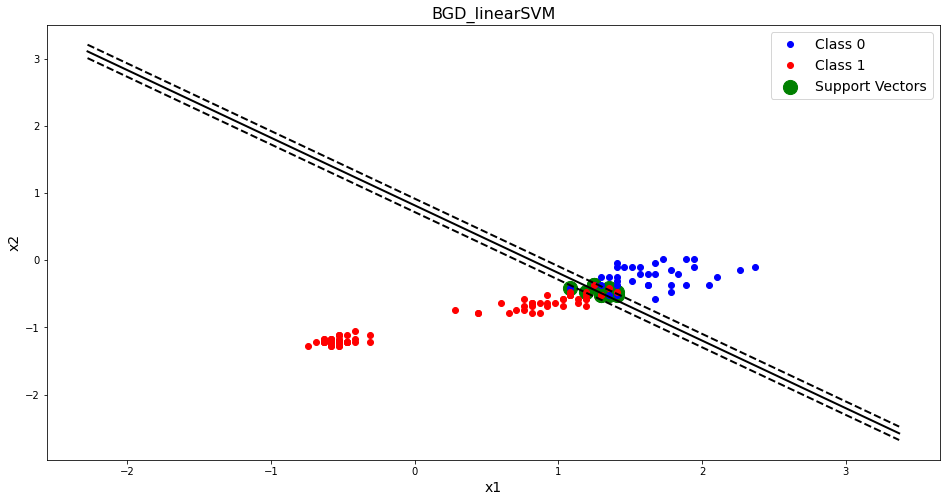

In [62]:
plt.figure(figsize=(16,8))
plt.plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bo", label="Class 0")
plt.plot(X_train[:, 0][y_train==0], X_train[:, 1][y_train==0], "ro", label="Class 1")

decision_boundary_support_vectors(model, X_train)

plt.xlabel("x1", fontsize=14)
plt.ylabel("x2", fontsize=14)
plt.legend(loc="best", fontsize=14)
plt.title("BGD_linearSVM", fontsize=16)
plt.show()

In [63]:
pred = model.predict(X_train)
print("Train Accuracy: ", accuracy_score(pred, y_train))


y_test_predicted = model.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test_predicted, y_test))


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


Train Accuracy:  0.9416666666666667
Test Accuracy:  1.0

Test Confusion Matrix:
[[17  0]
 [ 0 13]]
